In [354]:
# Load Required Libraries
# -----------------------
library(labelled)     # For handling variable labels
library(readxl) 

library(stringr)
library(lubridate)
library(pROC)

library(corrplot)
library(VIM)
library(Hmisc)
library(GGally)
library(gridExtra)
library(RColorBrewer)
library(car)
library(broom)
library(kableExtra)
library(psych)
library(e1071)  # for skewness() and kurtosis()
library(MASS)

library(gglasso)  
library(tidyverse)
library(dplyr)



In [355]:
# Import Excel files
#Baseline + lifestyle
dataset_cd <- read_excel("../input/dataset/Dataset CD v3.xlsx") %>%
  mutate(
    birthdate = dmy(birthdate)
  )

dataset_uc <- read_excel("../input/dataset/Dataset UC v3.xlsx")%>%
  mutate(
    birthdate = dmy(birthdate)
  )

#Psychosocial data

# 1. Import and rename columns with effectiveDate as Date
anxiety_depression <- read_excel("../input/dataset/Anxiety(angst) and depression(depressie).xlsx",
                                 col_types = c("text", "date", "numeric", "numeric")) %>%
  rename(
    patientIdentifier = 1,
    effectiveDate = 2,
    Anxious = 3,
    Depression = 4
  )

promis_fatigue <- read_excel("../input/dataset/Promis fatigue.xlsx",
                             col_types = c("text", "date", "numeric")) %>%
  rename(
    patientIdentifier = 1,
    effectiveDate_fatigue = 2,
    Fatigue = 3
  )

vas_pijn <- read_excel("../input/dataset/VAS pijn.xlsx",
                       col_types = c("text", "text", "numeric")) %>%
  rename(
    patientIdentifier = 1,
    effectiveDate_raw = 2,
    MIAH_pain = 3
  )%>%
  # Parse effectiveDate correctly
  mutate(effectiveDate_pain = ymd_hms(effectiveDate_raw, tz = "Europe/Paris")) %>%
  dplyr::select(-effectiveDate_raw)  # Remove raw column if no longer needed



#Medication
advanced_therapy_use <- read_excel("../input/dataset/Advanced therapy use.xlsx")     
Other_medication <- read_excel("../input/dataset/Other medication.xlsx") 
          


Warning message:
“Expecting logical in CC1442 / R1442C81: got a date”
Warning message:
“Expecting logical in CD1442 / R1442C82: got 'Gekeken tot aan de stenose, geen inflammatie. Dilatatie tot 15mm'”
Warning message:
“Expecting logical in BM1971 / R1971C65: got a date”
Warning message:
“Expecting logical in BM1982 / R1982C65: got a date”
Warning message:
“Expecting logical in BO1982 / R1982C67: got a date”
Warning message:
“Expecting logical in BQ1982 / R1982C69: got a date”
Warning message:
“Expecting logical in BM2030 / R2030C65: got a date”
Warning message:
“Expecting logical in BO2030 / R2030C67: got a date”
Warning message:
“Expecting logical in BQ2030 / R2030C69: got a date”
Warning message:
“Expecting logical in CC2088 / R2088C81: got a date”
Warning message:
“Expecting logical in CD2088 / R2088C82: got 'Het colon is voorbereid met Moviprep en bisacodyl. Introductie vindt plaats tot in het neoterminale ileum. De darm is goed gereinigd.
Darm: Het lumen van de darm is normaal van 

# 1. Data Preparation


## 1.1 Prepare BaseLine Data


identify and remove all rows from `dataset_cd` that are mostly empty (only have values in a few key columns like `patientIdentifier`, `gender`, `birthdate`, `diagnosis`, and `inclusion_date`):

In [356]:
# Define the key columns that are typically filled even for sparse rows
key_columns <- c("patientIdentifier", "gender", "birthdate", "diagnosis", "inclusion_date")

# Identify columns other than these
non_key_columns <- setdiff(names(dataset_cd), key_columns)

# Compute number of non-NA values per row in the non-key columns
dataset_cd <- dataset_cd %>%
  mutate(non_key_nonNA = rowSums(!is.na(dplyr::select(., all_of(non_key_columns)))))

# Calculate how many rows have only the key fields filled (i.e., rest is all NA)
only_key_rows <- dataset_cd %>%
  filter(non_key_nonNA < 3)

# Percentage of such sparse rows
percent_sparse <- nrow(only_key_rows) / nrow(dataset_cd) * 100
cat(sprintf("⚠️ %.2f%% of rows in CD data only contain key columns and are likely empty.\n", percent_sparse))

# Remove those rows from dataset
dataset_cd_clean <- dataset_cd %>%
  filter(non_key_nonNA >3) %>%
  dplyr::select(-non_key_nonNA)  # remove helper column

# overwrite if desired
dataset_cd <- dataset_cd_clean %>%
  mutate(
    age_at_inclusion = as.numeric(difftime(inclusion_date, birthdate, units = "days")) / 365.25
  )


# UC

# Identify columns other than these
non_key_columns <- setdiff(names(dataset_uc), key_columns)

# Compute number of non-NA values per row in the non-key columns
dataset_uc <- dataset_uc %>%
  mutate(non_key_nonNA = rowSums(!is.na(dplyr::select(., all_of(non_key_columns)))))

# Calculate how many rows have only the key fields filled (i.e., rest is all NA)
only_key_rows <- dataset_uc %>%
  filter(non_key_nonNA < 3)

# Percentage of such sparse rows
percent_sparse <- nrow(only_key_rows) / nrow(dataset_uc) * 100
cat(sprintf("⚠️ %.2f%% of rows in UC data only contain key columns and are likely empty.\n", percent_sparse))

# Remove those rows from dataset
dataset_uc_clean <- dataset_uc %>%
  filter(non_key_nonNA >3) %>%
  dplyr::select(-non_key_nonNA)  # remove helper column

# overwrite if desired
dataset_uc <- dataset_uc_clean %>%
  mutate(
    age_at_inclusion = as.numeric(difftime(inclusion_date, birthdate, units = "days")) / 365.25
  )


⚠️ 8.25% of rows in CD data only contain key columns and are likely empty.
⚠️ 11.25% of rows in UC data only contain key columns and are likely empty.


In [357]:
cat("Number of patients in dataset_cd: ", nrow(dataset_cd))
cat("\nNumber of patients in dataset_uc: ", nrow(dataset_uc))

Number of patients in dataset_cd:  2424
Number of patients in dataset_uc:  1855


Check if patientIdentifier is unique in CD and UC


In [358]:
cat("duplicated patientIdentifier in dataset_cd:\n",
      dataset_cd$patientIdentifier[duplicated(dataset_cd$patientIdentifier)])
cat("duplicated patientIdentifier in  dataset_uc:\n",
      dataset_uc$patientIdentifier[duplicated(dataset_uc$patientIdentifier)])

duplicated patientIdentifier in dataset_cd:
 duplicated patientIdentifier in  dataset_uc:
 


### 1.Create Flare (per date):

1. `MIAH score > 3.6` in any of the `miah[1-4]`` columns.

2. Fecal calprotectin > 250 µg/g` in any of `calprotectine[1–9]` (ignore 10–14 as they're logical and likely invalid).

3. Endoscopy report (`verslag[1–3]`) contains signs of active disease, such as terms like "active", "ulcer", "inflammation" (basic keyword matching).


For each i = 1 to 4:

* `flare_date[i] = 1` if **any of the following are TRUE**:

  1. `miah[i] > 3.6`
  2. `calprotectine[i] > 250`
  3. `verslag[i]` is **not NA** or empty (i.e., contains any text)
  
Note:
* The check `trimws(...) != ""` ensures blank strings (e.g., `" "`) aren’t treated as content.


#### 🔍 CD:


In [359]:
# Loop over 1 to 3: include verslag
for (i in 1:3) {
  miah_col <- paste0("miah_CD", i)
  calpro_col <- paste0("calprotectine", i)
  verslag_col <- paste0("verslag", i)
  flare_col <- paste0("flare_date", i)
  
  dataset_cd[[flare_col]] <- (
    (!is.na(dataset_cd[[miah_col]]) & dataset_cd[[miah_col]] > 3.6) |
    (!is.na(dataset_cd[[calpro_col]]) & dataset_cd[[calpro_col]] > 250) |
    (!is.na(dataset_cd[[verslag_col]]) & trimws(dataset_cd[[verslag_col]]) != "")
  )
  
  dataset_cd[[flare_col]] <- as.integer(dataset_cd[[flare_col]])
}

# Special case for flare_date4: no verslag check
dataset_cd$flare_date4 <- (
  (!is.na(dataset_cd$miah_CD4) & dataset_cd$miah_CD4 > 3.6) |
  (!is.na(dataset_cd$calprotectine4) & dataset_cd$calprotectine4 > 250)
)
dataset_cd$flare_date4 <- as.integer(dataset_cd$flare_date4)


sapply(1:4, function(i) table(dataset_cd[[paste0("flare_date", i)]]))


[,1] [,2] [,3] [,4]
0 1605 1939 2128 2299
1  819  485  296  125

#### 🔍 uc:



In [360]:
# Loop over 1 to 4
for (i in 1:4) {
  miah_col <- paste0("miah_cu", i)
  calpro_col <- paste0("calprotectine", i)
  verslag_col <- paste0("verslag", i)
  flare_col <- paste0("flare_date", i)
  
  dataset_uc[[flare_col]] <- (
    (!is.na(dataset_uc[[miah_col]]) & dataset_uc[[miah_col]] > 3.6) |
    (!is.na(dataset_uc[[calpro_col]]) & dataset_uc[[calpro_col]] > 250) |
    (!is.na(dataset_uc[[verslag_col]]) & trimws(dataset_uc[[verslag_col]]) != "")
  )
  
  dataset_uc[[flare_col]] <- as.integer(dataset_uc[[flare_col]])
}



sapply(1:4, function(i) table(dataset_uc[[paste0("flare_date", i)]]))



[,1] [,2] [,3] [,4]
0 871  1174 1484 1690
1 984   681  371  165

Drop miah, calpro, verslag, mayo, and sescd from CD and UC as they are already used to create flare


In [361]:
dataset_uc <- dataset_uc %>%
  dplyr::select(-starts_with("miah"), -starts_with("calpro"), -starts_with("mayo") , -starts_with('verslag'))

dataset_cd <- dataset_cd %>%
  dplyr::select(-starts_with("miah"), -starts_with("calpro"), -starts_with("mayo") ,
         -starts_with('verslag'), -starts_with('sescd'))

 # Add DiseaseEntity column
 
dataset_cd$DiseaseEntity <- factor("CD", levels = c("CD", "UC"))
dataset_uc$DiseaseEntity <- factor("UC", levels = c("CD", "UC"))


### 2. Perform a column-wise bind (rbind)



In [362]:
# Combine datasets: combines rows, stacking one dataset below the other (requires same columns)

dataset_cd$montreal_severity_uc <- as.character(dataset_cd$montreal_severity_uc)
dataset_uc$montreal_severity_uc <- as.character(dataset_uc$montreal_severity_uc)

dataset_cd <- dataset_cd %>%
  mutate(
    montreal_extent_uc = NA,
    montreal_severity_uc = NA,
    montreal_year_diagnosis_uc = NA
  )

dataset_uc <- dataset_uc %>%
  mutate(
    montreal_age_cd = NA,
    montreal_location_cd = NA,
    montreal_activity_cd = NA
  )

combined_dataset <- bind_rows(dataset_cd, dataset_uc) %>%
  slice_sample(prop = 1)  # shuffle (randomize) the rows in combined_dataset after merging dataset_cd and dataset_uc 

cat("Total number of CD AND UC patients:", dim(combined_dataset), "\n")


Total number of CD AND UC patients: 4279 43 


## 1.2 Prepare psychosocial Data

Check if patientIdentifier is unique.



In [363]:
# Check if patientIdentifier is unique.
cat("\nduplicated patientIdentifier in combined_dataset:\n",
      combined_dataset$patientIdentifier[duplicated(combined_dataset$patientIdentifier)])
cat("\nduplicated patientIdentifier in  anxiety_depression:\n",
      anxiety_depression$patientIdentifier[duplicated(anxiety_depression$patientIdentifier)])
cat("\nduplicated patientIdentifier in promis_fatigue:\n",
      promis_fatigue$patientIdentifier[duplicated(promis_fatigue$patientIdentifier)])
cat("\nduplicated patientIdentifier in vas_pijn:\n",
      vas_pijn$patientIdentifier[duplicated(vas_pijn$patientIdentifier)])



duplicated patientIdentifier in combined_dataset:
 
duplicated patientIdentifier in  anxiety_depression:
 12040741 123456789 13108846 1641569 21193379 23226341 23396362 37150820 4635903 5103720 6150776 6308703
duplicated patientIdentifier in promis_fatigue:
 12040741 13108846 1641569 21193379 23226341 23396362 37150820 4635903 5103720 6150776 6308703 6317729
duplicated patientIdentifier in vas_pijn:
 23226341 23396362 13108846 21193379 37150820 12040741 6039138 4635903 5103720 1641569 6150776 6308703

There're duplication in all three files. Let's display an example for each file:


In [364]:
anxiety_depression[anxiety_depression$patientIdentifier=="123456789",]
promis_fatigue[promis_fatigue$patientIdentifier=="13108846",]

patientIdentifier effectiveDate Anxious Depression
1 123456789         2023-11-20    12      13        
2 123456789         2023-11-20     7       9

patientIdentifier effectiveDate_fatigue Fatigue
1 13108846          2024-05-03            60.4   
2 13108846          2023-05-25            61.3

Remove duplication by returning mean of psychosocial factors and max effectiveDate:


In [365]:
anxiety_depression <- anxiety_depression %>%
  group_by(patientIdentifier) %>%
  summarise(
    Anxious_mean = mean(Anxious, na.rm = TRUE),
    Depression_mean = mean(Depression, na.rm = TRUE),
    .groups = "drop"
  )


promis_fatigue <- promis_fatigue %>%
  group_by(patientIdentifier) %>%
  summarise(
    Fatigue_mean = mean(Fatigue, na.rm = TRUE),
    .groups = "drop"
  )

vas_pijn <- vas_pijn %>%
  group_by(patientIdentifier) %>%
  summarise(
    MIAH_pain_mean = mean(MIAH_pain, na.rm = TRUE),
    .groups = "drop"
  )

cat("Total number of patients in anxiety_depression:", nrow(anxiety_depression), "\n")
cat("Total number of patients in promis_fatigue:", nrow(promis_fatigue), "\n")
cat("Total number of patients in vas_pijn:", nrow(vas_pijn), "\n")

Total number of patients in anxiety_depression: 1072 
Total number of patients in promis_fatigue: 1059 
Total number of patients in vas_pijn: 1066 


Inner join the three psychosocial datasets to combined_dataset by patientIdentifier:


In [366]:
# 2. Join each dataset using left_join on patientIdentifier
combined_dataset <- combined_dataset %>%
  inner_join(anxiety_depression, by = "patientIdentifier") %>%
  inner_join(promis_fatigue, by = "patientIdentifier") %>%
  inner_join(vas_pijn, by = "patientIdentifier")


## 1.3 Prepare Medication Data

In [367]:
cat("Total number of patients in advanced_therapy_use:", nrow(advanced_therapy_use[!duplicated(advanced_therapy_use$patientIdentifier),]), "\n")


Total number of patients in advanced_therapy_use: 1802 


In [368]:
# Check if patientIdentifier is unique.
cat("\nduplicated patientIdentifier in advanced_therapy_use:\n",
      advanced_therapy_use$patientIdentifier[duplicated(advanced_therapy_use$patientIdentifier)])



duplicated patientIdentifier in advanced_therapy_use:
 1168664 1330465 1336573 1794839 2303875 23410921 2868545 292205 3015108 5089769 51209268 51847094 5366821 55912567 59322993 6003730 61329371 6168951 659341 68456328 68523998 69673373 70110832 70249849 72422017 73384976 7563796 8284821 889249 9199910

In [369]:
advanced_therapy_use[advanced_therapy_use$patientIdentifier=="9199910",]


patientIdentifier medicine_id route_id frequency_id dose unit_id
1 9199910           33           5       34           300  2      
2 9199910           14          11       12           40   2      
  brand                 othermedicine stopreason_id stop_text
1 Inductieschema: 0-2-6 NA            NA            NA       
2 Humira                NA            NA            NA       
  startmed            stopmed             meddur    episode_number
1 2023-07-30 23:00:00 2025-02-14 00:00:00  564.0417 2             
2 2020-12-18 01:00:00 2023-07-30 23:00:00 1518.9583 1

compute the medication period (in days) in advanced_therapy_use using startmed and stopmed columns:


In [370]:
advanced_therapy_use <- advanced_therapy_use%>%
  mutate(medication_period_days = as.numeric(stopmed - startmed))

Other_medication <- Other_medication%>%
  mutate(medication_period_days = as.numeric(stop_date - start_date))


In [371]:
advanced_therapy_use <- advanced_therapy_use%>%
      dplyr::select(patientIdentifier, medicine_id ,dose , medication_period_days)

Other_medication <- Other_medication%>%
      dplyr::select(patientIdentifier, medicine_id ,dose , medication_period_days)


Combine `advanced_therapy_use` and `Other_medication` **while avoiding duplicates**, i.e.:

* Keep **all rows** from `advanced_therapy_use`
* Add **only those rows** from `Other_medication` where `patientIdentifier` is **not already present** in `advanced_therapy_use`




In [372]:
# Get IDs already present in advanced_therapy_use
existing_ids <- unique(advanced_therapy_use$patientIdentifier)

# Filter Other_medication to include only new patientIdentifiers
other_med_filtered <- Other_medication %>%
  filter(!patientIdentifier %in% existing_ids)

# Combine the datasets
combined_medications <- bind_rows(advanced_therapy_use, other_med_filtered)


replace the medicine_id values with their corresponding labels. For unknown IDs like “88”, “77”, and “70”, we’ll assign NA.


In [373]:
# Ensure medicine_id is numeric
combined_medications <- combined_medications %>%
  mutate(medicine_id = as.numeric(medicine_id))

# Define lookup table
medicine_lookup <- tibble::tibble(
  medicine_id = c(4, 7, 10, 12, 14, 16, 22, 28, 29, 30, 31, 32,
                  33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44),
  medicine_label = c("Ciclosporine", "Methotrexaat", "Azathioprine", "Infliximab_Remicade",
                     "Adalimumab", "Prednison", "Golimumab", "Mesalazine_oraal", "Budesonide",
                     "Beclomethason", "Mercaptopurine", "Tioguanine", "Vedolizumab",
                     "Tacrolimus", "Mesalazine_klysma", "Mesalazine_zetpil", "Mesalazine_Beclomethason",
                     "Sulfasalazine", "Infliximab_Inflectra", "Infliximab_Remsima",
                     "Tofacitinib", "Ustekinumab_Stelara", "Infliximab_Flixabi", "Allopurinol")
)

# Join and replace medicine_id with label
combined_medications <- combined_medications %>%
  left_join(medicine_lookup, by = "medicine_id") %>%
  mutate(medicine_id = medicine_label) %>%
  dplyr::select(-medicine_label)


clean dose:


In [374]:

combined_medications <- combined_medications %>%
  mutate(
    # Clean the dose field
    dose_cleaned = str_replace_all(dose, ",", "."),                      # Convert commas to dots
    dose_cleaned = str_extract(dose_cleaned, "\\d+\\.?\\d*"),            # Extract first numeric part
    dose_cleaned = as.numeric(dose_cleaned)                              # Convert to numeric
  )


To **reshape**  `advanced_therapy_use` dataset so that:

* Each **`patientIdentifier`** is a row
* Each unique `medicine_id` becomes a **prefix** for two new columns:

  * `brand_dose`
  * `brand_medication_period_days`



In [375]:
# Filter to rows with brand info, Ensure columns are numeric
filtered_data <- combined_medications %>%
  filter(!is.na(medicine_id))  %>%
  mutate(
    dose = as.numeric(dose_cleaned), # Convert commas to dots in dose values
    medication_period_days = as.numeric(medication_period_days)
  ) %>%
  distinct(patientIdentifier, medicine_id, .keep_all = TRUE)

# --- Wide format for brand usage indicator (1/0) ---
binary_brand_use <- filtered_data %>%
  mutate(use = 1) %>%
  distinct(patientIdentifier, medicine_id, use) %>%
  pivot_wider(
    names_from = medicine_id,
    values_from = use,
    values_fill = 0,
    names_prefix = "used_"
  )

# --- Wide format for dose ---
# if a brand wasn’t prescribed to a patient, their dose and medication period will be set to 0 instead of NA).
dose_wide <- filtered_data %>%
  select(patientIdentifier, medicine_id, dose_cleaned) %>%
  pivot_wider(
    names_from = medicine_id,
    values_from = dose_cleaned,
    names_prefix = "dose_",
    values_fill = 0
  )


# --- Wide format for medication period ---
period_wide <- filtered_data %>%
  dplyr::select(patientIdentifier, medicine_id, medication_period_days) %>%
  pivot_wider(names_from = medicine_id, 
              values_from = medication_period_days, 
              names_prefix = "period_",
              values_fill = 0) # replace NA with 0 here)


# --- Combine all into one dataset ---
advanced_therapy_reshaped <- reduce(
  list(binary_brand_use, period_wide, dose_wide),
  full_join,
  by = "patientIdentifier"
)


* This keeps multiple brands in separate columns like:
  `dose_Amgevita`, `period_Amgevita`, etc.

In [376]:
 #compute the total number of medication used per patient 
# List of used med variables
med_used_vars <- colnames(advanced_therapy_reshaped  %>% dplyr::select(starts_with("used_")))

# Compute total dose and add as new variable
advanced_therapy_reshaped <- advanced_therapy_reshaped %>%
  mutate(total_medication = rowSums(dplyr::select(., all_of(med_used_vars)), na.rm = TRUE))

# List of period variables
period_vars <- colnames(advanced_therapy_reshaped  %>% dplyr::select(starts_with("period_")))

# Compute total period and add as new variable
advanced_therapy_reshaped <- advanced_therapy_reshaped %>%
  mutate(total_medication_period = rowSums(dplyr::select(., all_of(period_vars)), na.rm = TRUE))

 #compute the total dose of medication used per patient 
# List of dose variables
dose_vars <- colnames(advanced_therapy_reshaped  %>% dplyr::select(starts_with("dose_")))

# Compute total dose and add as new variable
advanced_therapy_reshaped <- advanced_therapy_reshaped %>%
  mutate(total_medication_dose = rowSums(dplyr::select(., all_of(dose_vars)), na.rm = TRUE))




In [377]:

# inner join on patientIdentifier
combined_dataset <- combined_dataset %>%
  inner_join(advanced_therapy_reshaped, by = "patientIdentifier")


## 1.4 Prepare the Combined dataset


compute the age at diagnosis :




In [378]:
combined_dataset <- combined_dataset %>%
  mutate(
    birth_year = lubridate::year(birthdate),
    montreal_age_diagnosis_uc = montreal_year_diagnosis_uc - birth_year
  )%>%
  dplyr::select(-montreal_year_diagnosis_uc, -birth_year )



fill NA values with 9999 in the montreal_ vars



In [379]:
combined_dataset <- combined_dataset %>%
  mutate(across(
    c(
      montreal_extent_uc,
      montreal_severity_uc,
      montreal_age_diagnosis_uc,
      montreal_age_cd,
      montreal_location_cd,
      montreal_activity_cd
    ),
    ~replace(., is.na(.), 9999)),
    montreal_extent_uc = ifelse(is.infinite(montreal_extent_uc) , 9999, montreal_extent_uc),
    montreal_severity_uc = ifelse(montreal_severity_uc == "-Inf", "9999", montreal_severity_uc),
    montreal_age_diagnosis_uc = ifelse(montreal_age_diagnosis_uc < 0, 9999, montreal_age_diagnosis_uc)

  )



Compute the age at the time of each surgery using the `birthdate` column and the `surg_*` date columns:


In [380]:
surgery_vars <- colnames(combined_dataset  %>% dplyr::select(starts_with("surg_")))


# Compute age at surgery for each surgery column
for (surg_col in surgery_vars) {
  age_col <- paste0("age_at_", surg_col)
  combined_dataset[[age_col]] <- as.numeric(difftime(combined_dataset[[surg_col]], combined_dataset$birthdate, units = "days")) / 365.25
}



In [381]:
# Replace NA with 0 in age_at_ Columns
combined_dataset <- combined_dataset %>%
  mutate(across(starts_with("age_at_"), ~replace_na(., 0)))


convert the surgery_vars columns in combined_dataset to binary indicators (1 if a surgery date exists, 0 if NA):



In [382]:
# Replace surgery dates with binary indicators: 1 if not NA, 0 if NA
combined_dataset[surgery_vars] <- lapply(combined_dataset[surgery_vars], function(x) ifelse(!is.na(x), 1, 0))


create a new variable (e.g. number_of_surgeries) by summing across all the binary surgery indicator columns for each patient:


In [383]:
# Create a new column that sums the binary surgery columns
combined_dataset$number_of_surgeries <- rowSums(combined_dataset[surgery_vars], na.rm = TRUE)


create three new variables (`Family_IBD_final`, `History_colitis`, and `History_crohn`) 


In [384]:

combined_dataset <- combined_dataset %>%
  mutate(
    Family_IBD_final = case_when(
      rowSums(dplyr::select(., positive_fam_history, father_ibd, mother_ibd) == 1, na.rm = TRUE) > 0 ~ 1,
      rowSums(is.na(dplyr::select(., positive_fam_history, father_ibd, mother_ibd))) == 3 ~ 9999,
      rowSums(dplyr::select(., positive_fam_history, father_ibd, mother_ibd) == 0, na.rm = TRUE) >= 1 ~ 0
    ),
    
    History_colitis = case_when(
      rowSums(dplyr::select(., first_degree_colitis, second_degree_colitis) == 1, na.rm = TRUE) > 0 ~ 1,
      rowSums(is.na(dplyr::select(., first_degree_colitis, second_degree_colitis))) == 2 ~ 9999,
      rowSums(dplyr::select(., first_degree_colitis, second_degree_colitis) == 0, na.rm = TRUE) >= 1 ~ 0
    ),
    
    History_crohn = case_when(
      rowSums(dplyr::select(., first_degree_crohn, second_degree_crohn) == 1, na.rm = TRUE) > 0 ~ 1,
      rowSums(is.na(dplyr::select(., first_degree_crohn, second_degree_crohn))) == 2 ~ 9999,
      rowSums(dplyr::select(., first_degree_crohn, second_degree_crohn) == 0, na.rm = TRUE) >= 1 ~ 0
    )
  ) %>%
  dplyr::select(-positive_fam_history, -father_ibd, -mother_ibd,
         -first_degree_colitis, -second_degree_colitis,
         -first_degree_crohn, -second_degree_crohn)


In [385]:
combined_dataset <- combined_dataset %>%
  dplyr::select(-diagnosis, -birthdate, -inclusion_date, -length, -weight, -surg_kock_pouch,
         -montreal_activity_cd) 



Reorder Columns


In [386]:
combined_dataset <- combined_dataset %>%
  dplyr::select(
    starts_with("flare_date"),
         "DiseaseEntity",
    "gender",
    "bmi",
    "age_at_inclusion",
    
    starts_with("montreal_"),
    
    starts_with("surg_"),
    "number_of_surgeries",
    
    starts_with("age_at_surg_"),
    
    "Family_IBD_final",
    "History_colitis",
    "History_crohn",
    
    "Anxious_mean",
    "Depression_mean",
    "Fatigue_mean",
    "MIAH_pain_mean",
    
    "smoker",
    
    starts_with("used_"),
    "total_medication",
    "total_medication_period", 
    "total_medication_dose", 
    starts_with("period_"),
    starts_with("dose_")
  ) %>% 
  drop_na()


In [387]:
str(combined_dataset)


tibble [577 × 108] (S3: tbl_df/tbl/data.frame)
 $ flare_date1                      : int [1:577] 0 1 0 1 1 1 0 1 1 1 ...
 $ flare_date2                      : int [1:577] 0 0 0 1 1 1 0 1 1 1 ...
 $ flare_date3                      : int [1:577] 0 1 0 0 1 1 0 1 1 1 ...
 $ flare_date4                      : int [1:577] 0 0 0 0 1 0 0 0 0 0 ...
 $ DiseaseEntity                    : Factor w/ 2 levels "CD","UC": 1 1 1 2 1 2 1 1 1 1 ...
 $ gender                           : chr [1:577] "M" "F" "M" "F" ...
 $ bmi                              : num [1:577] 22.4 33.5 21.1 22.5 19.5 ...
 $ age_at_inclusion                 : num [1:577] 66.1 42.1 21.6 25.2 39.7 ...
 $ montreal_extent_uc               : num [1:577] 9999 9999 9999 2 9999 ...
 $ montreal_severity_uc             : chr [1:577] "9999" "9999" "9999" "2" ...
 $ montreal_age_cd                  : num [1:577] 0 1 9999 9999 1 ...
 $ montreal_location_cd             : num [1:577] 0 1 9999 9999 0 ...
 $ montreal_age_diagnosis_uc        : num 

In [388]:
#colSums(is.na(combined_dataset))
cat("Final number of patient will be used in Modeling: ", dim(combined_dataset))


Final number of patient will be used in Modeling:  577 108

remove constant variables:

In [389]:
combined_dataset <- combined_dataset[
  !sapply(combined_dataset, function(col) {
    length(unique(na.omit(col))) <= 1
    
  })
]


In [390]:
# Identify relevant columns
selected_cols <- names(combined_dataset[
  sapply(combined_dataset, function(col) {
    if (is.numeric(col)) {
      length(unique(na.omit(col))) <= 2
    } else {
      FALSE
    }
  })
])

# Apply table() to each selected column
sapply(selected_cols, function(colname) table(combined_dataset[[colname]], useNA = "ifany"))


flare_date1 flare_date2 flare_date3 flare_date4 surg_colon_resection
0 180         252         353         474         553                 
1 397         325         224         103          24                 
  surg_subtotal_colectomy surg_fistula_abcess surg_ileo_anal_pouch
0 558                     538                 572                 
1  19                      39                   5                 
  surg_small_bowel_resection surg_ileocaecal_resection ⋯ used_Beclomethason
0 554                        498                       ⋯ 554               
1  23                         79                       ⋯  23               
  used_Azathioprine used_Allopurinol used_Mesalazine_klysma used_Sulfasalazine
0 537               567              568                    569               
1  40                10                9                      8               
  used_Tacrolimus period_Tacrolimus dose_Golimumab dose_Allopurinol
0 576             576               575            567             
1   1               1                 2             10             
  dose_Tacrolimus
0 576            
1   1

In [391]:
combined_dataset <- combined_dataset  %>%
  dplyr::select(-period_Tacrolimus , -dose_Tacrolimus , -dose_Golimumab  , 
                -used_Tacrolimus , -used_Golimumab ,-surg_proctectomy )

#colSums(is.na(combined_dataset))
cat("Final number of patient will be used in Modeling: ", dim(combined_dataset))

Final number of patient will be used in Modeling:  577 97

Convert Type


In [392]:
combined_dataset <- combined_dataset %>%
  mutate(
    gender = factor(gender, levels = c("M", "F"), labels = c("Male", "Female")),
         
         montreal_extent_uc= factor(montreal_extent_uc),
         montreal_severity_uc = factor(montreal_severity_uc),
         montreal_age_cd = factor(montreal_age_cd),
         montreal_location_cd = factor(montreal_location_cd),
         
         surg_colon_resection       = factor(surg_colon_resection),
         surg_subtotal_colectomy    = factor(surg_subtotal_colectomy),
         surg_fistula_abcess        = factor(surg_fistula_abcess),
         surg_ileo_anal_pouch       = factor(surg_ileo_anal_pouch),
         surg_small_bowel_resection = factor(surg_small_bowel_resection),
         surg_ileocaecal_resection  = factor(surg_ileocaecal_resection),
         surg_small_bowel_stoma     = factor(surg_small_bowel_stoma),
         surg_colostoma             = factor(surg_colostoma),
         surg_proctocolectomy       = factor(surg_proctocolectomy),
         surg_stoma_reversal        = factor(surg_stoma_reversal),
         surg_stenoplasty           = factor(surg_stenoplasty),
         
         Family_IBD_final = factor(Family_IBD_final),
         History_colitis  = factor(History_colitis),
         History_crohn    = factor(History_crohn),
         
         smoker = factor(smoker),
         
         used_Adalimumab = factor(used_Adalimumab),
    used_Infliximab_Remicade = factor(used_Infliximab_Remicade),
    used_Ustekinumab_Stelara = factor(used_Ustekinumab_Stelara),
    used_Vedolizumab = factor(used_Vedolizumab),                  
    used_Tofacitinib = factor(used_Tofacitinib),                 
    used_Mesalazine_oraal = factor(used_Mesalazine_oraal), 
    used_Budesonide = factor(used_Budesonide),                   
    used_Tioguanine = factor(used_Tioguanine),                   
    used_Methotrexaat = factor(used_Methotrexaat), 
    used_Mesalazine_zetpil = factor(used_Mesalazine_zetpil),            
    used_Mercaptopurine = factor(used_Mercaptopurine),              
    used_Beclomethason = factor(used_Beclomethason),  
    used_Azathioprine = factor(used_Azathioprine),                 
    used_Allopurinol = factor(used_Allopurinol),                  
    used_Mesalazine_klysma = factor(used_Mesalazine_klysma),   
    used_Sulfasalazine = factor(used_Sulfasalazine)
         
         )



## 1.5 evaluate each predictor variable against your four dependent variables (flare_date1, flare_date2, flare_date3, flare_date4). 

This will systematically test significance and provide data cleaning recommendations.

### 1.5.1 Factor features


In [393]:
summarize_chisq_for_factor <- function(df, predictor, flares = c("flare_date1", "flare_date2", "flare_date3", "flare_date4")) {
  # Treat 9999 as NA
  x_raw <- df[[predictor]]
  x <- factor(ifelse(as.character(x_raw) == "9999", NA, as.character(x_raw)))

  results <- lapply(flares, function(flare) {
    y <- df[[flare]]
    tbl <- table(x, y, useNA = "no")

    if (nrow(tbl) < 2 || ncol(tbl) < 2) {
      return(data.frame(Flare = flare, ChiSq = NA, df = NA, p_value = NA))
    }

    test_result <- suppressWarnings(chisq.test(tbl))

    data.frame(
      Flare = flare,
      ChiSq = round(test_result$statistic, 3),
      df = test_result$parameter,
      p_value = signif(test_result$p.value, 4),
      row.names = NULL  # <-- Ensures no row names
      
    )
  })

  result_df <- do.call(rbind, results)
  cat("\nChi-squared summary for predictor:", predictor, "\n")
  print(result_df)
  invisible(result_df)
}


In [394]:
summarize_chisq_for_factor(combined_dataset, "DiseaseEntity")


Chi-squared summary for predictor: DiseaseEntity 
        Flare  ChiSq df   p_value
1 flare_date1 21.607  1 3.347e-06
2 flare_date2 31.066  1 2.494e-08
3 flare_date3  6.470  1 1.097e-02
4 flare_date4  5.584  1 1.813e-02


In [395]:
summarize_chisq_for_factor(combined_dataset, "gender")


Chi-squared summary for predictor: gender 
        Flare ChiSq df  p_value
1 flare_date1 4.487  1 0.034160
2 flare_date2 8.241  1 0.004095
3 flare_date3 1.286  1 0.256900
4 flare_date4 2.305  1 0.128900


In [396]:
# Recode 'smoker' variable in combined_dataset
combined_dataset <- combined_dataset %>%
  mutate(
    montreal_extent_uc = case_when(
      montreal_extent_uc == "1" ~ "1",                            
      montreal_extent_uc %in% c("2", "3") ~ "2",                  
      montreal_extent_uc == "9999" ~ "9999",                         
      TRUE ~ as.character(montreal_extent_uc)                    
    ),
    montreal_extent_uc = factor(montreal_extent_uc, levels = c("1", "2", "9999"),
                    labels = c("1", "2&3", "9999"))
  )

In [397]:
summarize_chisq_for_factor(combined_dataset, "montreal_extent_uc")


Chi-squared summary for predictor: montreal_extent_uc 
        Flare ChiSq df p_value
1 flare_date1 0.395  1  0.5296
2 flare_date2 1.407  1  0.2355
3 flare_date3 0.668  1  0.4136
4 flare_date4 0.433  1  0.5107


In [398]:
# Recode 'smoker' variable in combined_dataset
combined_dataset <- combined_dataset %>%
  mutate(
    montreal_severity_uc = case_when(
      montreal_severity_uc == "0" ~ "1",                            
      montreal_severity_uc %in% c("1", "2") ~ "2",  
        montreal_severity_uc == "3" ~ "3", 
      montreal_severity_uc == "9999" ~ "9999",                         
      TRUE ~ as.character(montreal_severity_uc)                    
    ),
    montreal_severity_uc = factor(montreal_severity_uc, levels = c("1", "2","3", "9999"),
                    labels = c("0", "1&2","3", "9999"))
  )

In [399]:
summarize_chisq_for_factor(combined_dataset, "montreal_severity_uc")


Chi-squared summary for predictor: montreal_severity_uc 
        Flare ChiSq df p_value
1 flare_date1 7.795  2 0.02029
2 flare_date2 6.554  2 0.03775
3 flare_date3 2.606  2 0.27170
4 flare_date4 1.499  2 0.47260


In [400]:
summarize_chisq_for_factor(combined_dataset, "montreal_age_cd")


Chi-squared summary for predictor: montreal_age_cd 
        Flare ChiSq df p_value
1 flare_date1 0.286  1  0.5925
2 flare_date2 0.216  1  0.6418
3 flare_date3 0.036  1  0.8495
4 flare_date4 0.946  1  0.3307


In [401]:
summarize_chisq_for_factor(combined_dataset, "montreal_location_cd")


Chi-squared summary for predictor: montreal_location_cd 
        Flare ChiSq df p_value
1 flare_date1 2.012  1 0.15600
2 flare_date2 0.066  1 0.79670
3 flare_date3 0.027  1 0.86980
4 flare_date4 4.454  1 0.03481


In [402]:
summarize_chisq_for_factor(combined_dataset, "surg_colon_resection")


Chi-squared summary for predictor: surg_colon_resection 
        Flare ChiSq df p_value
1 flare_date1 0.800  1  0.3712
2 flare_date2 0.000  1  1.0000
3 flare_date3 0.122  1  0.7266
4 flare_date4 0.000  1  1.0000


In [403]:
summarize_chisq_for_factor(combined_dataset, "surg_subtotal_colectomy")


Chi-squared summary for predictor: surg_subtotal_colectomy 
        Flare ChiSq df p_value
1 flare_date1 0.000  1  1.0000
2 flare_date2 1.073  1  0.3004
3 flare_date3 0.000  1  1.0000
4 flare_date4 0.004  1  0.9474


In [404]:
summarize_chisq_for_factor(combined_dataset, "surg_fistula_abcess")


Chi-squared summary for predictor: surg_fistula_abcess 
        Flare ChiSq df p_value
1 flare_date1 0.698  1  0.4036
2 flare_date2 0.241  1  0.6238
3 flare_date3 0.000  1  1.0000
4 flare_date4 1.137  1  0.2864


In [405]:
summarize_chisq_for_factor(combined_dataset, "surg_ileo_anal_pouch")


Chi-squared summary for predictor: surg_ileo_anal_pouch 
        Flare ChiSq df p_value
1 flare_date1 0.831  1 0.36200
2 flare_date2 4.400  1 0.03594
3 flare_date3 1.764  1 0.18410
4 flare_date4 0.212  1 0.64520


In [406]:
summarize_chisq_for_factor(combined_dataset, "surg_small_bowel_resection")



Chi-squared summary for predictor: surg_small_bowel_resection 
        Flare ChiSq df p_value
1 flare_date1 3.946  1 0.04697
2 flare_date2 3.653  1 0.05596
3 flare_date3 3.740  1 0.05313
4 flare_date4 0.113  1 0.73640


In [407]:
summarize_chisq_for_factor(combined_dataset, "surg_ileocaecal_resection")



Chi-squared summary for predictor: surg_ileocaecal_resection 
        Flare  ChiSq df   p_value
1 flare_date1 17.177  1 3.405e-05
2 flare_date2 10.072  1 1.506e-03
3 flare_date3  3.174  1 7.483e-02
4 flare_date4  1.298  1 2.546e-01


In [408]:
summarize_chisq_for_factor(combined_dataset, "surg_small_bowel_stoma")


Chi-squared summary for predictor: surg_small_bowel_stoma 
        Flare ChiSq df p_value
1 flare_date1 5.639  1 0.01757
2 flare_date2 2.225  1 0.13570
3 flare_date3 1.464  1 0.22630
4 flare_date4 0.000  1 1.00000


In [409]:
summarize_chisq_for_factor(combined_dataset, "surg_colostoma")


Chi-squared summary for predictor: surg_colostoma 
        Flare ChiSq df p_value
1 flare_date1 0.069  1  0.7934
2 flare_date2 0.007  1  0.9320
3 flare_date3 0.000  1  1.0000
4 flare_date4 1.146  1  0.2844


In [410]:
summarize_chisq_for_factor(combined_dataset, "surg_proctocolectomy")


Chi-squared summary for predictor: surg_proctocolectomy 
        Flare ChiSq df p_value
1 flare_date1 0.000  1  1.0000
2 flare_date2 0.801  1  0.3709
3 flare_date3 0.161  1  0.6878
4 flare_date4 0.000  1  1.0000


In [411]:
summarize_chisq_for_factor(combined_dataset, "surg_stoma_reversal")


Chi-squared summary for predictor: surg_stoma_reversal 
        Flare ChiSq df p_value
1 flare_date1 2.223  1  0.1359
2 flare_date2 1.623  1  0.2027
3 flare_date3 0.057  1  0.8105
4 flare_date4 0.032  1  0.8577


In [412]:
summarize_chisq_for_factor(combined_dataset, "surg_stenoplasty")


Chi-squared summary for predictor: surg_stenoplasty 
        Flare ChiSq df p_value
1 flare_date1 0.075  1  0.7848
2 flare_date2 0.580  1  0.4462
3 flare_date3 0.003  1  0.9566
4 flare_date4 0.079  1  0.7791


In [413]:
summarize_chisq_for_factor(combined_dataset, "Family_IBD_final")


Chi-squared summary for predictor: Family_IBD_final 
        Flare ChiSq df p_value
1 flare_date1 0.057  1  0.8113
2 flare_date2 0.589  1  0.4429
3 flare_date3 0.090  1  0.7641
4 flare_date4 1.558  1  0.2120


In [414]:
summarize_chisq_for_factor(combined_dataset, "History_colitis")


Chi-squared summary for predictor: History_colitis 
        Flare  ChiSq df  p_value
1 flare_date1  1.767  1 0.183700
2 flare_date2  8.786  1 0.003036
3 flare_date3  4.361  1 0.036760
4 flare_date4 11.122  1 0.000853


In [415]:
summarize_chisq_for_factor(combined_dataset, "History_crohn")


Chi-squared summary for predictor: History_crohn 
        Flare ChiSq df p_value
1 flare_date1 1.879  1  0.1705
2 flare_date2 3.928  1  0.0475
3 flare_date3 0.451  1  0.5017
4 flare_date4 1.136  1  0.2866


In [416]:
summarize_chisq_for_factor(combined_dataset, "smoker")


Chi-squared summary for predictor: smoker 
        Flare ChiSq df p_value
1 flare_date1 1.719  3  0.6328
2 flare_date2 2.417  3  0.4904
3 flare_date3 1.231  3  0.7455
4 flare_date4 3.502  3  0.3205


In [417]:
# Recode 'smoker' variable in combined_dataset
combined_dataset <- combined_dataset %>%
  mutate(
    smoker = case_when(
      smoker == "1" ~ "1",                            # never smoked
      smoker %in% c("2", "4") ~ "2",                  # ex-smoker
      smoker == "3" ~ "3",                            # current smoker
      TRUE ~ as.character(smoker)                    # preserve other values (e.g. NA)
    ),
    smoker = factor(smoker, levels = c("1", "2", "3"),
                    labels = c("Never smoked", "Ex-smoker", "Current smoker"))
  )


In [418]:
summarize_chisq_for_factor(combined_dataset, "used_Adalimumab")


Chi-squared summary for predictor: used_Adalimumab 
        Flare ChiSq df p_value
1 flare_date1 2.271  1  0.1319
2 flare_date2 1.757  1  0.1849
3 flare_date3 0.183  1  0.6684
4 flare_date4 0.006  1  0.9392


In [419]:
summarize_chisq_for_factor(combined_dataset, "used_Infliximab_Remicade")



Chi-squared summary for predictor: used_Infliximab_Remicade 
        Flare ChiSq df p_value
1 flare_date1 2.866  1 0.09046
2 flare_date2 0.012  1 0.91280
3 flare_date3 0.236  1 0.62690
4 flare_date4 0.040  1 0.84180


In [420]:
summarize_chisq_for_factor(combined_dataset, "used_Ustekinumab_Stelara")


Chi-squared summary for predictor: used_Ustekinumab_Stelara 
        Flare ChiSq df p_value
1 flare_date1 2.203  1  0.1377
2 flare_date2 2.633  1  0.1047
3 flare_date3 1.018  1  0.3130
4 flare_date4 0.523  1  0.4696


In [421]:
summarize_chisq_for_factor(combined_dataset, "used_Vedolizumab")


Chi-squared summary for predictor: used_Vedolizumab 
        Flare ChiSq df p_value
1 flare_date1 1.766  1 0.18390
2 flare_date2 3.430  1 0.06403
3 flare_date3 1.992  1 0.15810
4 flare_date4 1.509  1 0.21930


In [422]:
summarize_chisq_for_factor(combined_dataset, "used_Tofacitinib")


Chi-squared summary for predictor: used_Tofacitinib 
        Flare ChiSq df p_value
1 flare_date1 0.315  1 0.57470
2 flare_date2 1.425  1 0.23250
3 flare_date3 1.935  1 0.16430
4 flare_date4 4.994  1 0.02543


In [423]:
summarize_chisq_for_factor(combined_dataset, "used_Mesalazine_oraal")


Chi-squared summary for predictor: used_Mesalazine_oraal 
        Flare  ChiSq df   p_value
1 flare_date1  6.959  1 8.340e-03
2 flare_date2 17.840  1 2.402e-05
3 flare_date3  1.495  1 2.214e-01
4 flare_date4  1.338  1 2.473e-01


In [424]:
summarize_chisq_for_factor(combined_dataset, "used_Budesonide")


Chi-squared summary for predictor: used_Budesonide 
        Flare ChiSq df p_value
1 flare_date1 0.028  1  0.8662
2 flare_date2 0.215  1  0.6432
3 flare_date3 0.000  1  1.0000
4 flare_date4 0.949  1  0.3300


In [425]:
summarize_chisq_for_factor(combined_dataset, "used_Tioguanine")


Chi-squared summary for predictor: used_Tioguanine 
        Flare ChiSq df p_value
1 flare_date1 0.522  1  0.4700
2 flare_date2 0.000  1  1.0000
3 flare_date3 0.000  1  1.0000
4 flare_date4 0.069  1  0.7927


In [426]:
summarize_chisq_for_factor(combined_dataset, "used_Methotrexaat")


Chi-squared summary for predictor: used_Methotrexaat 
        Flare ChiSq df p_value
1 flare_date1 1.167  1  0.2799
2 flare_date2 1.224  1  0.2686
3 flare_date3 0.903  1  0.3421
4 flare_date4 0.554  1  0.4567


In [427]:
summarize_chisq_for_factor(combined_dataset, "used_Mesalazine_zetpil") 


Chi-squared summary for predictor: used_Mesalazine_zetpil 
        Flare ChiSq df p_value
1 flare_date1 0.592  1  0.4417
2 flare_date2 1.192  1  0.2749
3 flare_date3 0.000  1  1.0000
4 flare_date4 0.048  1  0.8266


In [428]:
summarize_chisq_for_factor(combined_dataset, "used_Mercaptopurine") 


Chi-squared summary for predictor: used_Mercaptopurine 
        Flare ChiSq df p_value
1 flare_date1 1.097  1  0.2949
2 flare_date2 0.692  1  0.4054
3 flare_date3 0.236  1  0.6273
4 flare_date4 1.336  1  0.2477


In [429]:
summarize_chisq_for_factor(combined_dataset, "used_Beclomethason") 


Chi-squared summary for predictor: used_Beclomethason 
        Flare ChiSq df p_value
1 flare_date1 0.370  1  0.5428
2 flare_date2 0.055  1  0.8151
3 flare_date3 2.431  1  0.1189
4 flare_date4 0.113  1  0.7364


In [430]:
summarize_chisq_for_factor(combined_dataset, "used_Azathioprine") 


Chi-squared summary for predictor: used_Azathioprine 
        Flare ChiSq df p_value
1 flare_date1 0.000  1  0.9939
2 flare_date2 0.424  1  0.5151
3 flare_date3 0.999  1  0.3176
4 flare_date4 0.339  1  0.5606


In [431]:
summarize_chisq_for_factor(combined_dataset, "used_Allopurinol")


Chi-squared summary for predictor: used_Allopurinol 
        Flare ChiSq df p_value
1 flare_date1 0.182  1  0.6697
2 flare_date2 0.000  1  1.0000
3 flare_date3 0.000  1  1.0000
4 flare_date4 2.041  1  0.1531


In [432]:
summarize_chisq_for_factor(combined_dataset, "used_Mesalazine_klysma") 


Chi-squared summary for predictor: used_Mesalazine_klysma 
        Flare ChiSq df p_value
1 flare_date1 0.050  1  0.8235
2 flare_date2 0.085  1  0.7705
3 flare_date3 0.000  1  0.9967
4 flare_date4 0.009  1  0.9255


In [433]:
summarize_chisq_for_factor(combined_dataset, "used_Sulfasalazine") 


Chi-squared summary for predictor: used_Sulfasalazine 
        Flare ChiSq df p_value
1 flare_date1 0.596  1  0.4402
2 flare_date2 0.000  1  0.9965
3 flare_date3 0.196  1  0.6581
4 flare_date4 0.745  1  0.3882


In [434]:
# Remove non-significant, w'll exclude then from the next analysis
combined_dataset <- combined_dataset  %>%
  dplyr::select(-montreal_age_cd,-surg_colon_resection,-surg_subtotal_colectomy,-surg_fistula_abcess,
                -surg_colostoma,-surg_proctocolectomy,-surg_stoma_reversal,
                -surg_stenoplasty,-Family_IBD_final,-used_Adalimumab,-used_Infliximab_Remicade,
                -used_Ustekinumab_Stelara,-used_Budesonide,-used_Tioguanine,
                -used_Methotrexaat,-used_Mesalazine_zetpil,-used_Mercaptopurine,-used_Beclomethason,
                -used_Azathioprine,-used_Allopurinol,-used_Mesalazine_klysma ,  -used_Sulfasalazine)


### 1.5.2 numeric features


In [435]:
library(ggplot2)
library(dplyr)
library(patchwork)
library(caret)

analyze_numeric_predictor <- function(df, predictor,Process=FALSE, flares = c("flare_date1", "flare_date2", "flare_date3", "flare_date4")) {
  cat("\n========== ANALYSIS FOR:", predictor, "==========\n")

  x_raw <- df[[predictor]]
  if (!is.numeric(x_raw)) {
    cat("Skipping: not a numeric variable.\n")
    return(NULL)
  }

  # Treat 9999 as NA
  x <- ifelse(x_raw == 9999, NA, x_raw)
    
  ## ===  Histograms and Boxplots ===
    options(repr.plot.width=18, repr.plot.height=6)
  hist_list <- list()
  box_list <- list()

  for (i in seq_along(flares)) {
    flare <- flares[i]
    df_flare <- df %>%
      mutate(
        flare_val = factor(.data[[flare]]),
        predictor_val = ifelse(x_raw == 9999, NA, x_raw)
      ) %>%
      filter(!is.na(predictor_val), !is.na(flare_val))

    # Histogram
    hist_list[[i]] <- ggplot(df_flare, aes(x = predictor_val, fill = flare_val)) +
      geom_histogram(position = "identity", bins = 30, alpha = 0.5) +
      labs(title = paste("Histogram:", flare), fill = flare) +
      theme_minimal()

    # Boxplot
    box_list[[i]] <- ggplot(df_flare, aes(x = flare_val, y = predictor_val)) +
      geom_boxplot(fill = "orange") +
      labs(title = paste("Boxplot:", flare), x = flare, y = predictor) +
      theme_minimal()+
      coord_flip()  # 🔄 This makes the boxplot horizontal
  }

  ## === 3. Show plots ===
  print(wrap_plots(wrap_plots(hist_list, ncol = 4), wrap_plots(box_list, ncol = 4),ncol =1))

  ## === 4. Box-Cox with caret ===
  df_valid <- df %>% select(all_of(flares)) %>% mutate(predictor_val = x)
  df_valid <- df_valid[complete.cases(df_valid), ]

  # Make strictly positive if needed (Box-Cox requires > 0)
  min_val <- min(df_valid$predictor_val, na.rm = TRUE)
  if (min_val <= 0) {
    df_valid$predictor_val <- df_valid$predictor_val + abs(min_val) + 1
  }

  # Apply Box-Cox via caret
  pp <- preProcess(as.data.frame(df_valid$predictor_val), method =  c("BoxCox", "center", "scale"))
  df_valid$predictor_boxcox <- predict(pp, as.data.frame(df_valid$predictor_val))[[1]]

  ## === 5. T-tests ===
  t_results <- lapply(flares, function(flare) {
    y <- df_valid[[flare]]
    if (length(unique(y)) != 2) return(NULL)
    test <- t.test(df_valid$predictor_val ~ y)
    data.frame(
      Dependent = flare,
      t_stat = round(test$statistic, 3),
      df = round(test$parameter, 1),
      p_value = format.pval(test$p.value, digits = 4, eps = .0001),
      row.names = NULL 
    )
  })

    
  ## === 6. Replace raw predictor with processed values in df ===
  if (Process) {
    transformed_full <- rep(NA, nrow(df))
    transformed_full[as.numeric(rownames(df_valid))] <- df_valid$predictor_boxcox
    #df[[predictor]] <- transformed_full
    return(transformed_full)
  }

  # If not processing, return df unchanged invisibly

  t_table <- do.call(rbind, t_results)
  cat("\n== T-test Results ==\n")
  (t_table)
}


========== ANALYSIS FOR: bmi ==========


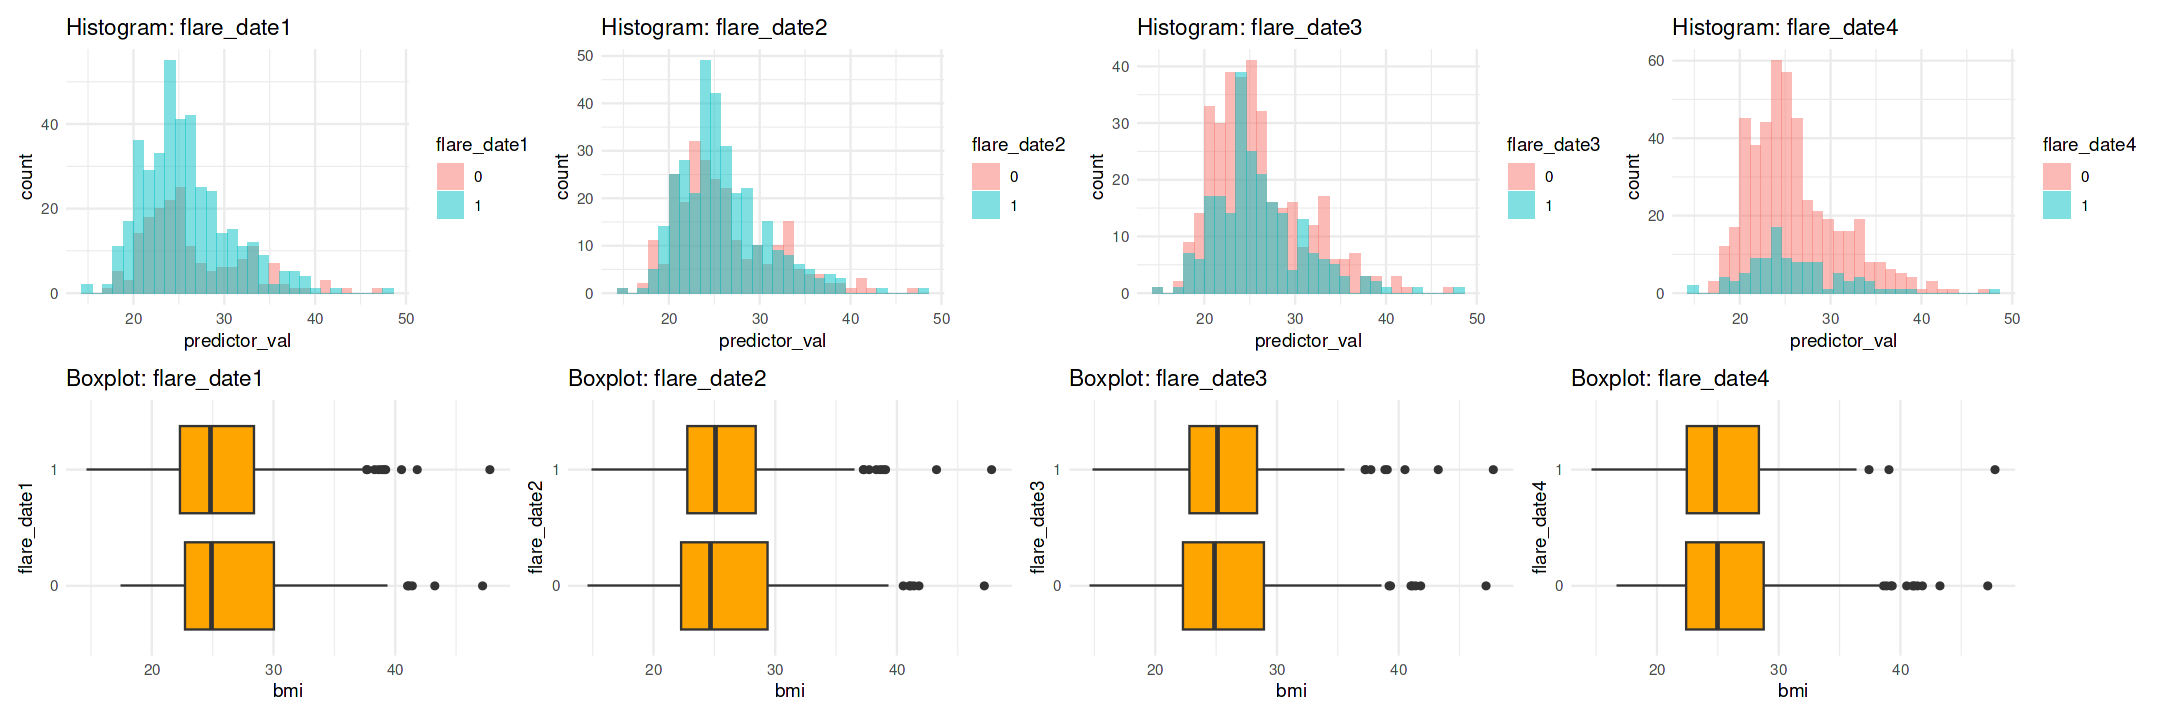

In [436]:
combined_dataset$bmi <- analyze_numeric_predictor(combined_dataset, "bmi", Process=TRUE)

In [437]:
analyze_binned_predictor <- function(df, predictor, flares = c("flare_date1", "flare_date2", "flare_date3", "flare_date4"), Process = FALSE) {
  cat("\n========== BINARY BINNING & CHI-SQUARED TEST FOR:", predictor, "==========\n")

  # Treat 9999 as NA
  x_raw <- df[[predictor]]
  x <- ifelse(x_raw == 9999, NA, x_raw)
  

  # Remove NAs for binning logic
  x_clean <- na.omit(x)
  
  # Calculate quantiles
  q <- quantile(x_clean, probs = c(0, 0.25, 0.5, 1), na.rm = TRUE)

  # Decide binning method and labels
  if (q[1] == q[2] && q[2] == q[3]) {
    cat("Note: Using mean for binning due to flat lower half\n")
    split_val <- mean(x_clean)#, probs = 0.75)
    bins <- c(min(x_clean), split_val, max(x_clean))
    labels <- c("<= mean", "> mean")
  } else {
    split_val <- q[3]  # median
    bins <- c(min(x_clean), split_val, max(x_clean))
    labels <- c("<= median", "> median")
  }

  x_binned <- cut(x, breaks = bins, include.lowest = TRUE, labels = labels)

  # Add "9999" level if there are NAs
  if (any(is.na(x_binned))) {
    x_binned <- addNA(x_binned)
    levels(x_binned)[is.na(levels(x_binned))] <- "9999"
    x_binned[is.na(x_binned)] <- "9999"
    x_binned <- factor(x_binned, levels = c(labels, "9999"))
  }


  # Run chi-squared tests
  results <- lapply(flares, function(flare) {
    y <- df[[flare]]
    tbl <- table(x_binned, y)
    test <- suppressWarnings(chisq.test(tbl))
    data.frame(
      Flare = flare,
      Chi_sq = round(test$statistic, 3),
      df = test$parameter,
      p_value = format.pval(test$p.value, digits = 4, eps = .0001),
      row.names = NULL
    )
  })

  if (Process) {
    return(x_binned)
  }

  invisible()

    cat("\n== Chi-squared Test Results by Flare Variable ==\n")
  do.call(rbind, results)
}


In [438]:
analyze_binned_predictor(combined_dataset, "bmi")


========== BINARY BINNING & CHI-SQUARED TEST FOR: bmi ==========

== Chi-squared Test Results by Flare Variable ==


Flare       Chi_sq df p_value
1 flare_date1 0.000  1  1      
2 flare_date2 0.517  1  0.4723 
3 flare_date3 0.084  1  0.7722 
4 flare_date4 0.039  1  0.843


========== ANALYSIS FOR: age_at_inclusion ==========


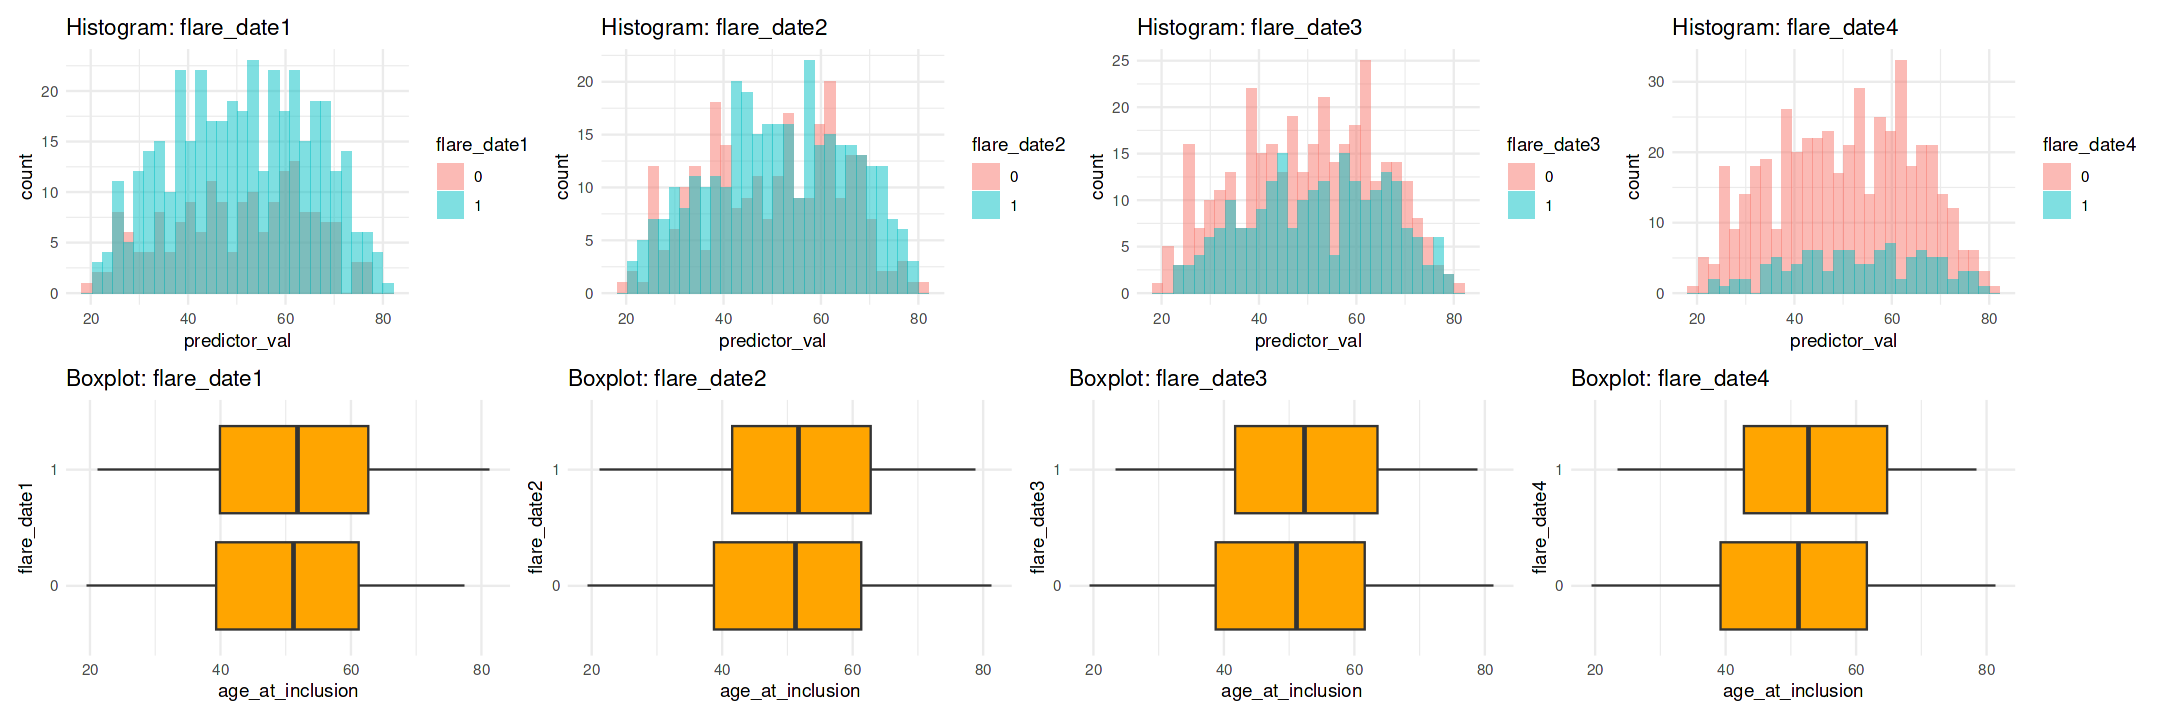

In [439]:
combined_dataset$age_at_inclusion <-analyze_numeric_predictor(combined_dataset, "age_at_inclusion", Process=TRUE)


========== ANALYSIS FOR: montreal_age_diagnosis_uc ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 -0.022  62.6 0.9822 
2 flare_date2 -1.312 117.4 0.1922 
3 flare_date3 -1.910 194.8 0.0576 
4 flare_date4 -1.105  83.1 0.2722


========== BINARY BINNING & CHI-SQUARED TEST FOR: montreal_age_diagnosis_uc ==========


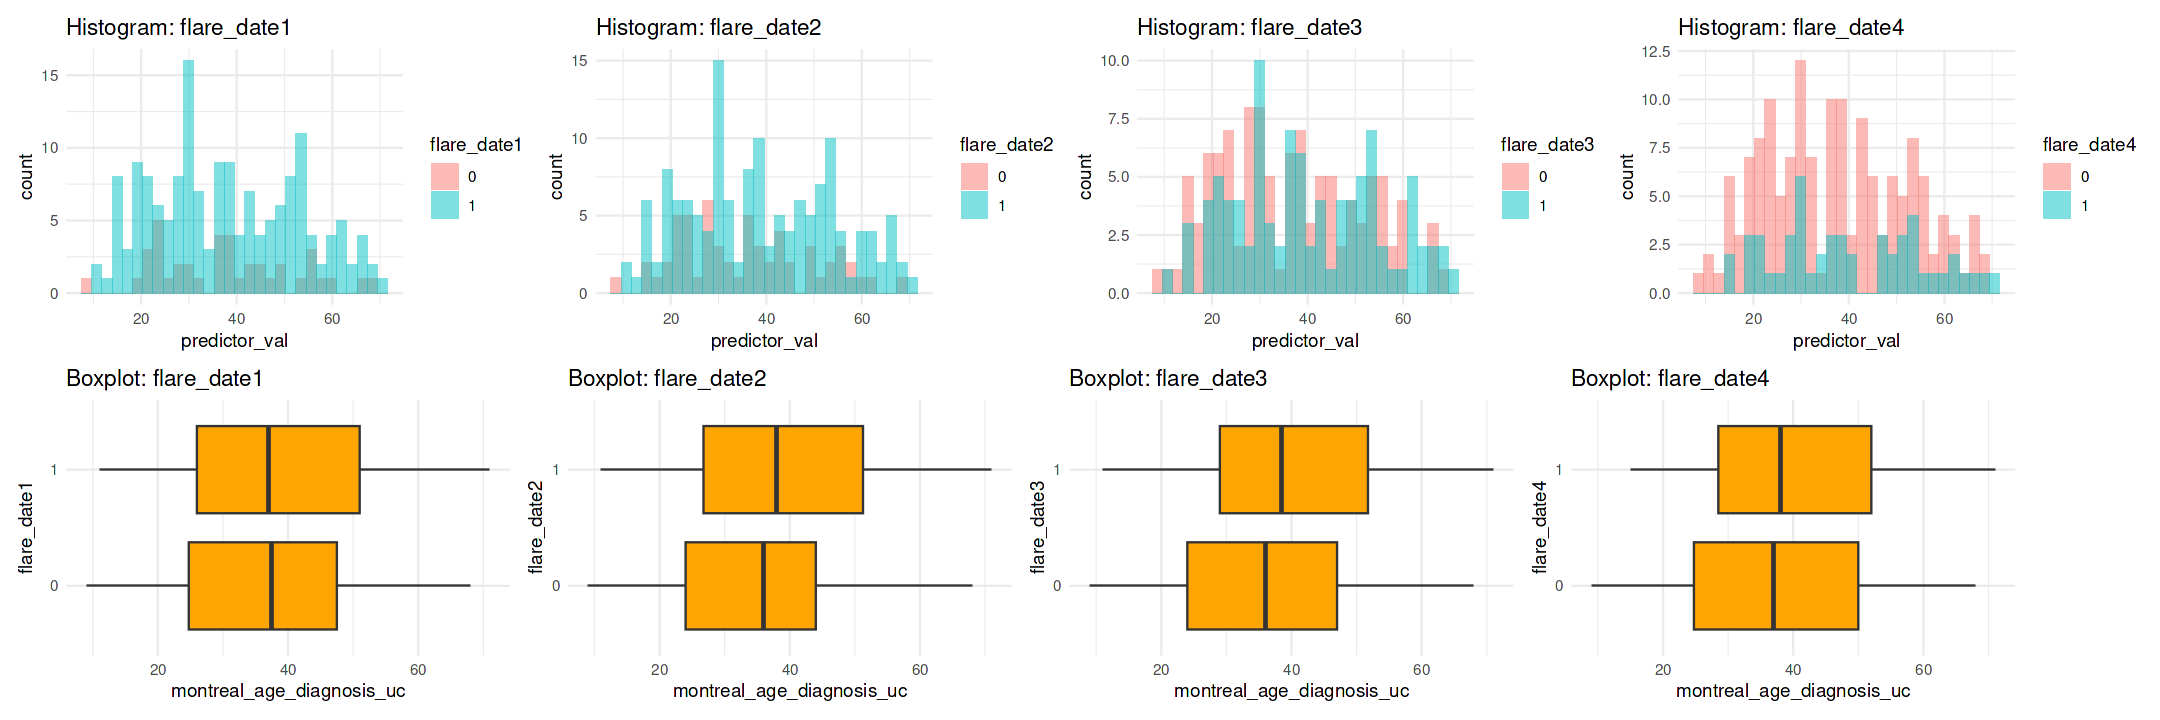

In [440]:
analyze_numeric_predictor(combined_dataset, "montreal_age_diagnosis_uc", Process=F)
combined_dataset$montreal_age_diagnosis_uc <- analyze_binned_predictor(combined_dataset, "montreal_age_diagnosis_uc", Process = T)


In [441]:

combined_dataset$number_of_surgeries <- cut(combined_dataset$number_of_surgeries,
                  breaks = c(-Inf, 1, Inf),
                  labels = c("<= 1", "> 1"),
                  right = TRUE)

In [442]:
chisq.test(table(combined_dataset$flare_date1,combined_dataset$number_of_surgeries ))
chisq.test(table(combined_dataset$flare_date2,combined_dataset$number_of_surgeries ))
chisq.test(table(combined_dataset$flare_date3,combined_dataset$number_of_surgeries ))
chisq.test(table(combined_dataset$flare_date4,combined_dataset$number_of_surgeries ))


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(combined_dataset$flare_date1, combined_dataset$number_of_surgeries)
X-squared = 11.21, df = 1, p-value = 0.0008135



	Pearson's Chi-squared test with Yates' continuity correction

data:  table(combined_dataset$flare_date2, combined_dataset$number_of_surgeries)
X-squared = 6.5734, df = 1, p-value = 0.01035



	Pearson's Chi-squared test with Yates' continuity correction

data:  table(combined_dataset$flare_date3, combined_dataset$number_of_surgeries)
X-squared = 2.2864, df = 1, p-value = 0.1305



	Pearson's Chi-squared test with Yates' continuity correction

data:  table(combined_dataset$flare_date4, combined_dataset$number_of_surgeries)
X-squared = 1.6488, df = 1, p-value = 0.1991



========== ANALYSIS FOR: age_at_surg_colon_resection ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 -1.301 465.0 0.1938 
2 flare_date2  0.327 491.3 0.7434 
3 flare_date3  1.014 566.1 0.3111 
4 flare_date4 -0.038 142.7 0.97

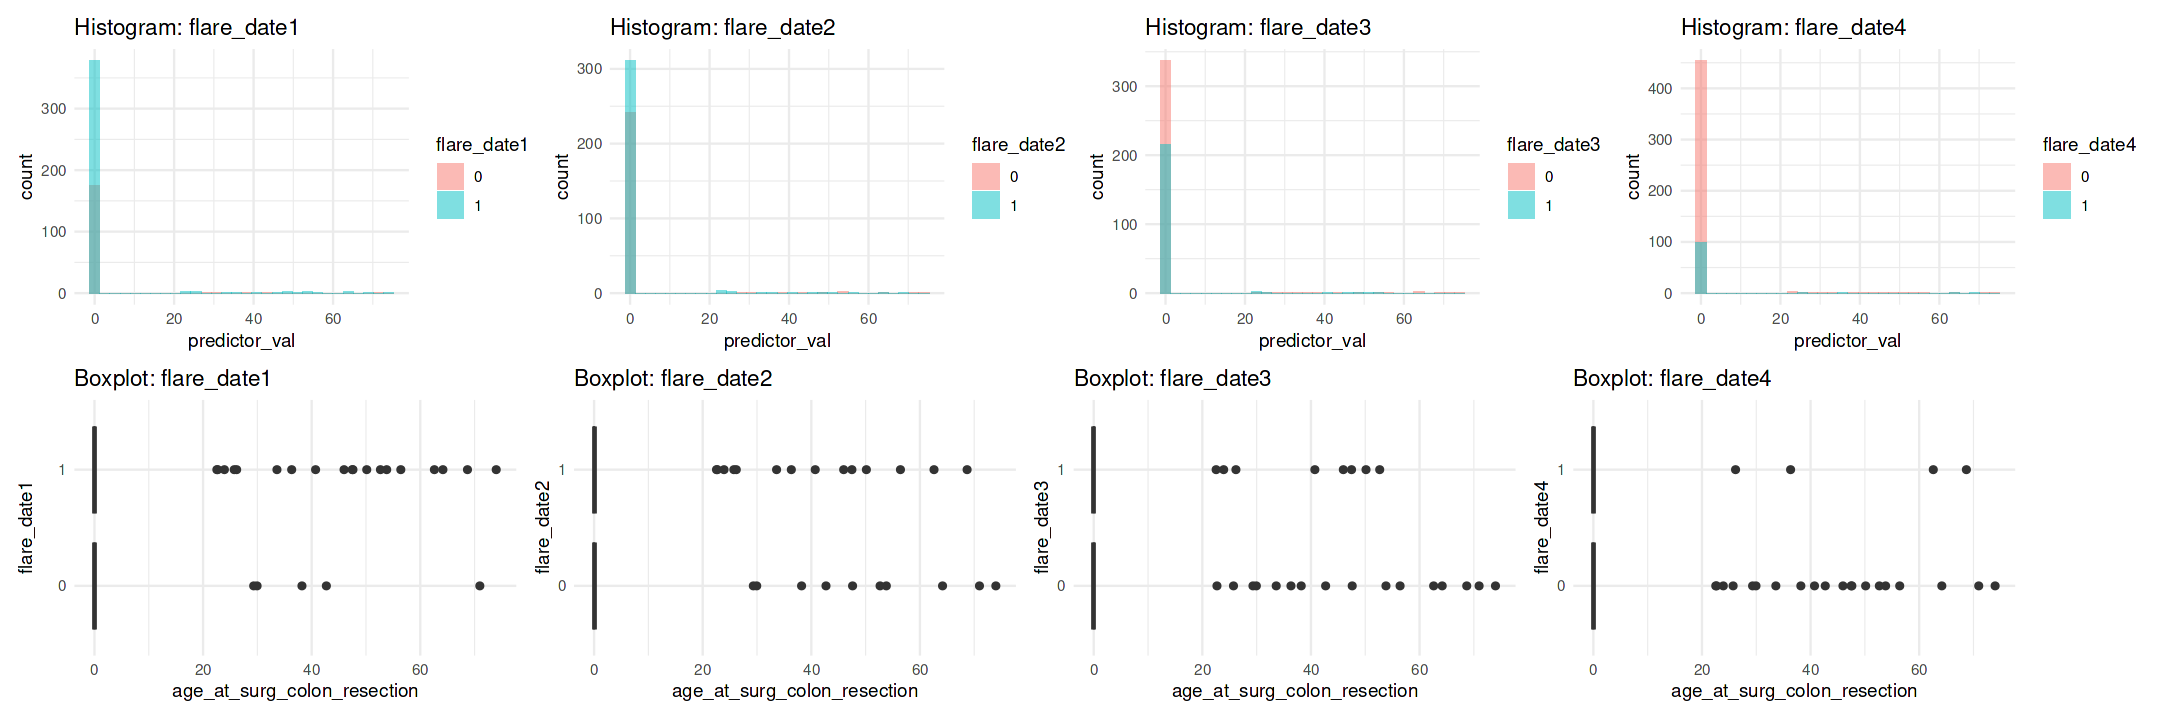

In [443]:
analyze_numeric_predictor(combined_dataset, "age_at_surg_colon_resection",Process=F)



========== ANALYSIS FOR: age_at_surg_subtotal_colectomy ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 -0.290 403.2 0.7723 
2 flare_date2  0.559 550.4 0.5764 
3 flare_date3 -0.346 387.6 0.7295 
4 flare_date4 -0.177 147.9 0.8597

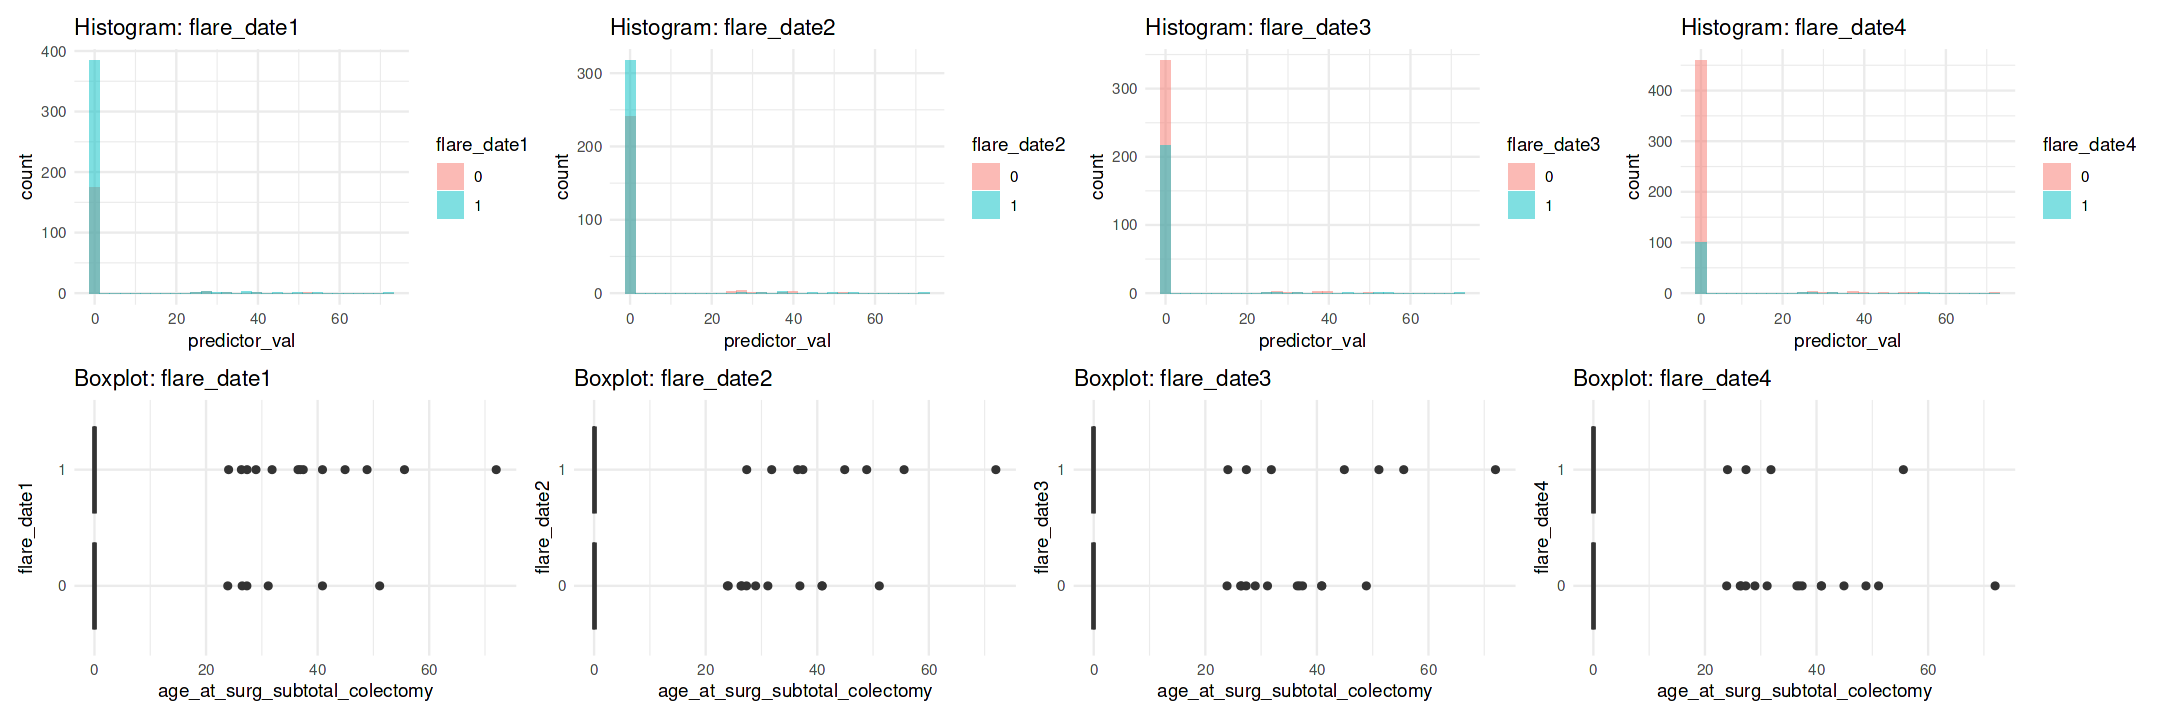

In [444]:
analyze_numeric_predictor(combined_dataset, "age_at_surg_subtotal_colectomy",Process=F)



========== ANALYSIS FOR: age_at_surg_fistula_abcess ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1  0.731 330.4 0.4652 
2 flare_date2  0.259 538.5 0.796  
3 flare_date3 -0.320 453.9 0.7491 
4 flare_date4  1.045 169.2 0.2975

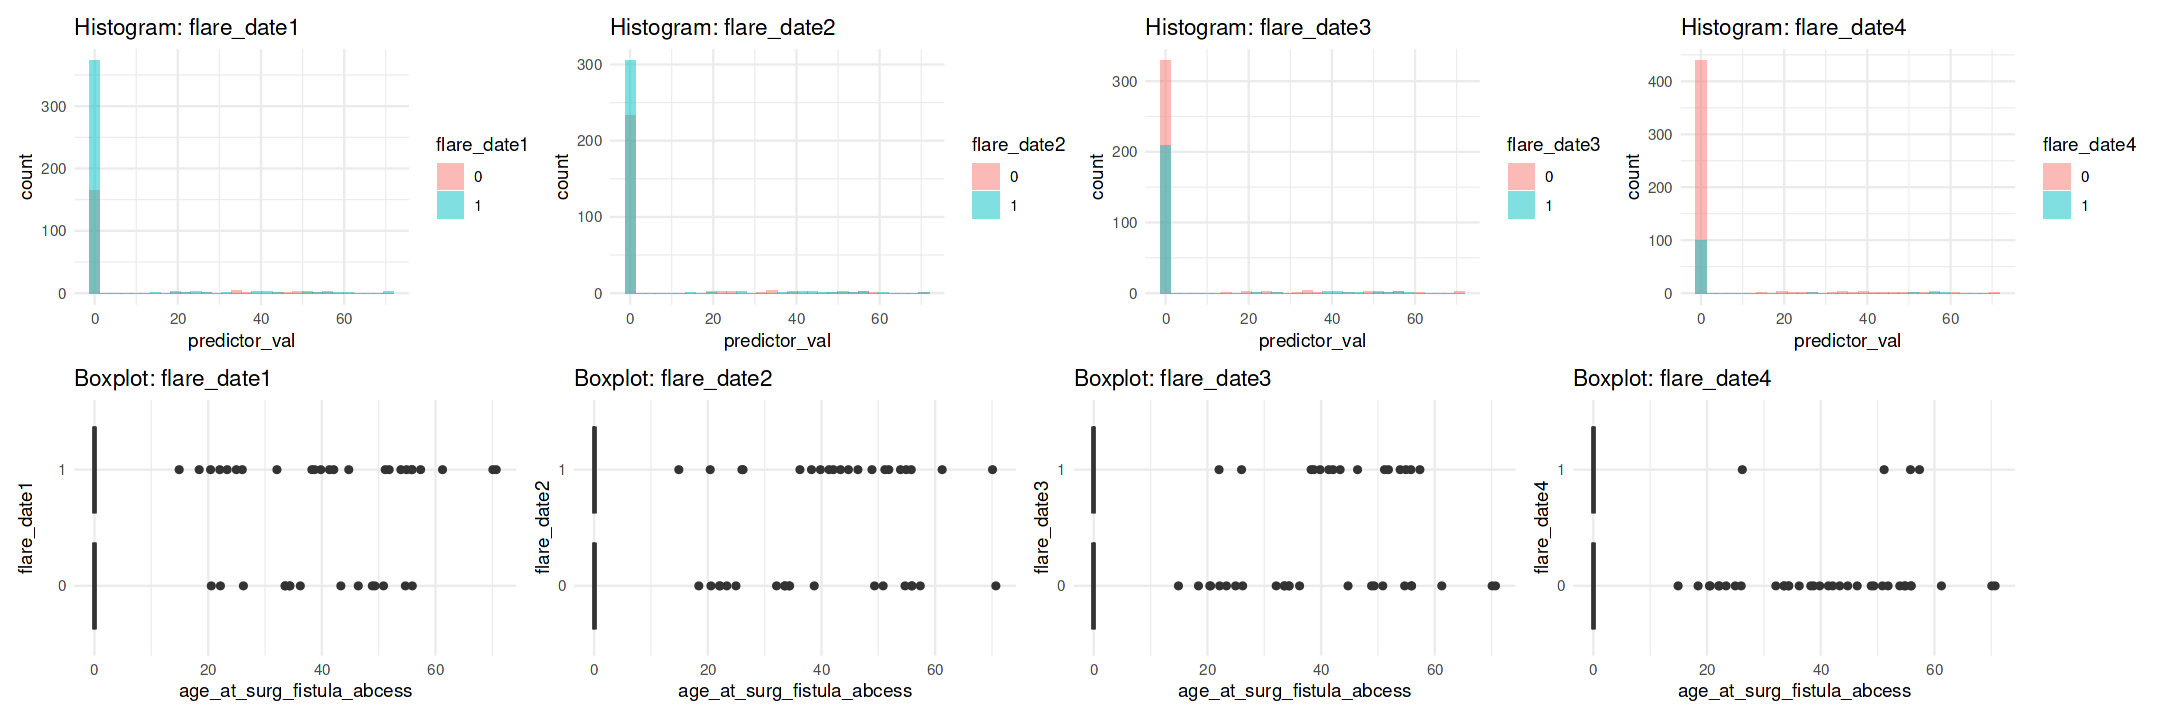

In [445]:
analyze_numeric_predictor(combined_dataset, "age_at_surg_fistula_abcess",Process=F)



========== ANALYSIS FOR: age_at_surg_ileo_anal_pouch ==========


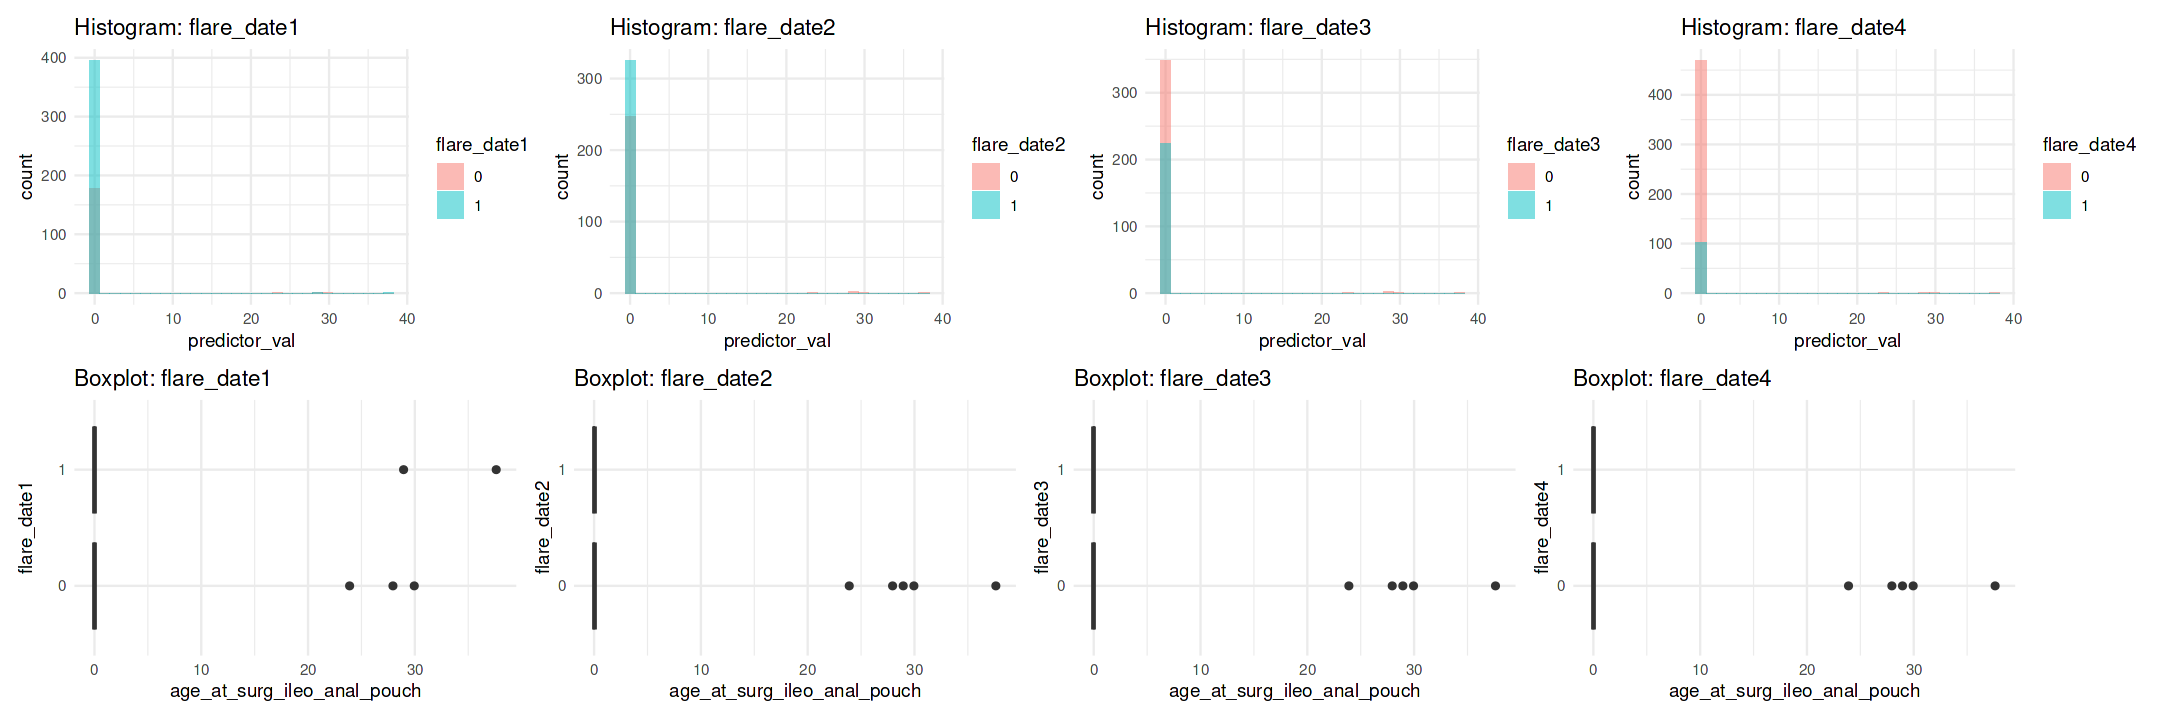

In [446]:
combined_dataset$age_at_surg_ileo_anal_pouch <- 
                analyze_numeric_predictor(combined_dataset, "age_at_surg_ileo_anal_pouch",Process=T)



========== ANALYSIS FOR: age_at_surg_small_bowel_resection ==========


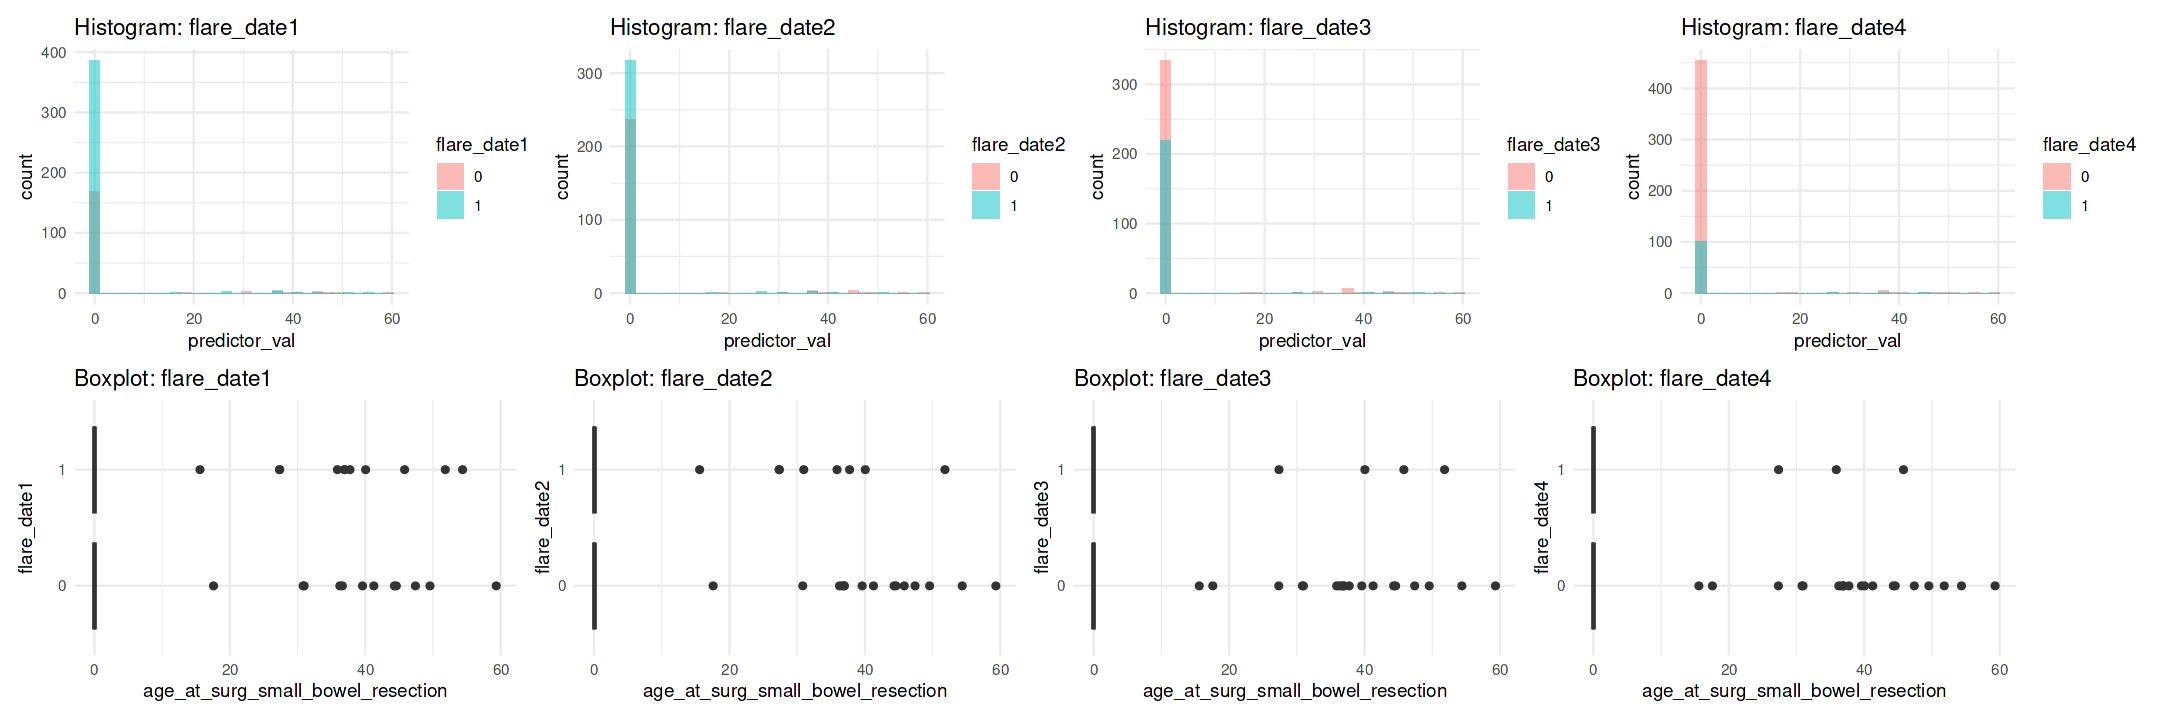

In [447]:
combined_dataset$age_at_surg_small_bowel_resection <- 
                analyze_numeric_predictor(combined_dataset, "age_at_surg_small_bowel_resection", Process= T)


========== ANALYSIS FOR: age_at_surg_ileocaecal_resection ==========


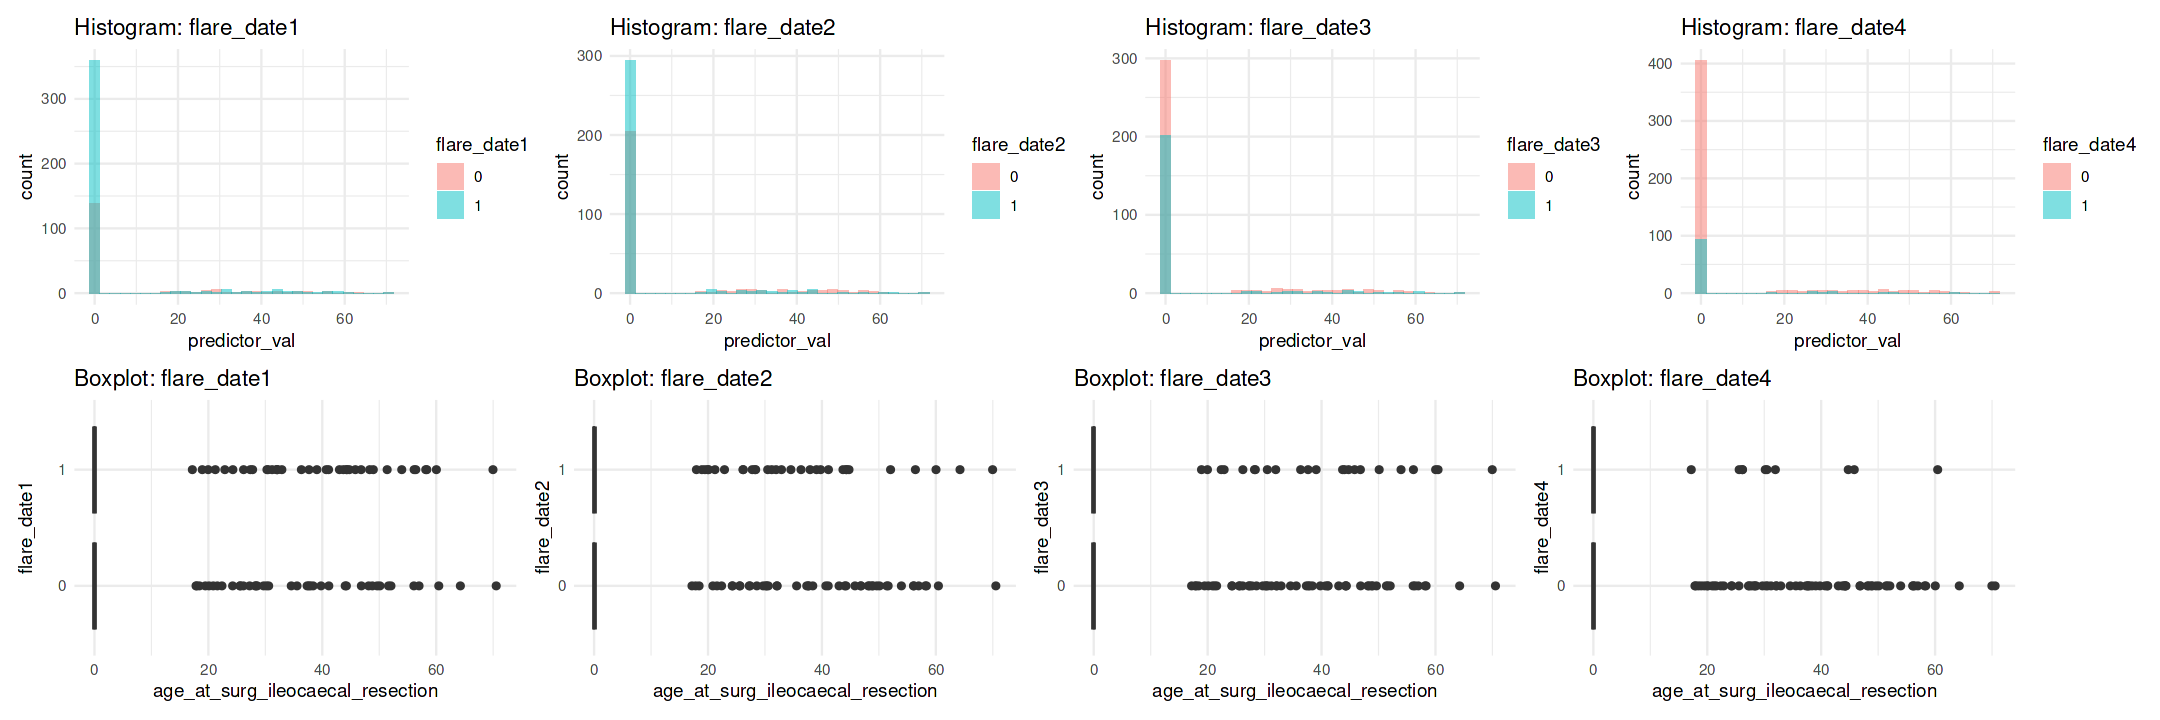

In [448]:
combined_dataset$age_at_surg_ileocaecal_resection <- analyze_numeric_predictor(combined_dataset, "age_at_surg_ileocaecal_resection", Process= T)


========== ANALYSIS FOR: age_at_surg_small_bowel_stoma ==========


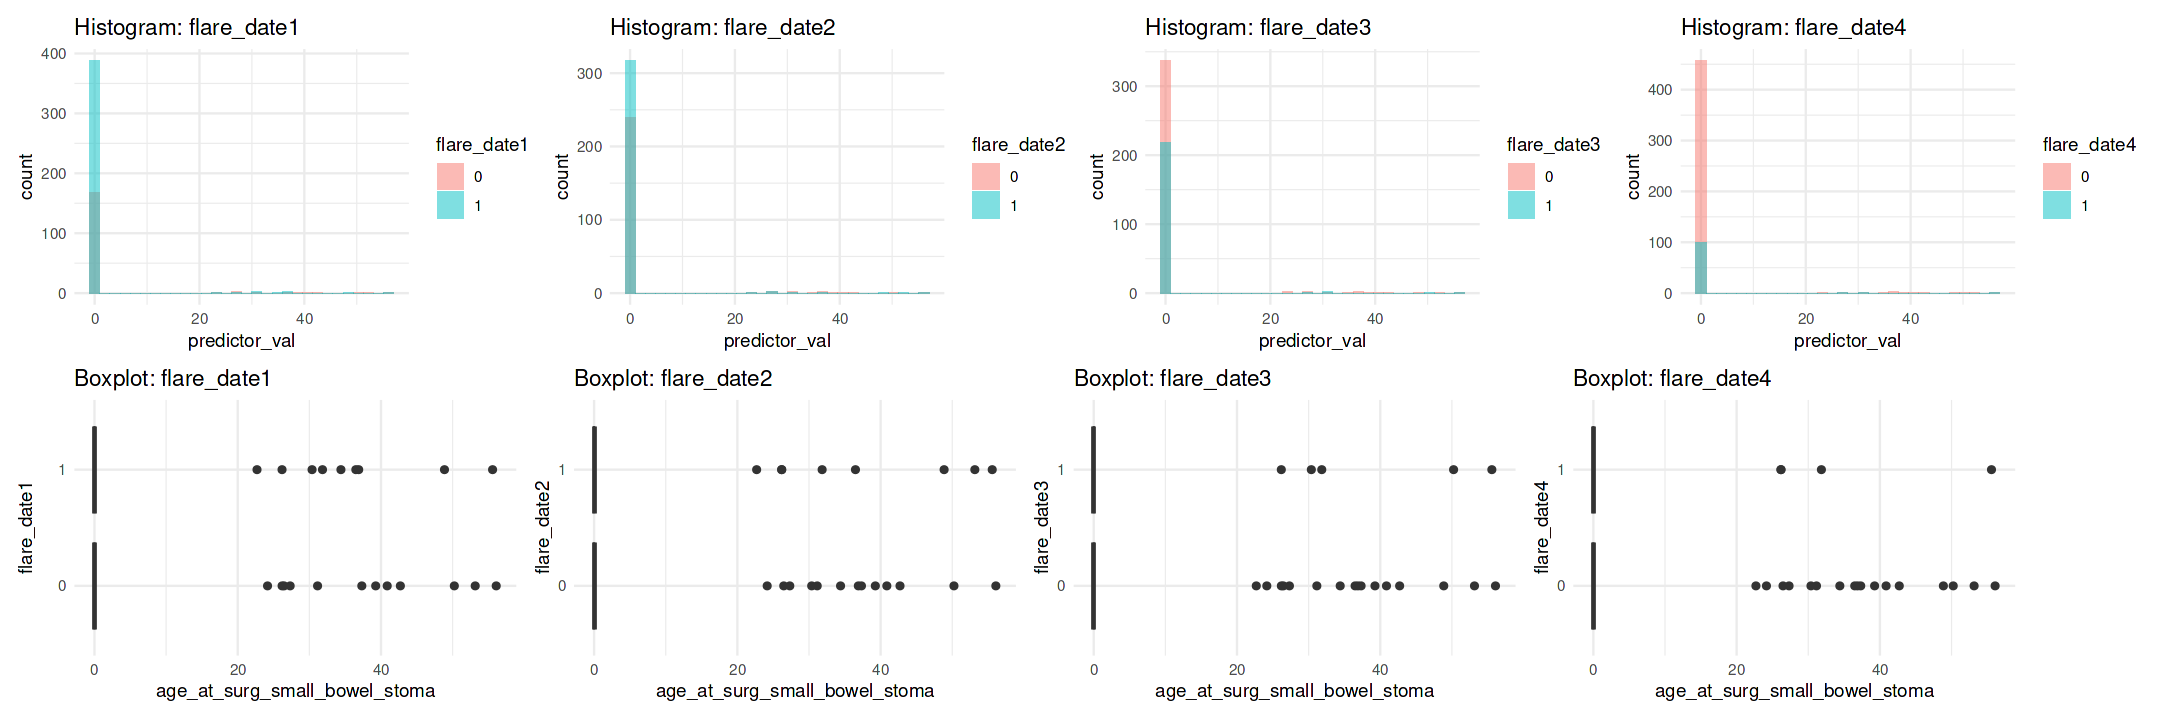

In [449]:
combined_dataset$age_at_surg_small_bowel_stoma <-
analyze_numeric_predictor(combined_dataset, "age_at_surg_small_bowel_stoma", Process=T)


========== ANALYSIS FOR: age_at_surg_colostoma ==========


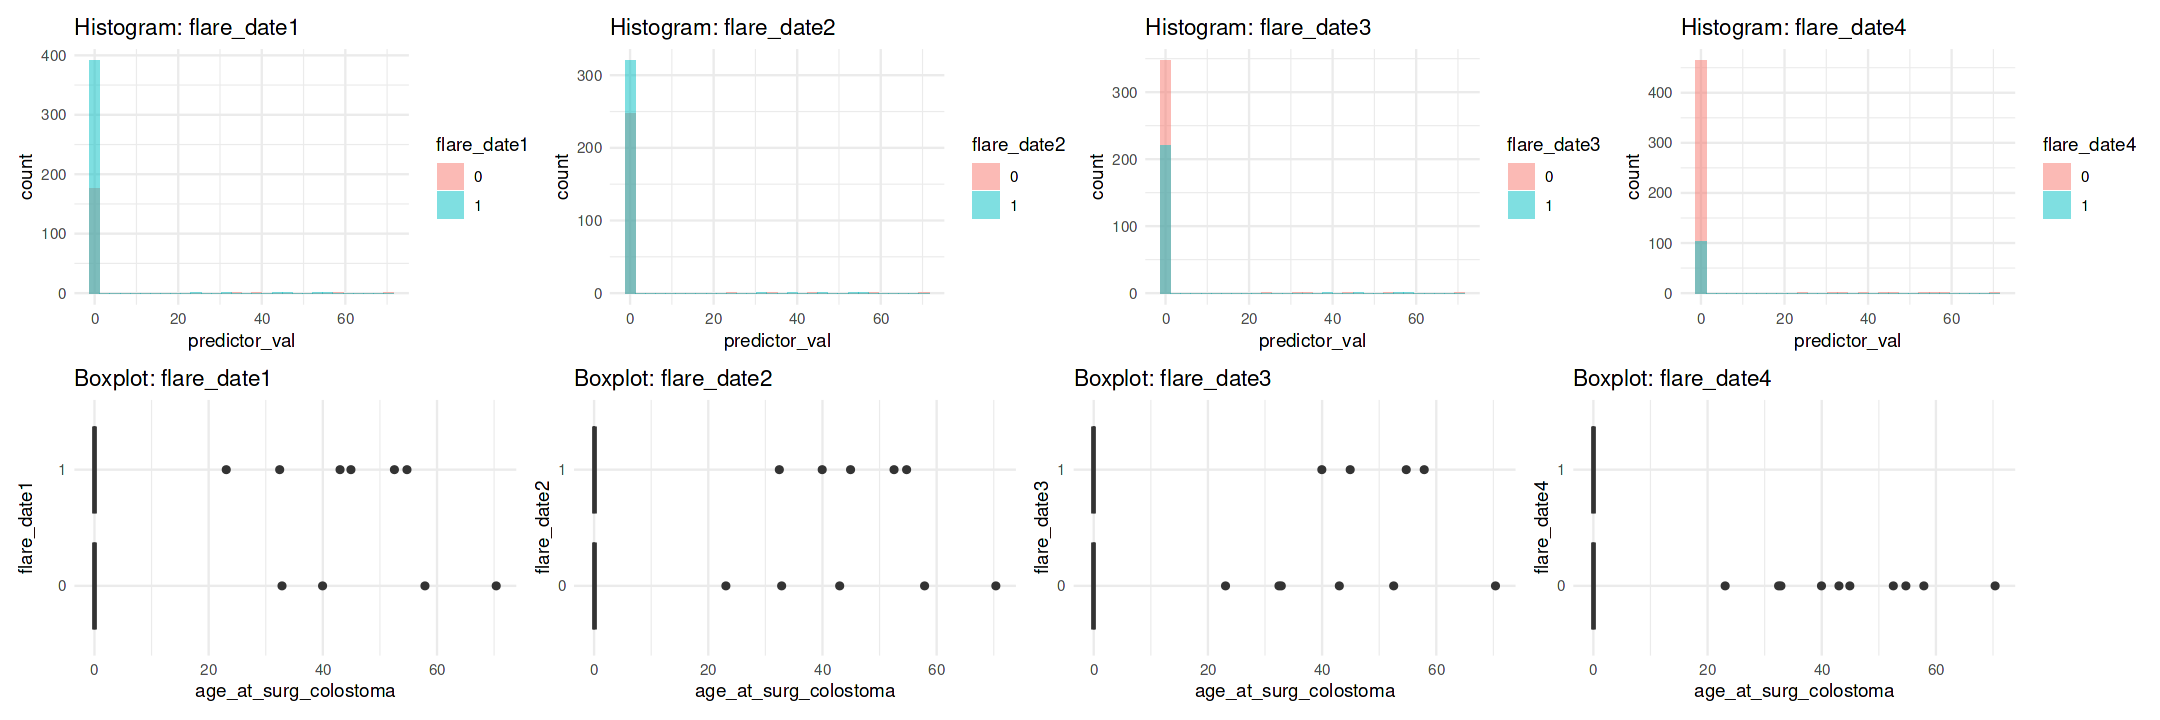

In [450]:
combined_dataset$age_at_surg_colostoma <- analyze_numeric_predictor(combined_dataset, "age_at_surg_colostoma", Process =T)


========== ANALYSIS FOR: age_at_surg_proctocolectomy ==========

== T-test Results ==


Dependent   t_stat df  p_value
1 flare_date1 0.641  218 0.5223 
2 flare_date2 1.398  251 0.1632 
3 flare_date3 1.398  352 0.1631 
4 flare_date4 1.397  473 0.163

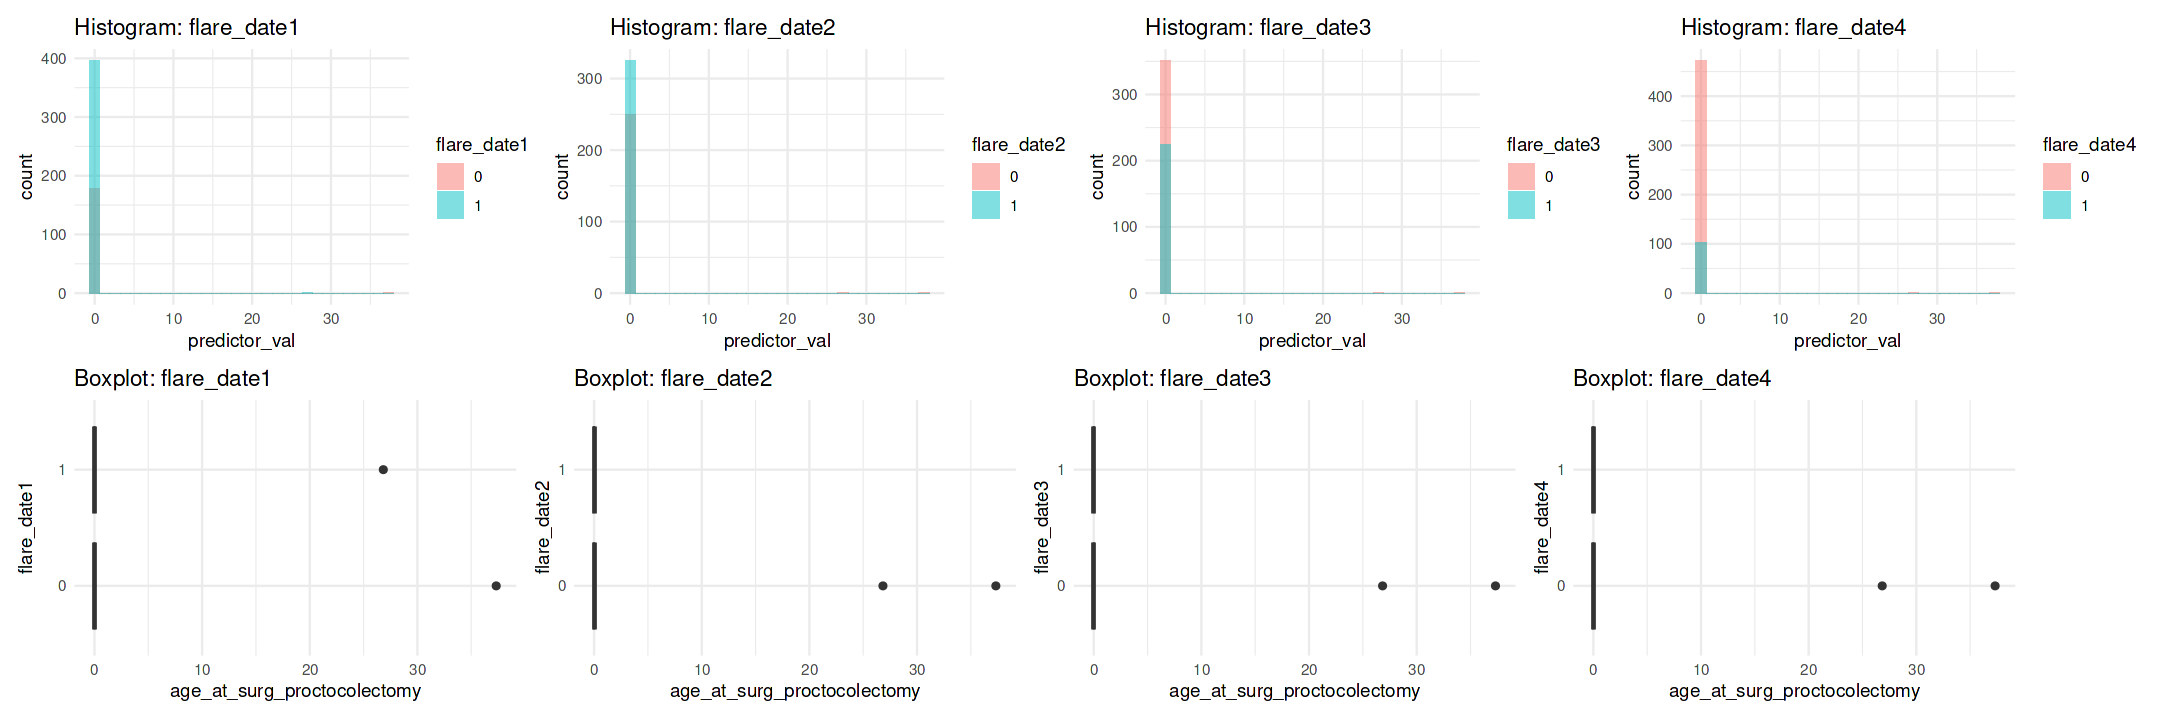

In [451]:
analyze_numeric_predictor(combined_dataset, "age_at_surg_proctocolectomy")


========== ANALYSIS FOR: age_at_surg_stoma_reversal ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1  1.430 261.6 0.1539 
2 flare_date2  1.524 425.1 0.1282 
3 flare_date3  0.148 448.4 0.882  
4 flare_date4 -0.350 141.9 0.7266

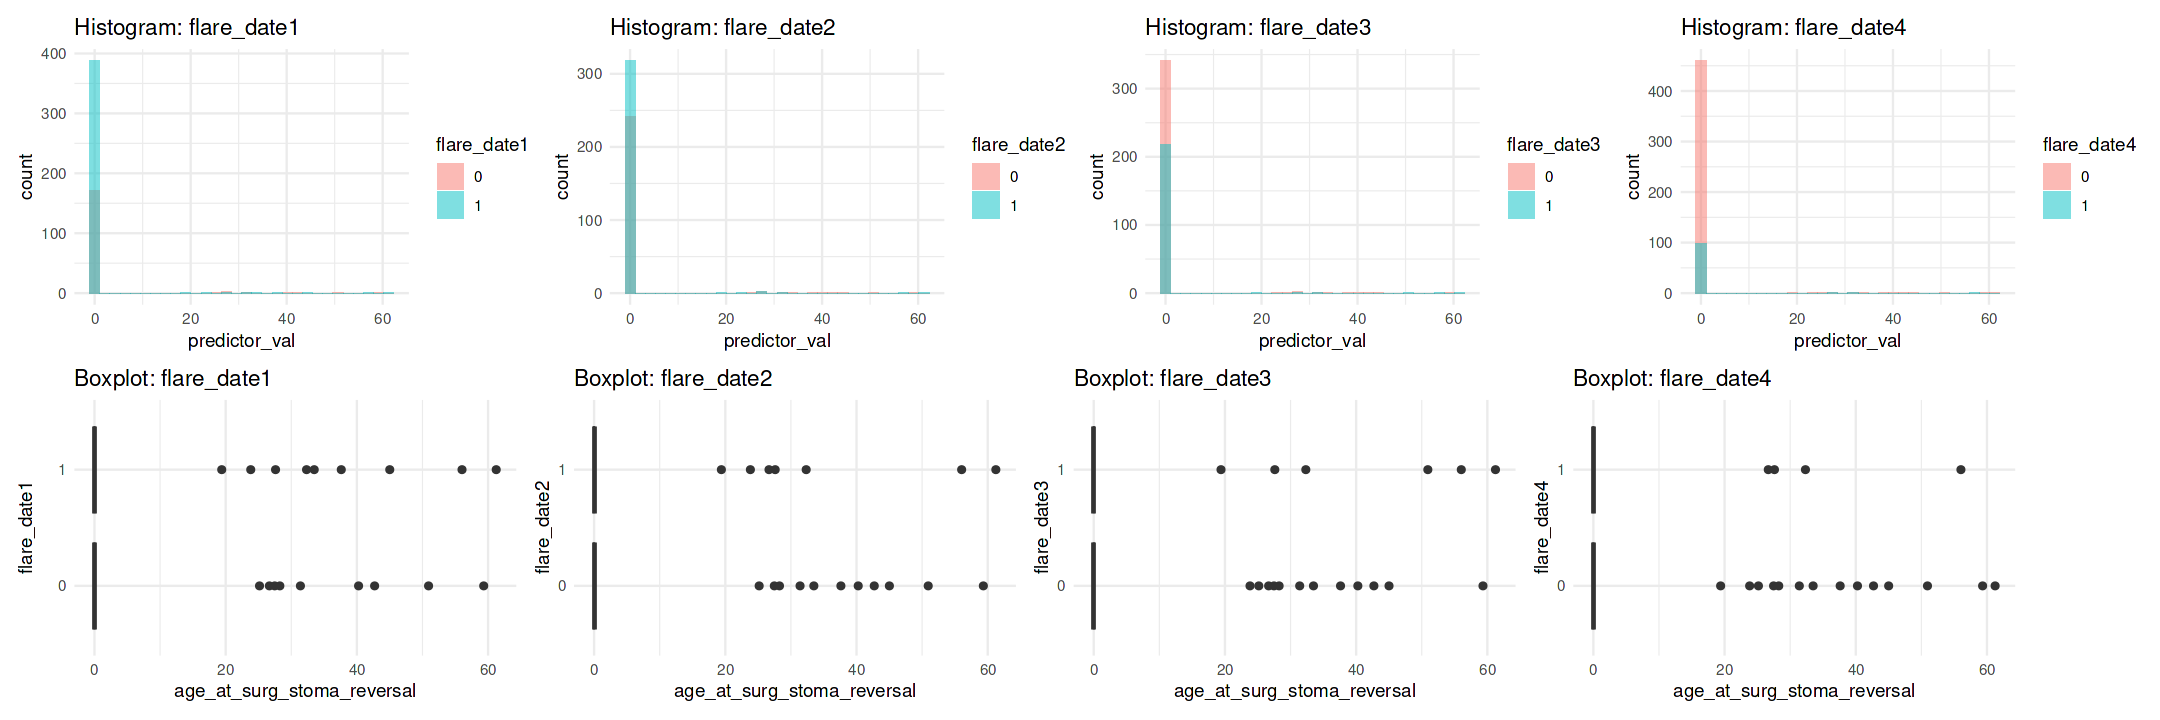

In [452]:
analyze_numeric_predictor(combined_dataset, "age_at_surg_stoma_reversal")


========== ANALYSIS FOR: age_at_surg_proctectomy ==========

== T-test Results ==


Dependent   t_stat df  p_value
1 flare_date1 0.519  249 0.6045 
2 flare_date2 1.417  251 0.1578 
3 flare_date3 1.416  352 0.1577 
4 flare_date4 1.415  473 0.1576

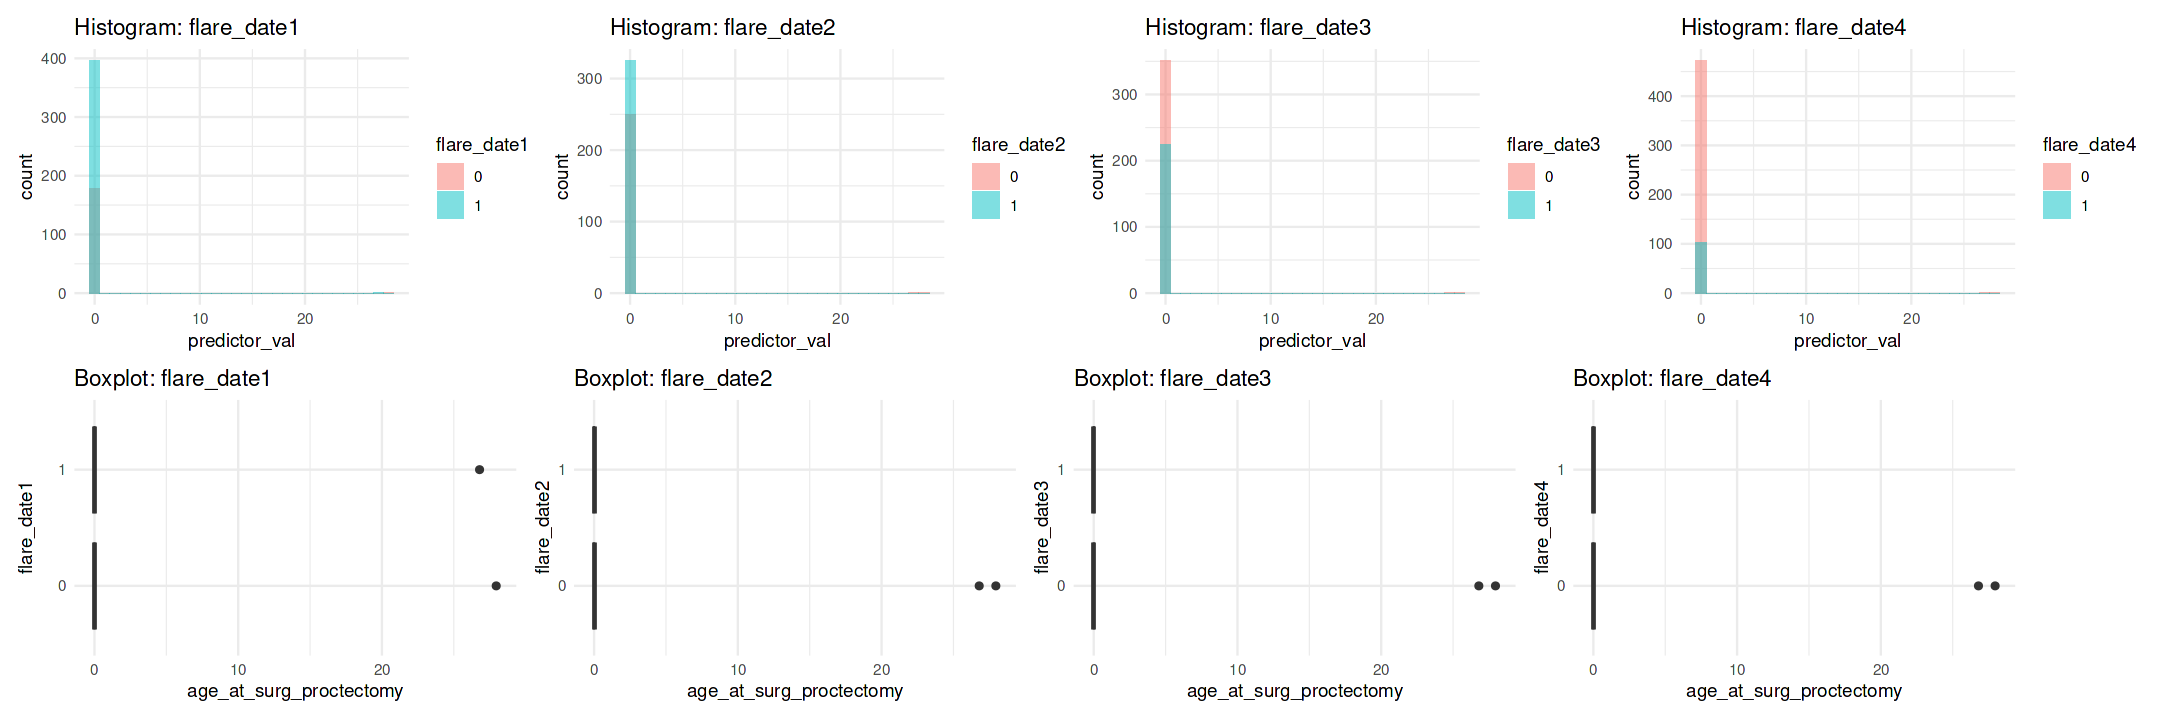

In [453]:
analyze_numeric_predictor(combined_dataset, "age_at_surg_proctectomy")


========== ANALYSIS FOR: age_at_surg_stenoplasty ==========


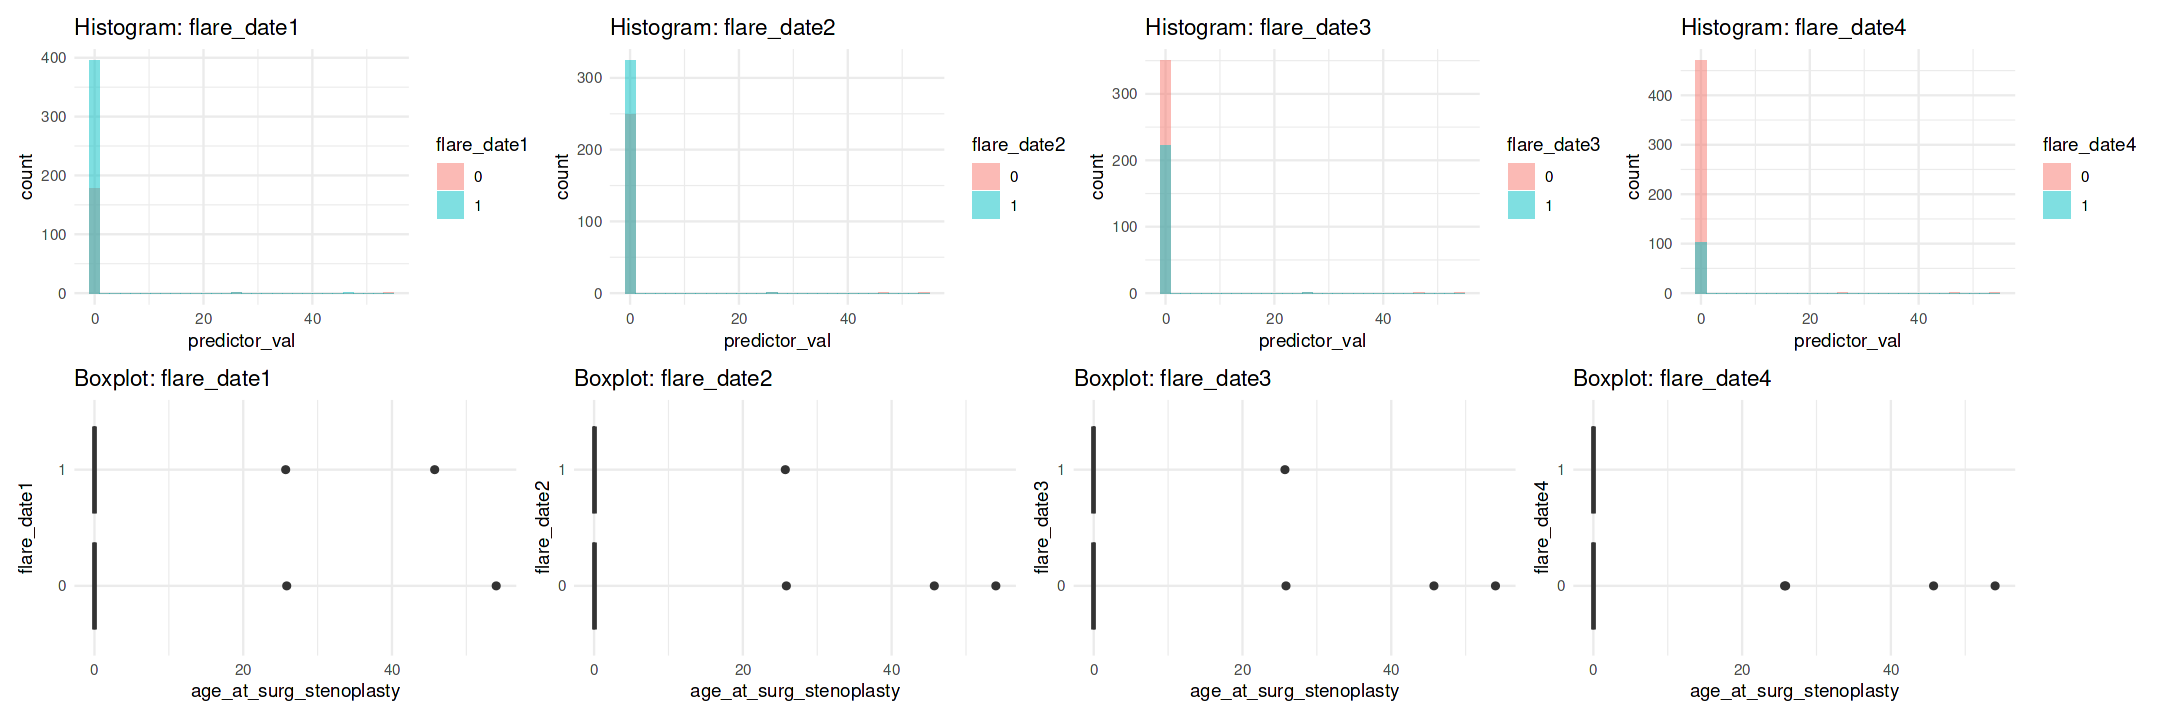

In [454]:
combined_dataset$age_at_surg_stenoplasty <- analyze_numeric_predictor(combined_dataset, "age_at_surg_stenoplasty",Process=T)


========== ANALYSIS FOR: Anxious_mean ==========


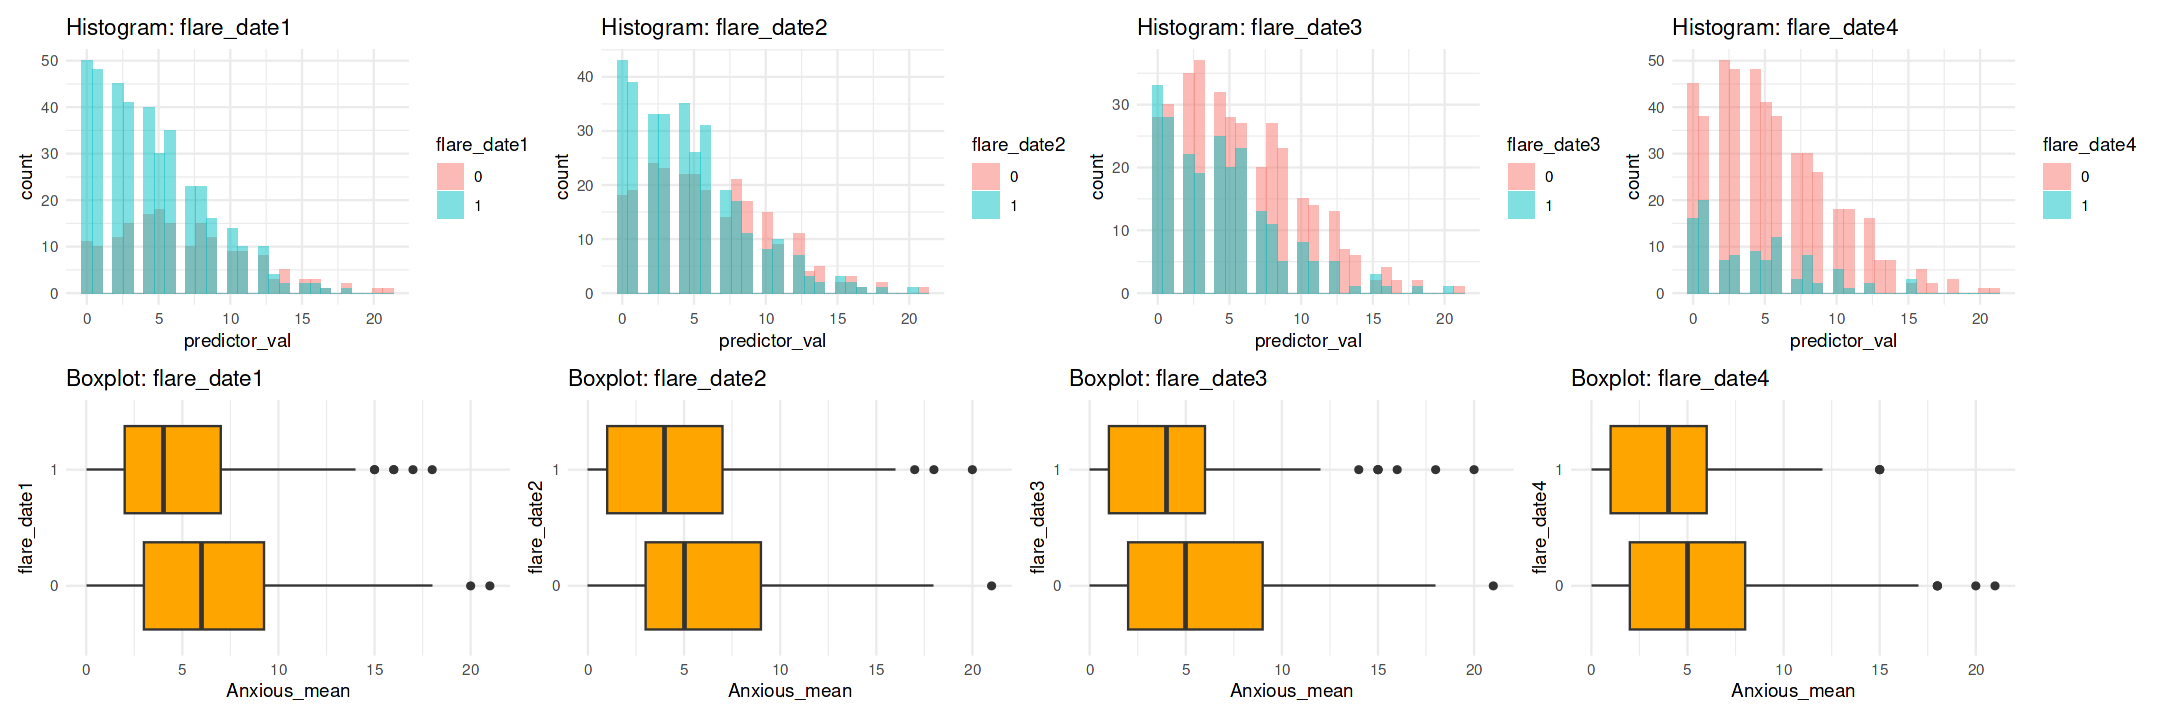

In [455]:
combined_dataset$Anxious_mean <- analyze_numeric_predictor(combined_dataset, "Anxious_mean", Process=T)

In [456]:
#combined_dataset$Anxious_mean <- cut(combined_dataset$Anxious_mean,
#                  breaks = c(-Inf, 1, Inf),
#                  labels = c("<= 1", "> 1"),
#                  right = TRUE)
#chisq.test(table(combined_dataset$flare_date1,combined_dataset$Anxious_mean ))
#chisq.test(table(combined_dataset$flare_date2,combined_dataset$Anxious_mean ))
#chisq.test(table(combined_dataset$flare_date3,combined_dataset$Anxious_mean ))
#chisq.test(table(combined_dataset$flare_date4,combined_dataset$Anxious_mean ))


========== ANALYSIS FOR: Depression_mean ==========


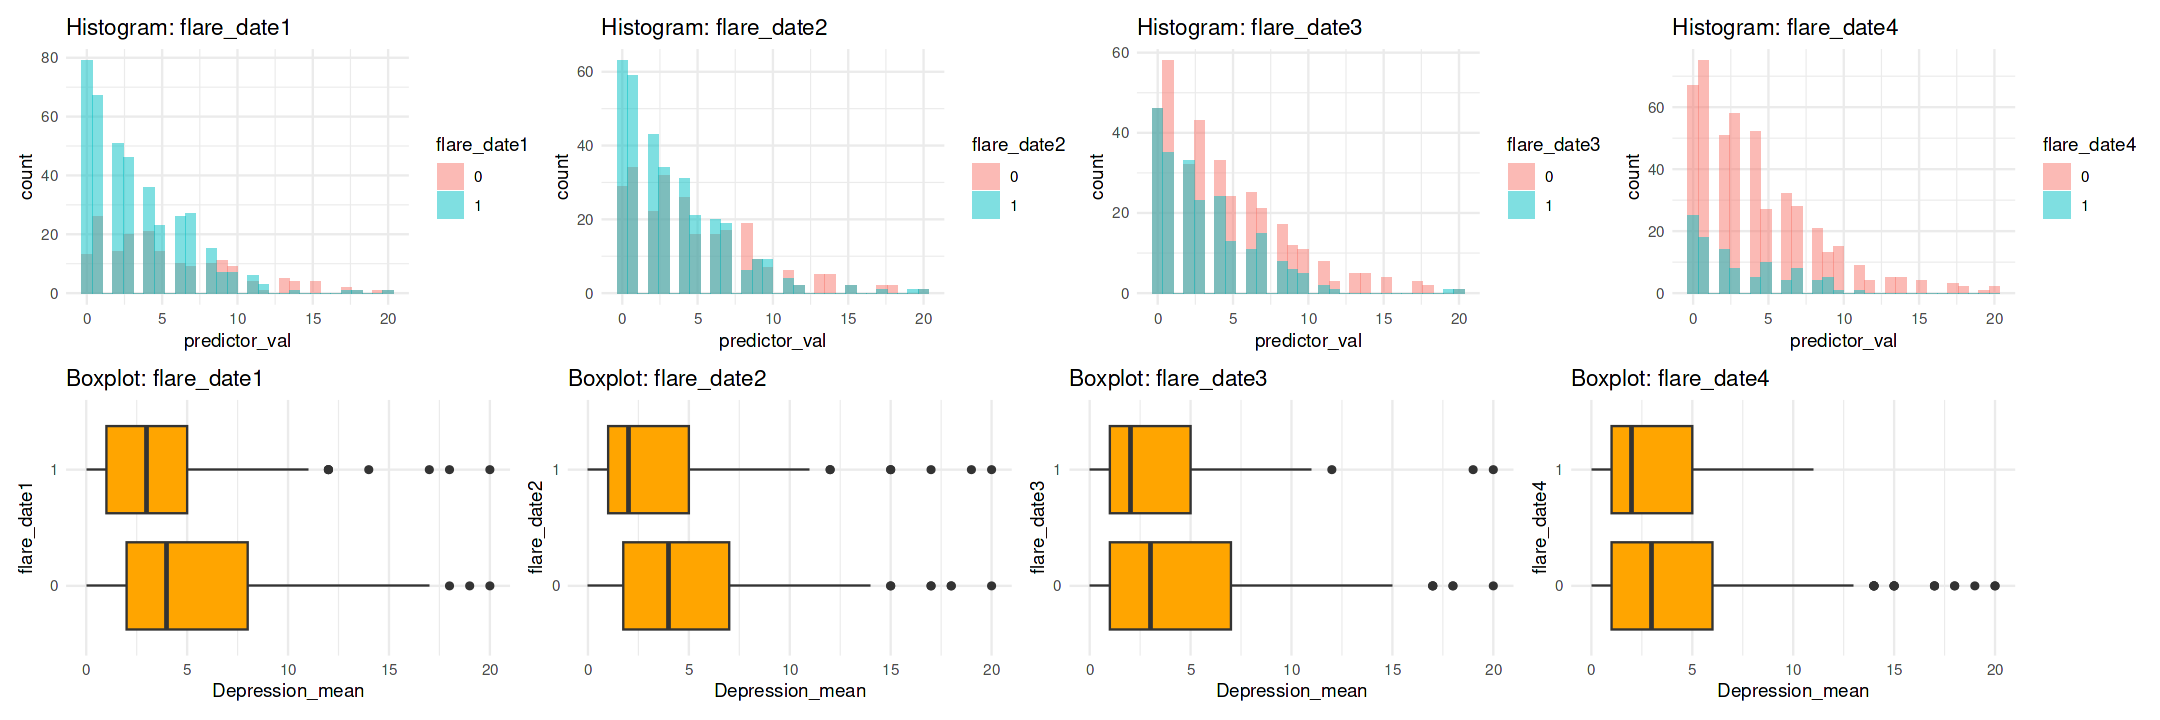

In [457]:
combined_dataset$Depression_mean <- analyze_numeric_predictor(combined_dataset, "Depression_mean", Process=T)

In [458]:
#combined_dataset$Depression_mean <- cut(combined_dataset$Depression_mean,
#                  breaks = c(-Inf, 1, Inf),
#                  labels = c("<= 1", "> 1"),
#                  right = TRUE)
#chisq.test(table(combined_dataset$flare_date1,combined_dataset$Depression_mean ))
#chisq.test(table(combined_dataset$flare_date2,combined_dataset$Depression_mean ))
#chisq.test(table(combined_dataset$flare_date3,combined_dataset$Depression_mean ))
#chisq.test(table(combined_dataset$flare_date4,combined_dataset$Depression_mean ))


========== ANALYSIS FOR: Fatigue_mean ==========


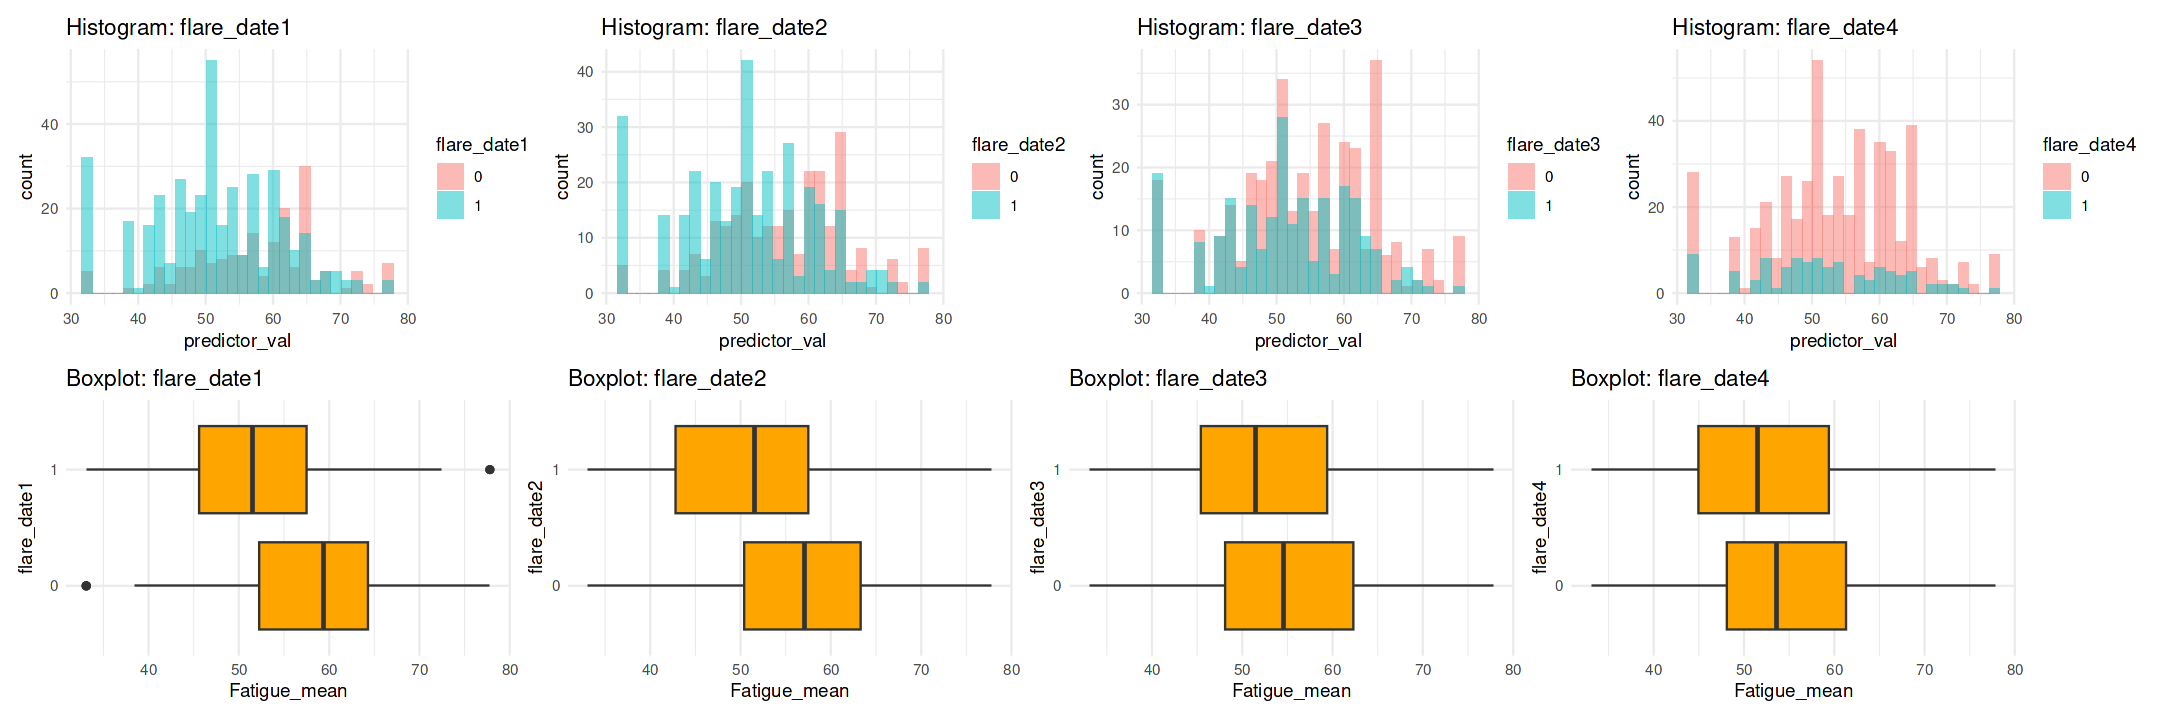

In [459]:
combined_dataset$Fatigue_mean <- analyze_numeric_predictor(combined_dataset, "Fatigue_mean", Process=T)

In [460]:
#combined_dataset$Fatigue_mean <- cut(combined_dataset$Fatigue_mean,
#                  breaks = c(-Inf, 49, Inf),
#                  labels = c("<= 49", "> 49"),
#                  right = TRUE)
#chisq.test(table(combined_dataset$flare_date1,combined_dataset$Fatigue_mean ))
#chisq.test(table(combined_dataset$flare_date2,combined_dataset$Fatigue_mean ))
#chisq.test(table(combined_dataset$flare_date3,combined_dataset$Fatigue_mean ))
#chisq.test(table(combined_dataset$flare_date4,combined_dataset$Fatigue_mean ))


========== ANALYSIS FOR: MIAH_pain_mean ==========


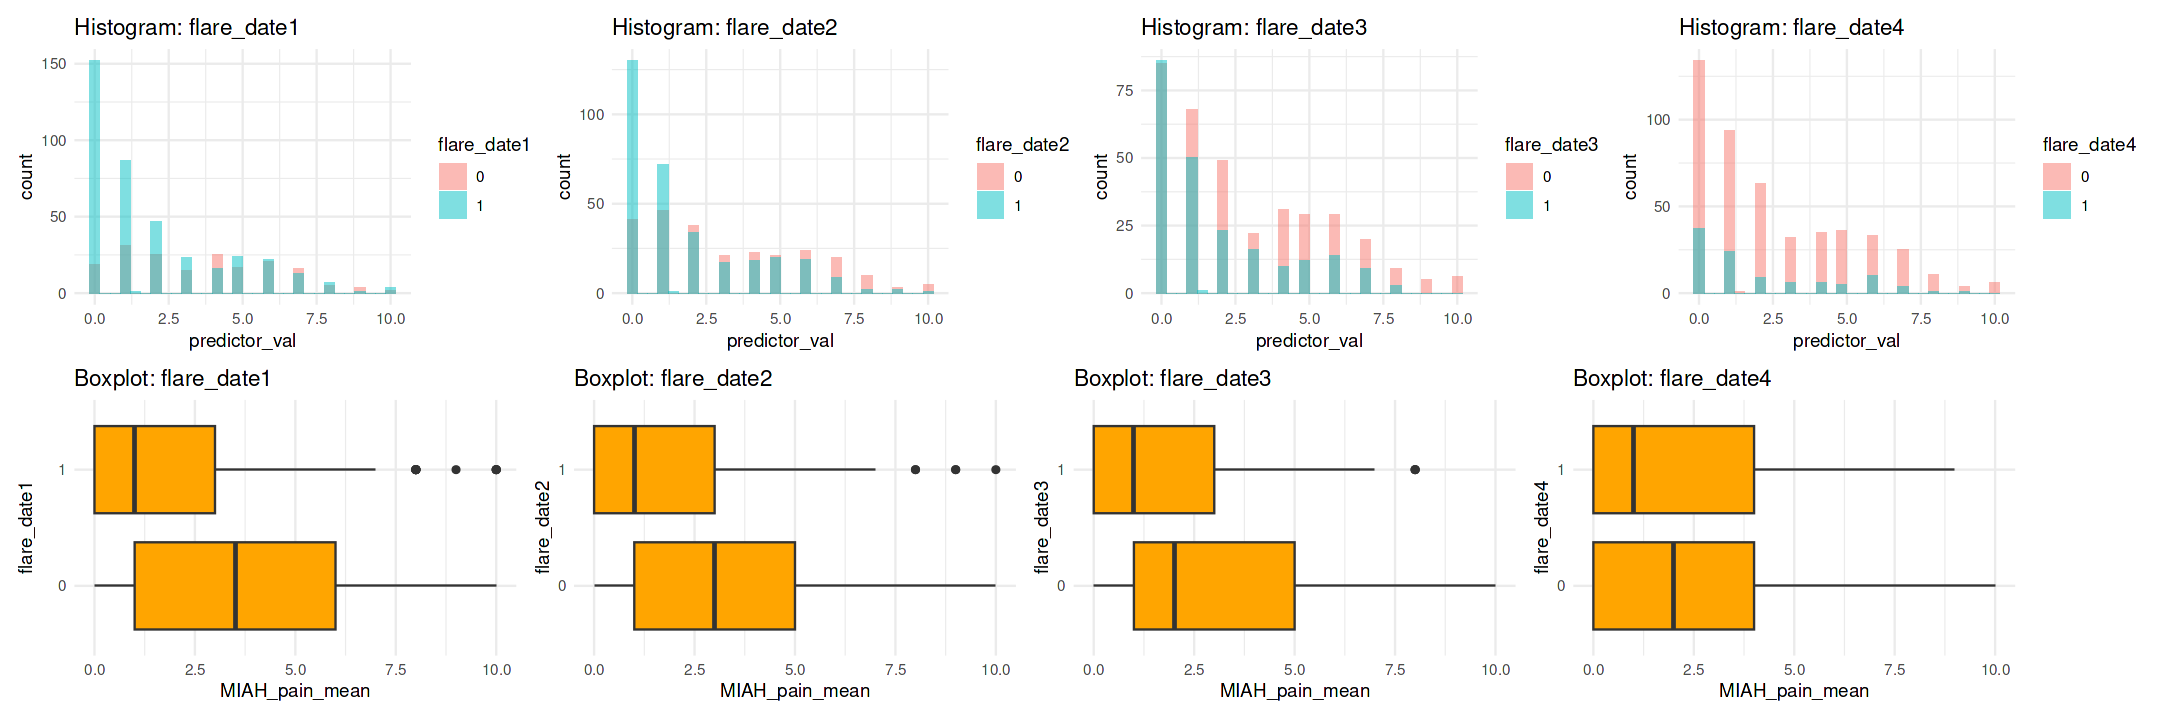

In [461]:
combined_dataset$MIAH_pain_mean <- analyze_numeric_predictor(combined_dataset, "MIAH_pain_mean", Process=T)

In [462]:
#combined_dataset$MIAH_pain_mean <- cut(combined_dataset$MIAH_pain_mean,
#                  breaks = c(-Inf, 1, Inf),
#                  labels = c("<= 1", "> 1"),
#                  right = TRUE)
#chisq.test(table(combined_dataset$flare_date1,combined_dataset$MIAH_pain_mean ))
#chisq.test(table(combined_dataset$flare_date2,combined_dataset$MIAH_pain_mean ))
#chisq.test(table(combined_dataset$flare_date3,combined_dataset$MIAH_pain_mean ))
#chisq.test(table(combined_dataset$flare_date4,combined_dataset$MIAH_pain_mean ))


========== ANALYSIS FOR: total_medication ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 -0.870 377.1 0.3847 
2 flare_date2 -1.981 569.9 0.0481 
3 flare_date3 -1.306 426.7 0.1922 
4 flare_date4 -1.223 133.8 0.2233

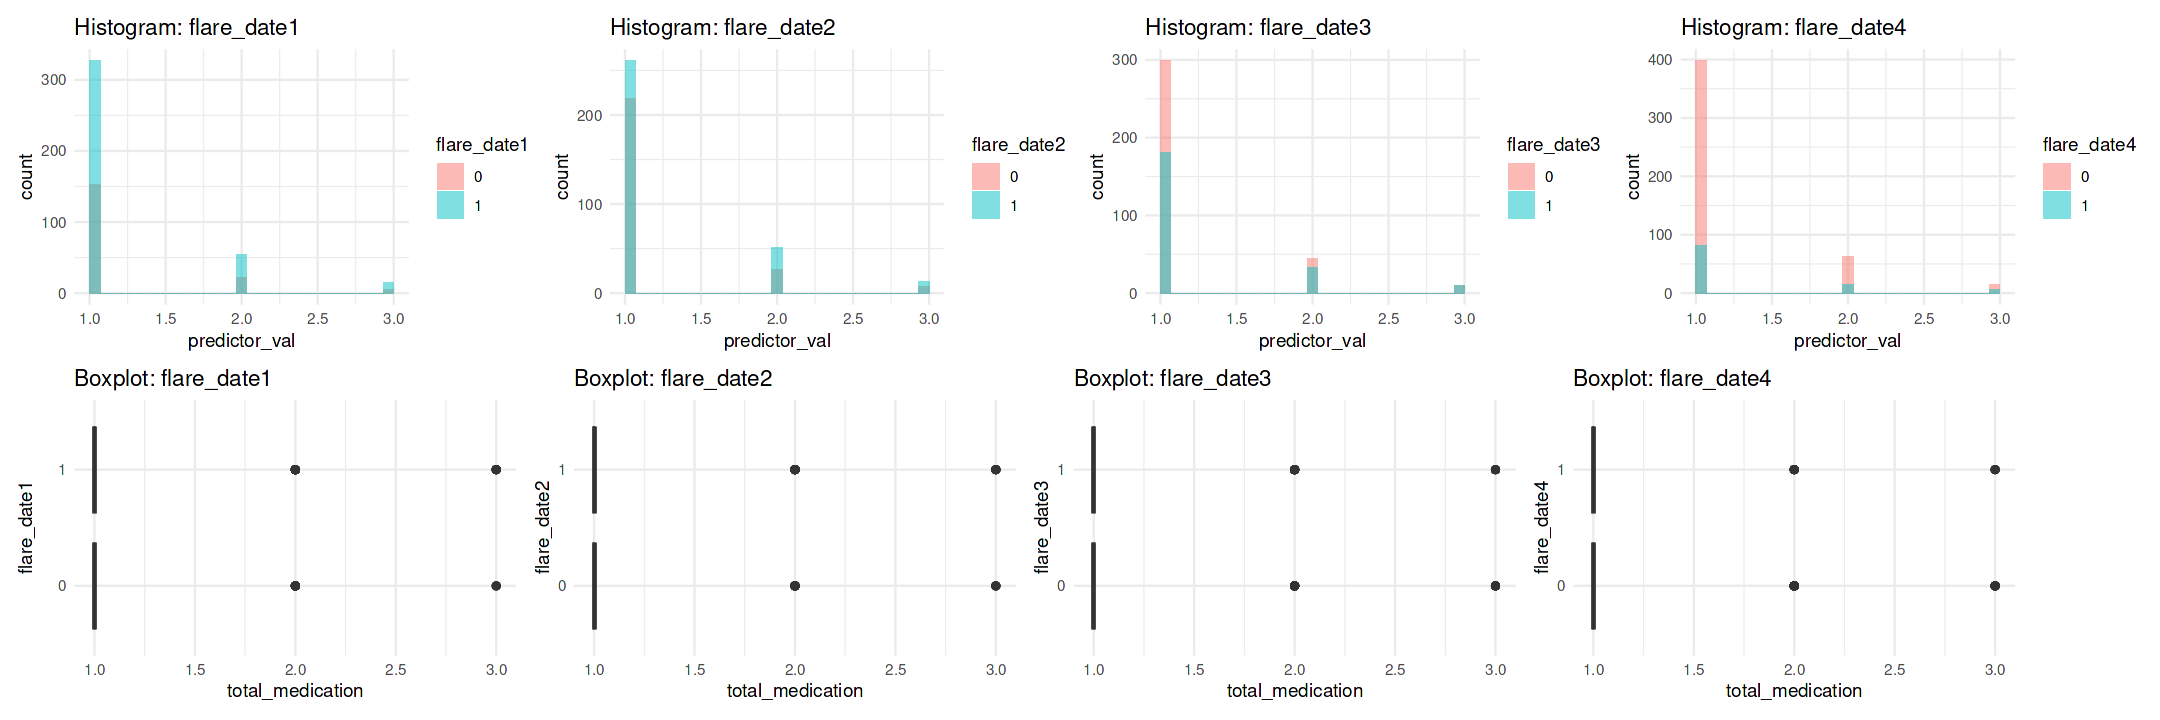

In [463]:
analyze_numeric_predictor(combined_dataset, "total_medication", Process=F)


========== ANALYSIS FOR: total_medication_dose ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 -1.272 432.7 0.2042 
2 flare_date2 -1.944 572.6 0.0524 
3 flare_date3 -1.448 431.0 0.1483 
4 flare_date4  1.911 256.8 0.0571

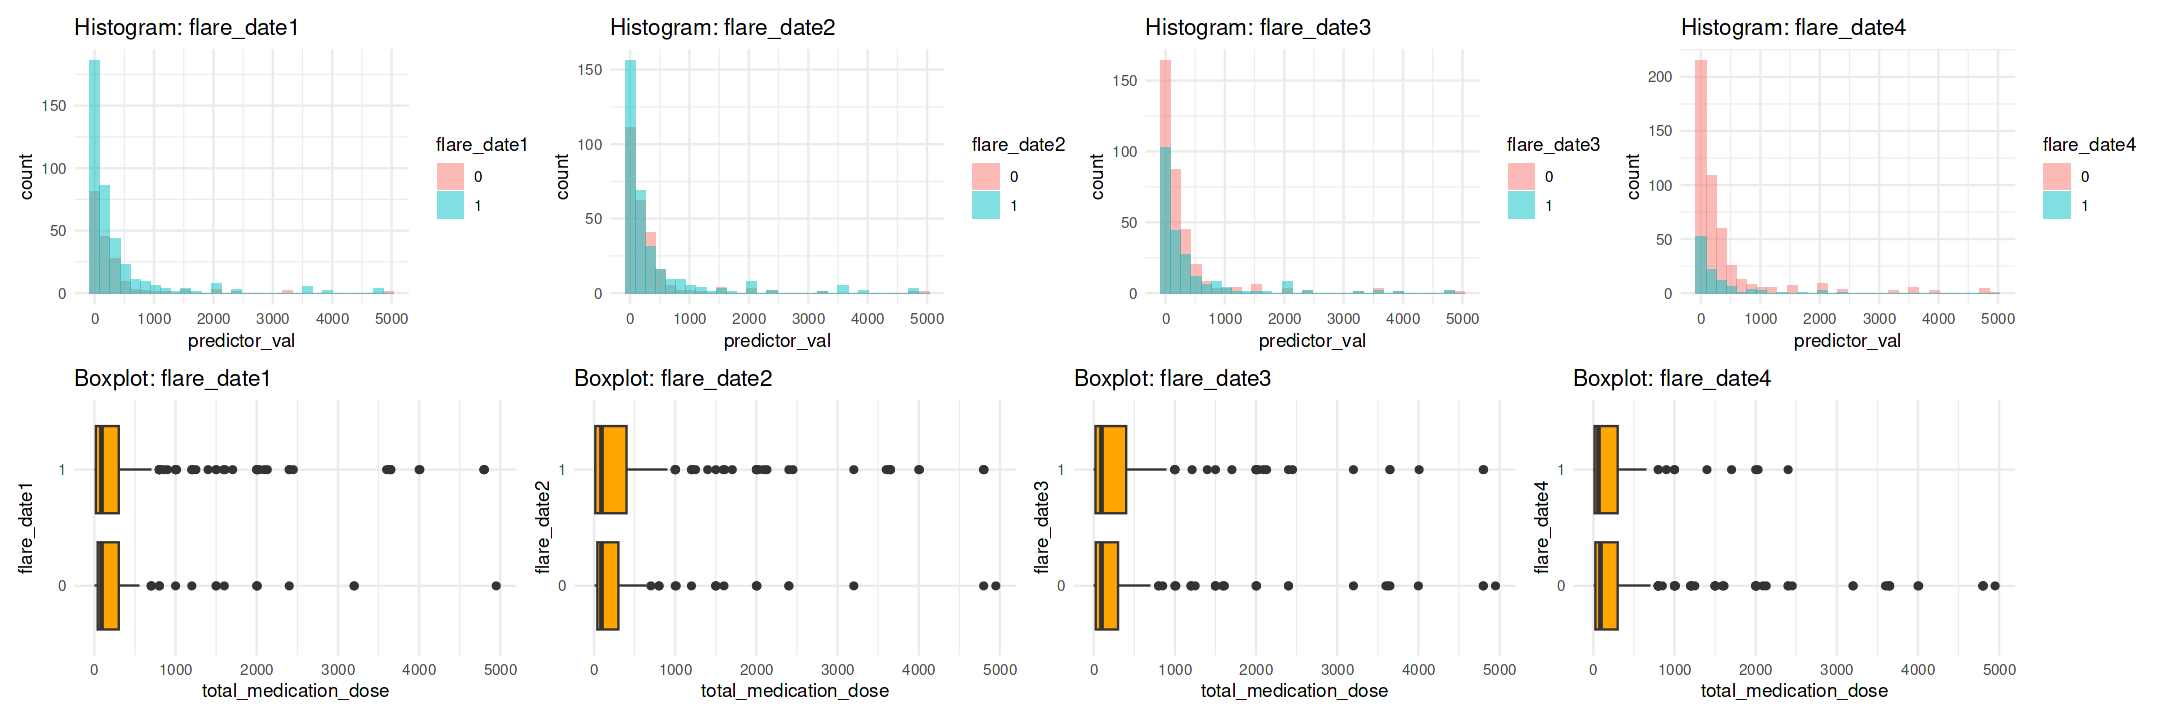

In [464]:
analyze_numeric_predictor(combined_dataset, "total_medication_dose")



========== ANALYSIS FOR: total_medication_period ==========


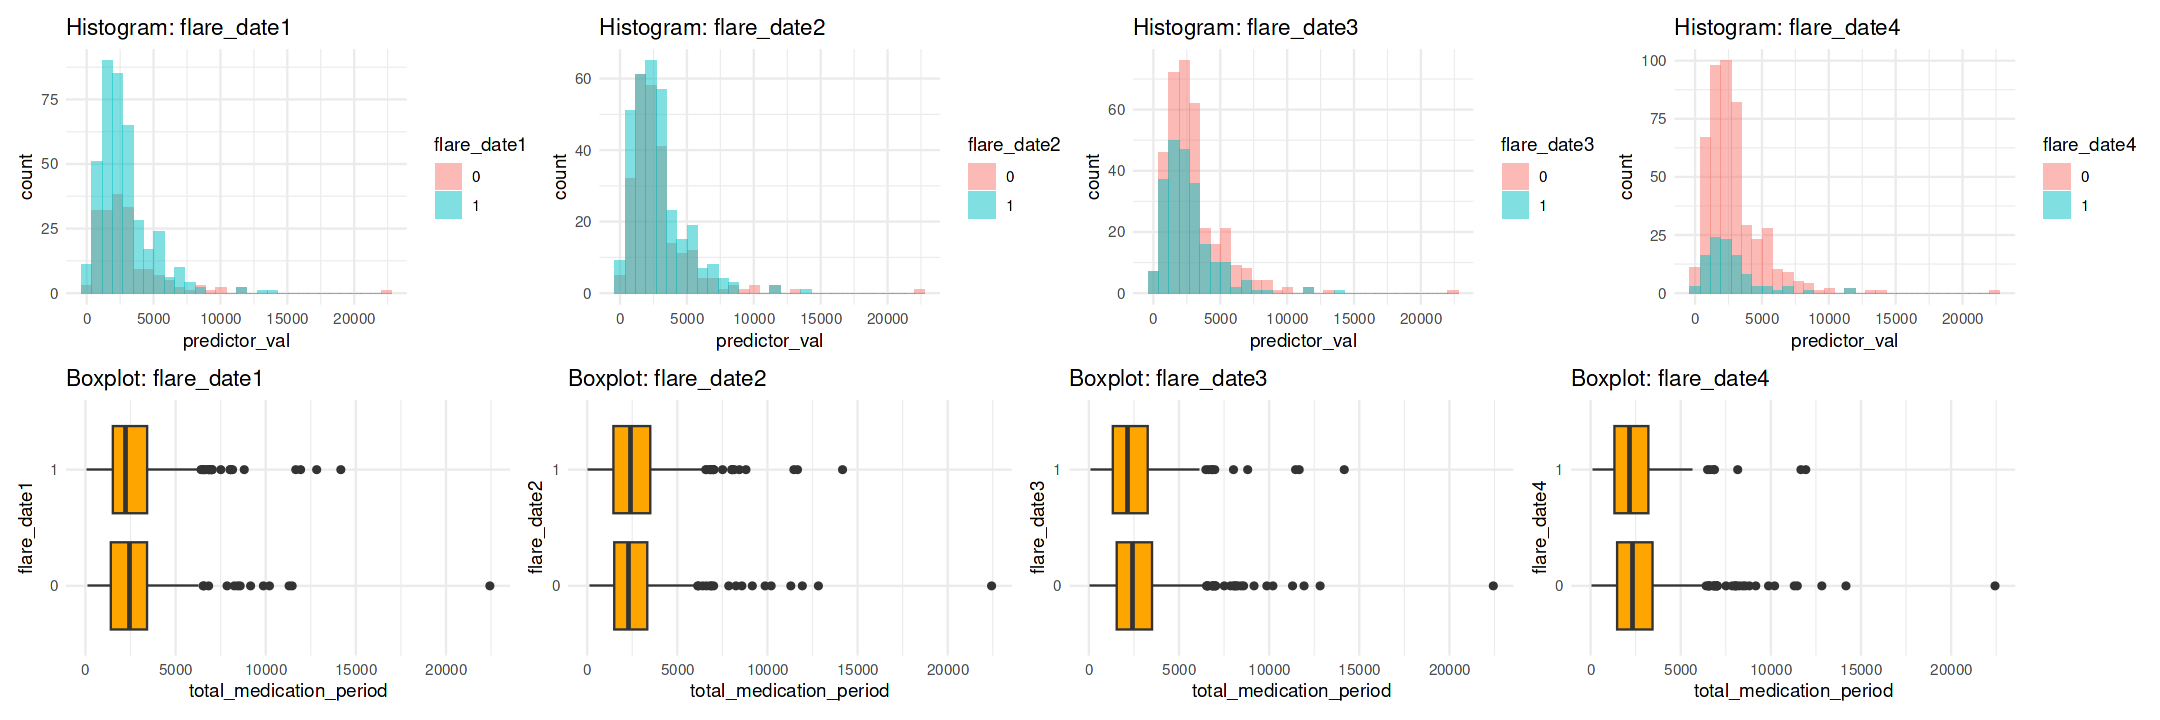

In [465]:
combined_dataset$total_medication_period <- 
    analyze_numeric_predictor(combined_dataset, "total_medication_period", Process=T)


========== ANALYSIS FOR: period_Adalimumab ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 1.393  302.1 0.1646 
2 flare_date2 1.027  523.0 0.3049 
3 flare_date3 1.072  523.7 0.2844 
4 flare_date4 1.353  205.3 0.1774

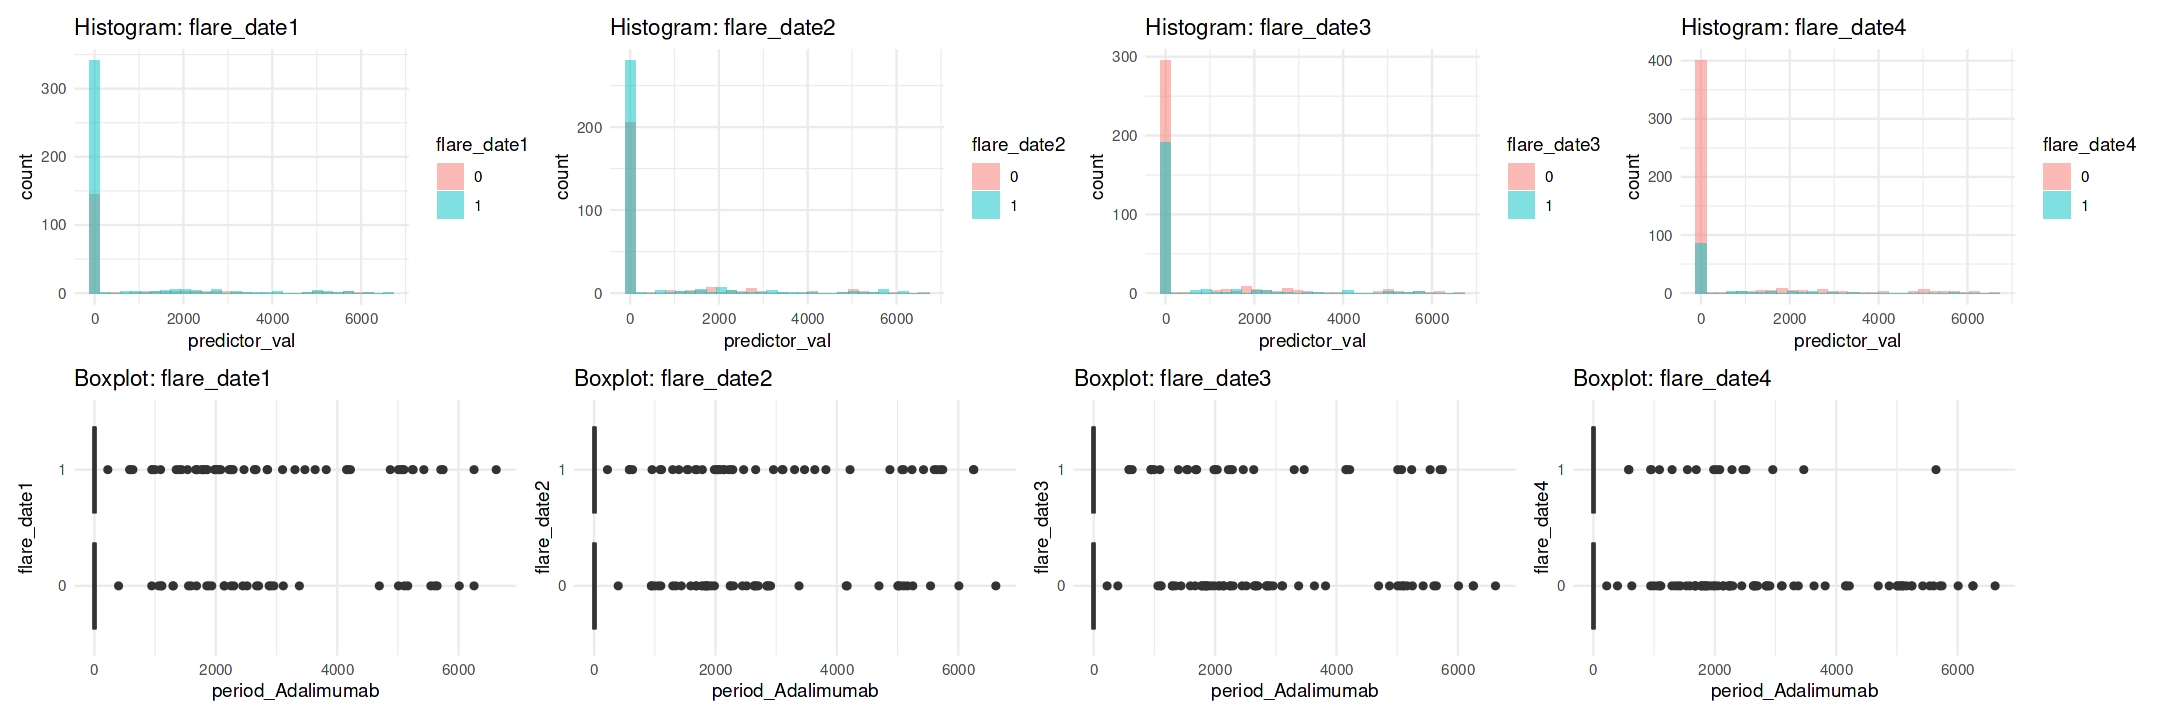

In [466]:
analyze_numeric_predictor(combined_dataset, "period_Adalimumab")


========== ANALYSIS FOR: period_Infliximab_Remicade ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 -0.794 341.8 0.4277 
2 flare_date2 -0.332 557.9 0.7397 
3 flare_date3  0.810 537.2 0.4182 
4 flare_date4  0.212 152.7 0.8326

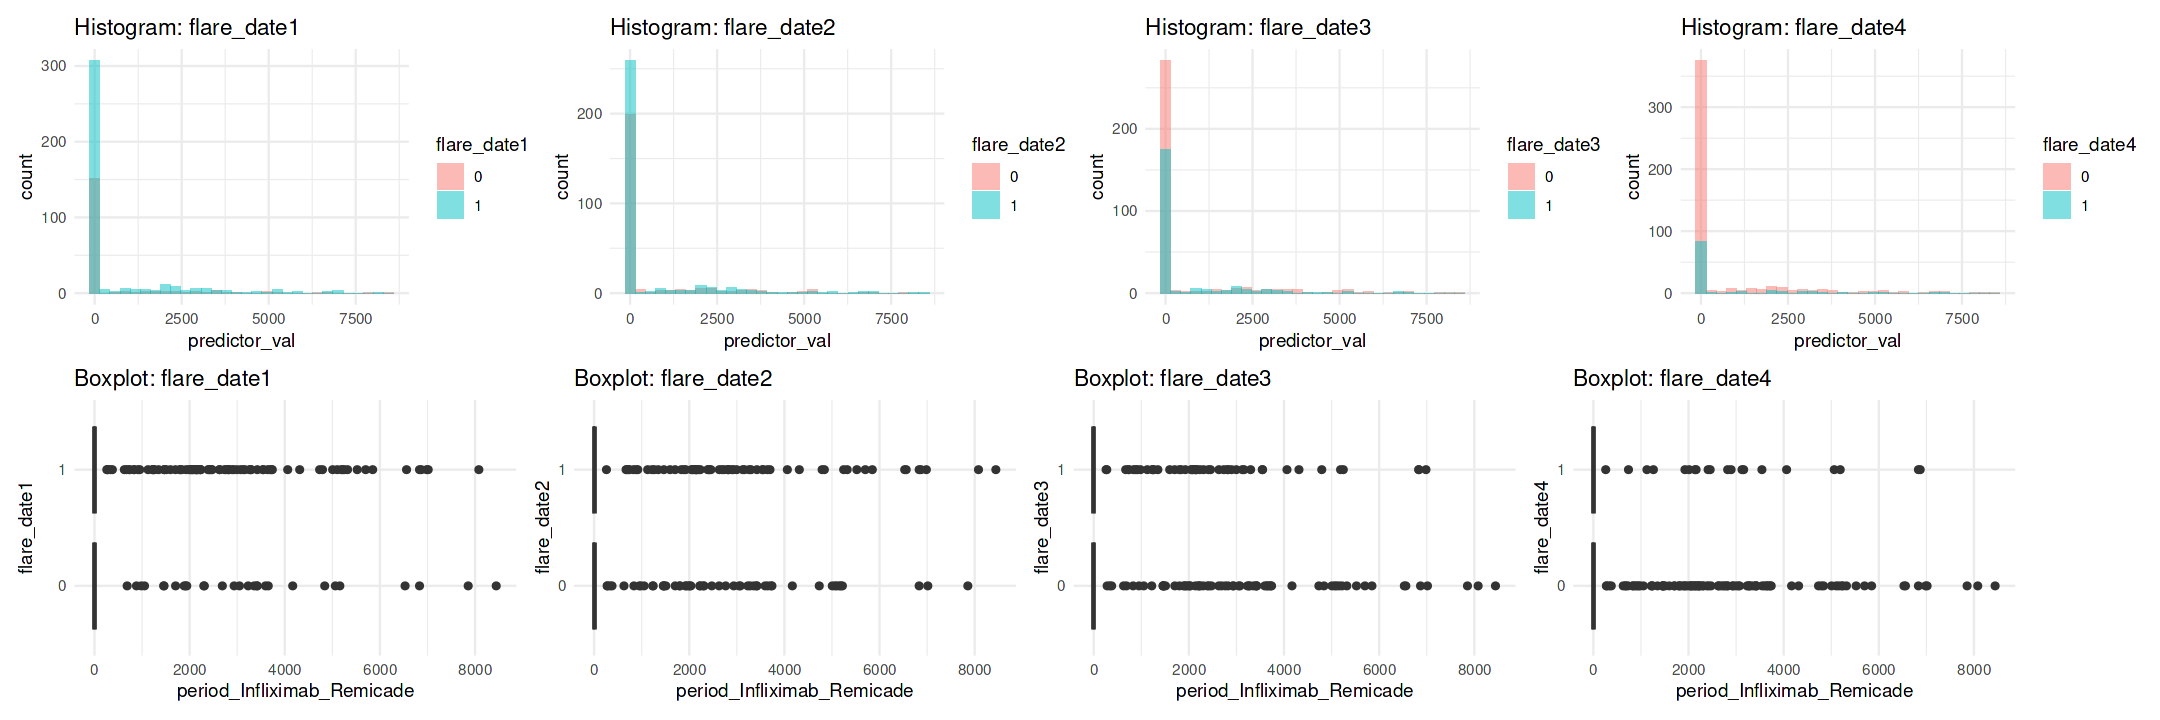

In [467]:
analyze_numeric_predictor(combined_dataset, "period_Infliximab_Remicade")


========== ANALYSIS FOR: period_Ustekinumab_Stelara ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 1.914  260.0 0.0568 
2 flare_date2 1.811  467.0 0.0708 
3 flare_date3 2.203  570.4 0.028  
4 flare_date4 1.130  183.7 0.2599

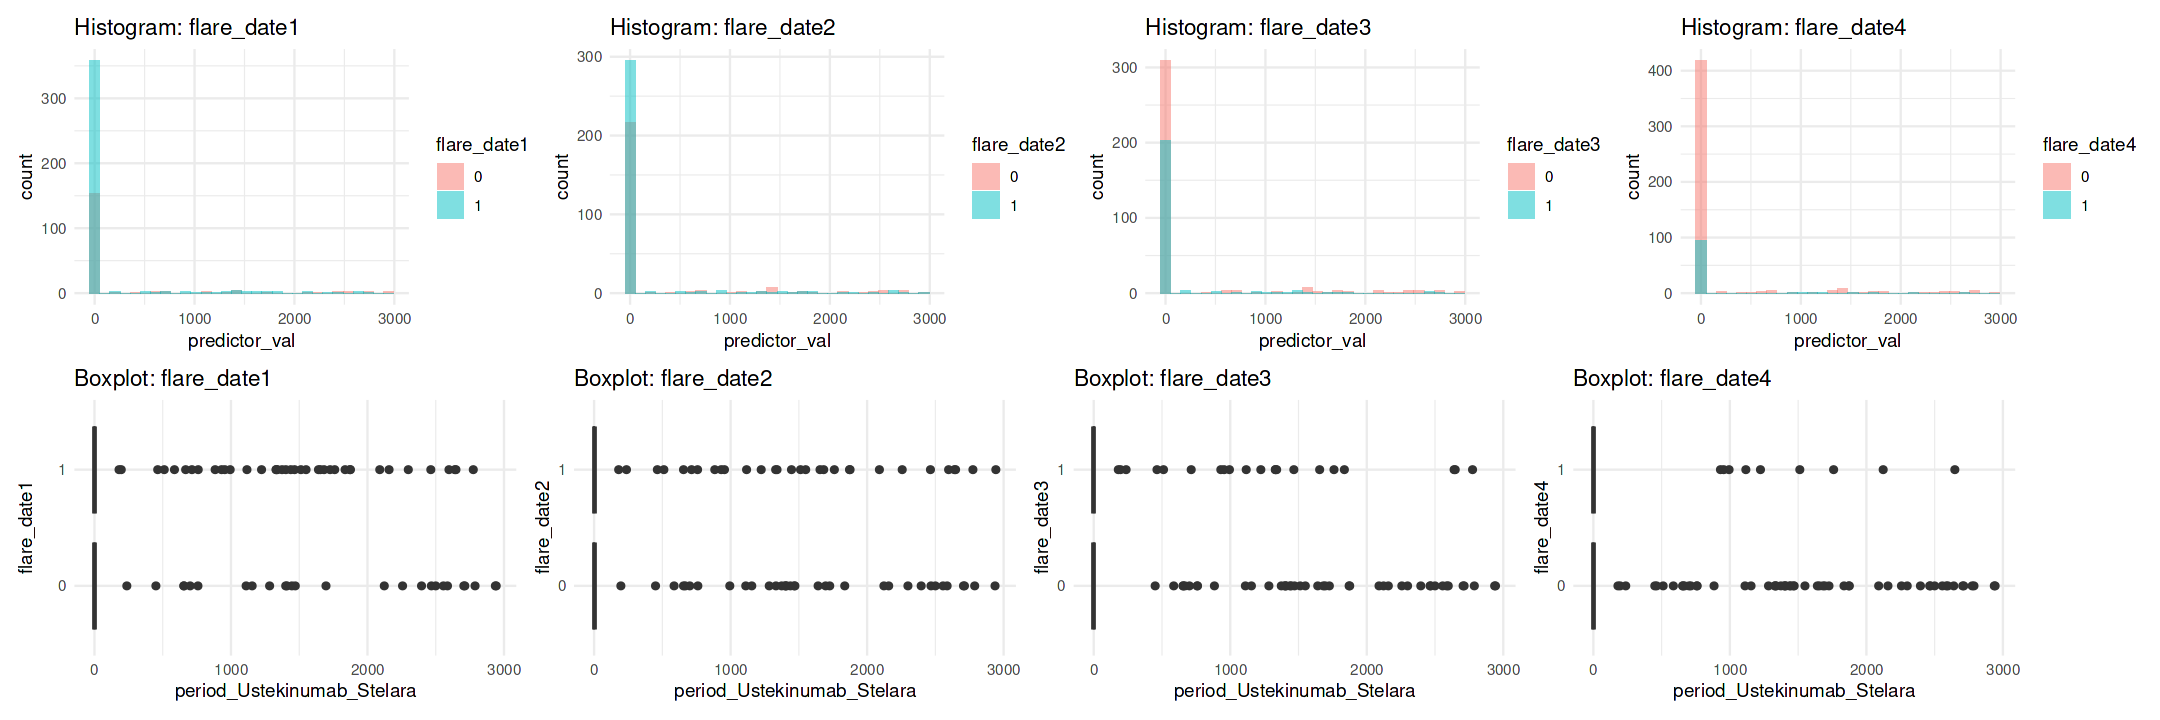

In [468]:
analyze_numeric_predictor(combined_dataset, "period_Ustekinumab_Stelara")


========== ANALYSIS FOR: period_Vedolizumab ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 1.282  290.9 0.2007 
2 flare_date2 1.699  476.6 0.0899 
3 flare_date3 0.879  508.0 0.38   
4 flare_date4 1.471  186.0 0.1429

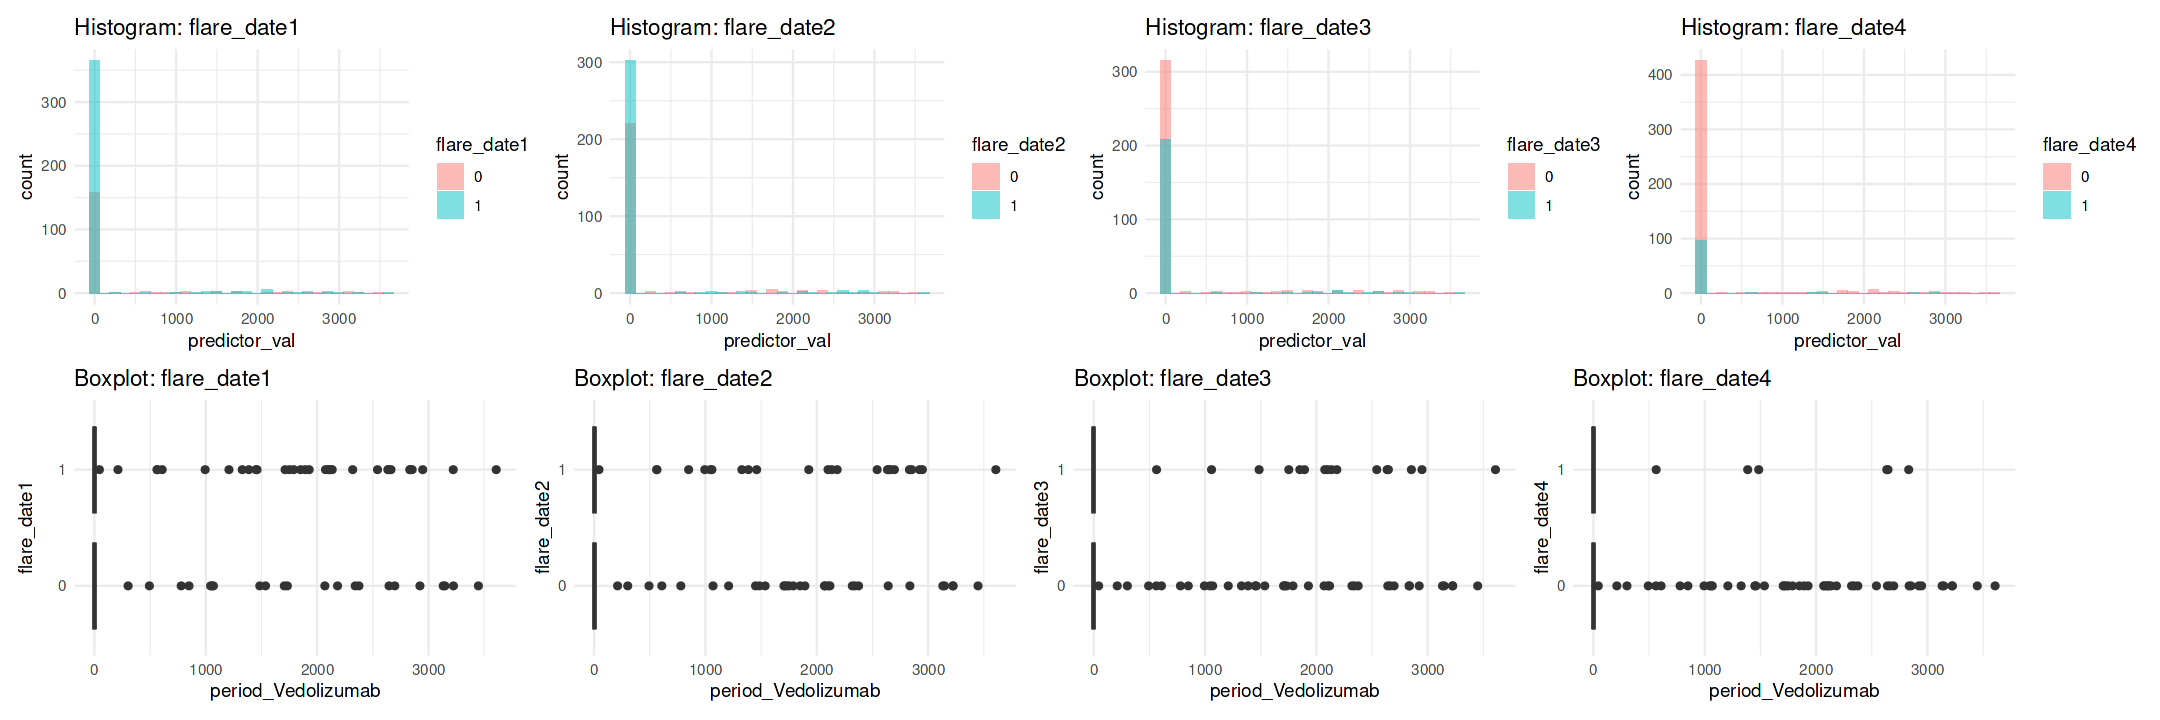

In [469]:
analyze_numeric_predictor(combined_dataset, "period_Vedolizumab")


========== ANALYSIS FOR: period_Tofacitinib ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 -1.656 508.9 0.0983 
2 flare_date2 -1.909 361.0 0.0571 
3 flare_date3 -1.576 253.4 0.1162 
4 flare_date4 -1.426 107.5 0.1567

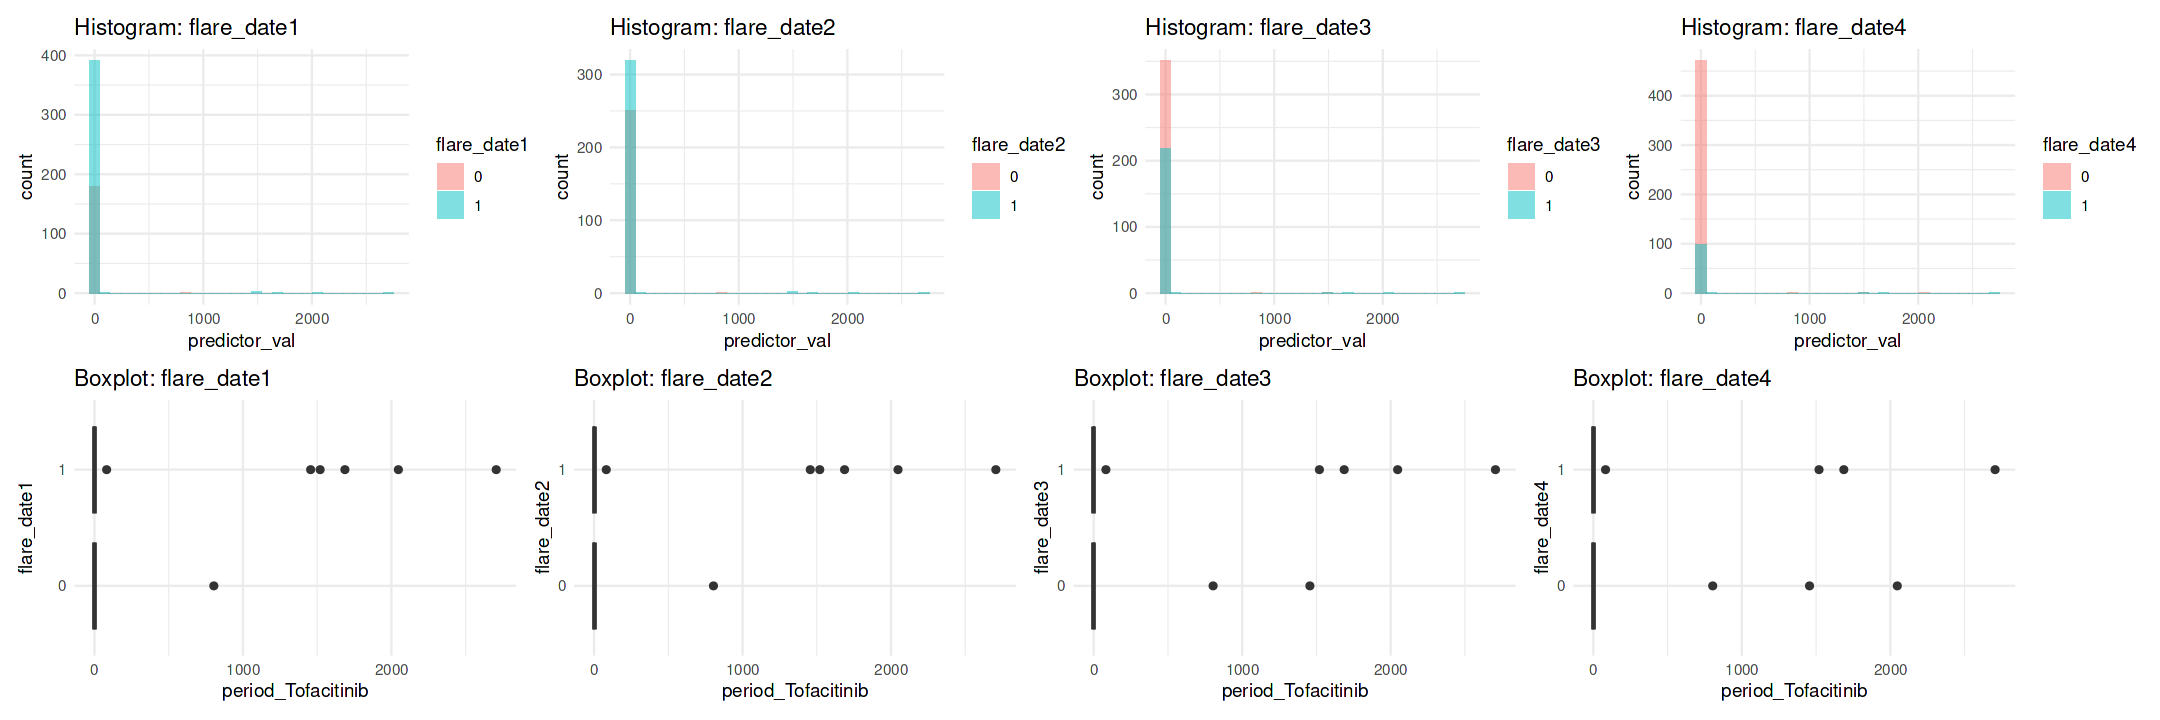

In [470]:
analyze_numeric_predictor(combined_dataset, "period_Tofacitinib")


========== ANALYSIS FOR: period_Golimumab ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 -1.333 396.0 0.1834 
2 flare_date2 -1.333 324.0 0.1835 
3 flare_date3 -1.334 223.0 0.1837 
4 flare_date4 -0.491 148.3 0.6245

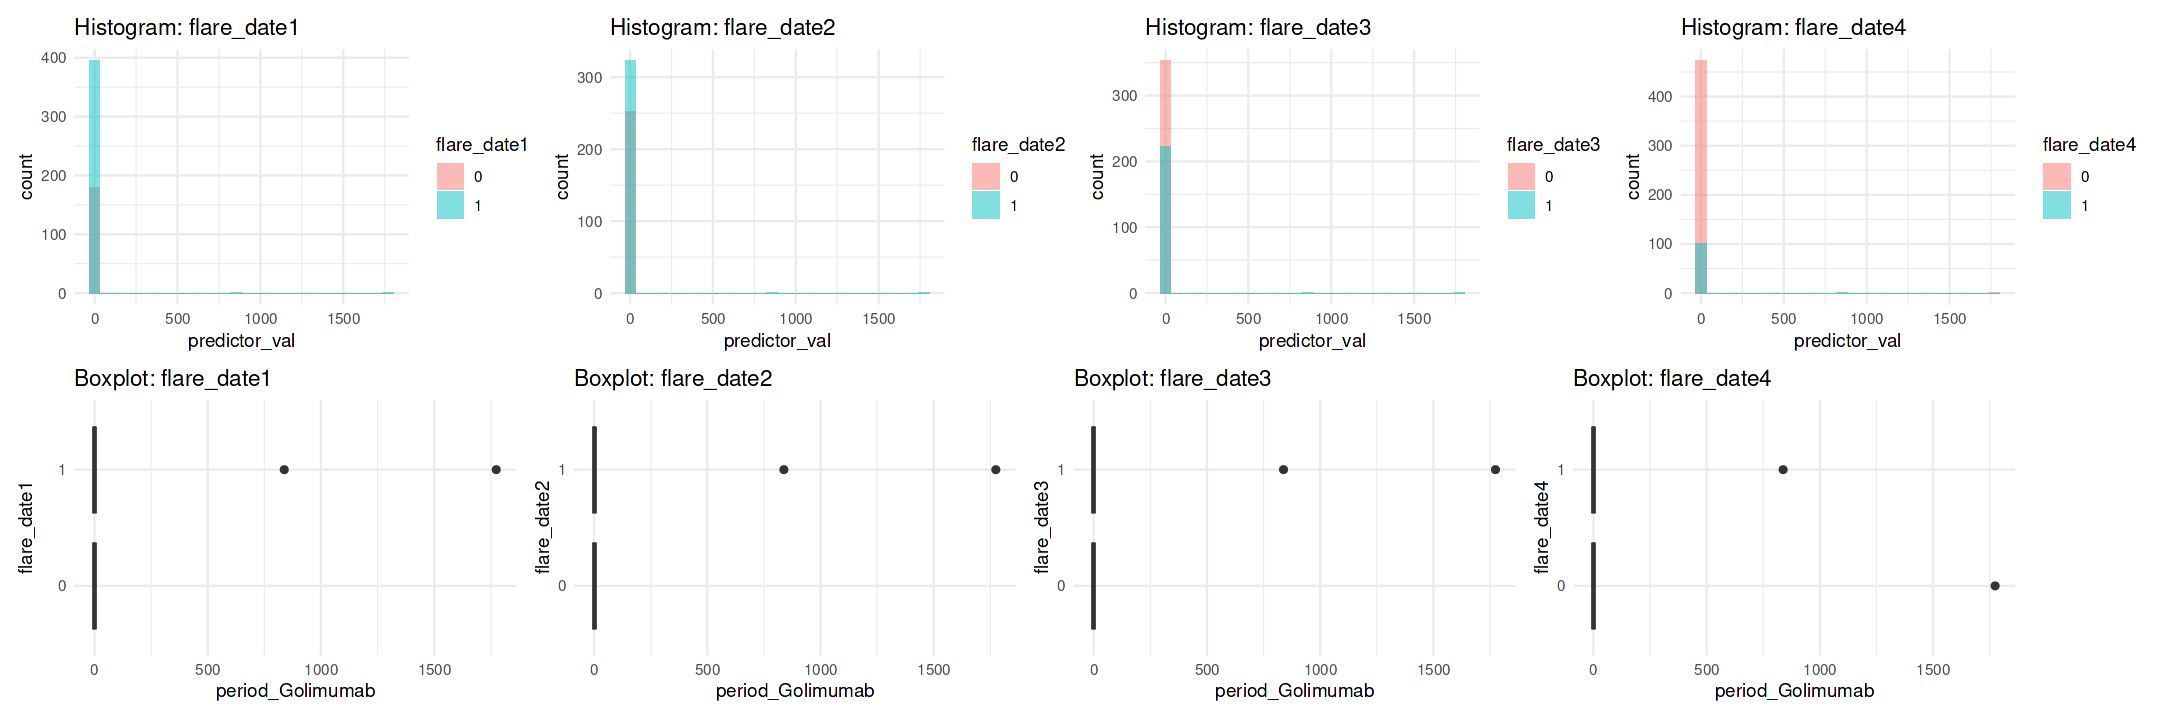

In [471]:
analyze_numeric_predictor(combined_dataset, "period_Golimumab")


========== ANALYSIS FOR: period_Mesalazine_oraal ==========


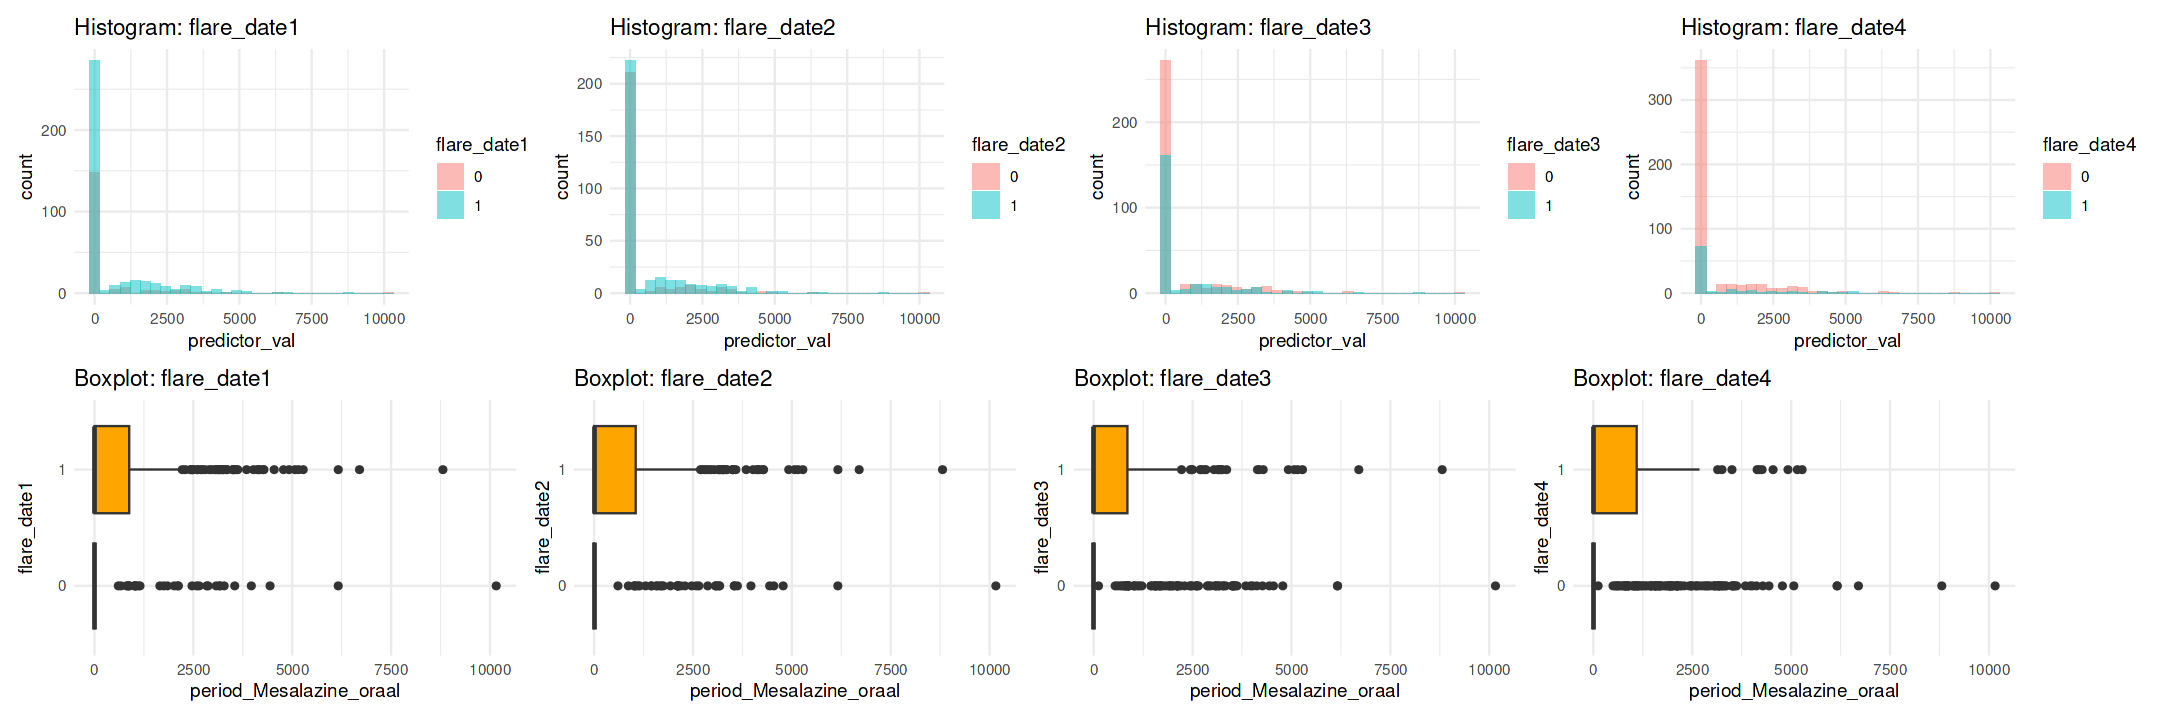

In [472]:
combined_dataset$period_Mesalazine_oraal <- analyze_numeric_predictor(combined_dataset, "period_Mesalazine_oraal", Process=T)


========== ANALYSIS FOR: period_Budesonide ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 0.015  407.7 0.9884 
2 flare_date2 1.372  376.9 0.171  
3 flare_date3 0.484  564.1 0.6284 
4 flare_date4 0.176  201.5 0.8605

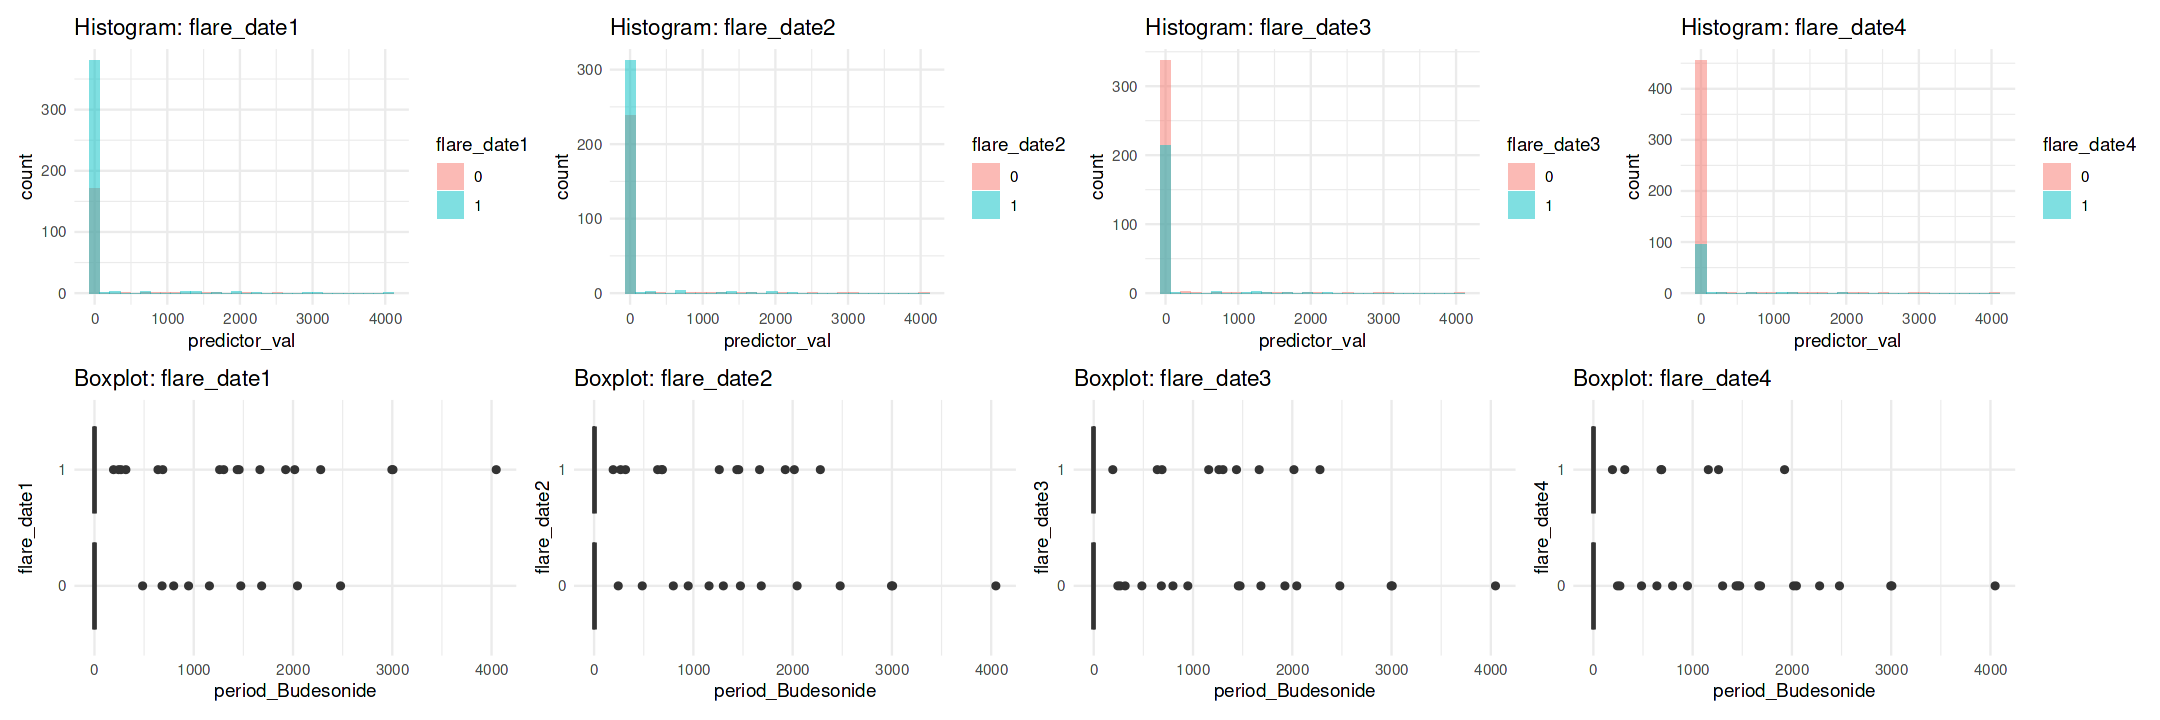

In [473]:
analyze_numeric_predictor(combined_dataset, "period_Budesonide")


========== ANALYSIS FOR: period_Tioguanine ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1  1.350 255.3 0.1781 
2 flare_date2 -0.115 554.9 0.9082 
3 flare_date3  0.050 474.8 0.9604 
4 flare_date4  1.280 233.6 0.202

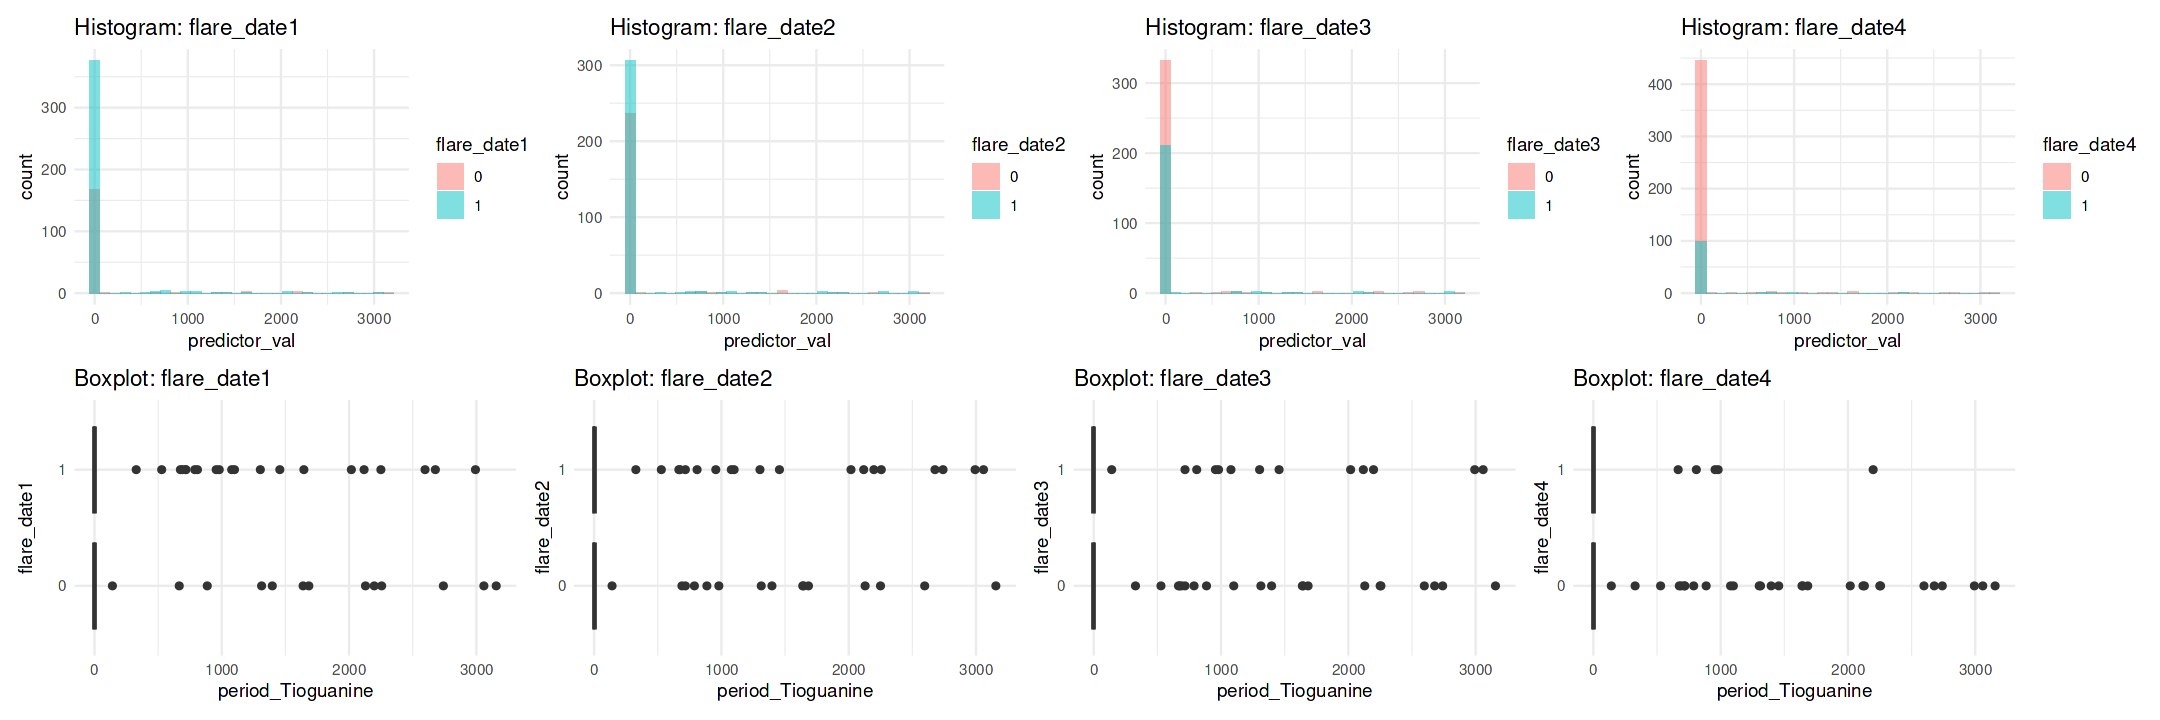

In [474]:
analyze_numeric_predictor(combined_dataset, "period_Tioguanine")



========== ANALYSIS FOR: period_Methotrexaat ==========


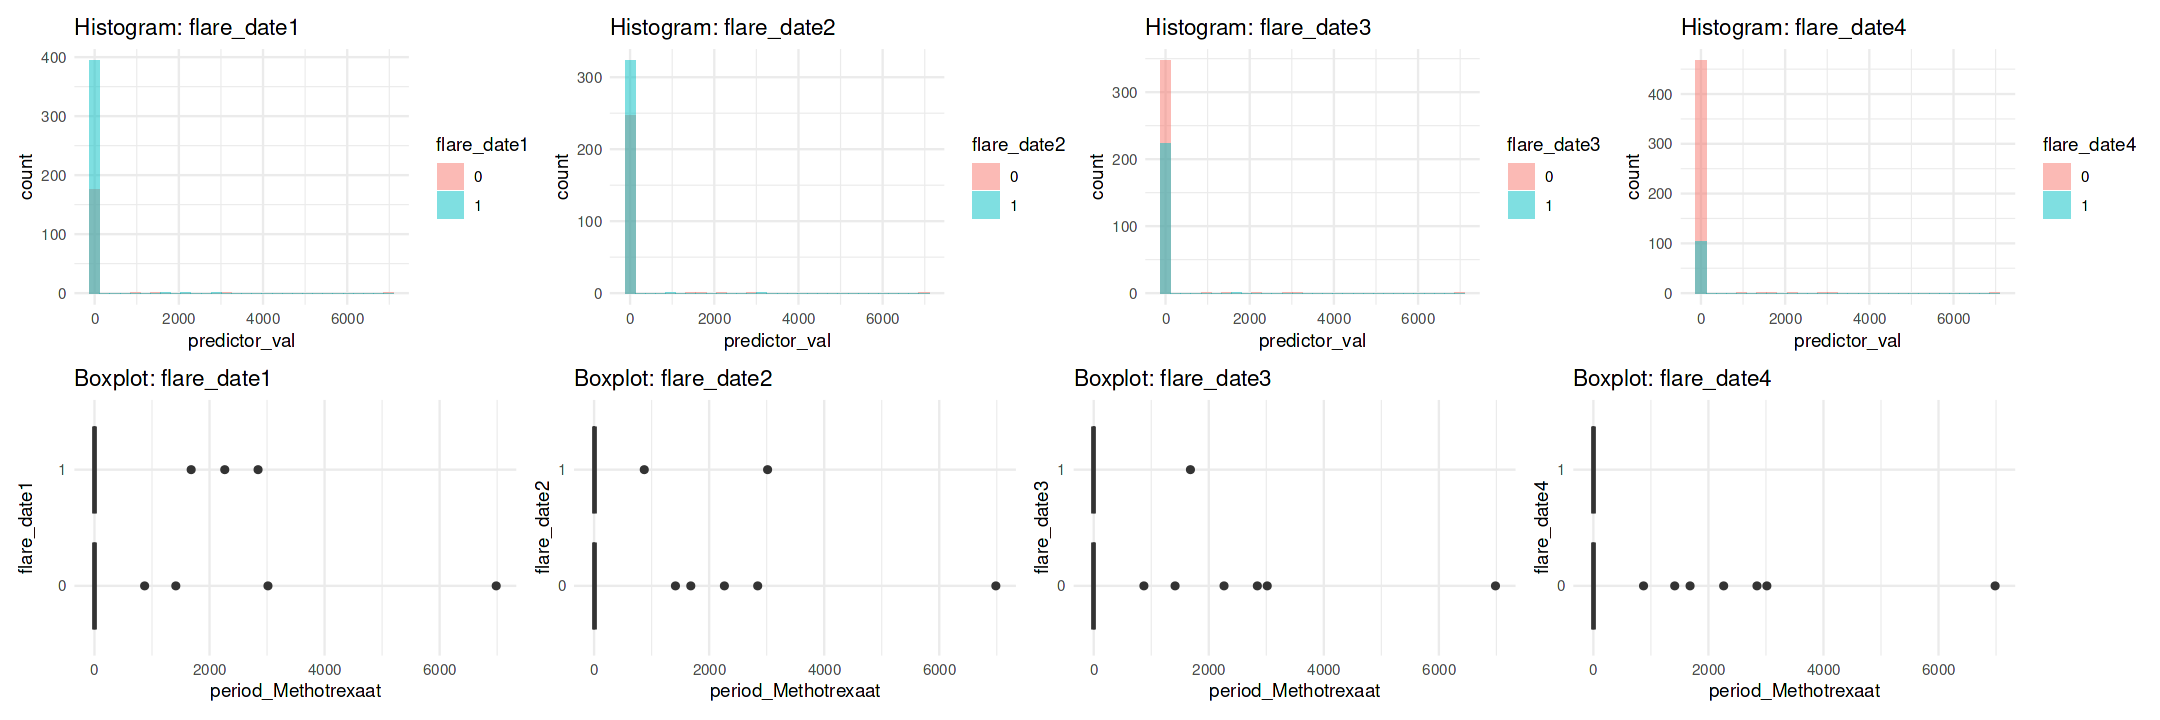

In [475]:
combined_dataset$period_Methotrexaat <- analyze_numeric_predictor(combined_dataset, "period_Methotrexaat", Process=T)


========== ANALYSIS FOR: period_Mesalazine_zetpil ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 -0.908 410.6 0.3644 
2 flare_date2 -0.909 571.7 0.3636 
3 flare_date3  1.234 566.8 0.2179 
4 flare_date4 -0.060 146.0 0.9522

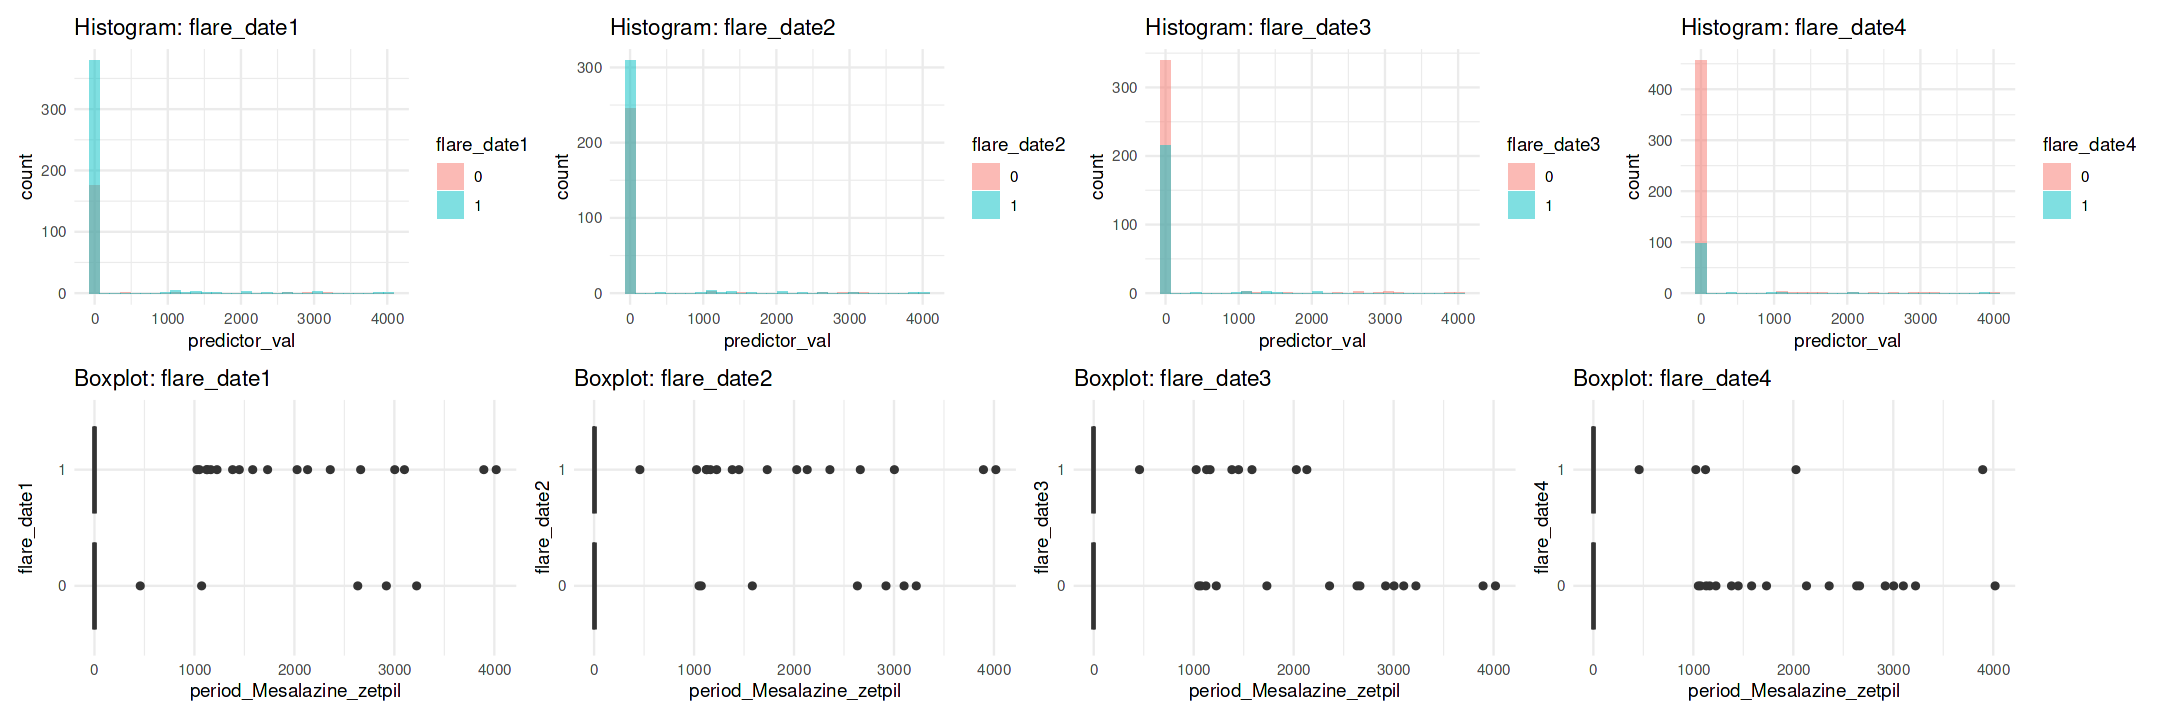

In [476]:
analyze_numeric_predictor(combined_dataset, "period_Mesalazine_zetpil")


========== ANALYSIS FOR: period_Mercaptopurine ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 -0.955 390.2 0.3404 
2 flare_date2  0.174 474.2 0.8619 
3 flare_date3  0.489 553.2 0.6248 
4 flare_date4 -0.625 149.4 0.5328

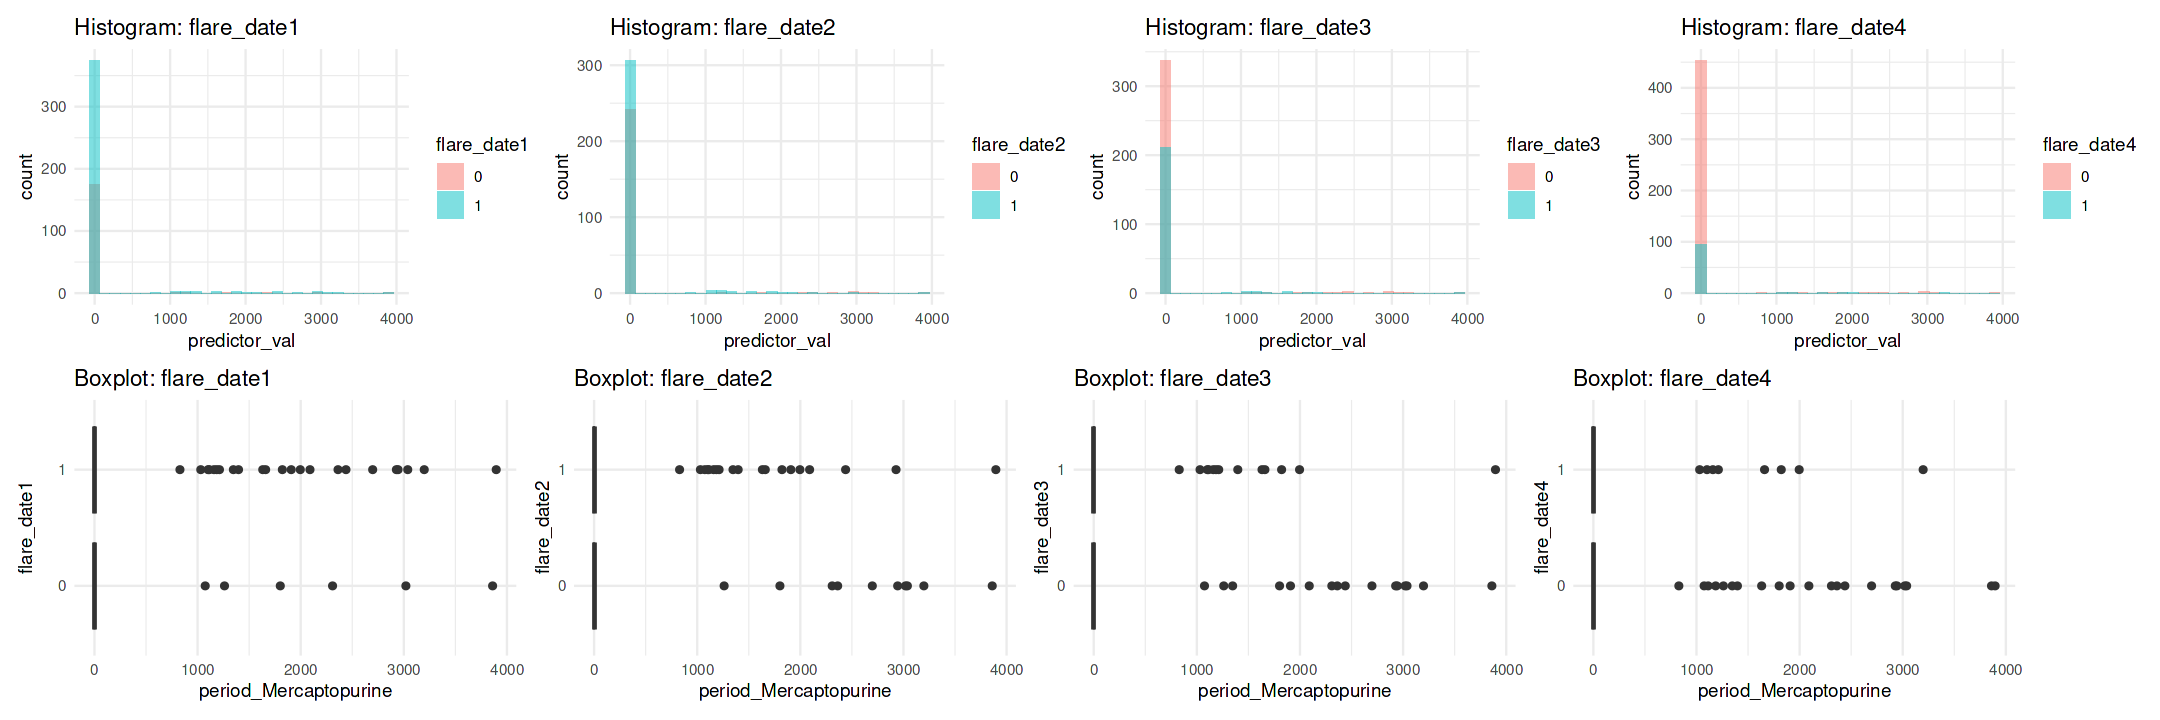

In [477]:
analyze_numeric_predictor(combined_dataset, "period_Mercaptopurine")


========== ANALYSIS FOR: period_Beclomethason ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1  1.336 209.6 0.1829 
2 flare_date2 -0.623 551.9 0.5334 
3 flare_date3 -1.482 282.2 0.1394 
4 flare_date4  0.052 153.2 0.9585

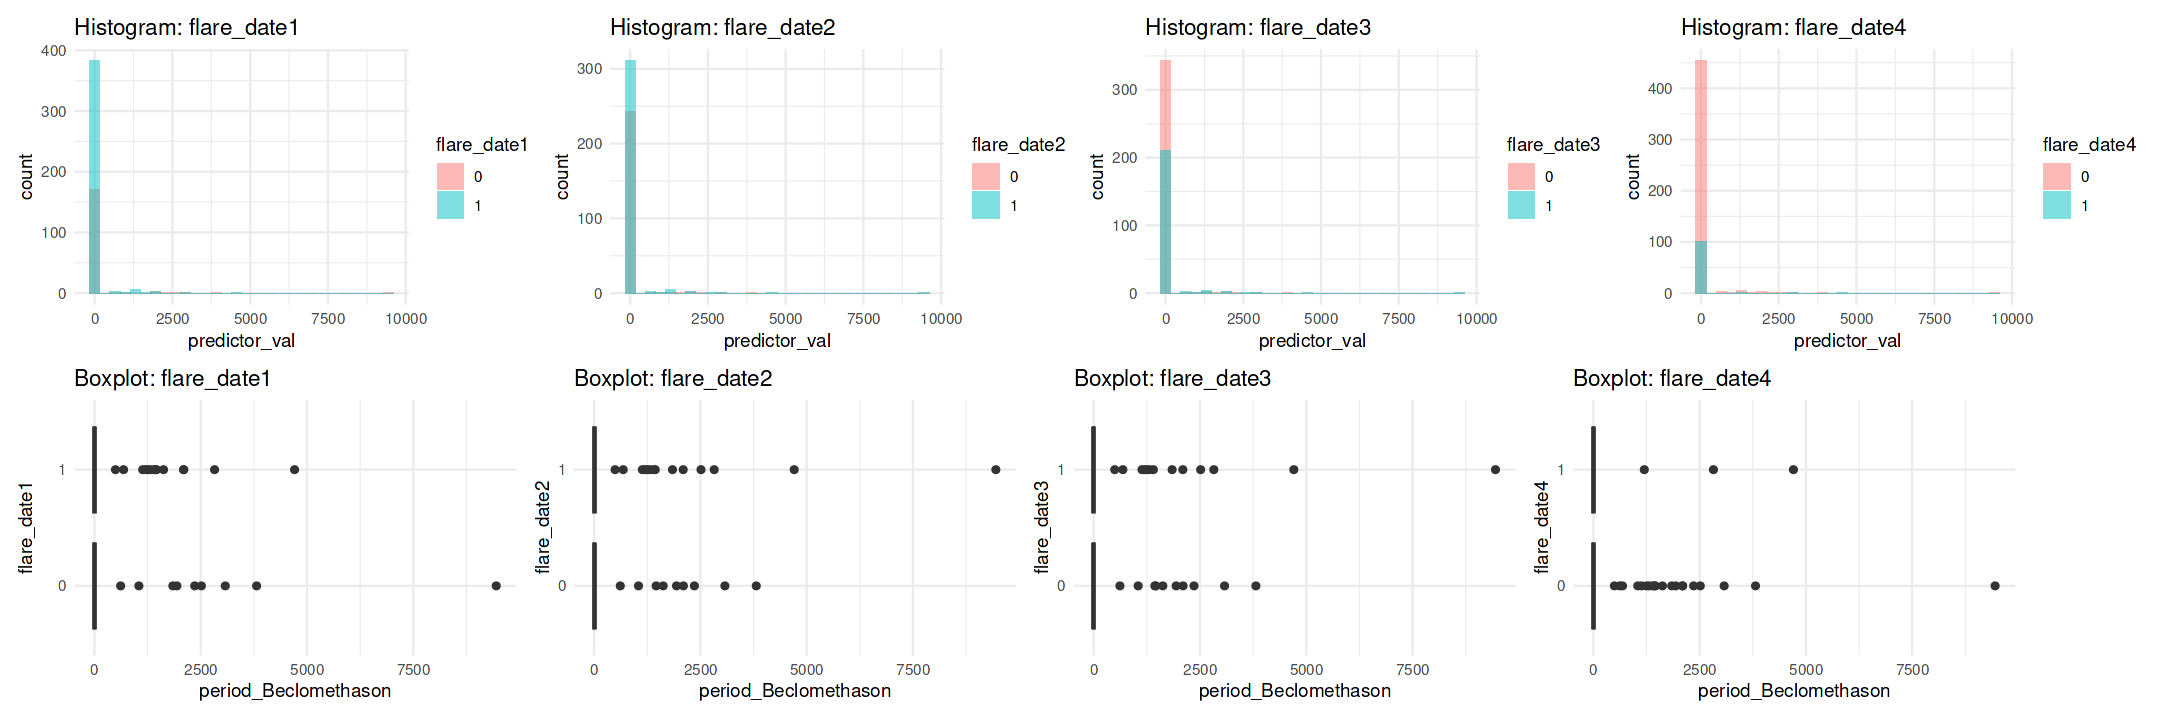

In [478]:
analyze_numeric_predictor(combined_dataset, "period_Beclomethason")


========== ANALYSIS FOR: period_Azathioprine ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1  1.167 235.5 0.2445 
2 flare_date2  0.270 439.0 0.7869 
3 flare_date3  0.328 567.5 0.743  
4 flare_date4 -0.213 165.1 0.8316

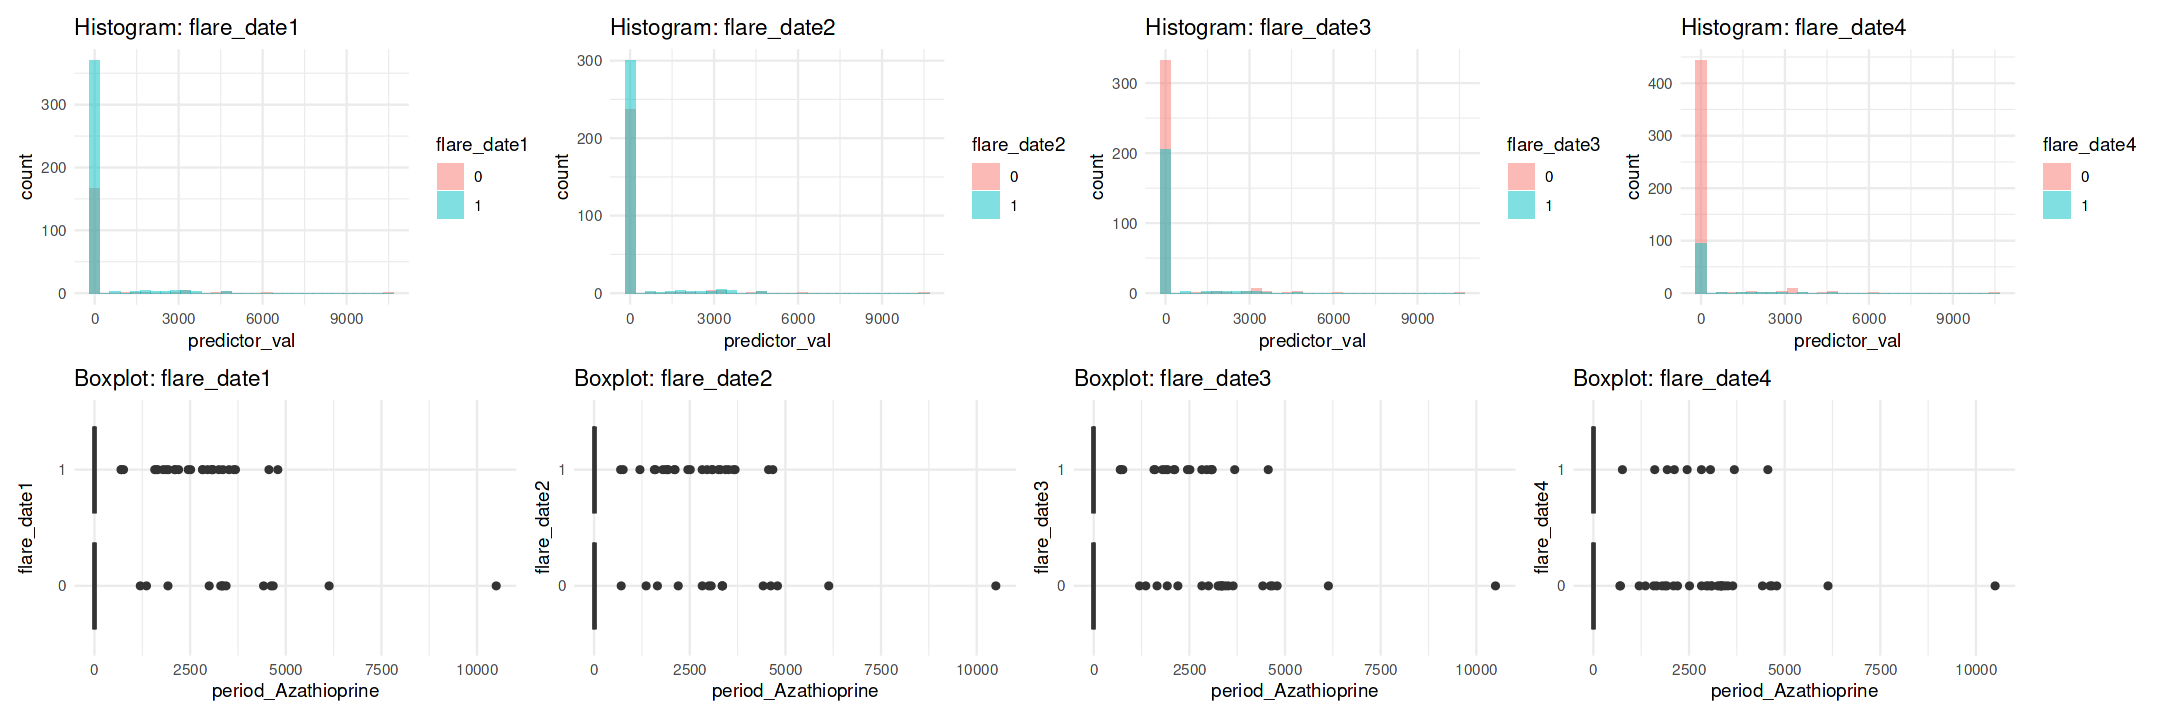

In [479]:
analyze_numeric_predictor(combined_dataset, "period_Azathioprine")


========== ANALYSIS FOR: period_Allopurinol ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 -0.841 485.6 0.4007 
2 flare_date2  0.581 402.9 0.5612 
3 flare_date3  0.390 559.7 0.6965 
4 flare_date4 -0.947 122.8 0.3457

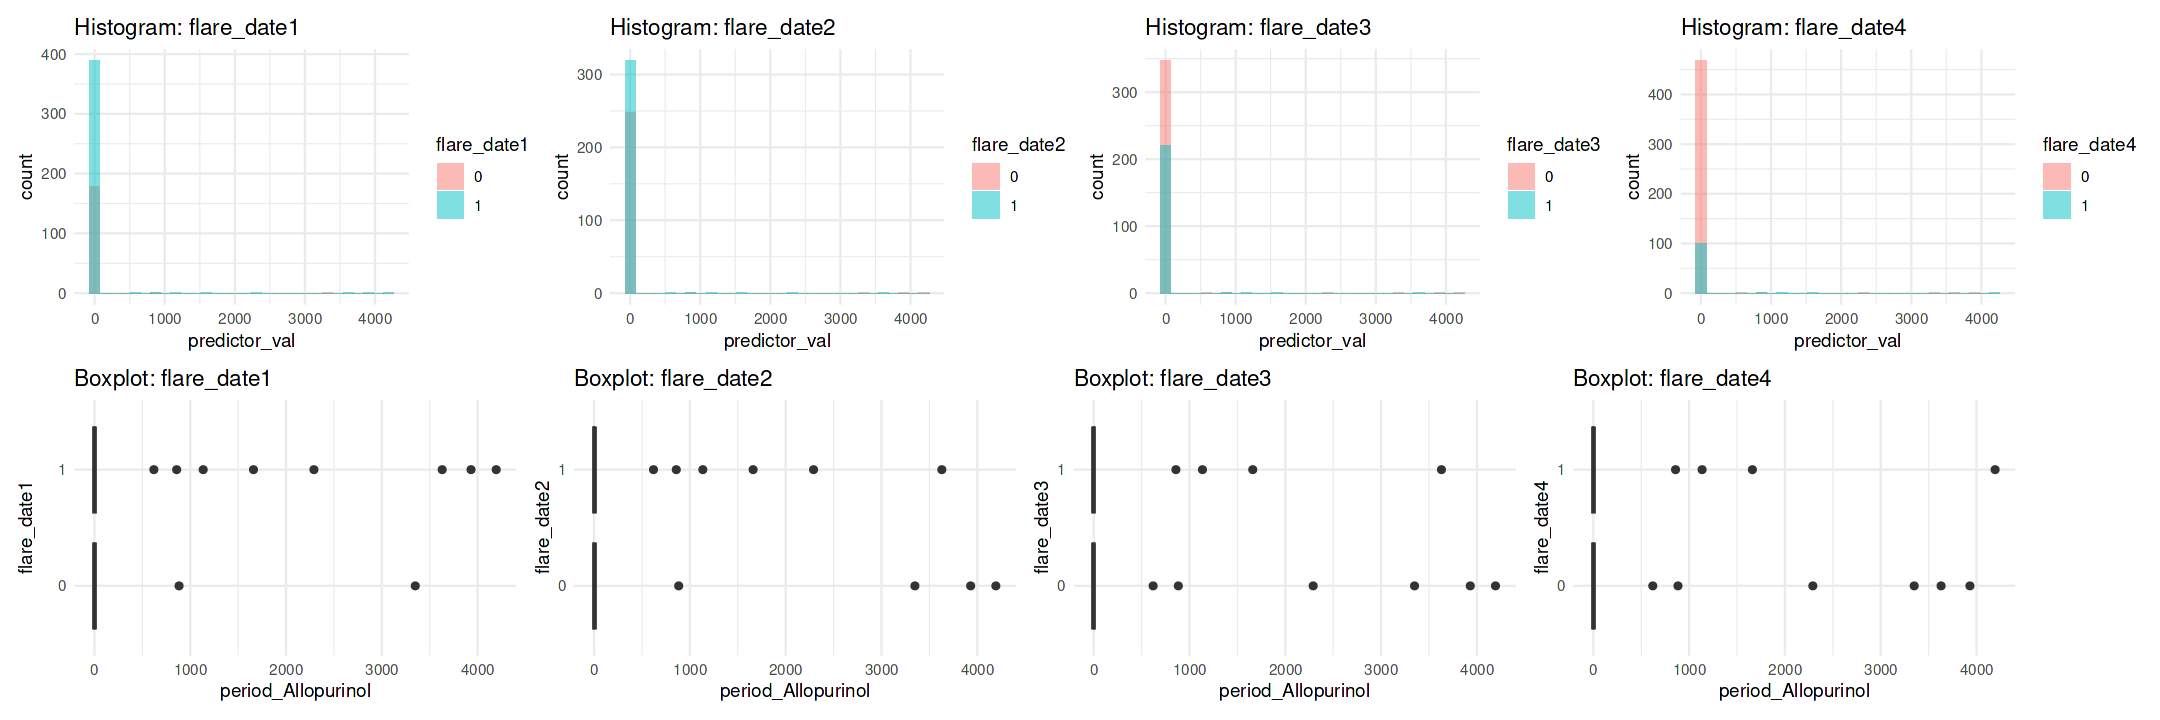

In [480]:
analyze_numeric_predictor(combined_dataset, "period_Allopurinol")


========== ANALYSIS FOR: period_Mesalazine_klysma ==========

== T-test Results ==


Dependent   t_stat df    p_value
1 flare_date1 -1.313 438.7 0.1898 
2 flare_date2  0.675 280.8 0.5003 
3 flare_date3  0.771 440.1 0.4414 
4 flare_date4  1.334 556.1 0.1828

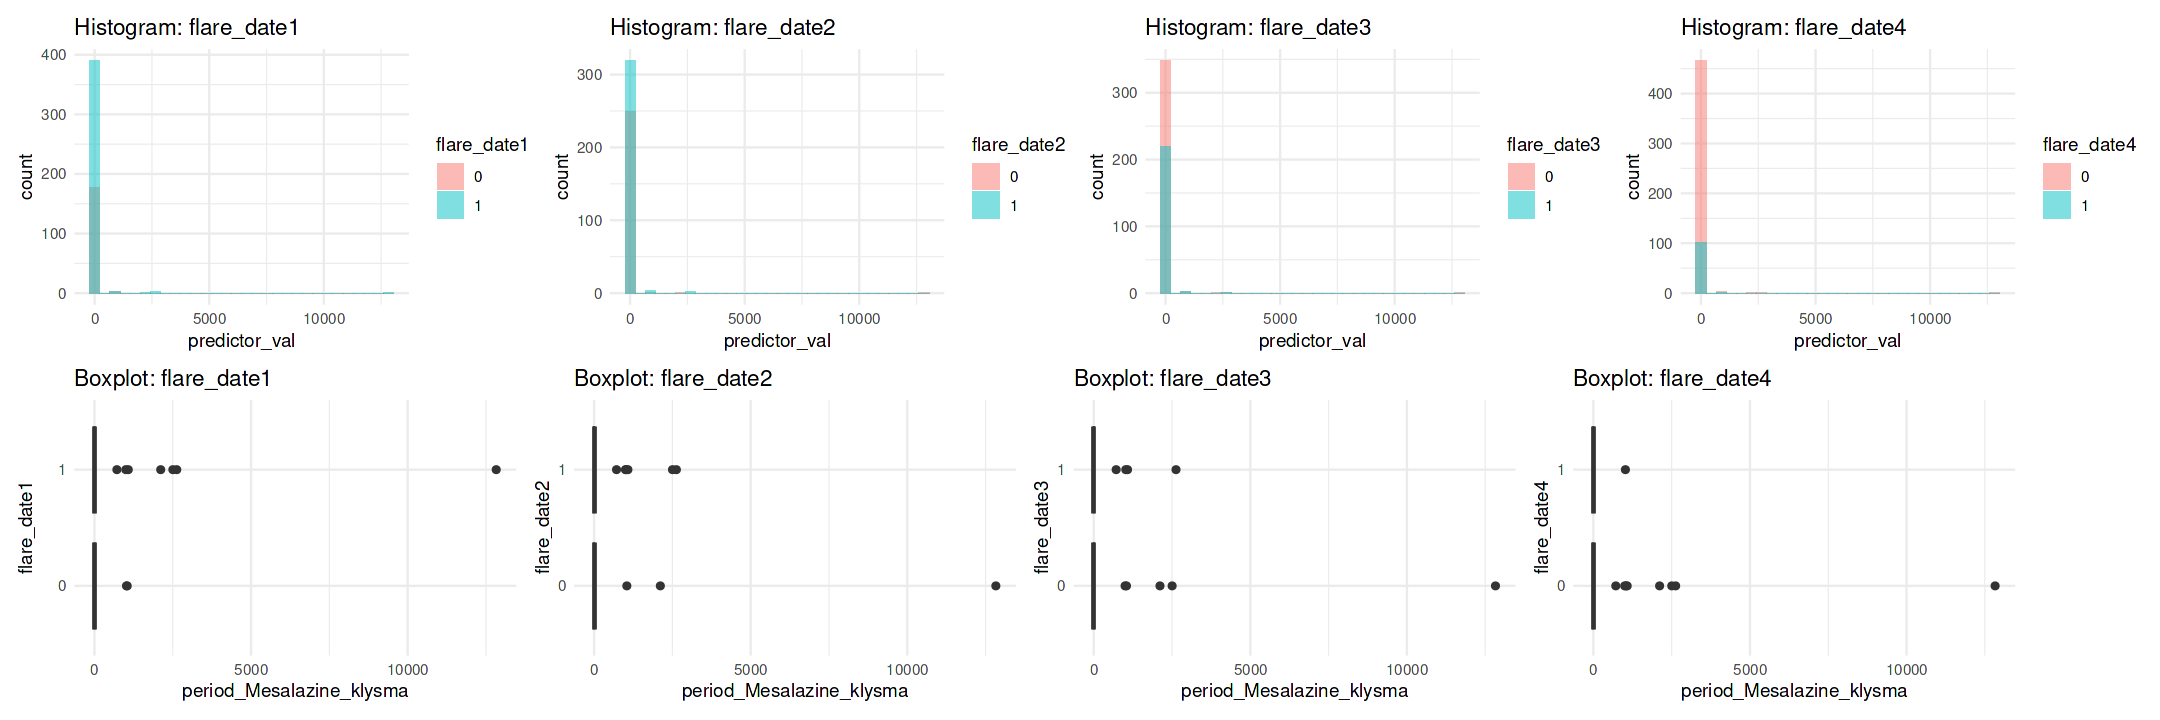

In [481]:
analyze_numeric_predictor(combined_dataset, "period_Mesalazine_klysma")


========== ANALYSIS FOR: period_Sulfasalazine ==========


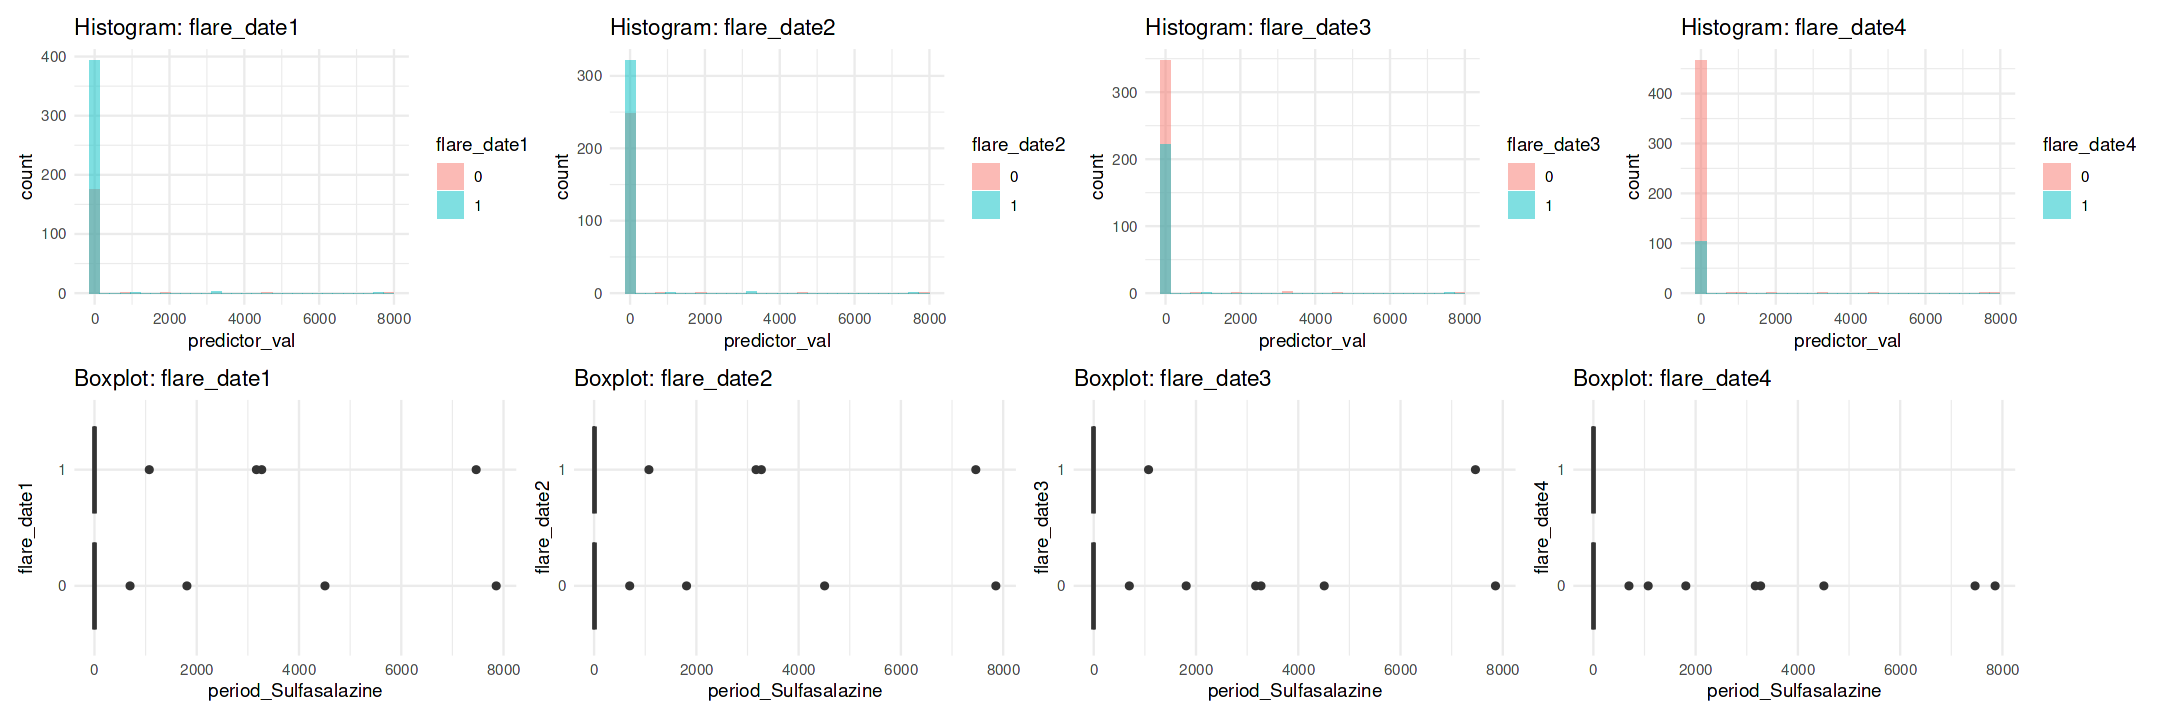

In [482]:
combined_dataset$period_Sulfasalazine <- analyze_numeric_predictor(combined_dataset, "period_Sulfasalazine", Process=T)

In [483]:
# Remove non-significant, w'll exclude then from the next analysis
combined_dataset <- combined_dataset  %>%
  dplyr::select( -total_medication,-total_medication_dose ,
  -age_at_surg_colon_resection,
  -age_at_surg_subtotal_colectomy,
  -age_at_surg_fistula_abcess,
-age_at_surg_proctocolectomy,
-age_at_surg_stoma_reversal,
-age_at_surg_proctectomy,
-period_Adalimumab,
-period_Infliximab_Remicade,
-period_Vedolizumab,
-period_Tofacitinib,
-period_Golimumab,
-period_Budesonide,
-period_Tioguanine,
-period_Mesalazine_zetpil,
-period_Mercaptopurine,
-period_Beclomethason,
-period_Azathioprine,
-period_Allopurinol,
-period_Mesalazine_klysma,
-period_Ustekinumab_Stelara,
               -starts_with("dose_"))


# 2. Statistics


In [484]:
print("=== DATASET OVERVIEW ===")
cat("Dataset dimensions:", dim(combined_dataset), "\n")
cat("Number of observations:", nrow(combined_dataset), "\n")
cat("Number of variables:", ncol(combined_dataset), "\n\n")

[1] "=== DATASET OVERVIEW ==="
Dataset dimensions: 577 37 
Number of observations: 577 
Number of variables: 37 



## 2.1 dependent variables analysis

[1] "=== DEPENDENT VARIABLES ANALYSIS ==="

Flare evolution summary:

flare_timepoint count_No Flare count_Flare percentage_No Flare
1 Date 1          180            397         31.2               
2 Date 2          252            325         43.7               
3 Date 3          353            224         61.2               
4 Date 4          474            103         82.1               
  percentage_Flare
1 68.8            
2 56.3            
3 38.8            
4 17.9

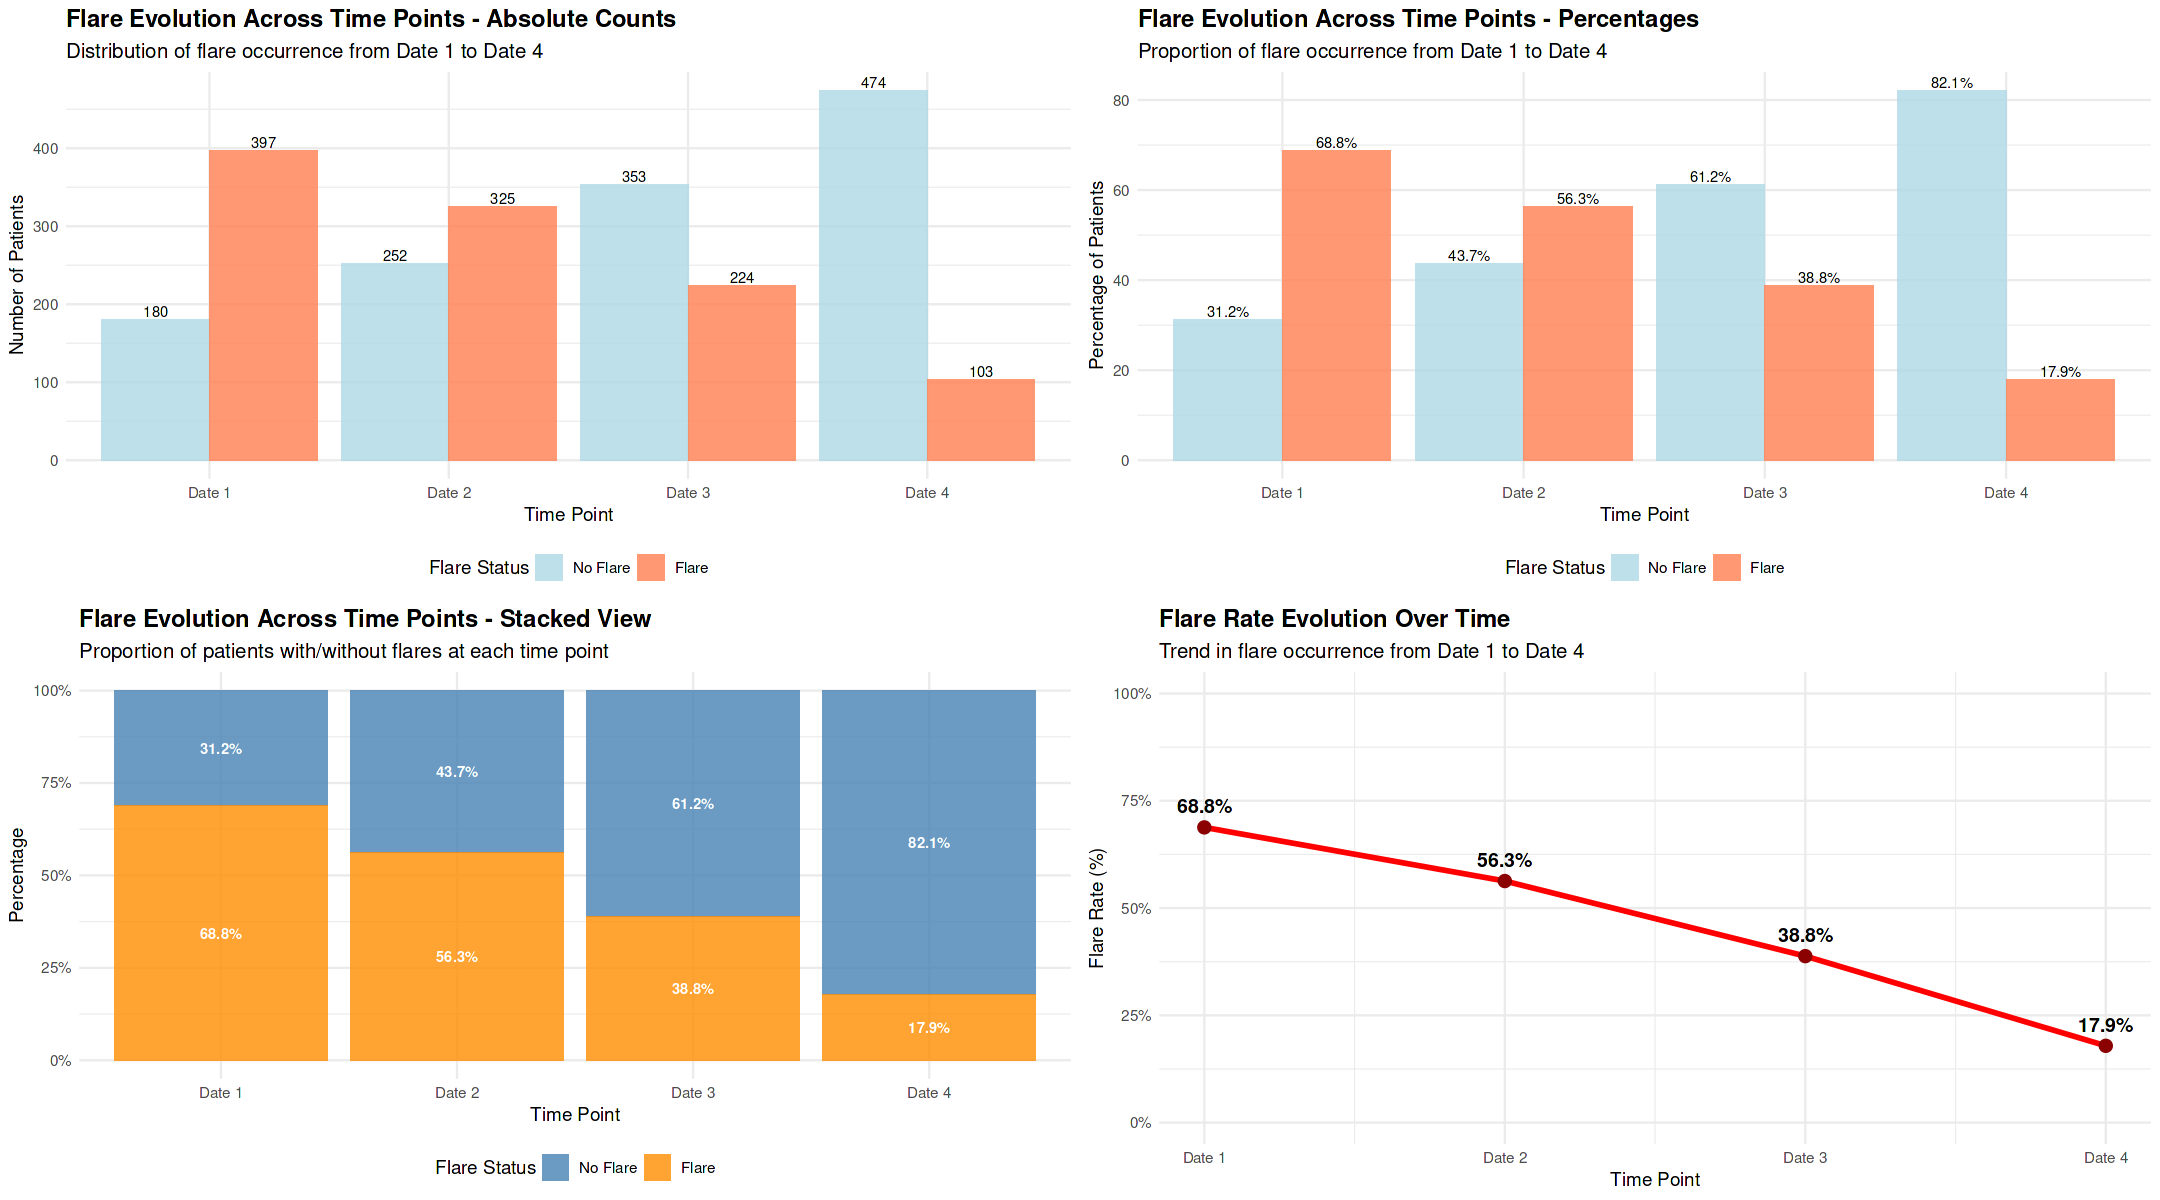

In [485]:
# ===============================================================================
# 1. DEPENDENT VARIABLES ANALYSIS
# ===============================================================================

options(repr.plot.width=18, repr.plot.height=10)

# Define dependent variables
dependent_vars <- c("flare_date1", "flare_date2", "flare_date3", "flare_date4")

print("=== DEPENDENT VARIABLES ANALYSIS ===")

# Summary of flare variables
flare_summary <- combined_dataset %>%
  dplyr::select(all_of(dependent_vars)) %>%
  dplyr::summarise(across(
    everything(),
    list(
      count_1 = ~sum(. == 1, na.rm = TRUE),
      count_0 = ~sum(. == 0, na.rm = TRUE),
      prop_1 = ~mean(. == 1, na.rm = TRUE),
      missing = ~sum(is.na(.))
    ),
    .names = "{.col}_{.fn}"
  ))

# Prepare flare evolution data
flare_evolution_data <- combined_dataset %>%
  dplyr::select(all_of(dependent_vars)) %>%
  pivot_longer(
    cols = everything(), 
    names_to = "flare_timepoint", 
    values_to = "flare_status"
  ) %>%
  filter(!is.na(flare_status)) %>%
  mutate(
    flare_timepoint = factor(
      flare_timepoint, 
      levels = dependent_vars,
      labels = c("Date 1", "Date 2", "Date 3", "Date 4")
    ),
    flare_status = factor(
      flare_status, 
      levels = c(0, 1),
      labels = c("No Flare", "Flare")
    )
  ) %>%
  group_by(flare_timepoint, flare_status) %>%
  summarise(count = n(), .groups = "drop") %>%
  group_by(flare_timepoint) %>%
  mutate(
    total = sum(count),
    percentage = round(count / total * 100, 1)
  )

# === Plot 1: Absolute Count ===
flare_evolution_plot_counts <- ggplot(flare_evolution_data, 
                                      aes(x = flare_timepoint, y = count, fill = flare_status)) +
  geom_bar(stat = "identity", position = "dodge", alpha = 0.8) +
  geom_text(aes(label = count), 
            position = position_dodge(width = 0.9), 
            vjust = -0.25, size = 3) +
  scale_fill_manual(values = c("No Flare" = "lightblue", "Flare" = "coral")) +
  labs(title = "Flare Evolution Across Time Points - Absolute Counts",
       subtitle = "Distribution of flare occurrence from Date 1 to Date 4",
       x = "Time Point", 
       y = "Number of Patients",
       fill = "Flare Status") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 12),
    legend.position = "bottom"
  )

# === Plot 2: Percentage ===
flare_evolution_plot_pct <- ggplot(flare_evolution_data, 
                                   aes(x = flare_timepoint, y = percentage, fill = flare_status)) +
  geom_bar(stat = "identity", position = "dodge", alpha = 0.8) +
  geom_text(aes(label = paste0(percentage, "%")), 
            position = position_dodge(width = 0.9), 
            vjust = -0.25, size = 3) +
  scale_fill_manual(values = c("No Flare" = "lightblue", "Flare" = "coral")) +
  labs(title = "Flare Evolution Across Time Points - Percentages",
       subtitle = "Proportion of flare occurrence from Date 1 to Date 4",
       x = "Time Point", 
       y = "Percentage of Patients",
       fill = "Flare Status") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 12),
    legend.position = "bottom"
  )

# === Plot 3: Stacked View ===
flare_evolution_plot_stacked <- ggplot(flare_evolution_data, 
                                       aes(x = flare_timepoint, y = percentage, fill = flare_status)) +
  geom_bar(stat = "identity", position = "stack", alpha = 0.8) +
  geom_text(aes(label = paste0(percentage, "%")), 
            position = position_stack(vjust = 0.5), 
            size = 3, color = "white", fontface = "bold") +
  scale_fill_manual(values = c("No Flare" = "steelblue", "Flare" = "darkorange")) +
  scale_y_continuous(labels = function(x) paste0(x, "%")) +
  labs(title = "Flare Evolution Across Time Points - Stacked View",
       subtitle = "Proportion of patients with/without flares at each time point",
       x = "Time Point", 
       y = "Percentage",
       fill = "Flare Status") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 12),
    legend.position = "bottom"
  )

# === Plot 4: Line Plot ===
flare_rates <- flare_evolution_data %>%
  filter(flare_status == "Flare") %>%
  mutate(timepoint_numeric = as.numeric(flare_timepoint))

flare_evolution_line <- ggplot(flare_rates, aes(x = timepoint_numeric, y = percentage)) +
  geom_line(color = "red", size = 1.2) +
  geom_point(color = "darkred", size = 3) +
  geom_text(aes(label = paste0(percentage, "%")), 
            vjust = -1, size = 4, fontface = "bold") +
  scale_x_continuous(breaks = 1:4, labels = c("Date 1", "Date 2", "Date 3", "Date 4")) +
  scale_y_continuous(labels = function(x) paste0(x, "%"), limits = c(0, 100)) +
  labs(title = "Flare Rate Evolution Over Time",
       subtitle = "Trend in flare occurrence from Date 1 to Date 4",
       x = "Time Point", 
       y = "Flare Rate (%)") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 12)
  )

# === Display All Plots ===
grid.arrange(
  flare_evolution_plot_counts, flare_evolution_plot_pct, 
  flare_evolution_plot_stacked, flare_evolution_line,
  ncol = 2
)

# === Summary Table ===
cat("\nFlare evolution summary:")
flare_summary_table <- flare_evolution_data %>%
  dplyr::select(flare_timepoint, flare_status, count, percentage) %>%
  pivot_wider(
    names_from = flare_status, 
    values_from = c(count, percentage),
    names_sep = "_"
  ) %>%
  arrange(flare_timepoint)

flare_summary_table
cat("\n\n")

# 3. Model Building

## 3.1 Feature extraction:


In [486]:
# Set dataset parameters
#=========================
## 1. Create data matrix for independent variables 
### one-hotmatrix
model_matrix <- model.matrix(~ . , data = combined_dataset)

## 2. Dependent variable
# ---------------------------
y1 <- as.numeric(model_matrix[,2])  # Convert y from factor to numeric
y1 <- ifelse(y1 == 1, -1, 1) # Convert y from {1, 2} to {-1, 1}

y2 <- as.numeric(model_matrix[,3])  # Convert y from factor to numeric
y2 <- ifelse(y2 == 1, -1, 1) # Convert y from {1, 2} to {-1, 1}

y3 <- as.numeric(model_matrix[,4])  # Convert y from factor to numeric
y3 <- ifelse(y3 == 1, -1, 1) # Convert y from {1, 2} to {-1, 1}

y4 <- as.numeric(model_matrix[,5])  # Convert y from factor to numeric
y4 <- ifelse(y4 == 1, -1, 1) # Convert y from {1, 2} to {-1, 1}

## 3. independent blocs
model_matrix <- as.data.frame(model_matrix) %>%
    dplyr::select(-ends_with("NA"),-ends_with("9999")) %>%
    as.matrix()


X <- model_matrix[, -c(1:5)]# exclude "(Intercept)" , FlaresYes, and MIAH_pain from predictors
column_names <- colnames(X)
print(column_names)


 [1] "DiseaseEntityUC"                   "genderFemale"                     
 [3] "bmi"                               "age_at_inclusion"                 
 [5] "montreal_extent_uc2&3"             "montreal_severity_uc1&2"          
 [7] "montreal_severity_uc3"             "montreal_location_cd1"            
 [9] "montreal_age_diagnosis_uc> median" "surg_ileo_anal_pouch1"            
[11] "surg_small_bowel_resection1"       "surg_ileocaecal_resection1"       
[13] "surg_small_bowel_stoma1"           "number_of_surgeries> 1"           
[15] "age_at_surg_ileo_anal_pouch"       "age_at_surg_small_bowel_resection"
[17] "age_at_surg_ileocaecal_resection"  "age_at_surg_small_bowel_stoma"    
[19] "age_at_surg_colostoma"             "age_at_surg_stenoplasty"          
[21] "History_colitis1"                  "History_crohn1"                   
[23] "Anxious_mean"                      "Depression_mean"                  
[25] "Fatigue_mean"                      "MIAH_pain_mean"                   

The dependent variable (DV) is `Flares` and four groups of independent variables identified by their indices: `Baseline` ( from 1 to 16) , `psychosocial` (from 17 to 20),  `lifestyle` (from 21 to 23), `Medication`  (from 24 to 28):

**Baseline:**                        
      
 1 "DiseaseEntityUC"                  
 2  "genderFemale"                      
 3 "montreal_extent_uc2"              
4 "montreal_extent_uc3"               
 5"montreal_severity_uc1"             
 6 "montreal_severity_uc2"            
7 "montreal_severity_uc3"             
 8 "montreal_location_cd1"             
 9 "montreal_age_diagnosis_uc> median"
10 "surg_ileo_anal_pouch1"             
11 "surg_small_bowel_resection1"       
12 "surg_ileocaecal_resection1"       
13 "surg_small_bowel_stoma1"           
14 "number_of_surgeries"               
15 "History_colitis1"                 
16 "History_crohn1" 

**psychosocial:**  

17 "Anxious_mean"                      
18 "Depression_mean"                  
19 "Fatigue_mean> median"              
20 "MIAH_pain_mean> median" 
 
 **lifestyle Statistics:**  
 
21"smoker2"
22"smoker3"
23"smoker4"

**Medication:**

24 "used_Vedolizumab1"                
25 "used_Tofacitinib1" 
26 "used_Mesalazine_oraal1"            
27 "total_medication> mean"           
28 "total_medication_period"   

## 3.2  Split data into training (70%) and test (30%) sets

Training set (e.g. 70%)
Test set (e.g. 30%)




In [487]:
# 1  Split data into training (0%) and test (30%) sets
set.seed(123) # For reproducibility
n <- length(y1)
train_indices <- sample(1:n, size = round(0.7 * n))
test_indices <- setdiff(1:n, train_indices)

# Training data
X_train <- X[train_indices, ]
y1_train <- y1[train_indices]
y2_train <- y2[train_indices]
y3_train <- y3[train_indices]
y4_train <- y4[train_indices]

# Test data
X_test <- X[test_indices, ]
y1_test <- y1[test_indices]
y2_test <- y2[test_indices]
y3_test <- y3[test_indices]
y4_test <- y4[test_indices]

cat("Training set size:", length(y1_train), "\n")
cat("Test set size:", length(y1_test), "\n")



Training set size: 404 
Test set size: 173 


## 3.3 Prepare Blocks

In [488]:
## 2. Create data matrices for independent variables (training set)
x1_train <- as.matrix(X_train[, c(1:22,29:35)]) # Baseline characteristics only
x2_train <- as.matrix(X_train[, c(1:22,29:35, 23:26)]) # Baseline + psychosocial
x3_train <- as.matrix(X_train[, c(1:22,29:35, 23:26, 27:28)]) # Baseline + psychosocial + lifestyle
x4_train <- as.matrix(X_train[, 23:26]) # Psychosocial only
x5_train <- as.matrix(X_train[, 27:28]) # Lifestyle only

## 3. Create data matrices for independent variables (test set)
x1_test <- as.matrix(X_test[, c(1:22,29:35)]) 
x2_test <- as.matrix(X_test[, c(1:22,29:35, 23:26)])
x3_test <- as.matrix(X_test[, c(1:22,29:35, 23:26, 27:28)])
x4_test <- as.matrix(X_test[, 23:26])
x5_test <- as.matrix(X_test[, 27:28])

## 4. Define group indices for each model
group_indices1 <- rep(1, 29)
group_indices2 <- c(rep(1, 29), rep(2, 4))
group_indices3 <- c(rep(1, 29), rep(2, 4), rep(3, 2))
group_indices4 <- rep(1, 4)
group_indices5 <- rep(1, 2)
 


## 3.4 Model Functions

In [489]:
# Function to perform cross-validation and collect AUC values for each fold using parallel processing

# Function to perform cross-validation and collect AUC values for each fold
cv_gglasso_collect_auc <- function(x, y_input, group_indices, loss = "logit", nfolds = 10, seed = 123) {
  # Set global seed for reproducibility
  set.seed(seed)
  
  n <- length(y_input)

    # Create consistent fold assignments
  fold_indices <- createFolds(factor(y_input), k = nfolds, list = FALSE)
  
   # More conservative lambda sequence
  lambda_max <- max(abs(t(x) %*% y_input)) / n
  lambda_seq <- exp(seq(log(lambda_max), log(lambda_max * 0.001), length.out = 150))
  
  # Perform CV with fixed seed
  set.seed(seed)
  cvfit <- cv.gglasso(x = x, y = y_input, group = group_indices, loss = loss,
                      lambda = lambda_seq, nfolds = nfolds, foldid = fold_indices)
  
  best_lambda <- cvfit$lambda.min
  # best_lambda <- cvfit$lambda.1se
  
  # Count selected variables
  coef_mat <- coef(cvfit$gglasso.fit)
  selected_counts <- sapply(1:ncol(coef_mat), function(i) {
    sum(coef_mat[-1, i] != 0)
  })
  
  # Create visualization data
  df <- data.frame(
    log_lambda = log(cvfit$lambda),
    cvm = cvfit$cvm,
    cvsd = cvfit$cvsd,
    selected_vars = selected_counts
  )
  # Improved plotting
  n_points <- length(cvfit$lambda)
  step_size <- max(1, floor(n_points / 10))
  subset_indices <- unique(c(1, seq(1, n_points, by = step_size), n_points))
  
  selected_log_lambda <- log(cvfit$lambda[subset_indices])
  selected_var_counts <- selected_counts[subset_indices]
  
  p <- ggplot(df, aes(x = log_lambda, y = cvm)) +
    geom_errorbar(aes(ymin = cvm - cvsd, ymax = cvm + cvsd), width = 0.1, color = "gray") +
    geom_point(color = "blue", size = 2) +
    geom_vline(xintercept = log(best_lambda), linetype = "dashed", color = "red") +
    geom_vline(xintercept = log(cvfit$lambda.1se), linetype = "dotted", color = "orange") +
    scale_x_continuous(
      name = "log(lambda)",
      sec.axis = sec_axis(
        transform = ~.,
        name = "Number of selected variables",
        breaks = selected_log_lambda,
        labels = selected_var_counts
      )
    ) +
    ylab("Cross-validated loss") +
    theme_bw() +
    ggtitle("Cross-validation Curve with Selected Variable Count") +
    theme(
      axis.text.x = element_text(size = 12),
      axis.text.x.top = element_text(size = 10, angle = 45, hjust = 0),
      axis.text.y = element_text(size = 12),
      axis.title = element_text(size = 14),
      plot.title = element_text(size = 16, face = "bold")
    )
  options(repr.plot.width=18, repr.plot.height=5)
  print(p)
  
  # Compute fold AUCs with consistent seeding
  fold_aucs <- sapply(1:nfolds, function(i) {
    train_idx <- which(fold_indices != i)
    test_idx <- which(fold_indices == i)

    # Use consistent seed for each fold
    set.seed(seed * 100 + i)
    model <- gglasso(x = x[train_idx, , drop = FALSE],
                     y = y_input[train_idx],
                     group = group_indices,
                     loss = loss,
                     lambda = best_lambda)
    
    # Get predictions
    linear_pred <- predict(model, newx = x[test_idx, , drop = FALSE], type = "link")
    probs <- plogis(linear_pred)
    
    # Convert y to binary for AUC calculation
    y_test_bin <- ifelse(y_input[test_idx] == -1, 0, 1)
    
    # Calculate AUC
    if(length(unique(y_test_bin)) < 2) {
      return(0.5)  # Return 0.5 if no variation in y
    }
      

    suppressMessages(suppressWarnings(
      auc_val <- auc(roc(y_test_bin, as.vector(probs), quiet = TRUE))
    ))
    return(as.numeric(auc_val))
  })

  # Calculate statistics
  mean_auc <- mean(fold_aucs, na.rm = TRUE)
  sd_auc <- sd(fold_aucs, na.rm = TRUE)
  margin <- qt(0.975, df = sum(!is.na(fold_aucs)) - 1) * sd_auc / sqrt(sum(!is.na(fold_aucs)))
  
  # Fit final model
  set.seed(seed)
  final_model <- gglasso(x = x, y = y_input, group = group_indices, loss = loss, lambda = best_lambda)
  
  return(list(
    fold_auc_values = fold_aucs,
    mean_auc = mean_auc,
    sd_auc = sd_auc,
    margin = margin,
    ci_lower = mean_auc - margin,
    ci_upper = mean_auc + margin,
    model = final_model,
    lambda = best_lambda,
    lambda_1se = cvfit$lambda.1se,
    selected_variable_count = sum(coef(final_model)[-1] != 0),
    cvfit = cvfit
  ))
}

combine_gglasso_coefficients <- function(cv_results_list) {
  # Step 1: Extract coefficients per model
  coefs_list <- lapply(cv_results_list, function(res) coef(res$model))

  # Step 2: Convert each to a tibble with named columns
  coef_dfs <- mapply(function(coefs, name) {
    tibble(
      Variable = rownames(coefs),
      !!name := round(coefs, 4)
    )
  }, coefs_list, names(coefs_list), SIMPLIFY = FALSE)

  # Step 3: Merge all into one dataframe by Variable
  coefs_combined <- Reduce(function(x, y) full_join(x, y, by = "Variable"), coef_dfs)

  # Step 4: Replace NAs with 0s, then 0s with empty strings
  coefs_cleaned <- coefs_combined %>%
    replace(is.na(.), 0) %>%
    mutate(across(-Variable, ~ ifelse(. == 0, "", .)))

  return(coefs_cleaned)
}

# Function to calculate metrics 
calculate_metrics <- function(actual, predicted) {
    confusion_matrix <- table(factor(actual), factor(predicted))
    
    sensitivity <- confusion_matrix[2,2] / sum(confusion_matrix[2,])   # True Positives / (True Positives + False Negatives)
    specificity <- confusion_matrix[1,1] / sum(confusion_matrix[1,])   # True Negatives / (True Negatives + False Positives)
    ppv <- confusion_matrix[2,2] / sum(confusion_matrix[,2])            # True Positives / (True Positives + False Positives)
    npv <- confusion_matrix[1,1] / sum(confusion_matrix[,1])            # True Negatives / (True Negatives + False Negatives)
    
    return(c(Sensitivity = sensitivity,
             Specificity = specificity,
             PPV = ppv,
             NPV = npv))
}

# Function to compute performance metrics
library(pROC)

compute_metrics <- function(model, x_test, y_test, seed = 123) {
  set.seed(seed)

  # Predict log-odds and convert to probabilities using plogis
  predicted_probs <- plogis(as.vector(predict(model, newx = x_test, type = "link")))

  # Convert true labels to binary 0/1
  y_binary <- ifelse(y_test == -1, 0, 1)

  # Compute ROC curve (suppress messages)
  roc_curve <- roc(response = y_binary, predictor = predicted_probs, quiet = TRUE)

  # Get optimal threshold using Youden's J statistic
  # Manual calculation if coords() is problematic
  thresholds <- roc_curve$thresholds
  sensitivities <- roc_curve$sensitivities
  specificities <- roc_curve$specificities
  
  # Calculate Youden's J statistic (sensitivity + specificity - 1)
  youden_j <- sensitivities + specificities - 1
  
  # Find the threshold that maximizes Youden's J
  optimal_index <- which.max(youden_j)
  optimal_threshold <- thresholds[optimal_index]

  # Convert probabilities to predicted classes using optimal threshold
  predicted_classes <- ifelse(predicted_probs > optimal_threshold, 1, 0)

  # Accuracy
  accuracy <- mean(predicted_classes == y_binary)

  # AUC
  auc_value <- auc(roc_curve)

  # Your custom metric function (assumed pre-defined)
  metrics_model <- calculate_metrics(y_binary, predicted_classes)

  return(list(
    accuracy = accuracy,
    auc = auc_value,
    optimal_threshold = optimal_threshold,
    roc_curve = roc_curve,
    metrics = metrics_model
  ))
}



## 3.5 Models for flares_date1
### 3.5.1 Training

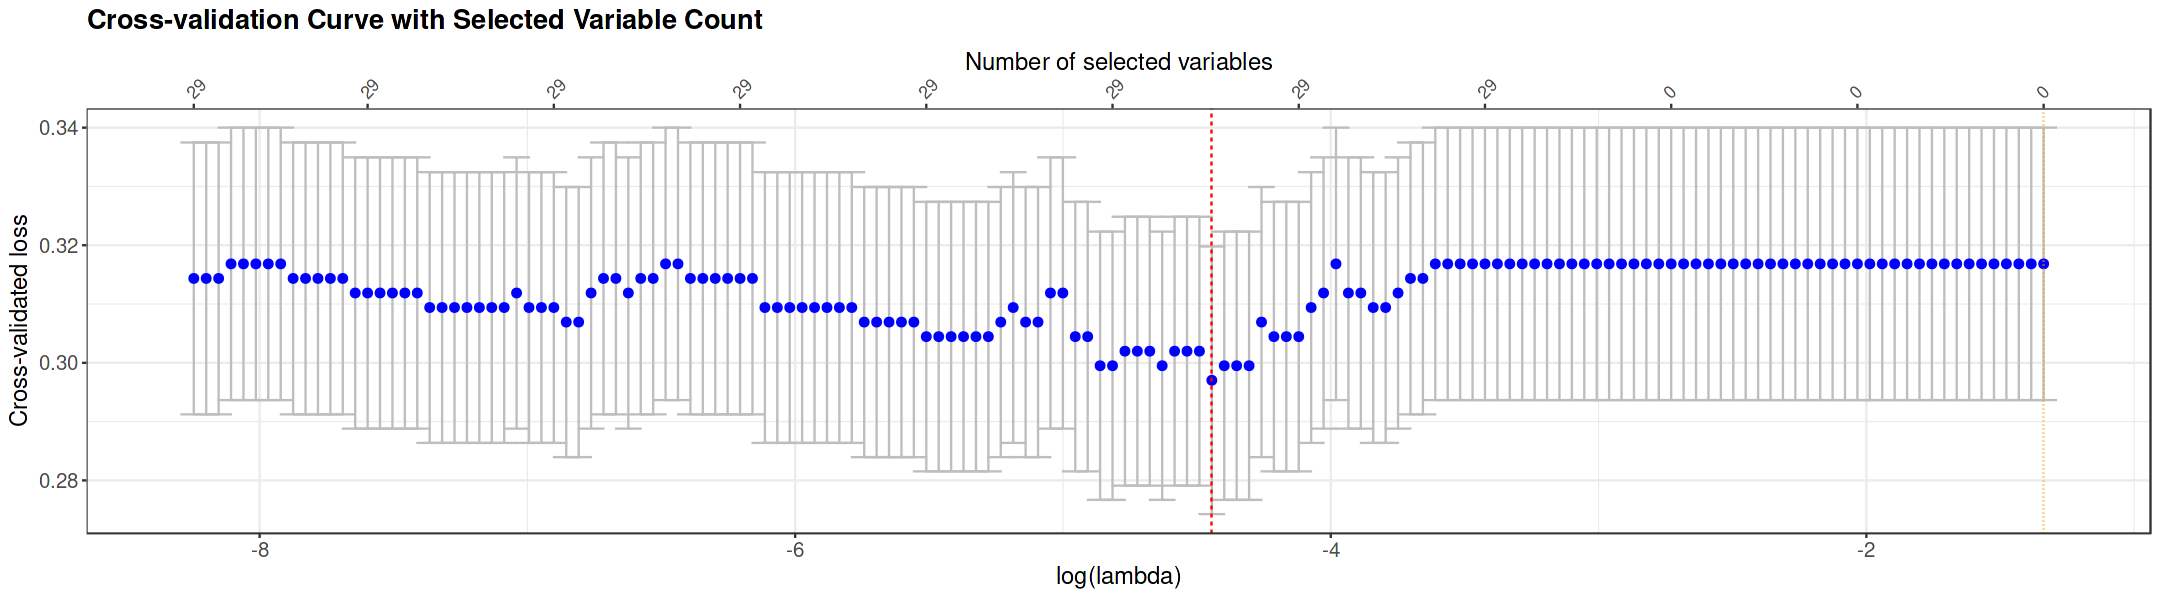

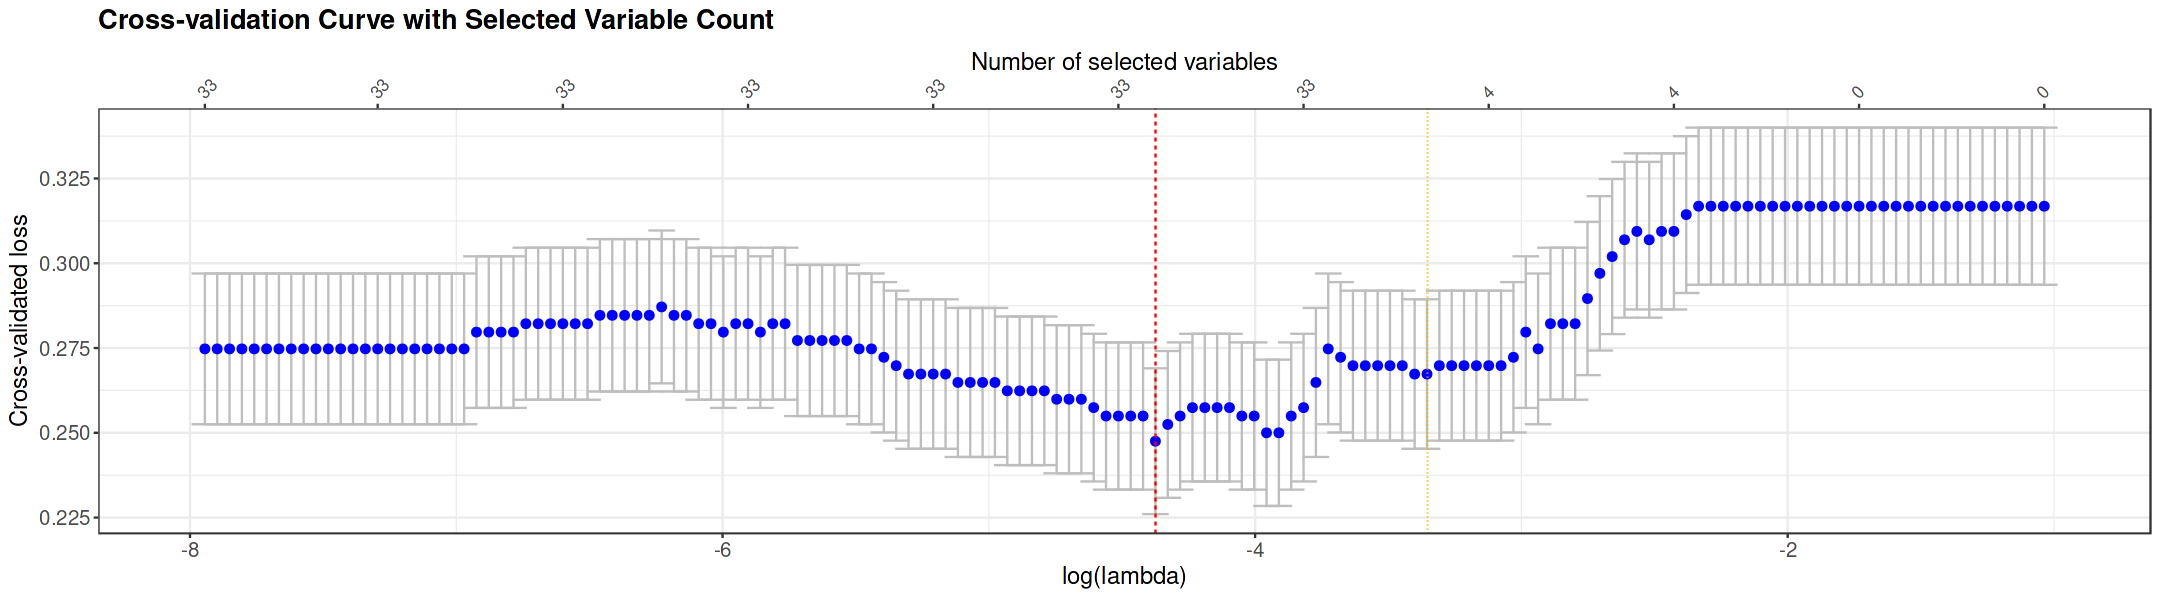

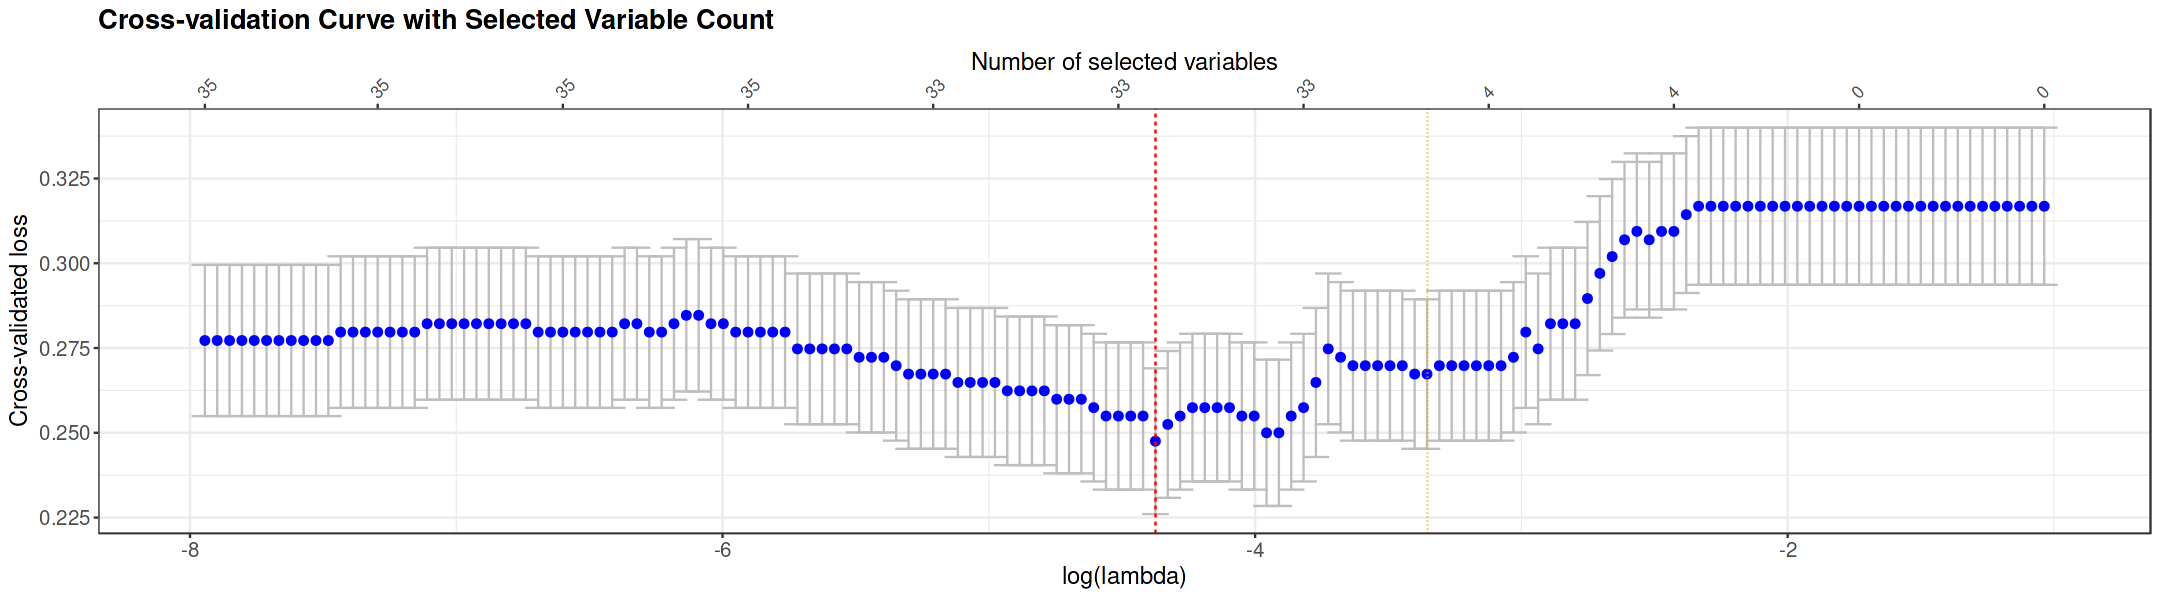

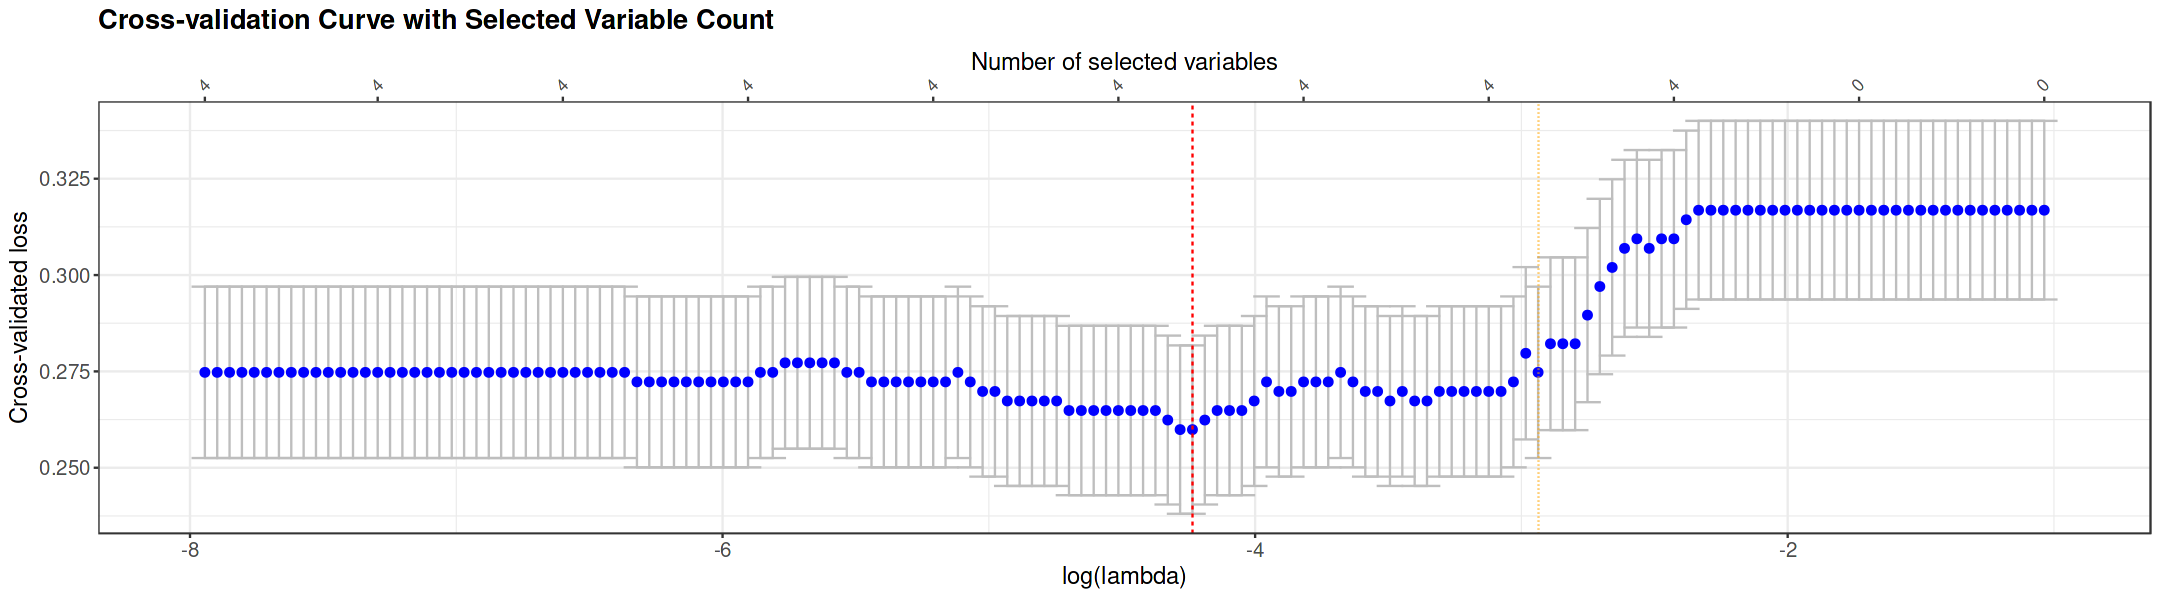

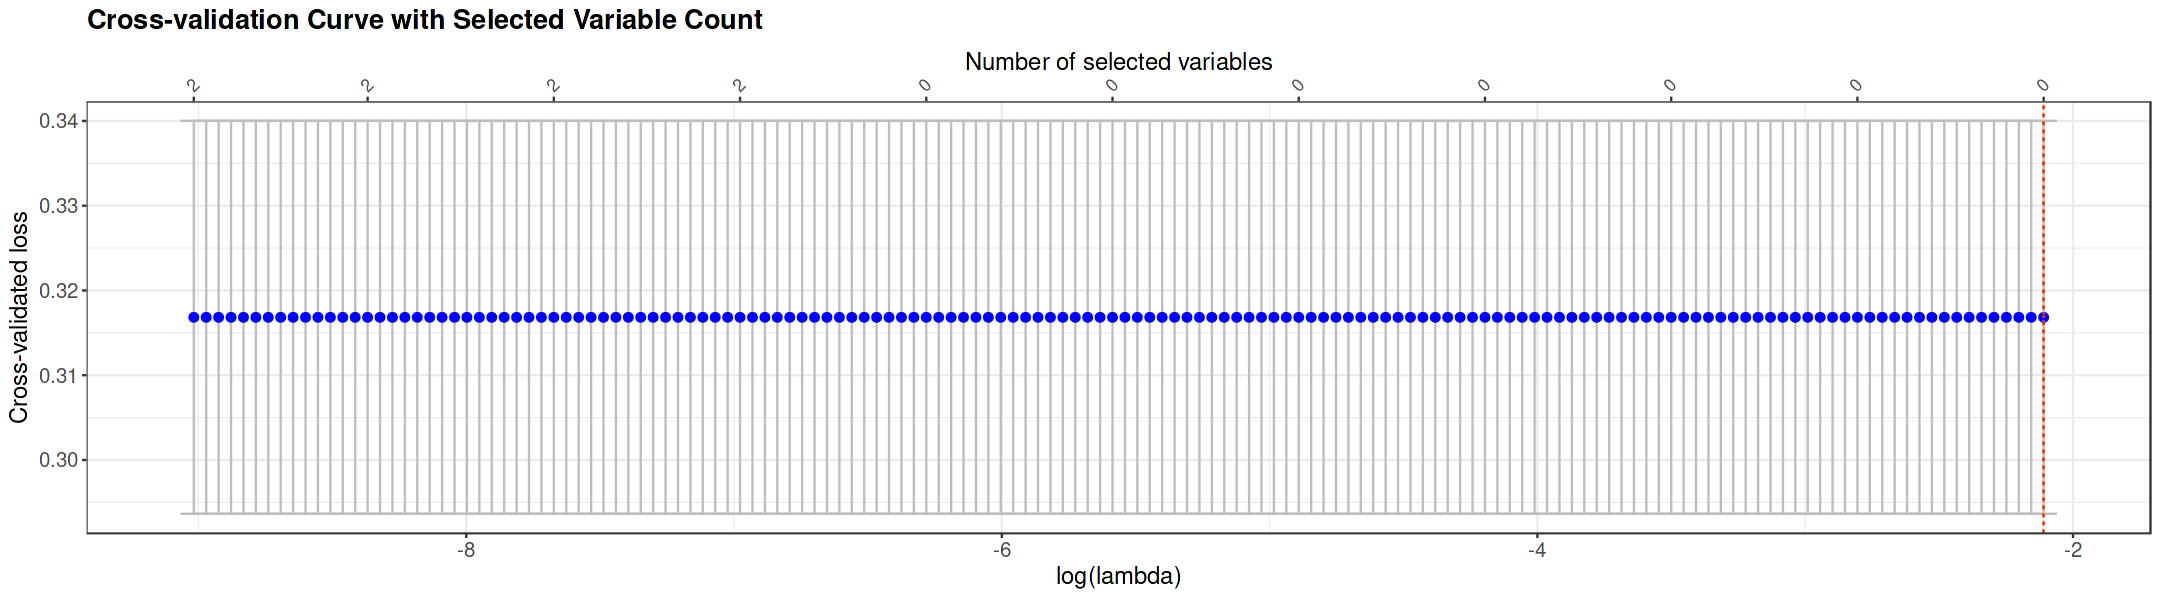

In [490]:
set.seed(123)
cv1_results1 <- cv_gglasso_collect_auc(x1_train, y1_train, group_indices1, seed = 123)
set.seed(123)
cv1_results2 <- cv_gglasso_collect_auc(x2_train, y1_train, group_indices2, seed = 123)
set.seed(123)
cv1_results3 <- cv_gglasso_collect_auc(x3_train, y1_train, group_indices3, seed = 123)
set.seed(123)
cv1_results4 <- cv_gglasso_collect_auc(x4_train, y1_train, group_indices4, seed = 123)
set.seed(123)
cv1_results5 <- cv_gglasso_collect_auc(x5_train, y1_train, group_indices5, seed = 123)

In [491]:
# Print cross-validation results with confidence intervals
cat("\n--- Cross-Validation Results for y1 (on Training Set) ---\n")
cat("Model 1: Baseline characteristics only - AUC:", round(cv1_results1$mean_auc, 3), 
    "95% CI: [", round(cv1_results1$ci_lower, 3), "-", round(cv1_results1$ci_upper, 3), "]\n")
cat("Model 2: BaseLine + Psychosocial - AUC:", round(cv1_results2$mean_auc, 3), 
    "95% CI: [", round(cv1_results2$ci_lower, 3), "-", round(cv1_results2$ci_upper, 3), "]\n")
cat("Model 3: BaseLine + Psychosocial + Lifestyle - AUC:", round(cv1_results3$mean_auc, 3), 
    "95% CI: [", round(cv1_results3$ci_lower, 3), "-", round(cv1_results3$ci_upper, 3), "]\n")
cat("Model 4: Psychosocial only - AUC:", round(cv1_results4$mean_auc, 3), 
    "95% CI: [", round(cv1_results4$ci_lower, 3), "-", round(cv1_results4$ci_upper, 3), "]\n")
cat("Model 5: Lifestyle only - AUC:", round(cv1_results5$mean_auc, 3), 
    "95% CI: [", round(cv1_results5$ci_lower, 3), "-", round(cv1_results5$ci_upper, 3), "]\n")

len_model1_y1 <- cv1_results1$selected_variable_count
len_model2_y1 <- cv1_results2$selected_variable_count
len_model3_y1 <- cv1_results3$selected_variable_count
len_model4_y1 <- cv1_results4$selected_variable_count
len_model5_y1 <- cv1_results5$selected_variable_count


--- Cross-Validation Results for y1 (on Training Set) ---
Model 1: Baseline characteristics only - AUC: 0.649 95% CI: [ 0.58 - 0.717 ]
Model 2: BaseLine + Psychosocial - AUC: 0.766 95% CI: [ 0.729 - 0.802 ]
Model 3: BaseLine + Psychosocial + Lifestyle - AUC: 0.766 95% CI: [ 0.729 - 0.802 ]
Model 4: Psychosocial only - AUC: 0.745 95% CI: [ 0.704 - 0.785 ]
Model 5: Lifestyle only - AUC: 0.5 95% CI: [ 0.5 - 0.5 ]


In [492]:
cv_models <- list(
  `Model 1: BaseLine` = cv1_results1,
  `Model 2: BaseLine +Psychosocial` = cv1_results2,
  `Model 3: BaseLine+P+Lifestyle` = cv1_results3,
  `Model 4: Psychosocial` = cv1_results4,
  `Model 5: Lifestyle` = cv1_results5
)

coef_table <- combine_gglasso_coefficients(cv_models)
coef_table


Variable                         
X.Intercept.                      (Intercept)                      
DiseaseEntityUC                   DiseaseEntityUC                  
genderFemale                      genderFemale                     
bmi                               bmi                              
age_at_inclusion                  age_at_inclusion                 
montreal_extent_uc2.3             montreal_extent_uc2&3            
montreal_severity_uc1.2           montreal_severity_uc1&2          
montreal_severity_uc3             montreal_severity_uc3            
montreal_location_cd1             montreal_location_cd1            
montreal_age_diagnosis_uc..median montreal_age_diagnosis_uc> median
surg_ileo_anal_pouch1             surg_ileo_anal_pouch1            
surg_small_bowel_resection1       surg_small_bowel_resection1      
surg_ileocaecal_resection1        surg_ileocaecal_resection1       
surg_small_bowel_stoma1           surg_small_bowel_stoma1          
number_of_surgeries..1            number_of_surgeries> 1           
age_at_surg_ileo_anal_pouch       age_at_surg_ileo_anal_pouch      
age_at_surg_small_bowel_resection age_at_surg_small_bowel_resection
age_at_surg_ileocaecal_resection  age_at_surg_ileocaecal_resection 
age_at_surg_small_bowel_stoma     age_at_surg_small_bowel_stoma    
age_at_surg_colostoma             age_at_surg_colostoma            
age_at_surg_stenoplasty           age_at_surg_stenoplasty          
History_colitis1                  History_colitis1                 
History_crohn1                    History_crohn1                   
used_Vedolizumab1                 used_Vedolizumab1                
used_Tofacitinib1                 used_Tofacitinib1                
used_Mesalazine_oraal1            used_Mesalazine_oraal1           
total_medication_period           total_medication_period          
period_Mesalazine_oraal           period_Mesalazine_oraal          
period_Methotrexaat               period_Methotrexaat              
period_Sulfasalazine              period_Sulfasalazine             
X                                 Anxious_mean                     
X.1                               Depression_mean                  
X.2                               Fatigue_mean                     
X.3                               MIAH_pain_mean                   
X.4                               smokerEx-smoker                  
X.5                               smokerCurrent smoker             
                                  Model 1: BaseLine
X.Intercept.                      -0.7325          
DiseaseEntityUC                   -0.1088          
genderFemale                      0.0917           
bmi                               0.0839           
age_at_inclusion                  -0.0828          
montreal_extent_uc2.3             -0.111           
montreal_severity_uc1.2           -0.0873          
montreal_severity_uc3             0.0184           
montreal_location_cd1             0.0503           
montreal_age_diagnosis_uc..median -0.0721          
surg_ileo_anal_pouch1             0.0082           
surg_small_bowel_resection1       0.0157           
surg_ileocaecal_resection1        0.0591           
surg_small_bowel_stoma1           0.0211           
number_of_surgeries..1            0.0235           
age_at_surg_ileo_anal_pouch       0.0882           
age_at_surg_small_bowel_resection 0.0803           
age_at_surg_ileocaecal_resection  0.1721           
age_at_surg_small_bowel_stoma     0.1129           
age_at_surg_colostoma             0.0441           
age_at_surg_stenoplasty           0.033            
History_colitis1                  -0.027           
History_crohn1                    0.0219           
used_Vedolizumab1                 0.0198           
used_Tofacitinib1                 -0.0032          
used_Mesalazine_oraal1            -0.0337          
total_medication_period           0.018            
period_Mesalazine_oraal           -0.0772          
period_Met

### 3.5.2 Performance Evaluation

In [493]:
# ===== ANALYSIS FOR Y1 =====
cat("\n--- Cross-Validation Results for Y1 (on Testing Set) ---\n")

# Compute metrics for all models with y1
metrics_model1_y1 <- compute_metrics(model = cv1_results1$model, x = x1_test, y1_test)
metrics_model2_y1 <- compute_metrics(model = cv1_results2$model, x = x2_test, y1_test)
metrics_model3_y1 <- compute_metrics(model = cv1_results3$model, x = x3_test, y1_test)
metrics_model4_y1 <- compute_metrics(model = cv1_results4$model, x = x4_test, y1_test)
#metrics_model5_y1 <- compute_metrics(model = cv1_results5$model, x = x5_test, y1_test)

# Print performance metrics for Y1
cat("Model 1: Baseline characteristics only - Accuracy:", metrics_model1_y1$accuracy, "AUC:", metrics_model1_y1$auc, "  (95% CI: [", round(metrics_model1_y1$auc-cv1_results1$margin, 3), "-", round(metrics_model1_y1$auc+cv1_results1$margin, 3), "])\n")
cat("Model 2: BaseLine + Psychosocial - Accuracy:", metrics_model2_y1$accuracy, "AUC:", metrics_model2_y1$auc, " (95% CI: [", round(metrics_model2_y1$auc-cv1_results2$margin, 3), "-", round(metrics_model2_y1$auc+cv1_results2$margin, 3), "])\n")
cat("Model 3: BaseLine + Psychosocial + Lifestyle - Accuracy:", metrics_model3_y1$accuracy, "AUC:", metrics_model3_y1$auc,  " (95% CI: [", round(metrics_model3_y1$auc-cv1_results3$margin, 3), "-", round(metrics_model3_y1$auc+cv1_results3$margin, 3), "])\n")
cat("Model 4: Psychosocial only - Accuracy:", metrics_model4_y1$accuracy, "AUC:", metrics_model4_y1$auc,  " (95% CI: [", round(metrics_model4_y1$auc-cv1_results4$margin, 3), "-", round(metrics_model4_y1$auc+cv1_results4$margin, 3), "])\n")
#cat("Model 5: Lifestyle only - Accuracy:", metrics_model5_y1$accuracy, "AUC:", metrics_model5_y1$auc,   " (95% CI: [", round(metrics_model5_y1$auc-cv1_results5$margin, 3), "-", round(metrics_model5_y1$auc+cv1_results5$margin, 3), "])\n")



--- Cross-Validation Results for Y1 (on Testing Set) ---
Model 1: Baseline characteristics only - Accuracy: 0.6647399 AUC: 0.5727908   (95% CI: [ 0.504 - 0.641 ])
Model 2: BaseLine + Psychosocial - Accuracy: 0.6473988 AUC: 0.6816592  (95% CI: [ 0.645 - 0.719 ])
Model 3: BaseLine + Psychosocial + Lifestyle - Accuracy: 0.6473988 AUC: 0.6816592  (95% CI: [ 0.645 - 0.719 ])
Model 4: Psychosocial only - Accuracy: 0.6820809 AUC: 0.6685474  (95% CI: [ 0.628 - 0.709 ])


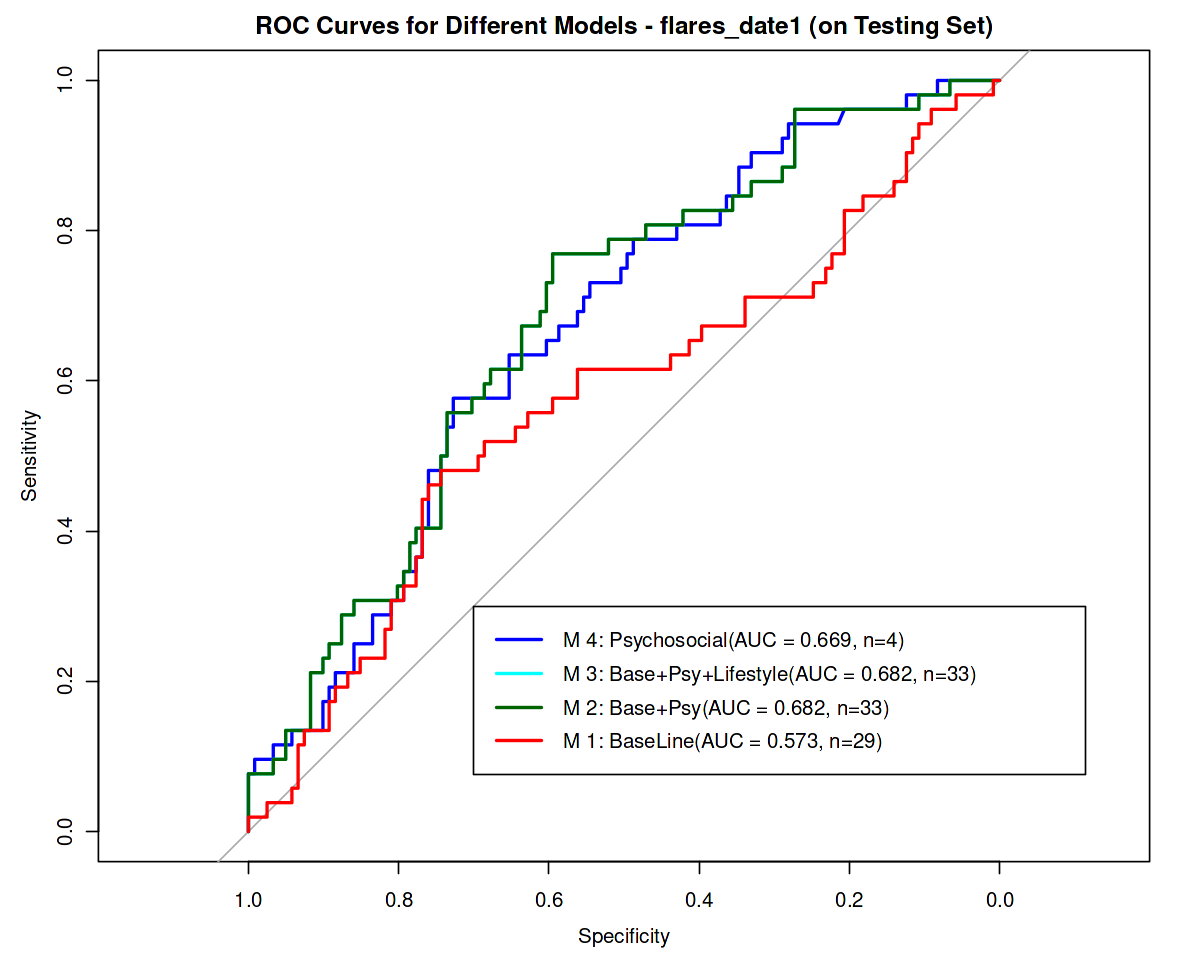

In [494]:
# Plot ROC Curves for All Models - Y1
roc_model1_y1 <- metrics_model1_y1$roc_curve
roc_model2_y1 <- metrics_model2_y1$roc_curve
roc_model3_y1 <- metrics_model3_y1$roc_curve
roc_model4_y1 <- metrics_model4_y1$roc_curve
#roc_model5_y1 <- metrics_model5_y1$roc_curve

# ROC plot for Y1
legend_labels_y1 <- c(
    paste0("M 4: Psychosocial(AUC = ", sprintf("%.3f", auc(roc_model4_y1)), ", n=",len_model4_y1,")"),
    paste0("M 3: Base+Psy+Lifestyle(AUC = ", sprintf("%.3f", auc(roc_model3_y1)), ", n=",len_model3_y1, ")"),
    paste0("M 2: Base+Psy(AUC = ", sprintf("%.3f", auc(roc_model2_y1)),  ", n=",len_model2_y1,")"),
    #paste0("M 5: Lifestyle(AUC = ", sprintf("%.3f", auc(roc_model5_y1)),  ", n=",len_model5_y1,")"),
    paste0("M 1: BaseLine(AUC = ", sprintf("%.3f", auc(roc_model1_y1)),  ", n=",len_model1_y1,")")
)

# Create ROC plot for Y1
options(repr.plot.width=10, repr.plot.height=8)
plot(roc_model4_y1, col = "blue", main = "ROC Curves for Different Models - flares_date1 (on Testing Set)")
plot(roc_model3_y1, col = "cyan", add = TRUE)
plot(roc_model2_y1, col = "darkgreen", add = TRUE)
#plot(roc_model5_y1, col = "cyan", add = TRUE)
plot(roc_model1_y1, col = "red", add = TRUE)
    
# Add legend
legend(x = 0.7, y = 0.3, 
        legend = legend_labels_y1,
        col = c("blue","cyan","darkgreen", "red"),
        lwd = 2)


In [495]:
# Create a results table for Y1
results_table_y1 <- data.frame(
    Model = c("Model 1: BaseLine", 
              "Model 2: BaseLine +Psychosocial", 
              "Model 3: BaseLine+P+Lifestyle", 
              "Model 4: Psychosocial"#,               
              #"Model 5: Lifestyle"
              ),
    Sensitivity = c(metrics_model1_y1$metrics[1],
                    metrics_model2_y1$metrics[1],
                    metrics_model3_y1$metrics[1],
                    metrics_model4_y1$metrics[1]#,
                    #metrics_model5_y1$metrics[1]
                    ),
    Specificity = c(metrics_model1_y1$metrics[2],
                    metrics_model2_y1$metrics[2],
                    metrics_model3_y1$metrics[2], 
                    metrics_model4_y1$metrics[2]#,
                    #metrics_model5_y1$metrics[2]
                    ),
    PPV = c(metrics_model1_y1$metrics[3],
            metrics_model2_y1$metrics[3],
            metrics_model3_y1$metrics[3], 
            metrics_model4_y1$metrics[3]#,
            #metrics_model5_y1$metrics[3]
            ),
    NPV = c(metrics_model1_y1$metrics[4],
            metrics_model2_y1$metrics[4],
            metrics_model3_y1$metrics[4],
            metrics_model4_y1$metrics[4]#,
            #metrics_model5_y1$metrics[4]
            )
)

# Print the results table for Y1
cat("Results Table for Y1:\n")
print(results_table_y1)


Results Table for Y1:
                            Model Sensitivity Specificity       PPV       NPV
1               Model 1: BaseLine   0.4807692   0.7438017 0.4464286 0.7692308
2 Model 2: BaseLine +Psychosocial   0.7692308   0.5950413 0.4494382 0.8571429
3   Model 3: BaseLine+P+Lifestyle   0.7692308   0.5950413 0.4494382 0.8571429
4           Model 4: Psychosocial   0.5769231   0.7272727 0.4761905 0.8000000


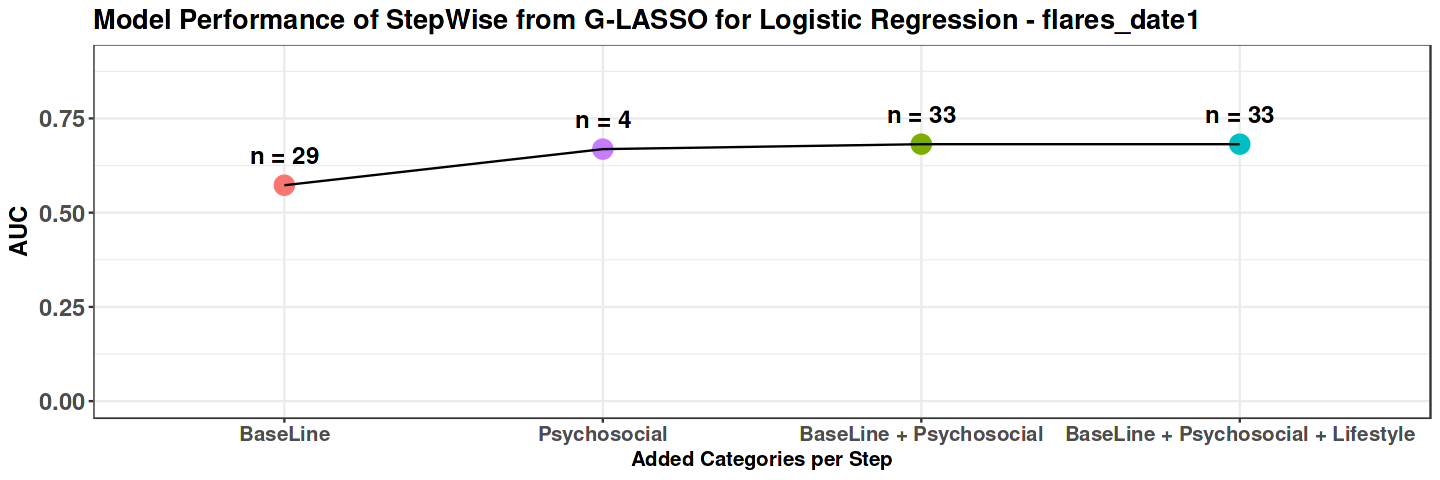

In [496]:
# Variable importance plot for Y1
variable_importance_y1 <- data.frame(
  Variable = c("BaseLine", 
               "BaseLine + Psychosocial", "BaseLine + Psychosocial + Lifestyle", 
               "Psychosocial"#, "Lifestyle"
               ),
  auc_values = c(metrics_model1_y1$auc,
                 metrics_model2_y1$auc, metrics_model3_y1$auc, metrics_model4_y1$auc
                 #, metrics_model5_y1$auc
                 ),
  n_vars = c(len_model1_y1, 
             len_model2_y1, len_model3_y1, len_model4_y1#, len_model5
             )
)

# Create Figure : Variable Importance Plot for Y1
options(repr.plot.width=12, repr.plot.height=4)
ggplot(variable_importance_y1, aes(x = reorder(Variable, auc_values), y = auc_values)) +
  geom_point(aes(color = Variable), size = 5) +
  geom_line(group = 1) +
  geom_text(aes(label = paste0("n = ", n_vars)), 
            vjust = -1.2, size = 5, fontface = "bold") +
    ylim(0, .9) +
  labs(title = "Model Performance of StepWise from G-LASSO for Logistic Regression - flares_date1",
       x = "Added Categories per Step",
       y = "AUC") +
  theme_bw() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 16, face = "bold"),
    axis.title.x = element_text(size = 12, face = "bold"),
    axis.title.y = element_text(size = 14, face = "bold"),
    axis.text.x = element_text(size = 12, face = "bold"),
    axis.text.y = element_text(size = 14, face = "bold")
  )


## 3.6 MODELS FOR flares_date2 
### 3.6.1 Training


=== MODELS FOR y2 ===


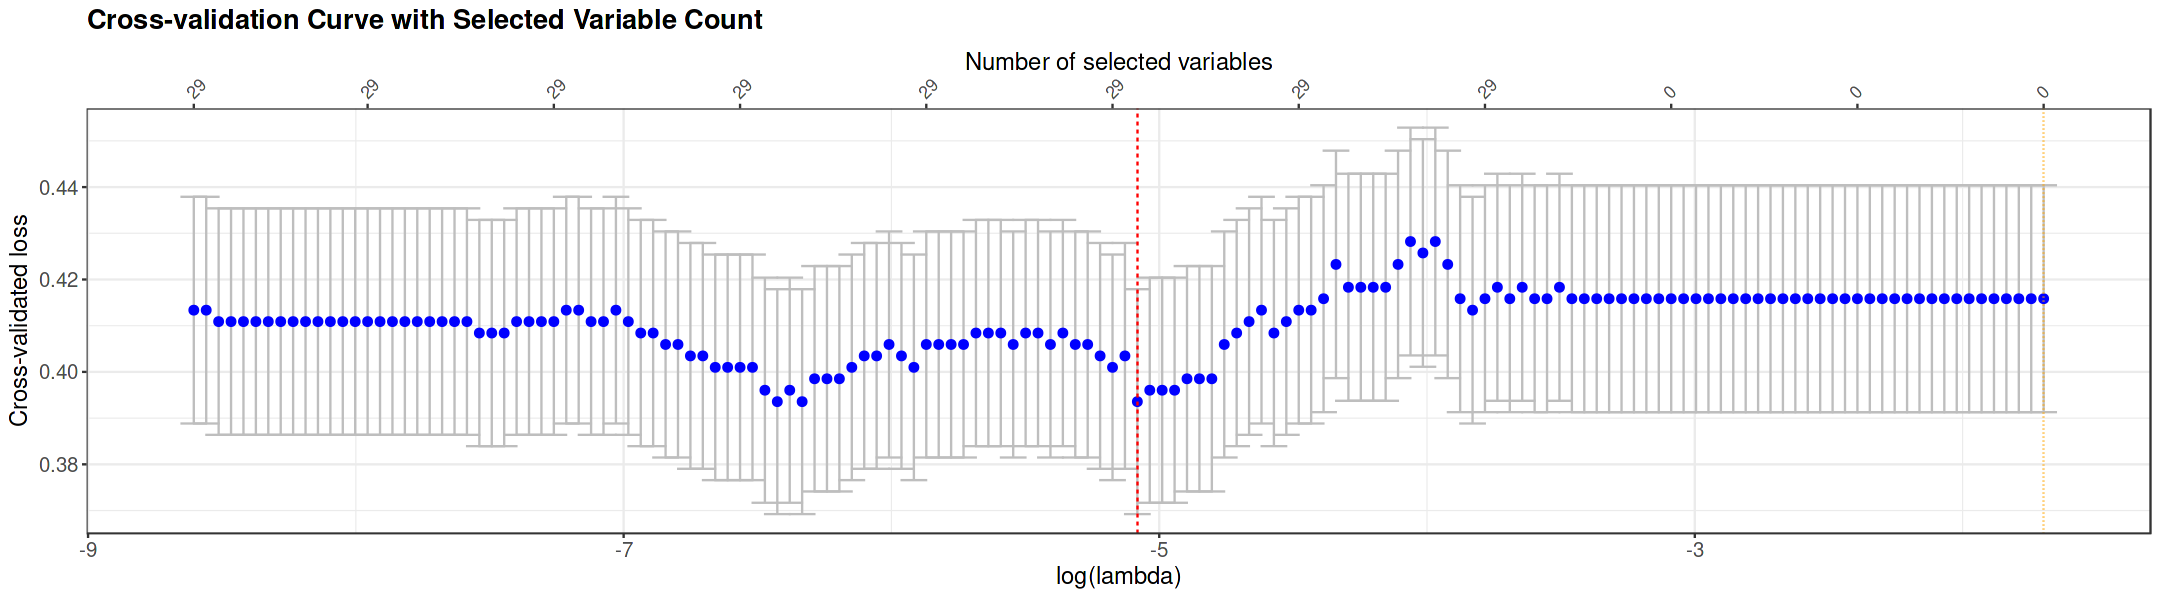

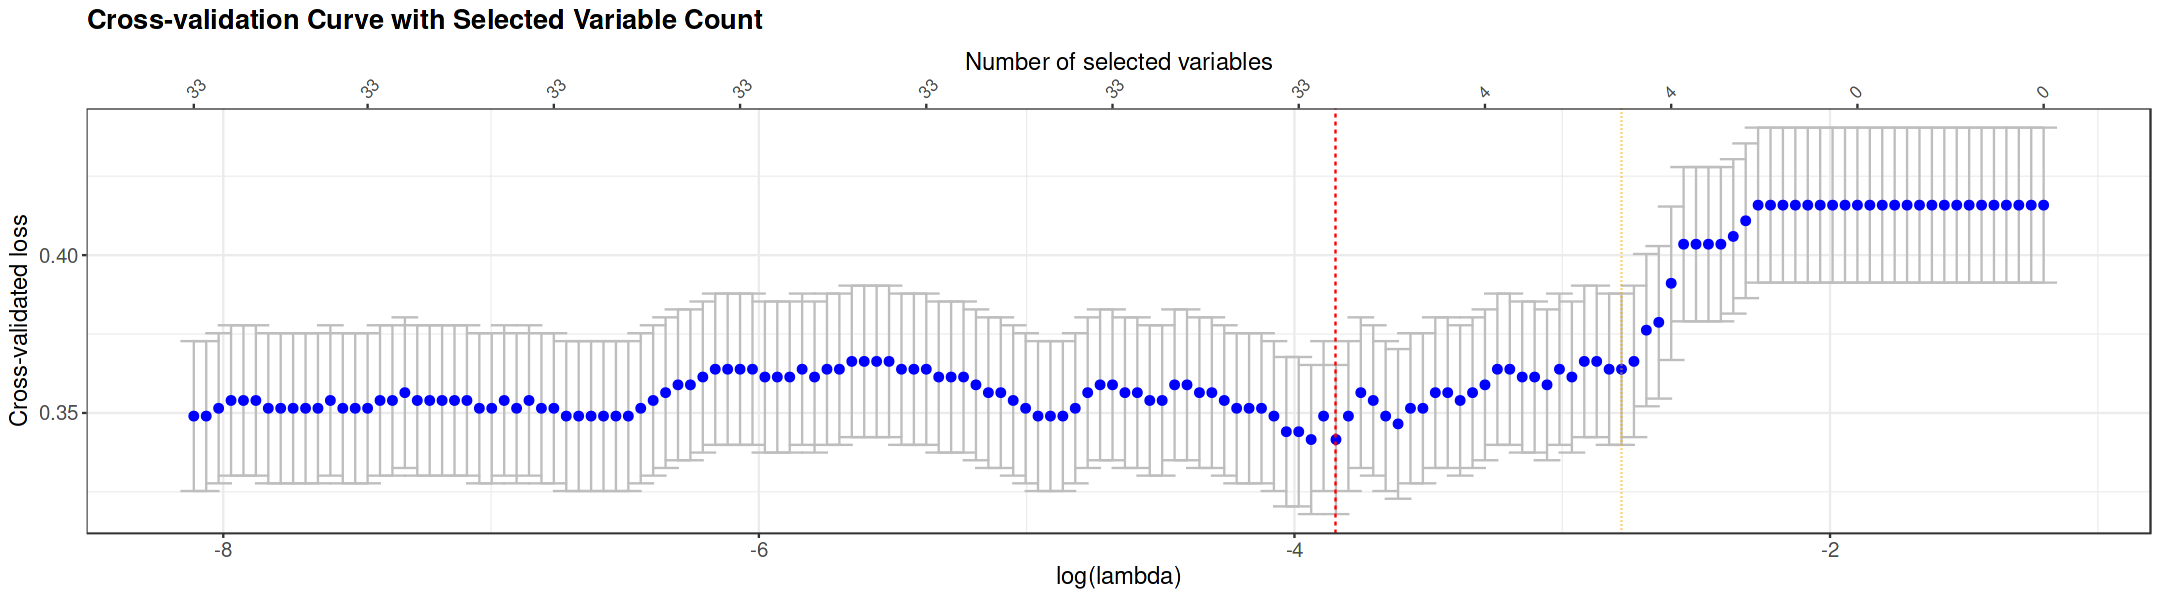

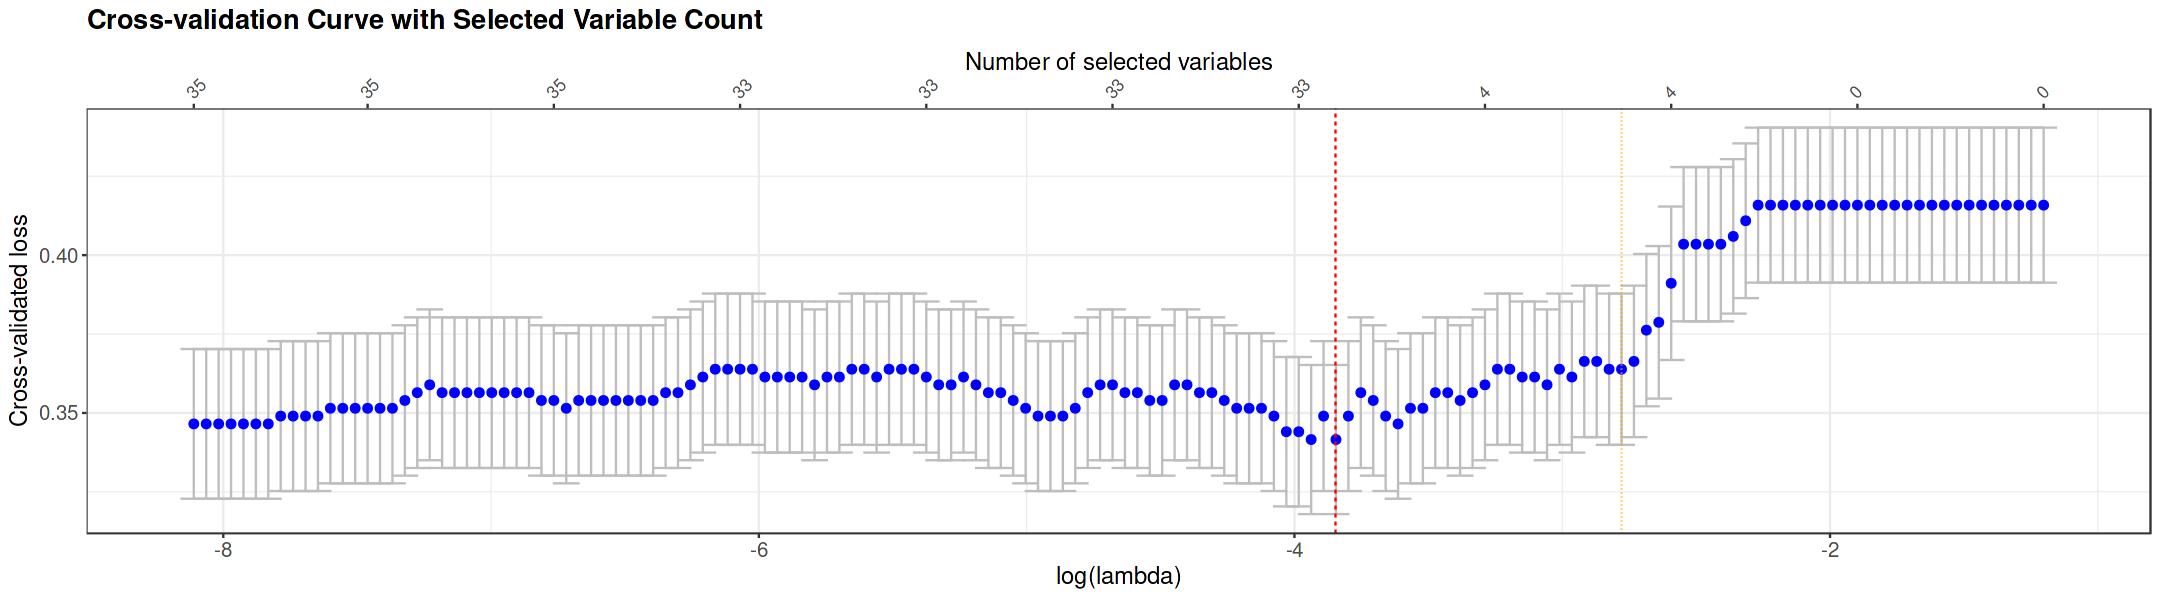

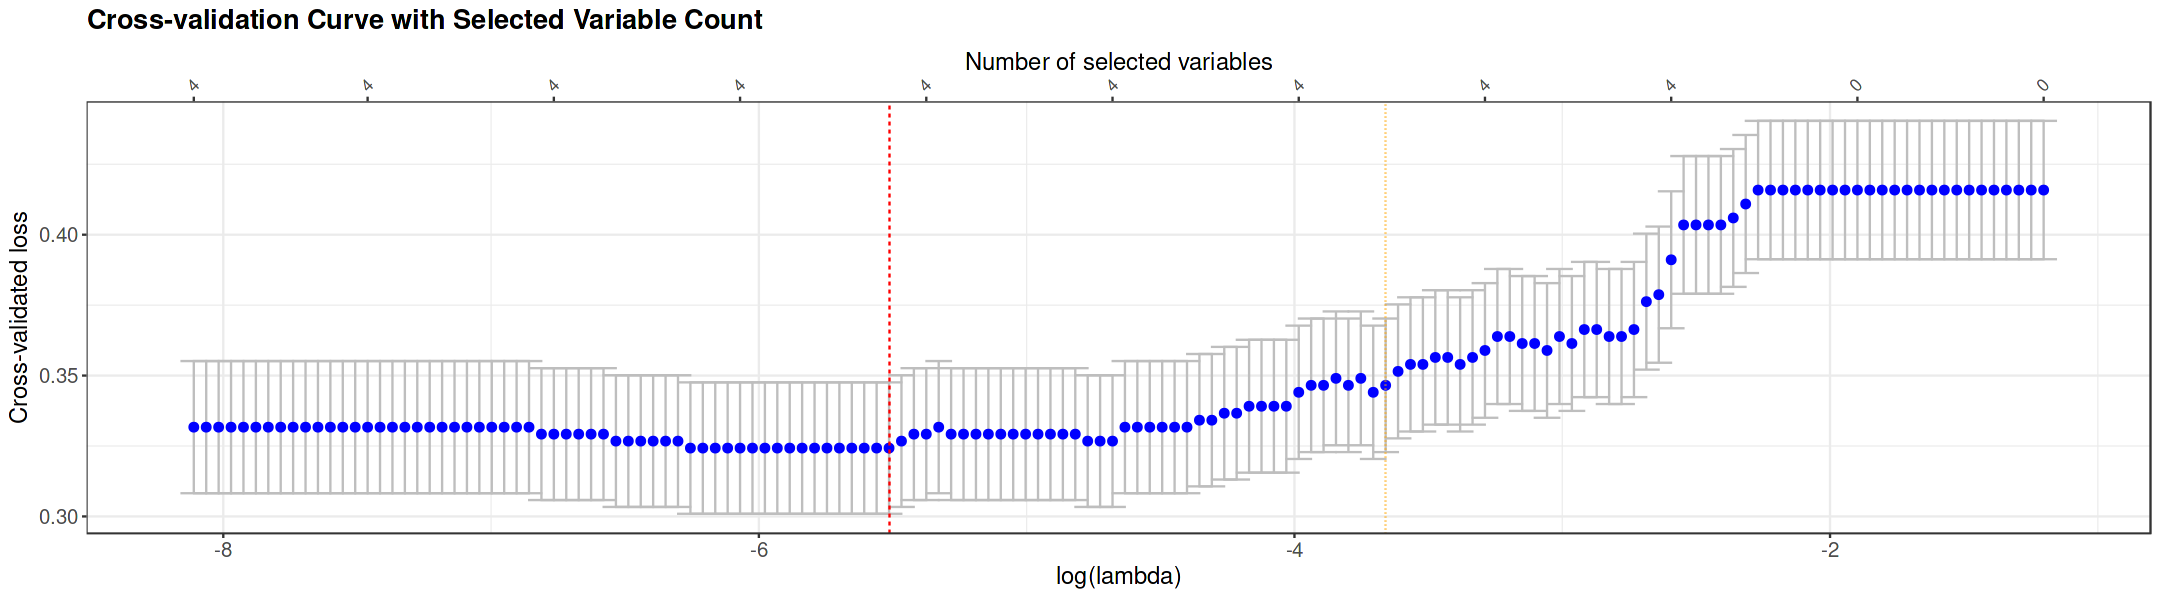

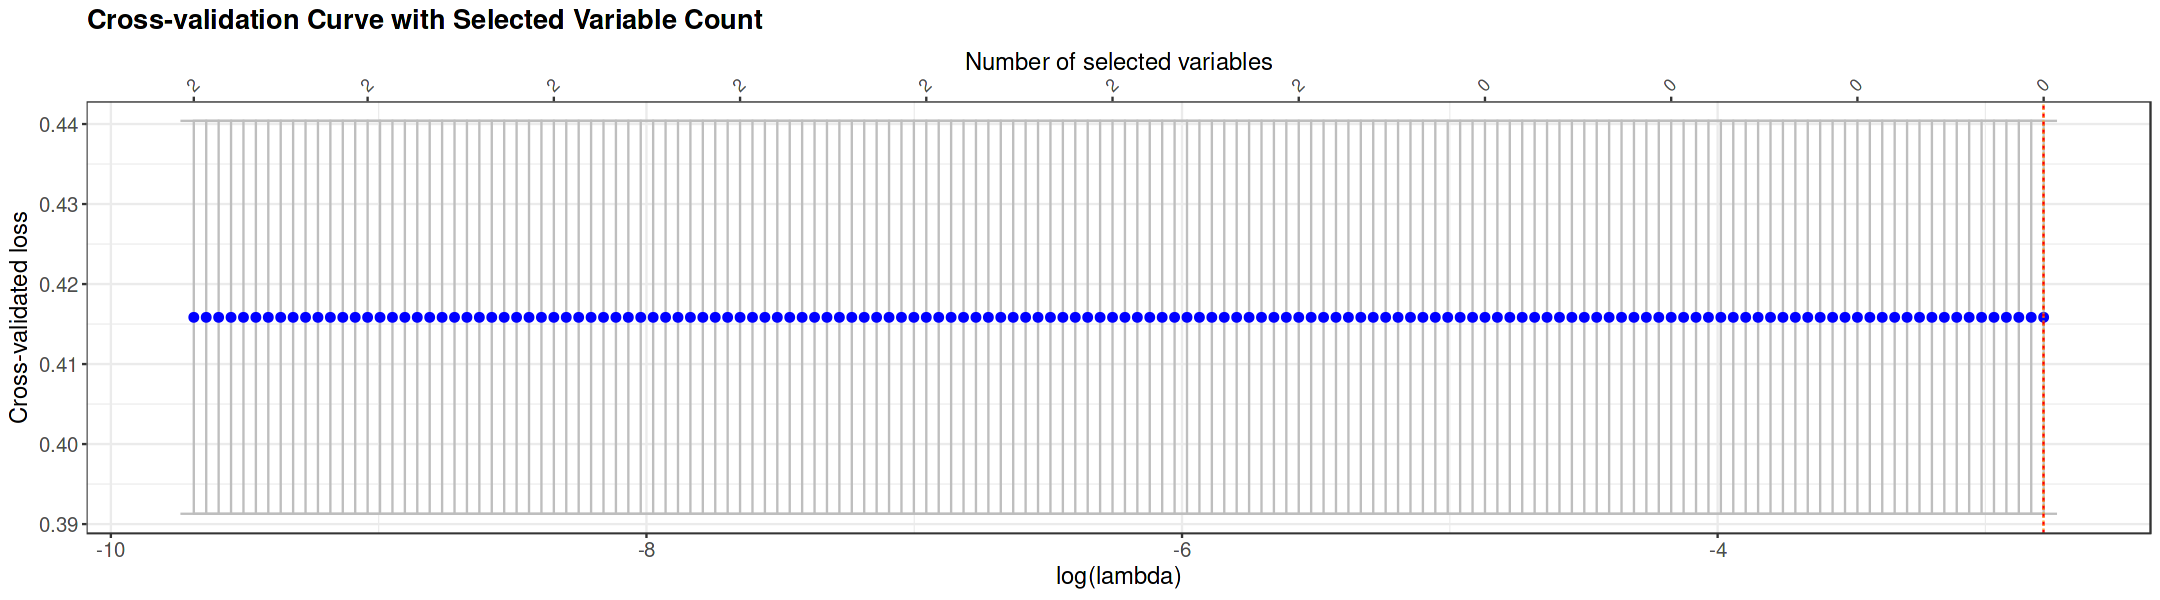

In [497]:
cat("\n=== MODELS FOR y2 ===\n")

# Run cross-validation for all 5 models with y2
set.seed(123)
cv2_results1 <- cv_gglasso_collect_auc(x1_train, y2_train, group_indices1)## Model 1: BaseLine model
set.seed(123)
cv2_results2 <- cv_gglasso_collect_auc(x2_train, y2_train, group_indices2)## Model 2: BaseLine + psychosocial model
set.seed(123)
cv2_results3 <- cv_gglasso_collect_auc(x3_train, y2_train, group_indices3)##  Model 3: BaseLine + psychosocial + lifestyle model
set.seed(123)
cv2_results4 <- cv_gglasso_collect_auc(x4_train, y2_train, group_indices4)##  Model 4:  psychosocial  
set.seed(123)
cv2_results5 <- cv_gglasso_collect_auc(x5_train, y2_train, group_indices5)# Model 5: lifestyle

In [498]:

# Print cross-validation results with confidence intervals
cat("\n--- Cross-Validation Results for y2 (on Training Set) ---\n")
cat("Model 1: Baseline characteristics only - AUC:", round(cv2_results1$mean_auc, 3), 
    "95% CI: [", round(cv2_results1$ci_lower, 3), "-", round(cv2_results1$ci_upper, 3), "]\n")
cat("Model 2: BaseLine + Psychosocial - AUC:", round(cv2_results2$mean_auc, 3), 
    "95% CI: [", round(cv2_results2$ci_lower, 3), "-", round(cv2_results2$ci_upper, 3), "]\n")
cat("Model 3: BaseLine + Psychosocial + Lifestyle - AUC:", round(cv2_results3$mean_auc, 3), 
    "95% CI: [", round(cv2_results3$ci_lower, 3), "-", round(cv2_results3$ci_upper, 3), "]\n")
cat("Model 4: Psychosocial only - AUC:", round(cv2_results4$mean_auc, 3), 
    "95% CI: [", round(cv2_results4$ci_lower, 3), "-", round(cv2_results4$ci_upper, 3), "]\n")
cat("Model 5: Lifestyle only - AUC:", round(cv2_results5$mean_auc, 3), 
    "95% CI: [", round(cv2_results5$ci_lower, 3), "-", round(cv2_results5$ci_upper, 3), "]\n")

len_model1_y2 <- cv2_results1$selected_variable_count
len_model2_y2 <- cv2_results2$selected_variable_count
len_model3_y2 <- cv2_results3$selected_variable_count
len_model4_y2 <- cv2_results4$selected_variable_count
len_model5_y2 <- cv2_results5$selected_variable_count



--- Cross-Validation Results for y2 (on Training Set) ---
Model 1: Baseline characteristics only - AUC: 0.646 95% CI: [ 0.595 - 0.697 ]
Model 2: BaseLine + Psychosocial - AUC: 0.697 95% CI: [ 0.634 - 0.76 ]
Model 3: BaseLine + Psychosocial + Lifestyle - AUC: 0.697 95% CI: [ 0.634 - 0.76 ]
Model 4: Psychosocial only - AUC: 0.686 95% CI: [ 0.626 - 0.746 ]
Model 5: Lifestyle only - AUC: 0.5 95% CI: [ 0.5 - 0.5 ]


In [499]:
cv2_models <- list(
  `Model 1: BaseLine` = cv2_results1,
  `Model 2: BaseLine +Psychosocial` = cv2_results2,
  `Model 3: BaseLine+P+Lifestyle` = cv2_results3,
  `Model 4: Psychosocial` = cv2_results4,
  `Model 5: Lifestyle` = cv2_results5
)

combine_gglasso_coefficients(cv2_models)

Variable                         
X.Intercept.                      (Intercept)                      
DiseaseEntityUC                   DiseaseEntityUC                  
genderFemale                      genderFemale                     
bmi                               bmi                              
age_at_inclusion                  age_at_inclusion                 
montreal_extent_uc2.3             montreal_extent_uc2&3            
montreal_severity_uc1.2           montreal_severity_uc1&2          
montreal_severity_uc3             montreal_severity_uc3            
montreal_location_cd1             montreal_location_cd1            
montreal_age_diagnosis_uc..median montreal_age_diagnosis_uc> median
surg_ileo_anal_pouch1             surg_ileo_anal_pouch1            
surg_small_bowel_resection1       surg_small_bowel_resection1      
surg_ileocaecal_resection1        surg_ileocaecal_resection1       
surg_small_bowel_stoma1           surg_small_bowel_stoma1          
number_of_surgeries..1            number_of_surgeries> 1           
age_at_surg_ileo_anal_pouch       age_at_surg_ileo_anal_pouch      
age_at_surg_small_bowel_resection age_at_surg_small_bowel_resection
age_at_surg_ileocaecal_resection  age_at_surg_ileocaecal_resection 
age_at_surg_small_bowel_stoma     age_at_surg_small_bowel_stoma    
age_at_surg_colostoma             age_at_surg_colostoma            
age_at_surg_stenoplasty           age_at_surg_stenoplasty          
History_colitis1                  History_colitis1                 
History_crohn1                    History_crohn1                   
used_Vedolizumab1                 used_Vedolizumab1                
used_Tofacitinib1                 used_Tofacitinib1                
used_Mesalazine_oraal1            used_Mesalazine_oraal1           
total_medication_period           total_medication_period          
period_Mesalazine_oraal           period_Mesalazine_oraal          
period_Methotrexaat               period_Methotrexaat              
period_Sulfasalazine              period_Sulfasalazine             
X                                 Anxious_mean                     
X.1                               Depression_mean                  
X.2                               Fatigue_mean                     
X.3                               MIAH_pain_mean                   
X.4                               smokerEx-smoker                  
X.5                               smokerCurrent smoker             
                                  Model 1: BaseLine
X.Intercept.                      -0.2018          
DiseaseEntityUC                   -0.0968          
genderFemale                      0.1262           
bmi                               0.0123           
age_at_inclusion                  -0.0344          
montreal_extent_uc2.3             -0.2784          
montreal_severity_uc1.2           -0.2692          
montreal_severity_uc3             0.0253           
montreal_location_cd1             -0.0508          
montreal_age_diagnosis_uc..median -0.1089          
surg_ileo_anal_pouch1             0.0196           
surg_small_bowel_resection1       0.0147           
surg_ileocaecal_resection1        0.0349           
surg_small_bowel_stoma1           0.0079           
number_of_surgeries..1            -0.0387          
age_at_surg_ileo_anal_pouch       0.2115           
age_at_surg_small_bowel_resection 0.0758           
age_at_surg_ileocaecal_resection  0.102            
age_at_surg_small_bowel_stoma     0.0424           
age_at_surg_colostoma             -0.0677          
age_at_surg_stenoplasty           0.036            
History_colitis1                  -0.1739          
History_crohn1                    0.2283           
used_Vedolizumab1                 0.1037           
used_Tofacitinib1                 -0.0213          
used_Mesalazine_oraal1            -0.0683          
total_medication_period           0.0821           
period_Mesalazine_oraal           -0.1536          
period_Met

### 3.6.2 Performance Evaluation

In [500]:
# ===== ANALYSIS FOR Y2 =====
cat("\n--- Cross-Validation Results for Y2 (on Testing Set) ---\n")

# Compute metrics for all models with y2
metrics_model1_y2 <- compute_metrics(model = cv2_results1$model, x = x1_test, y2_test)
metrics_model2_y2 <- compute_metrics(model = cv2_results2$model, x = x2_test, y2_test)
metrics_model3_y2 <- compute_metrics(model = cv2_results3$model, x = x3_test, y2_test)
metrics_model4_y2 <- compute_metrics(model = cv2_results4$model, x = x4_test, y2_test)
#metrics_model5_y2 <- compute_metrics(model = cv2_results5$model, x = x5_test, y2_test)

# Print performance metrics for Y2
cat("Model 1: Baseline characteristics only - Accuracy:", metrics_model1_y2$accuracy, "AUC:", metrics_model1_y2$auc, "  (95% CI: [", round(metrics_model1_y2$auc-cv2_results1$margin, 3), "-", round(metrics_model1_y2$auc+cv2_results1$margin, 3), "])\n")
cat("Model 2: BaseLine + Psychosocial - Accuracy:", metrics_model2_y2$accuracy, "AUC:", metrics_model2_y2$auc, " (95% CI: [", round(metrics_model2_y2$auc-cv2_results2$margin, 3), "-", round(metrics_model2_y2$auc+cv2_results2$margin, 3), "])\n")
cat("Model 3: BaseLine + Psychosocial + Lifestyle - Accuracy:", metrics_model3_y2$accuracy, "AUC:", metrics_model3_y2$auc,  " (95% CI: [", round(metrics_model3_y2$auc-cv2_results3$margin, 3), "-", round(metrics_model3_y2$auc+cv2_results3$margin, 3), "])\n")
cat("Model 4: Psychosocial only - Accuracy:", metrics_model4_y2$accuracy, "AUC:", metrics_model4_y2$auc,  " (95% CI: [", round(metrics_model4_y2$auc-cv2_results4$margin, 3), "-", round(metrics_model4_y2$auc+cv2_results4$margin, 3), "])\n")
#cat("Model 5: Lifestyle only - Accuracy:", metrics_model5_y2$accuracy, "AUC:", metrics_model5_y2$auc,   " (95% CI: [", round(metrics_model5_y2$auc-cv2_results5$margin, 3), "-", round(metrics_model5_y2$auc+cv2_results5$margin, 3), "])\n")



--- Cross-Validation Results for Y2 (on Testing Set) ---
Model 1: Baseline characteristics only - Accuracy: 0.6647399 AUC: 0.6528892   (95% CI: [ 0.602 - 0.704 ])
Model 2: BaseLine + Psychosocial - Accuracy: 0.6878613 AUC: 0.7306046  (95% CI: [ 0.667 - 0.794 ])
Model 3: BaseLine + Psychosocial + Lifestyle - Accuracy: 0.6878613 AUC: 0.7306046  (95% CI: [ 0.667 - 0.794 ])
Model 4: Psychosocial only - Accuracy: 0.6878613 AUC: 0.7071964  (95% CI: [ 0.647 - 0.767 ])


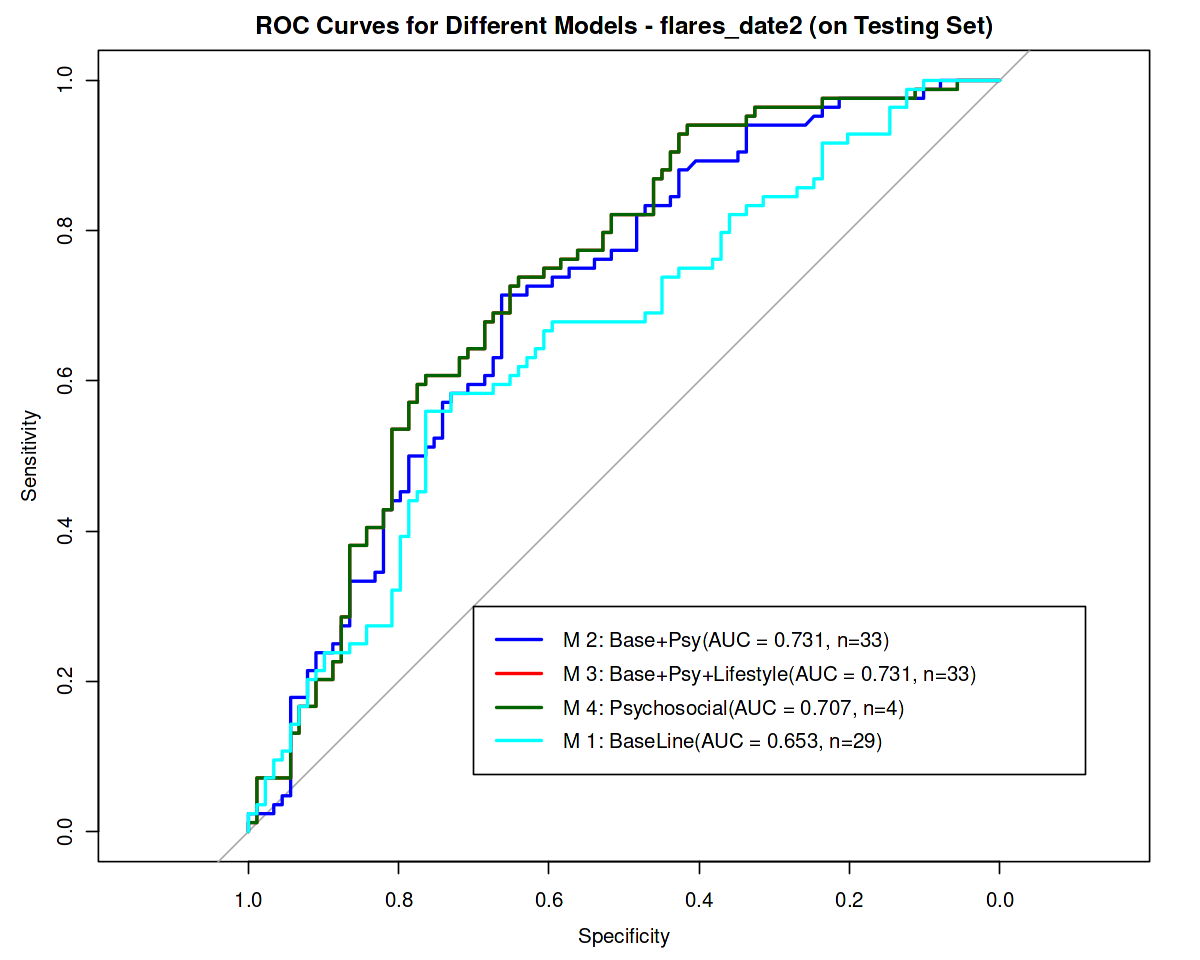

In [520]:
# Plot ROC Curves for All Models - Y2
roc_model1_y2 <- metrics_model1_y2$roc_curve
roc_model2_y2 <- metrics_model2_y2$roc_curve
roc_model3_y2 <- metrics_model3_y2$roc_curve
roc_model4_y2 <- metrics_model4_y2$roc_curve
#roc_model5_y2 <- metrics_model5_y2$roc_curve

# ROC plot for Y2
legend_labels_y2 <- c(
    paste0("M 2: Base+Psy(AUC = ", sprintf("%.3f", auc(roc_model2_y2)),  ", n=",len_model2_y2,")"),
    paste0("M 3: Base+Psy+Lifestyle(AUC = ", sprintf("%.3f", auc(roc_model3_y2)), ", n=",len_model3_y2, ")"),
    paste0("M 4: Psychosocial(AUC = ", sprintf("%.3f", auc(roc_model4_y2)), ", n=",len_model4_y2,")"),
    paste0("M 1: BaseLine(AUC = ", sprintf("%.3f", auc(roc_model1_y2)),  ", n=",len_model1_y2,")")
    #paste0("M 5: Lifestyle(AUC = ", sprintf("%.3f", auc(roc_model5_y2)),  ", n=",len_model5_y2,")")
)

# Create ROC plot for Y2
options(repr.plot.width=10, repr.plot.height=8)
plot(roc_model4_y2, col = "blue", main = "ROC Curves for Different Models - flares_date2 (on Testing Set)")
plot(roc_model3_y2, col = "red", add = TRUE)
plot(roc_model2_y2, col = "darkgreen", add = TRUE)
#plot(roc_model5_y2, col = "cyan", add = TRUE)
plot(roc_model1_y2, col = "cyan", add = TRUE)
    
# Add legend
legend(x = 0.7, y = 0.3, 
        legend = legend_labels_y2,
        col = c("blue", "red", "darkgreen", "cyan"),
        lwd = 2)


In [502]:
# Create a results table for Y2
results_table_y2 <- data.frame(
    Model = c("Model 1: BaseLine", 
              "Model 2: BaseLine +Psychosocial", 
              "Model 3: BaseLine+P+Lifestyle", 
              "Model 4: Psychosocial"#,          "Model 5: Lifestyle"
              ),
    Sensitivity = c(metrics_model1_y2$metrics[1],
                    metrics_model2_y2$metrics[1],
                    metrics_model3_y2$metrics[1],
                    metrics_model4_y2$metrics[1]#, metrics_model5_y2$metrics[1]
                    ),
    Specificity = c(metrics_model1_y2$metrics[2],
                    metrics_model2_y2$metrics[2],
                    metrics_model3_y2$metrics[2], 
                    metrics_model4_y2$metrics[2]#,                 metrics_model5_y2$metrics[2]
                    ),
    PPV = c(metrics_model1_y2$metrics[3],
            metrics_model2_y2$metrics[3],
            metrics_model3_y2$metrics[3], 
            metrics_model4_y2$metrics[3]#,          metrics_model5_y2$metrics[3]
            ),
    NPV = c(metrics_model1_y2$metrics[4],
            metrics_model2_y2$metrics[4],
            metrics_model3_y2$metrics[4],
            metrics_model4_y2$metrics[4]#, metrics_model5_y2$metrics[4]
            )
)

# Print the results table for Y2
cat("Results Table for Y2:\n")
print(results_table_y2)


Results Table for Y2:
                            Model Sensitivity Specificity       PPV       NPV
1               Model 1: BaseLine   0.5595238   0.7640449 0.6911765 0.6476190
2 Model 2: BaseLine +Psychosocial   0.7380952   0.6404494 0.6595745 0.7215190
3   Model 3: BaseLine+P+Lifestyle   0.7380952   0.6404494 0.6595745 0.7215190
4           Model 4: Psychosocial   0.7142857   0.6629213 0.6666667 0.7108434


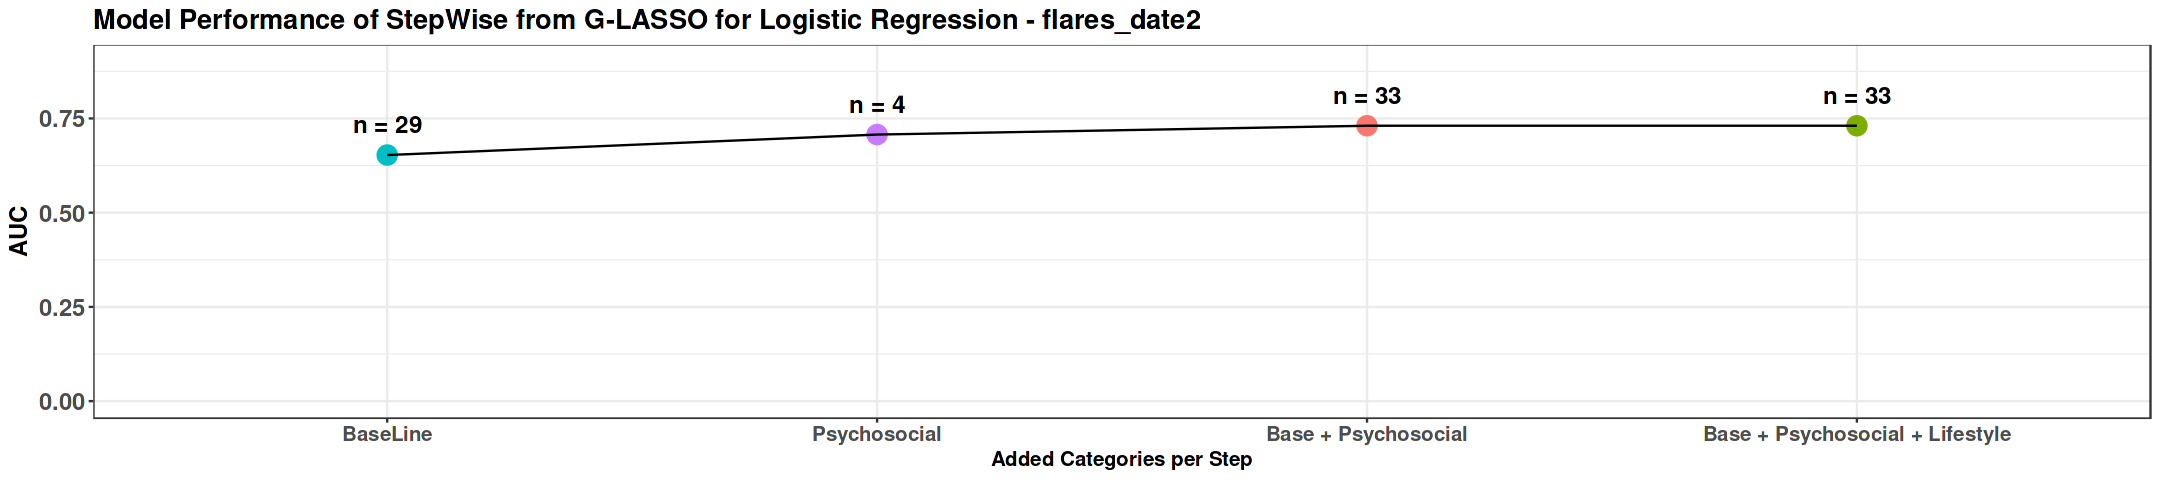

In [503]:
# Variable importance plot for Y2
variable_importance_y2 <- data.frame(
  Variable = c("BaseLine", 
               "Base + Psychosocial", "Base + Psychosocial + Lifestyle", 
               "Psychosocial"#, "Lifestyle"
               ),
  auc_values = c(metrics_model1_y2$auc,
                 metrics_model2_y2$auc, metrics_model3_y2$auc, metrics_model4_y2$auc#,                 metrics_model5_y2$auc
                 ),
  n_vars = c(len_model1_y2, 
             len_model2_y2, len_model3_y2, len_model4_y2)#, len_model5_y2)
)

# Create Figure : Variable Importance Plot for Y2
options(repr.plot.width=18, repr.plot.height=4)
ggplot(variable_importance_y2, aes(x = reorder(Variable, auc_values), y = auc_values)) +
  geom_point(aes(color = Variable), size = 5) +
  geom_line(group = 1) +
  geom_text(aes(label = paste0("n = ", n_vars)), 
            vjust = -1.2, size = 5, fontface = "bold") +
    ylim(0, .9) +
  labs(title = "Model Performance of StepWise from G-LASSO for Logistic Regression - flares_date2",
       x = "Added Categories per Step",
       y = "AUC") +
  theme_bw() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 16, face = "bold"),
    axis.title.x = element_text(size = 12, face = "bold"),
    axis.title.y = element_text(size = 14, face = "bold"),
    axis.text.x = element_text(size = 12, face = "bold"),
    axis.text.y = element_text(size = 14, face = "bold")
  )


## 3.7 MODELS FOR flares_date3 
### 3.7.1 Training



=== MODELS FOR y3 ===


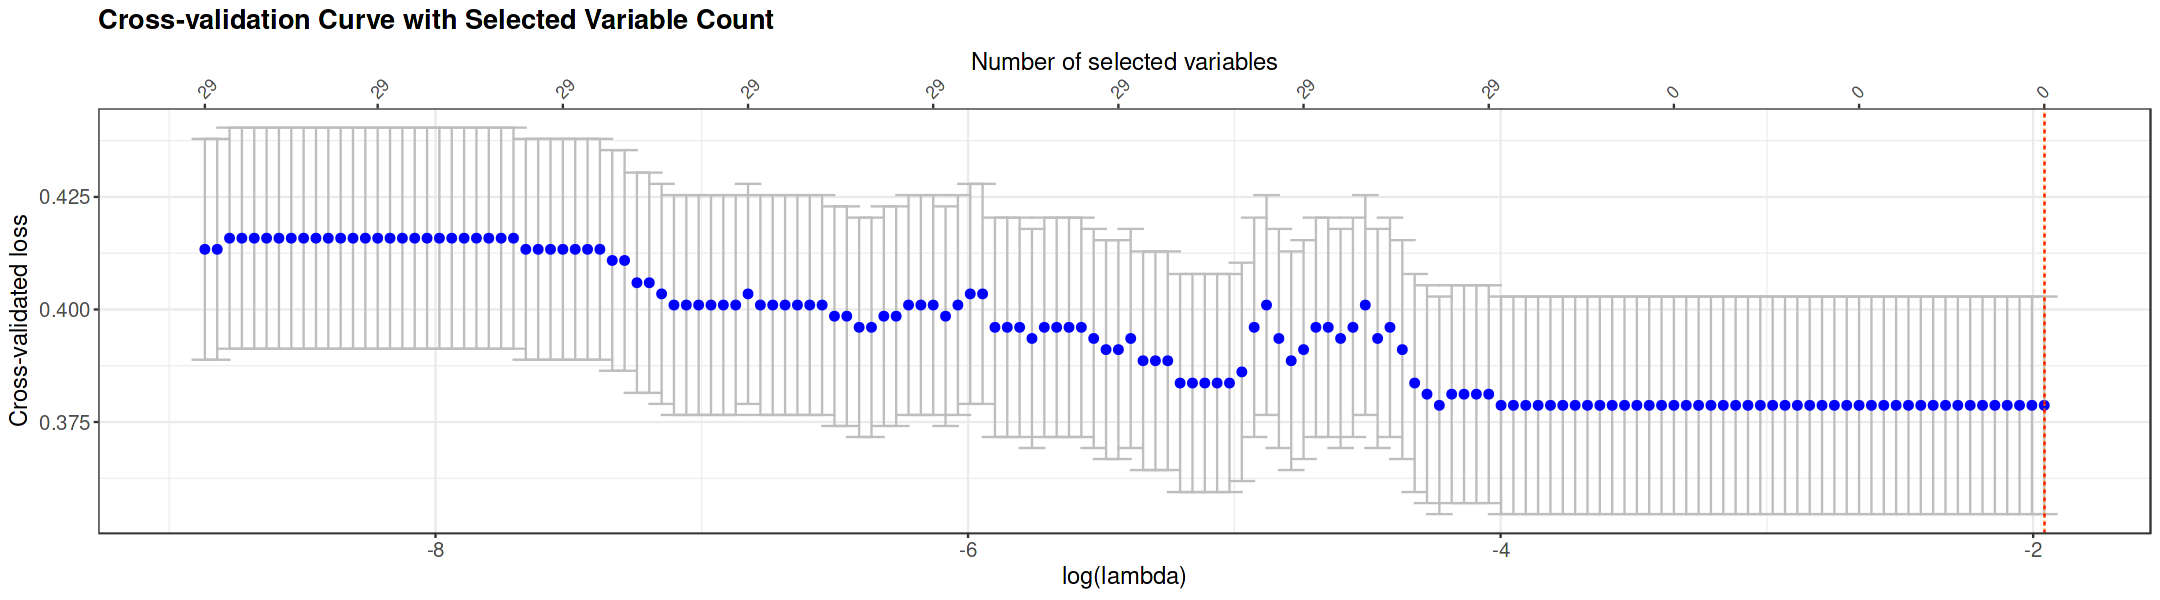

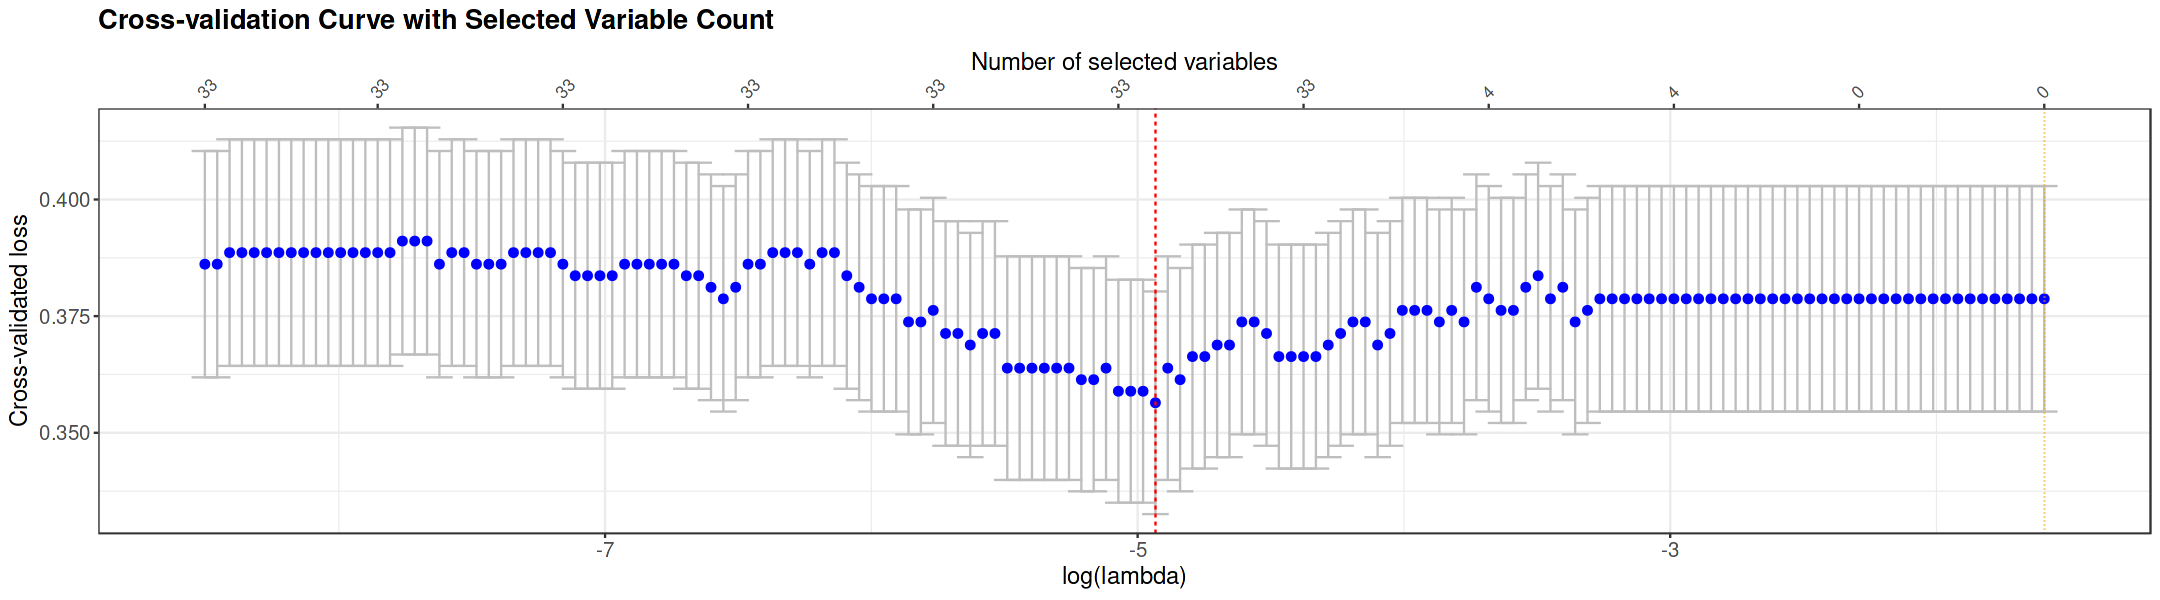

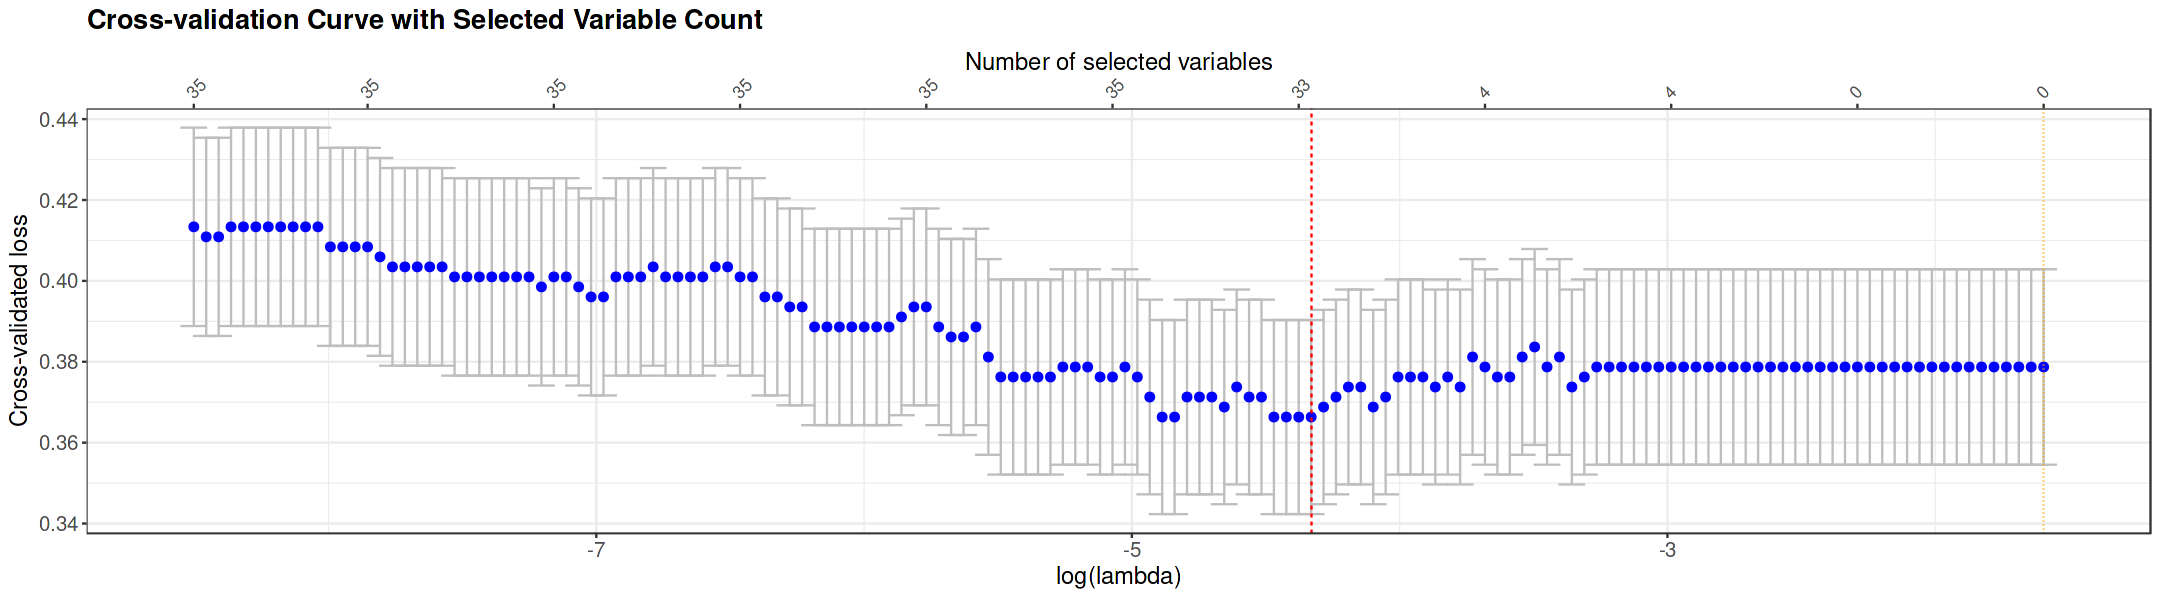

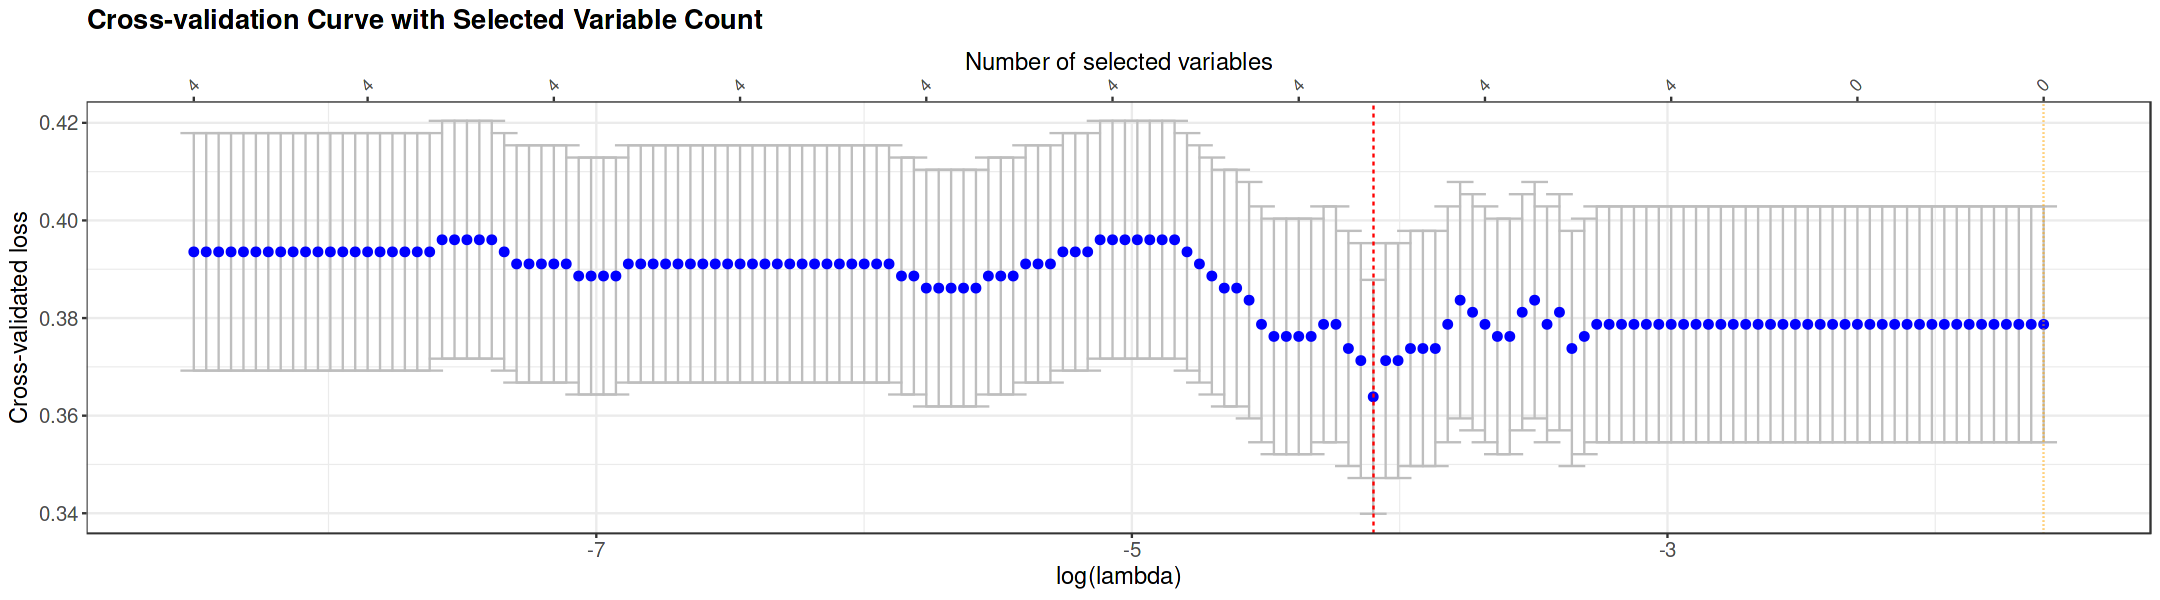

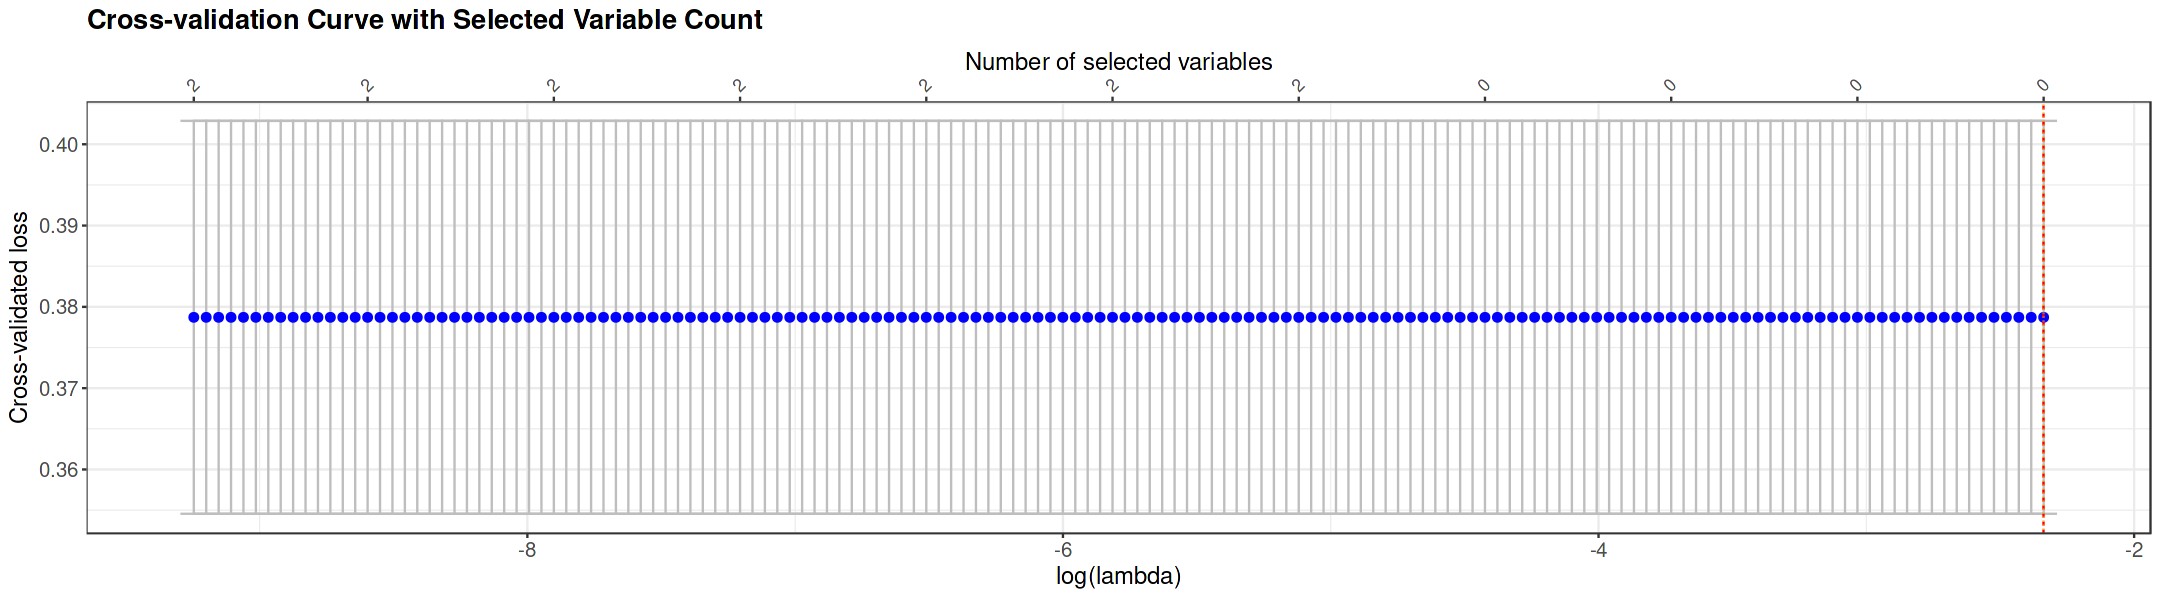

In [504]:

cat("\n\n=== MODELS FOR y3 ===\n")

# Run cross-validation for all 5 models with y3
set.seed(123)
cv3_results1 <- cv_gglasso_collect_auc(x1_train, y3_train, group_indices1)## Model 1: BaseLine model
set.seed(123)
cv3_results2 <- cv_gglasso_collect_auc(x2_train, y3_train, group_indices2)## Model 2: BaseLine + psychosocial model
set.seed(123)
cv3_results3 <- cv_gglasso_collect_auc(x3_train, y3_train, group_indices3)##  Model 3: BaseLine + psychosocial + lifestyle model
set.seed(123)
cv3_results4 <- cv_gglasso_collect_auc(x4_train, y3_train, group_indices4)##  Model 4:  psychosocial  
set.seed(123)
cv3_results5 <- cv_gglasso_collect_auc(x5_train, y3_train, group_indices5)# Model 5: lifestyle


In [505]:

# Print cross-validation results with confidence intervals
cat("\n--- Cross-Validation Results for y3 (on Training Set) ---\n")
cat("Model 1: Baseline characteristics only - AUC:", round(cv3_results1$mean_auc, 3), 
    "95% CI: [", round(cv3_results1$ci_lower, 3), "-", round(cv3_results1$ci_upper, 3), "]\n")
cat("Model 2: BaseLine + Psychosocial - AUC:", round(cv3_results2$mean_auc, 3), 
    "95% CI: [", round(cv3_results2$ci_lower, 3), "-", round(cv3_results2$ci_upper, 3), "]\n")
cat("Model 3: BaseLine + Psychosocial + Lifestyle - AUC:", round(cv3_results3$mean_auc, 3), 
    "95% CI: [", round(cv3_results3$ci_lower, 3), "-", round(cv3_results3$ci_upper, 3), "]\n")
cat("Model 4: Psychosocial only - AUC:", round(cv3_results4$mean_auc, 3), 
    "95% CI: [", round(cv3_results4$ci_lower, 3), "-", round(cv3_results4$ci_upper, 3), "]\n")
cat("Model 5: Lifestyle only - AUC:", round(cv3_results5$mean_auc, 3), 
    "95% CI: [", round(cv3_results5$ci_lower, 3), "-", round(cv3_results5$ci_upper, 3), "]\n")


len_model1_y3 <- cv3_results1$selected_variable_count
len_model2_y3 <- cv3_results2$selected_variable_count
len_model3_y3 <- cv3_results3$selected_variable_count
len_model4_y3 <- cv3_results4$selected_variable_count
len_model5_y3 <- cv3_results5$selected_variable_count


--- Cross-Validation Results for y3 (on Training Set) ---
Model 1: Baseline characteristics only - AUC: 0.5 95% CI: [ 0.5 - 0.5 ]
Model 2: BaseLine + Psychosocial - AUC: 0.657 95% CI: [ 0.577 - 0.737 ]
Model 3: BaseLine + Psychosocial + Lifestyle - AUC: 0.635 95% CI: [ 0.539 - 0.73 ]
Model 4: Psychosocial only - AUC: 0.635 95% CI: [ 0.579 - 0.692 ]
Model 5: Lifestyle only - AUC: 0.5 95% CI: [ 0.5 - 0.5 ]


In [506]:
cv3_models <- list(
  `Model 1: BaseLine` = cv3_results1,
  `Model 2: BaseLine +Psychosocial` = cv3_results2,
  `Model 3: BaseLine+P+Lifestyle` = cv3_results3,
  `Model 4: Psychosocial` = cv3_results4,
  `Model 5: Lifestyle` = cv3_results5
)

combine_gglasso_coefficients(cv3_models)

Variable                         
X.Intercept.                      (Intercept)                      
DiseaseEntityUC                   DiseaseEntityUC                  
genderFemale                      genderFemale                     
bmi                               bmi                              
age_at_inclusion                  age_at_inclusion                 
montreal_extent_uc2.3             montreal_extent_uc2&3            
montreal_severity_uc1.2           montreal_severity_uc1&2          
montreal_severity_uc3             montreal_severity_uc3            
montreal_location_cd1             montreal_location_cd1            
montreal_age_diagnosis_uc..median montreal_age_diagnosis_uc> median
surg_ileo_anal_pouch1             surg_ileo_anal_pouch1            
surg_small_bowel_resection1       surg_small_bowel_resection1      
surg_ileocaecal_resection1        surg_ileocaecal_resection1       
surg_small_bowel_stoma1           surg_small_bowel_stoma1          
number_of_surgeries..1            number_of_surgeries> 1           
age_at_surg_ileo_anal_pouch       age_at_surg_ileo_anal_pouch      
age_at_surg_small_bowel_resection age_at_surg_small_bowel_resection
age_at_surg_ileocaecal_resection  age_at_surg_ileocaecal_resection 
age_at_surg_small_bowel_stoma     age_at_surg_small_bowel_stoma    
age_at_surg_colostoma             age_at_surg_colostoma            
age_at_surg_stenoplasty           age_at_surg_stenoplasty          
History_colitis1                  History_colitis1                 
History_crohn1                    History_crohn1                   
used_Vedolizumab1                 used_Vedolizumab1                
used_Tofacitinib1                 used_Tofacitinib1                
used_Mesalazine_oraal1            used_Mesalazine_oraal1           
total_medication_period           total_medication_period          
period_Mesalazine_oraal           period_Mesalazine_oraal          
period_Methotrexaat               period_Methotrexaat              
period_Sulfasalazine              period_Sulfasalazine             
X                                 Anxious_mean                     
X.1                               Depression_mean                  
X.2                               Fatigue_mean                     
X.3                               MIAH_pain_mean                   
X.4                               smokerEx-smoker                  
X.5                               smokerCurrent smoker             
                                  Model 1: BaseLine
X.Intercept.                      0.495            
DiseaseEntityUC                                    
genderFemale                                       
bmi                                                
age_at_inclusion                                   
montreal_extent_uc2.3                              
montreal_severity_uc1.2                            
montreal_severity_uc3                              
montreal_location_cd1                              
montreal_age_diagnosis_uc..median                  
surg_ileo_anal_pouch1                              
surg_small_bowel_resection1                        
surg_ileocaecal_resection1                         
surg_small_bowel_stoma1                            
number_of_surgeries..1                             
age_at_surg_ileo_anal_pouch                        
age_at_surg_small_bowel_resection                  
age_at_surg_ileocaecal_resection                   
age_at_surg_small_bowel_stoma                      
age_at_surg_colostoma                              
age_at_surg_stenoplasty                            
History_colitis1                                   
History_crohn1                                     
used_Vedolizumab1                                  
used_Tofacitinib1                                  
used_Mesalazine_oraal1                             
total_medication_period                            
period_Mesalazine_oraal                            
period_Met

### 3.7.2 Performance Evaluation

In [507]:
# ===== ANALYSIS FOR Y3 =====
cat("\n--- Cross-Validation Results for Y3 (on Testing Set) ---\n")

# Compute metrics for all models with y3
#metrics_model1_y3 <- compute_metrics(model = cv3_results1$model, x = x1_test, y3_test)
metrics_model2_y3 <- compute_metrics(model = cv3_results2$model, x = x2_test, y3_test)
metrics_model3_y3 <- compute_metrics(model = cv3_results3$model, x = x3_test, y3_test)
metrics_model4_y3 <- compute_metrics(model = cv3_results4$model, x = x4_test, y3_test)
#metrics_model5_y3 <- compute_metrics(model = cv3_results5$model, x = x5_test, y3_test)

# Print performance metrics for Y3
#cat("Model 1: Baseline characteristics only - Accuracy:", metrics_model1_y3$accuracy, "AUC:", metrics_model1_y3$auc, "  (95% CI: [", round(metrics_model1_y3$auc-cv3_results1$margin, 3), "-", round(metrics_model1_y3$auc+cv3_results1$margin, 3), "])\n")
cat("Model 2: BaseLine + Psychosocial - Accuracy:", metrics_model2_y3$accuracy, "AUC:", metrics_model2_y3$auc, " (95% CI: [", round(metrics_model2_y3$auc-cv3_results2$margin, 3), "-", round(metrics_model2_y3$auc+cv3_results2$margin, 3), "])\n")
cat("Model 3: BaseLine + Psychosocial + Lifestyle - Accuracy:", metrics_model3_y3$accuracy, "AUC:", metrics_model3_y3$auc,  " (95% CI: [", round(metrics_model3_y3$auc-cv3_results3$margin, 3), "-", round(metrics_model3_y3$auc+cv3_results3$margin, 3), "])\n")
cat("Model 4: Psychosocial only - Accuracy:", metrics_model4_y3$accuracy, "AUC:", metrics_model4_y3$auc,  " (95% CI: [", round(metrics_model4_y3$auc-cv3_results4$margin, 3), "-", round(metrics_model4_y3$auc+cv3_results4$margin, 3), "])\n")
#cat("Model 5: Lifestyle only - Accuracy:", metrics_model5_y3$accuracy, "AUC:", metrics_model5_y3$auc,   " (95% CI: [", round(metrics_model5_y3$auc-cv3_results5$margin, 3), "-", round(metrics_model5_y3$auc+cv3_results5$margin, 3), "])\n")



--- Cross-Validation Results for Y3 (on Testing Set) ---
Model 2: BaseLine + Psychosocial - Accuracy: 0.6184971 AUC: 0.6017675  (95% CI: [ 0.522 - 0.682 ])
Model 3: BaseLine + Psychosocial + Lifestyle - Accuracy: 0.6127168 AUC: 0.6089478  (95% CI: [ 0.514 - 0.704 ])
Model 4: Psychosocial only - Accuracy: 0.6011561 AUC: 0.5957608  (95% CI: [ 0.539 - 0.652 ])


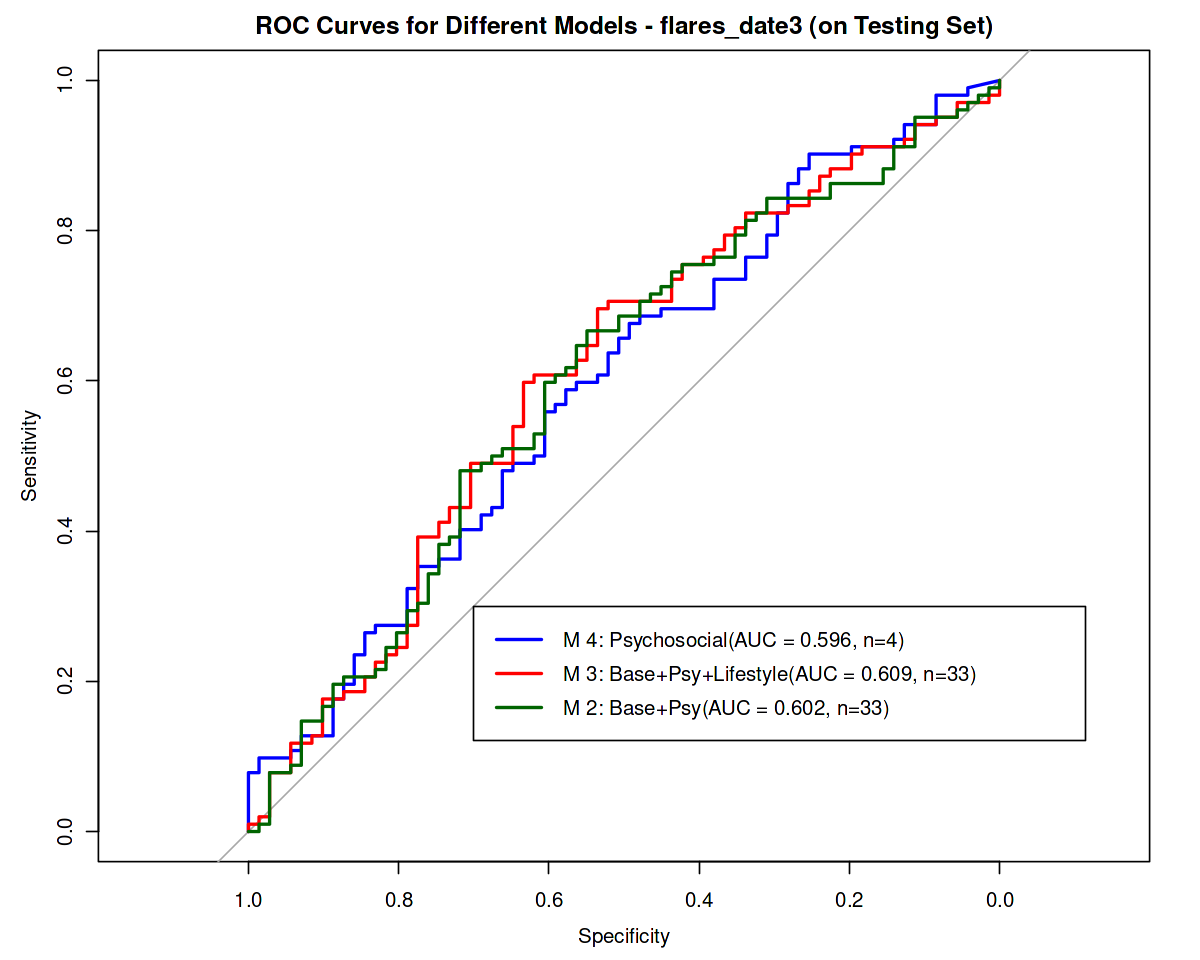

In [508]:
# Plot ROC Curves for All Models - Y3
#roc_model1_y3 <- metrics_model1_y3$roc_curve
roc_model2_y3 <- metrics_model2_y3$roc_curve
roc_model3_y3 <- metrics_model3_y3$roc_curve
roc_model4_y3 <- metrics_model4_y3$roc_curve
#roc_model5_y3 <- metrics_model5_y3$roc_curve

# ROC plot for Y3
legend_labels_y3 <- c(
    paste0("M 4: Psychosocial(AUC = ", sprintf("%.3f", auc(roc_model4_y3)), ", n=",len_model4_y3,")"),
    paste0("M 3: Base+Psy+Lifestyle(AUC = ", sprintf("%.3f", auc(roc_model3_y3)), ", n=",len_model3_y3, ")"),
    paste0("M 2: Base+Psy(AUC = ", sprintf("%.3f", auc(roc_model2_y3)),  ", n=",len_model2_y3,")")#,
    #paste0("M 5: Lifestyle(AUC = ", sprintf("%.3f", auc(roc_model5_y3)),  ", n=",len_model5,")"),
    #paste0("M 1: BaseLine(AUC = ", sprintf("%.3f", auc(roc_model1_y3)),  ", n=",len_model1_y3,")")
)

# Create ROC plot for Y3
options(repr.plot.width=10, repr.plot.height=8)
plot(roc_model4_y3, col = "blue", main = "ROC Curves for Different Models - flares_date3 (on Testing Set)")
plot(roc_model3_y3, col = "red", add = TRUE)
plot(roc_model2_y3, col = "darkgreen", add = TRUE)
#plot(roc_model5_y3, col = "cyan", add = TRUE)
#plot(roc_model1_y3, col = "gray90", add = TRUE)
    
# Add legend
legend(x = 0.7, y = 0.3, 
        legend = legend_labels_y3,
        col = c("blue", "red", "darkgreen"),
        lwd = 2)


In [509]:
# Create a results table for Y3
results_table_y3 <- data.frame(
    Model = c(#"Model 1: BaseLine", 
              "Model 2: BaseLine +Psychosocial", 
              "Model 3: BaseLine+P+Lifestyle", 
              "Model 4: Psychosocial"#,  "Model 5: Lifestyle"
              ),
    Sensitivity = c(#metrics_model1_y3$metrics[1],
                    metrics_model2_y3$metrics[1],
                    metrics_model3_y3$metrics[1],  metrics_model4_y3$metrics[1]#,metrics_model5_y3$metrics[1]
                    ),
    Specificity = c(#metrics_model1_y3$metrics[2], 
                    metrics_model2_y3$metrics[2],
                    metrics_model3_y3$metrics[2],   metrics_model4_y3$metrics[2]#,metrics_model5_y3$metrics[2]
                    ),
    PPV = c(#metrics_model1_y3$metrics[3],
            metrics_model2_y3$metrics[3],
            metrics_model3_y3$metrics[3],  metrics_model4_y3$metrics[3]#,metrics_model5_y3$metrics[3]
            ),
    NPV = c(#metrics_model1_y3$metrics[4],
            metrics_model2_y3$metrics[4],
            metrics_model3_y3$metrics[4], metrics_model4_y3$metrics[4]#, metrics_model5_y3$metrics[4]
            )
)

# Print the results table for Y3
cat("Results Table for Y3:\n")
print(results_table_y3)


Results Table for Y3:
                            Model Sensitivity Specificity       PPV       NPV
1 Model 2: BaseLine +Psychosocial   0.6666667   0.5492958 0.6800000 0.5342466
2   Model 3: BaseLine+P+Lifestyle   0.5980392   0.6338028 0.7011494 0.5232558
3           Model 4: Psychosocial   0.6764706   0.4929577 0.6571429 0.5147059


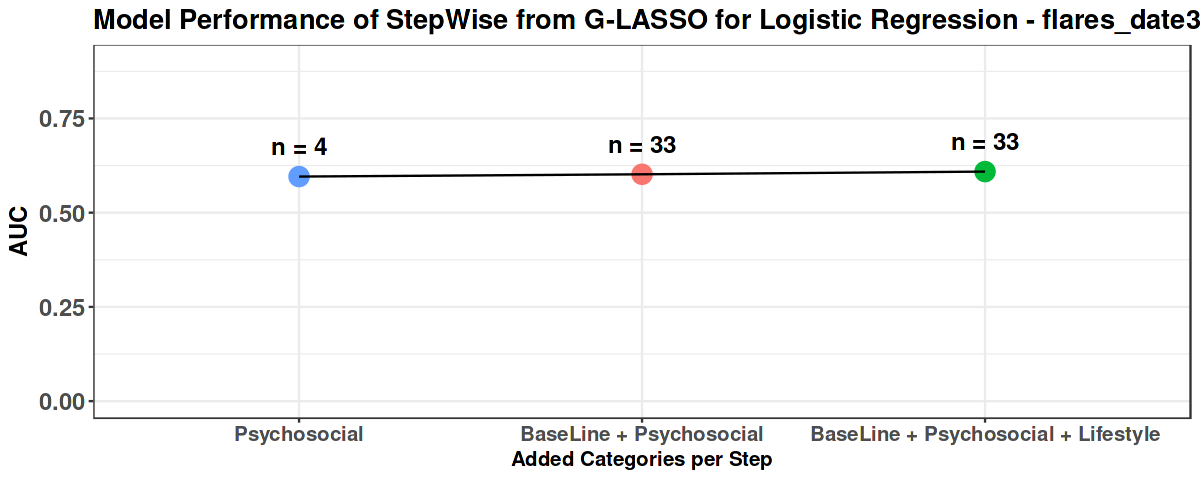

In [510]:
# Variable importance plot for Y3
variable_importance_y3 <- data.frame(
  Variable = c(#"BaseLine", 
               "BaseLine + Psychosocial", "BaseLine + Psychosocial + Lifestyle", 
               "Psychosocial"#, "Lifestyle"
               ),
  auc_values = c(#metrics_model1_y3$auc,
                 metrics_model2_y3$auc, metrics_model3_y3$auc,
                 metrics_model4_y3$auc#,metrics_model5_y3$auc
                 ),
  n_vars = c(#len_model1_y3, 
             len_model2_y3, len_model3_y3, len_model4_y3#, len_model5_y3
             )
)

# Create Figure : Variable Importance Plot for Y3
options(repr.plot.width=10, repr.plot.height=4)
ggplot(variable_importance_y3, aes(x = reorder(Variable, auc_values), y = auc_values)) +
  geom_point(aes(color = Variable), size = 5) +
  geom_line(group = 1) +
  geom_text(aes(label = paste0("n = ", n_vars)), 
            vjust = -1.2, size = 5, fontface = "bold") +
    ylim(0, .9) +
  labs(title = "Model Performance of StepWise from G-LASSO for Logistic Regression - flares_date3",
       x = "Added Categories per Step",
       y = "AUC") +
  theme_bw() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 16, face = "bold"),
    axis.title.x = element_text(size = 12, face = "bold"),
    axis.title.y = element_text(size = 14, face = "bold"),
    axis.text.x = element_text(size = 12, face = "bold"),
    axis.text.y = element_text(size = 14, face = "bold")
  )


## 3.8. MODELS FOR flares_date4 
### 3.8.1 Training



=== MODELS FOR y4 ===


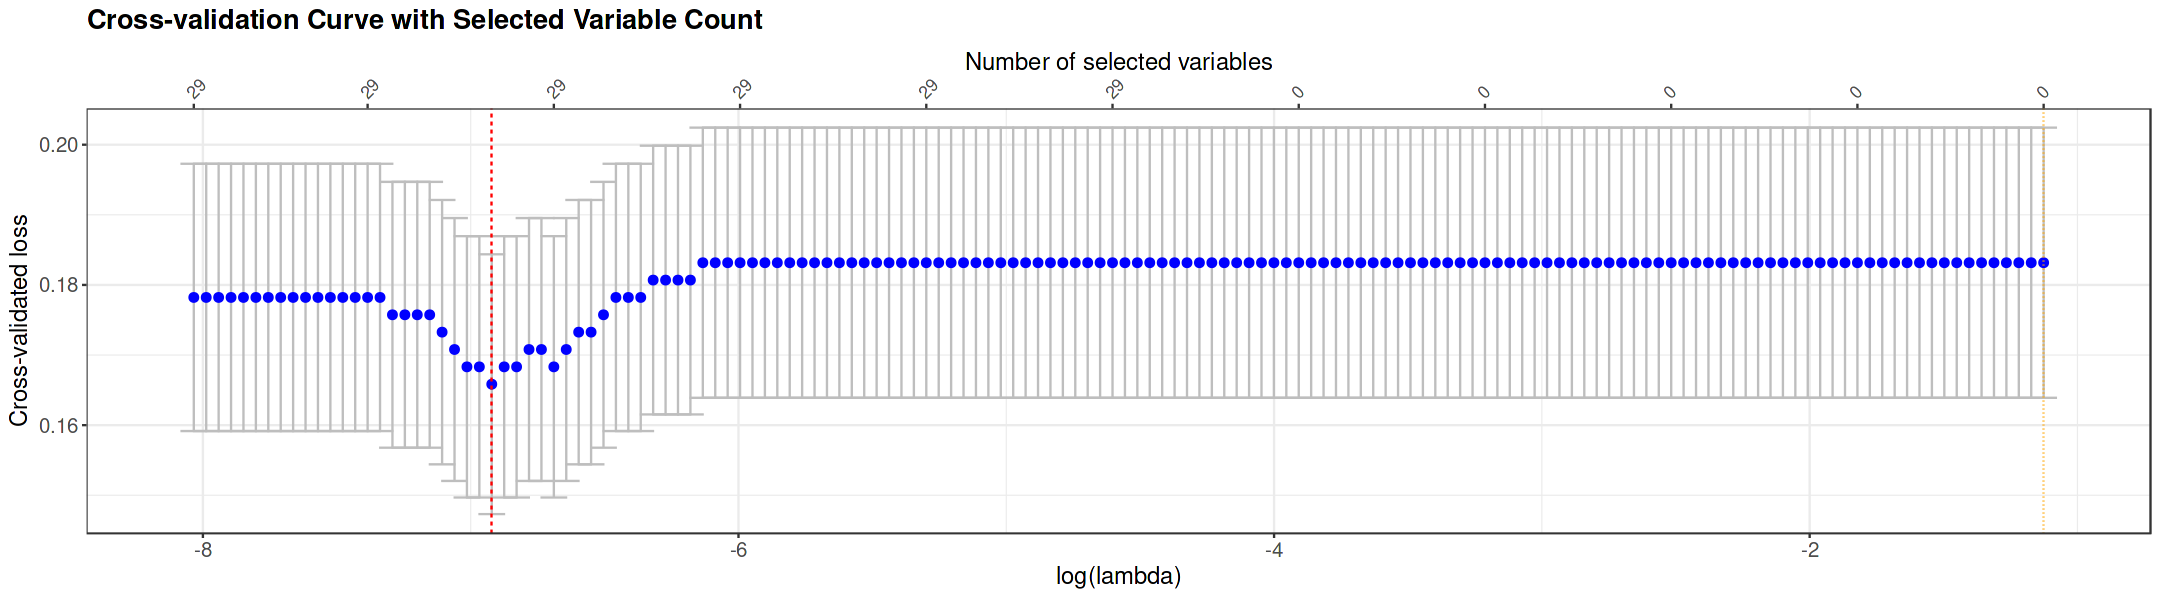

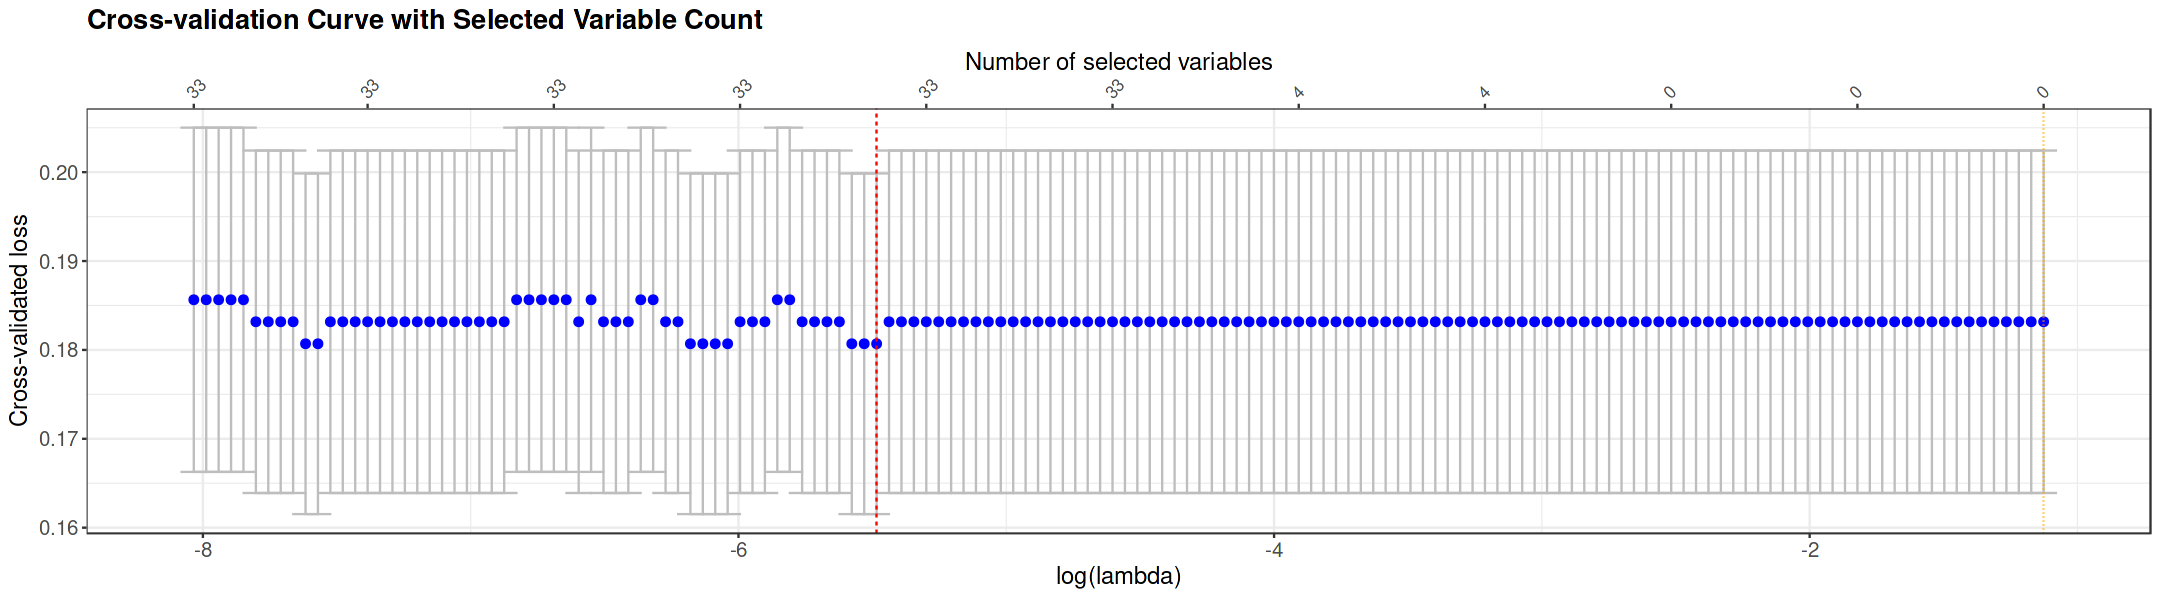

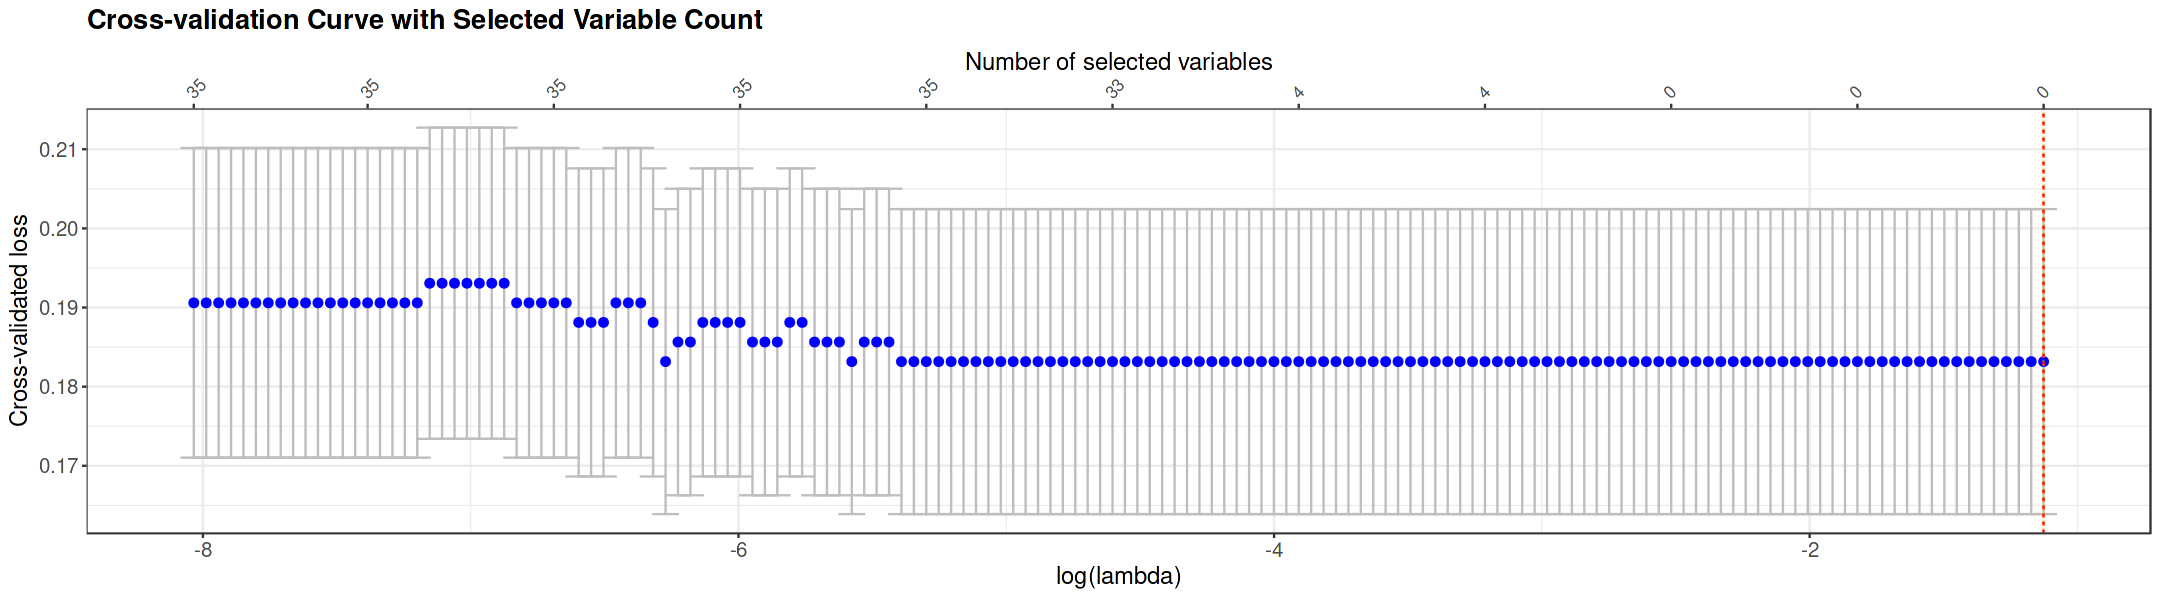

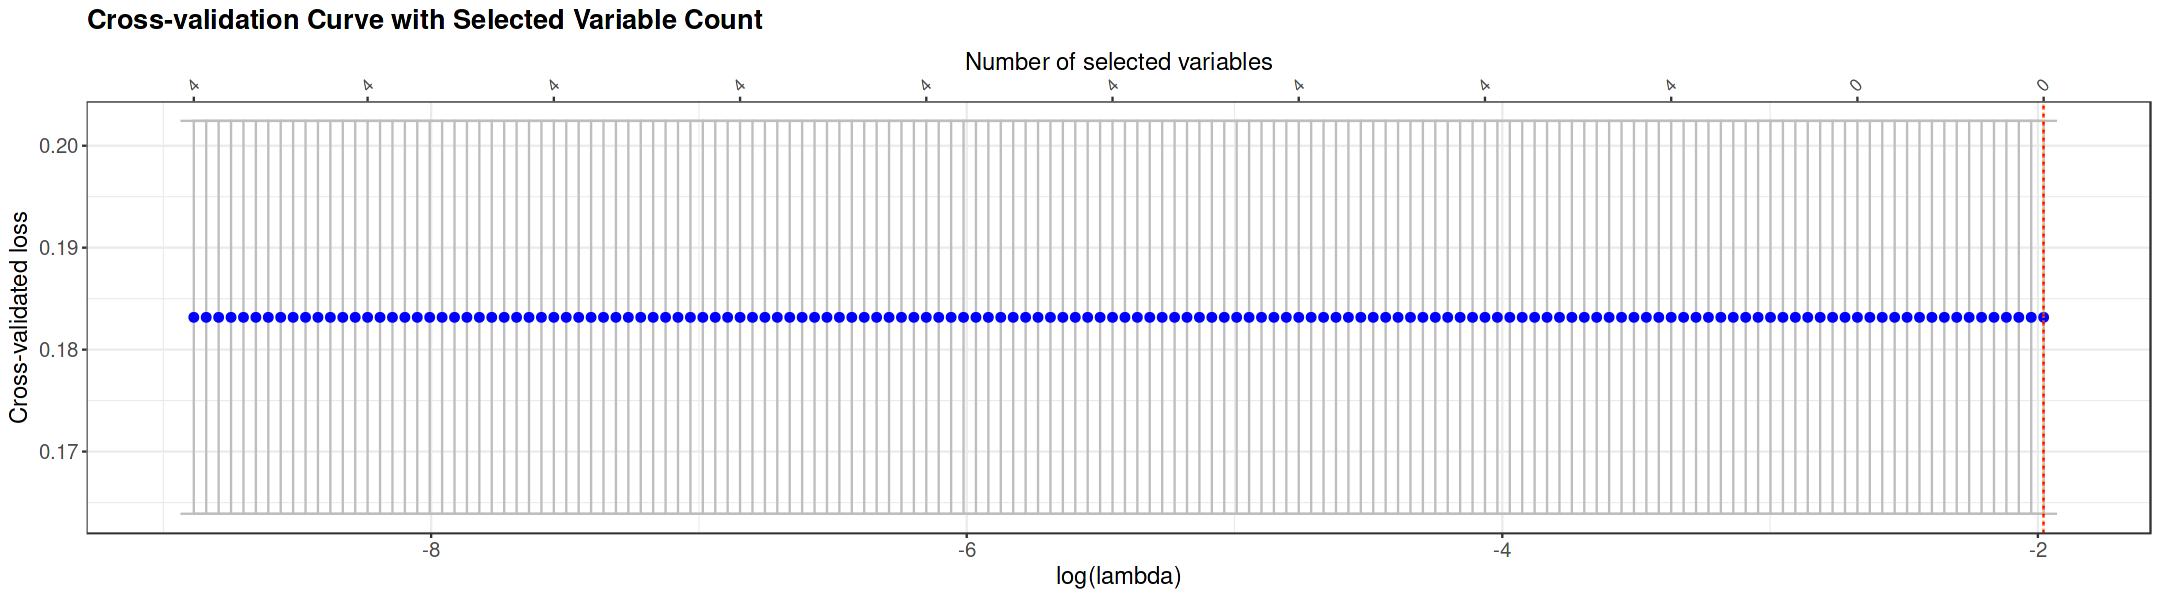

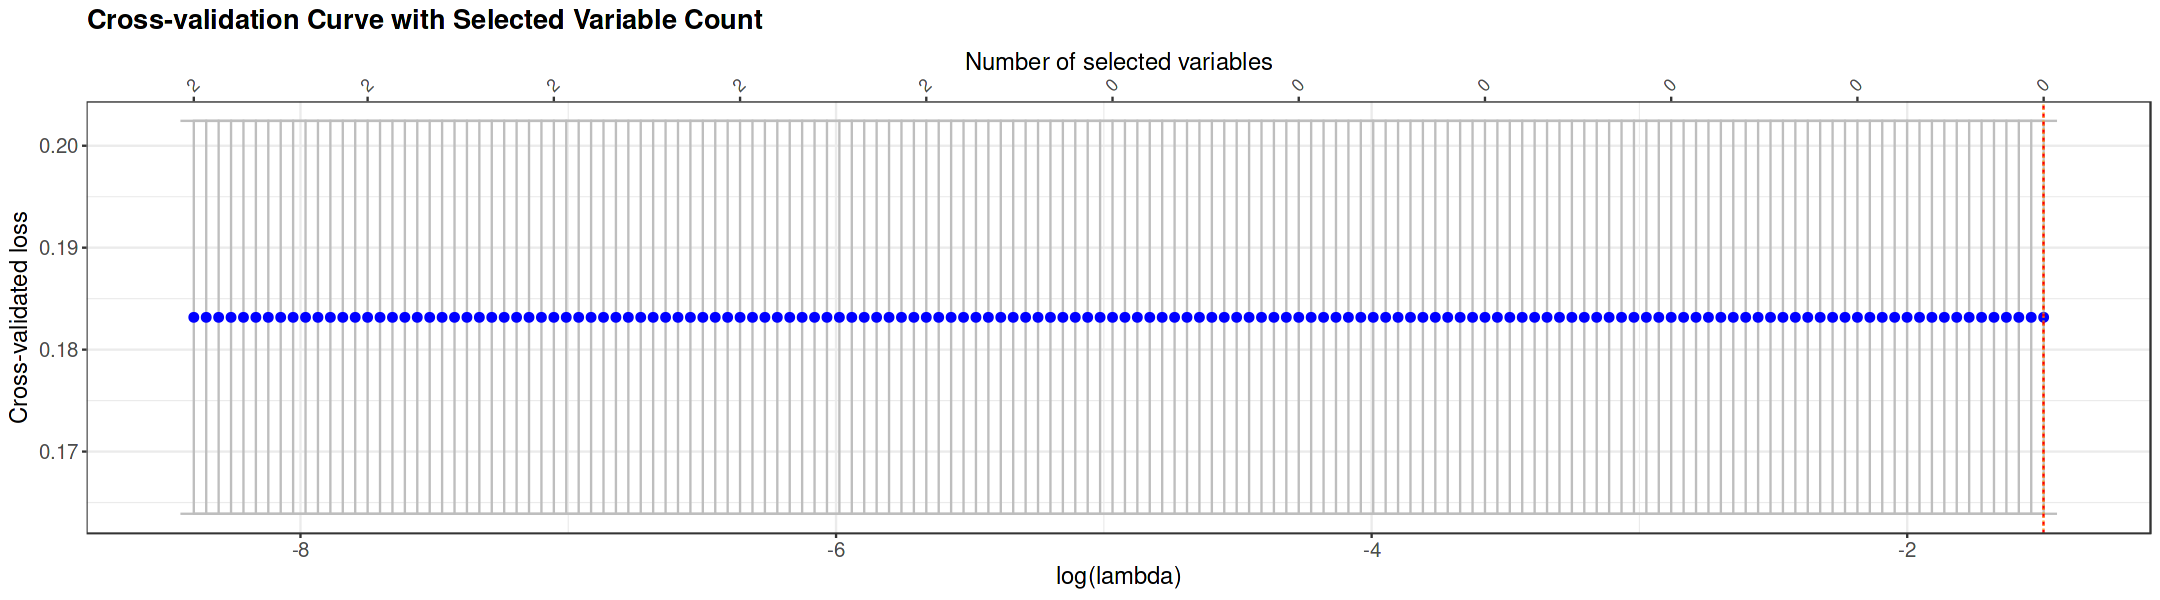

In [511]:
cat("\n\n=== MODELS FOR y4 ===\n")

# Run cross-validation for all 5 models with y4
set.seed(123)
cv4_results1 <- cv_gglasso_collect_auc(x1_train, y4_train, group_indices1)## Model 1: BaseLine model
set.seed(123)
cv4_results2 <- cv_gglasso_collect_auc(x2_train, y4_train, group_indices2)## Model 2: BaseLine + psychosocial model
set.seed(123)
cv4_results3 <- cv_gglasso_collect_auc(x3_train, y4_train, group_indices3)##  Model 3: BaseLine + psychosocial + lifestyle model
set.seed(123)
cv4_results4 <- cv_gglasso_collect_auc(x4_train, y4_train, group_indices4)##  Model 4:  psychosocial  
set.seed(123)
cv4_results5 <- cv_gglasso_collect_auc(x5_train, y4_train, group_indices5)# Model 5: lifestyle


In [512]:

# Print cross-validation results with confidence intervals
cat("\n--- Cross-Validation Results for y4 (on Training Set) ---\n")
cat("Model 1: Baseline characteristics only - AUC:", round(cv4_results1$mean_auc, 3), 
    "95% CI: [", round(cv4_results1$ci_lower, 3), "-", round(cv4_results1$ci_upper, 3), "]\n")
cat("Model 2: BaseLine + Psychosocial - AUC:", round(cv4_results2$mean_auc, 3), 
    "95% CI: [", round(cv4_results2$ci_lower, 3), "-", round(cv4_results2$ci_upper, 3), "]\n")
cat("Model 3: BaseLine + Psychosocial + Lifestyle - AUC:", round(cv4_results3$mean_auc, 3), 
    "95% CI: [", round(cv4_results3$ci_lower, 3), "-", round(cv4_results3$ci_upper, 3), "]\n")
cat("Model 4: Psychosocial only - AUC:", round(cv4_results4$mean_auc, 3), 
    "95% CI: [", round(cv4_results4$ci_lower, 3), "-", round(cv4_results4$ci_upper, 3), "]\n")
cat("Model 5: Lifestyle only - AUC:", round(cv4_results5$mean_auc, 3), 
    "95% CI: [", round(cv4_results5$ci_lower, 3), "-", round(cv4_results5$ci_upper, 3), "]\n")

# Extract coefficients for each model
len_model1_y4 <- cv4_results1$selected_variable_count
len_model2_y4 <- cv4_results2$selected_variable_count
len_model3_y4 <- cv4_results3$selected_variable_count
len_model4_y4 <- cv4_results4$selected_variable_count
len_model5_y4 <- cv4_results5$selected_variable_count




--- Cross-Validation Results for y4 (on Training Set) ---
Model 1: Baseline characteristics only - AUC: 0.613 95% CI: [ 0.55 - 0.675 ]
Model 2: BaseLine + Psychosocial - AUC: 0.638 95% CI: [ 0.552 - 0.725 ]
Model 3: BaseLine + Psychosocial + Lifestyle - AUC: 0.5 95% CI: [ 0.5 - 0.5 ]
Model 4: Psychosocial only - AUC: 0.5 95% CI: [ 0.5 - 0.5 ]
Model 5: Lifestyle only - AUC: 0.5 95% CI: [ 0.5 - 0.5 ]


In [513]:
cv4_models <- list(
  `Model 1: BaseLine` = cv4_results1,
  `Model 2: BaseLine +Psychosocial` = cv4_results2,
  `Model 3: BaseLine+P+Lifestyle` = cv4_results3,
  `Model 4: Psychosocial` = cv4_results4,
  `Model 5: Lifestyle` = cv4_results5
)

combine_gglasso_coefficients(cv4_models)

Variable                         
X.Intercept.                      (Intercept)                      
DiseaseEntityUC                   DiseaseEntityUC                  
genderFemale                      genderFemale                     
bmi                               bmi                              
age_at_inclusion                  age_at_inclusion                 
montreal_extent_uc2.3             montreal_extent_uc2&3            
montreal_severity_uc1.2           montreal_severity_uc1&2          
montreal_severity_uc3             montreal_severity_uc3            
montreal_location_cd1             montreal_location_cd1            
montreal_age_diagnosis_uc..median montreal_age_diagnosis_uc> median
surg_ileo_anal_pouch1             surg_ileo_anal_pouch1            
surg_small_bowel_resection1       surg_small_bowel_resection1      
surg_ileocaecal_resection1        surg_ileocaecal_resection1       
surg_small_bowel_stoma1           surg_small_bowel_stoma1          
number_of_surgeries..1            number_of_surgeries> 1           
age_at_surg_ileo_anal_pouch       age_at_surg_ileo_anal_pouch      
age_at_surg_small_bowel_resection age_at_surg_small_bowel_resection
age_at_surg_ileocaecal_resection  age_at_surg_ileocaecal_resection 
age_at_surg_small_bowel_stoma     age_at_surg_small_bowel_stoma    
age_at_surg_colostoma             age_at_surg_colostoma            
age_at_surg_stenoplasty           age_at_surg_stenoplasty          
History_colitis1                  History_colitis1                 
History_crohn1                    History_crohn1                   
used_Vedolizumab1                 used_Vedolizumab1                
used_Tofacitinib1                 used_Tofacitinib1                
used_Mesalazine_oraal1            used_Mesalazine_oraal1           
total_medication_period           total_medication_period          
period_Mesalazine_oraal           period_Mesalazine_oraal          
period_Methotrexaat               period_Methotrexaat              
period_Sulfasalazine              period_Sulfasalazine             
X                                 Anxious_mean                     
X.1                               Depression_mean                  
X.2                               Fatigue_mean                     
X.3                               MIAH_pain_mean                   
X.4                               smokerEx-smoker                  
X.5                               smokerCurrent smoker             
                                  Model 1: BaseLine
X.Intercept.                      1.6876           
DiseaseEntityUC                   0.1126           
genderFemale                      -0.0703          
bmi                               -0.0138          
age_at_inclusion                  -0.1709          
montreal_extent_uc2.3             -0.3291          
montreal_severity_uc1.2           0.0644           
montreal_severity_uc3             0.2429           
montreal_location_cd1             0.9859           
montreal_age_diagnosis_uc..median -0.0942          
surg_ileo_anal_pouch1             0.027            
surg_small_bowel_resection1       0.0026           
surg_ileocaecal_resection1        0.1089           
surg_small_bowel_stoma1           -0.0362          
number_of_surgeries..1            0.2646           
age_at_surg_ileo_anal_pouch       0.2844           
age_at_surg_small_bowel_resection 0.0013           
age_at_surg_ileocaecal_resection  0.2999           
age_at_surg_small_bowel_stoma     -0.2036          
age_at_surg_colostoma             0.3705           
age_at_surg_stenoplasty           0.2407           
History_colitis1                  -1.4886          
History_crohn1                    0.7085           
used_Vedolizumab1                 0.5236           
used_Tofacitinib1                 -0.4073          
used_Mesalazine_oraal1            0.0628           
total_medication_period           0.1061           
period_Mesalazine_oraal           0.0997           
period_Met

### 3.8.2 Performance Evaluation

In [514]:
# ===== ANALYSIS FOR Y4 =====
cat("\n--- Cross-Validation Results for Y4 (on Testing Set) ---\n")

# Compute metrics for all models with y4
metrics_model1_y4 <- compute_metrics(model = cv4_results1$model, x = x1_test, y4_test)
metrics_model2_y4 <- compute_metrics(model = cv4_results2$model, x = x2_test, y4_test)
#metrics_model3_y4 <- compute_metrics(model = cv4_results3$model, x = x3_test, y4_test)
#metrics_model4_y4 <- compute_metrics(model = cv4_results4$model, x = x4_test, y4_test)
#metrics_model5_y4 <- compute_metrics(model = cv4_results5$model, x = x5_test, y4_test)

# Print performance metrics for Y3
cat("Model 1: Baseline characteristics only - Accuracy:", metrics_model1_y4$accuracy, "AUC:", metrics_model1_y4$auc, "  (95% CI: [", round(metrics_model1_y4$auc-cv3_results1$margin, 3), "-", round(metrics_model1_y4$auc+cv3_results1$margin, 3), "])\n")
cat("Model 2: BaseLine + Psychosocial - Accuracy:", metrics_model2_y4$accuracy, "AUC:", metrics_model2_y4$auc, " (95% CI: [", round(metrics_model2_y4$auc-cv3_results2$margin, 3), "-", round(metrics_model2_y4$auc+cv3_results2$margin, 3), "])\n")
#cat("Model 3: BaseLine + Psychosocial + Lifestyle - Accuracy:", metrics_model3_y4$accuracy, "AUC:", metrics_model3_y4$auc,  " (95% CI: [", round(metrics_model3_y4$auc-cv3_results3$margin, 3), "-", round(metrics_model3_y4$auc+cv3_results3$margin, 3), "])\n")
#cat("Model 4: Psychosocial only - Accuracy:", metrics_model4_y4$accuracy, "AUC:", metrics_model4_y4$auc,  " (95% CI: [", round(metrics_model4_y4$auc-cv3_results4$margin, 3), "-", round(metrics_model4_y4$auc+cv3_results4$margin, 3), "])\n")
#cat("Model 5: Lifestyle only - Accuracy:", metrics_model5_y4$accuracy, "AUC:", metrics_model5_y4$auc,   " (95% CI: [", round(metrics_model5_y4$auc-cv3_results5$margin, 3), "-", round(metrics_model5_y4$auc+cv3_results5$margin, 3), "])\n")


--- Cross-Validation Results for Y4 (on Testing Set) ---
Model 1: Baseline characteristics only - Accuracy: 0.6416185 AUC: 0.612069   (95% CI: [ 0.612 - 0.612 ])
Model 2: BaseLine + Psychosocial - Accuracy: 0.3352601 AUC: 0.5658525  (95% CI: [ 0.486 - 0.646 ])


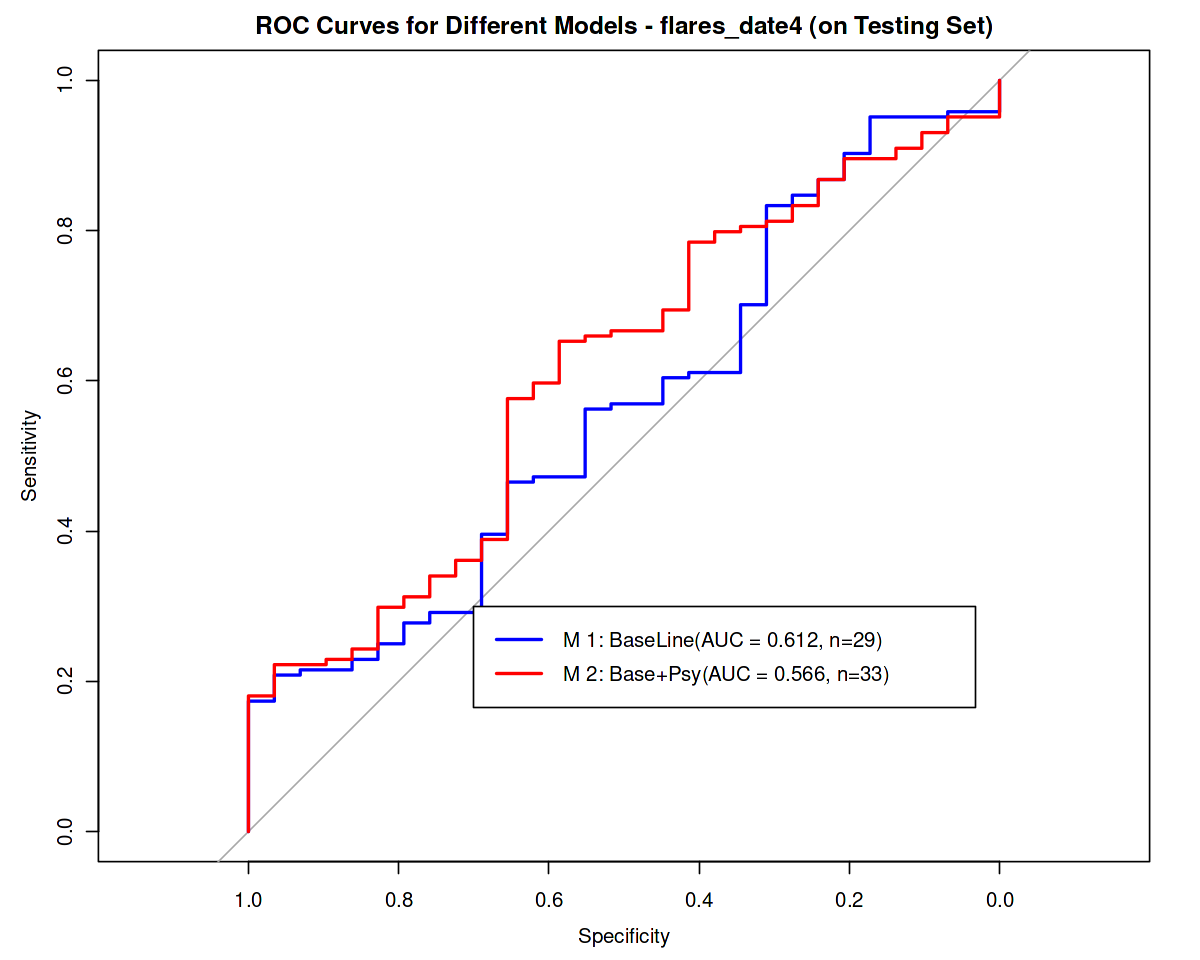

In [515]:
# Plot ROC Curves for All Models - Y3
roc_model1_y4 <- metrics_model1_y4$roc_curve
roc_model2_y4 <- metrics_model2_y4$roc_curve
#roc_model3_y4 <- metrics_model3_y4$roc_curve
#roc_model4_y4 <- metrics_model4_y4$roc_curve
#roc_model5_y4 <- metrics_model5_y4$roc_curve

# ROC plot for Y3
legend_labels_y4 <- c(
 paste0("M 1: BaseLine(AUC = ", sprintf("%.3f", auc(roc_model1_y4)),  ", n=",len_model1_y4,")"),
    paste0("M 2: Base+Psy(AUC = ", sprintf("%.3f", auc(roc_model2_y4)),  ", n=",len_model2_y4,")")


 #   paste0("M 4: Psychosocial(AUC = ", sprintf("%.3f", auc(roc_model4_y4)), ", n=",len_model4_y4,")"),
  #  paste0("M 3: Base+Psy+Lifestyle(AUC = ", sprintf("%.3f", auc(roc_model3_y4)), ", n=",len_model3_y4, ")")
      #paste0("M 5: Lifestyle(AUC = ", sprintf("%.3f", auc(roc_model5_y4)),  ", n=",len_model5,")"),
   )

# Create ROC plot for Y3
options(repr.plot.width=10, repr.plot.height=8)
plot(roc_model2_y4, col = "blue", main = "ROC Curves for Different Models - flares_date4 (on Testing Set)")
plot(roc_model1_y4, col = "red", add = TRUE)
#plot(roc_model2_y4, col = "darkgreen", add = TRUE)
#plot(roc_model5_y4, col = "cyan", add = TRUE)
#plot(roc_model1_y4, col = "gray90", add = TRUE)
    
# Add legend
legend(x = 0.7, y = 0.3, 
        legend = legend_labels_y4,
        col = c("blue", "red"),
        lwd = 2)



In [516]:
# Create a results table for Y3
results_table_y4 <- data.frame(
    Model = c("Model 1: BaseLine", 
              "Model 2: BaseLine +Psychosocial" 
              #"Model 3: BaseLine+P+Lifestyle", 
              #"Model 4: Psychosocial"#,  "Model 5: Lifestyle"
              ),
    Sensitivity = c(metrics_model1_y4$metrics[1],
                    metrics_model2_y4$metrics[1]
                    #metrics_model3_y4$metrics[1],  metrics_model4_y4$metrics[1]#,metrics_model5_y$metrics[1]
                    ),
    Specificity = c(metrics_model1_y4$metrics[2], 
                    metrics_model2_y4$metrics[2]
                    #metrics_model3_y4$metrics[2],   metrics_model4_y4$metrics[2]#,metrics_model5_y4$metrics[2]
                    ),
    PPV = c(metrics_model1_y4$metrics[3],
            metrics_model2_y4$metrics[3]
           # metrics_model3_y4$metrics[3],  metrics_model4_y4$metrics[3]#,metrics_model5_y4$metrics[3]
            ),
    NPV = c(metrics_model1_y4$metrics[4],
            metrics_model2_y4$metrics[4]
            #metrics_model3_y4$metrics[4], metrics_model4_y4$metrics[4]#, metrics_model5_y4$metrics[4]
            )
)

# Print the results table for Y
cat("Results Table for Y4:\n")
print(results_table_y4)


Results Table for Y4:
                            Model Sensitivity Specificity       PPV       NPV
1               Model 1: BaseLine   0.6527778   0.5862069 0.8867925 0.2537313
2 Model 2: BaseLine +Psychosocial   0.2083333   0.9655172 0.9677419 0.1971831


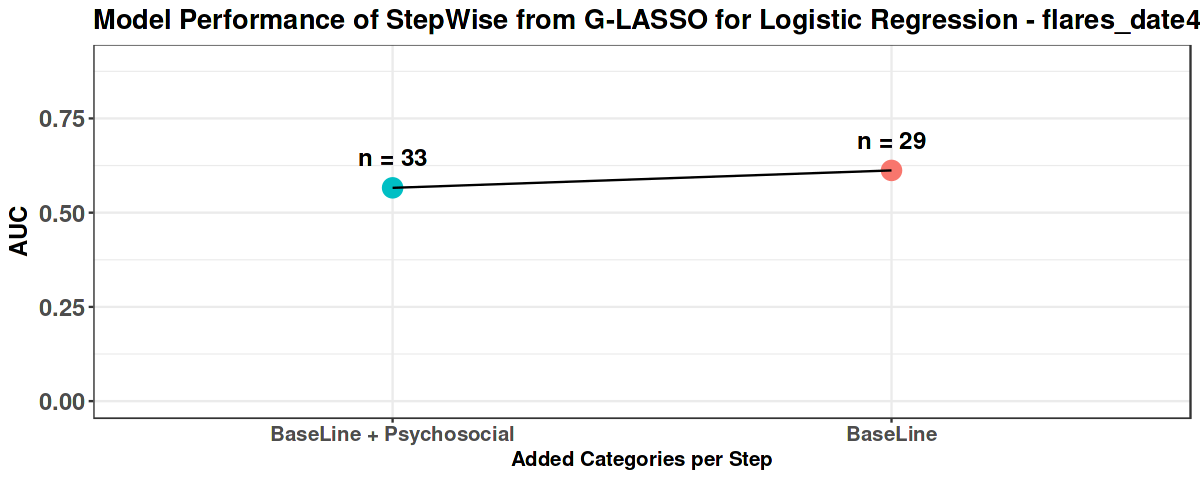

In [517]:
# Variable importance plot for Y4
variable_importance_y4 <- data.frame(
  Variable = c("BaseLine", 
               "BaseLine + Psychosocial"#, "BaseLine + Psychosocial + Lifestyle", 
              # "Psychosocial"#, "Lifestyle"
               ),
  auc_values = c(metrics_model1_y4$auc,
                 metrics_model2_y4$auc#, metrics_model3_y4$auc,
                # metrics_model4_y4$auc#,metrics_model5_y4$auc
                 ),
  n_vars = c(len_model1_y4, 
             len_model2_y4#, len_model3_y4, len_model4_y4#, len_model5_y4
             )
)

# Create Figure : Variable Importance Plot for Y4
options(repr.plot.width=10, repr.plot.height=4)
ggplot(variable_importance_y4, aes(x = reorder(Variable, auc_values), y = auc_values)) +
  geom_point(aes(color = Variable), size = 5) +
  geom_line(group = 1) +
  geom_text(aes(label = paste0("n = ", n_vars)), 
            vjust = -1.2, size = 5, fontface = "bold") +
    ylim(0, .9) +
  labs(title = "Model Performance of StepWise from G-LASSO for Logistic Regression - flares_date4",
       x = "Added Categories per Step",
       y = "AUC") +
  theme_bw() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 16, face = "bold"),
    axis.title.x = element_text(size = 12, face = "bold"),
    axis.title.y = element_text(size = 14, face = "bold"),
    axis.text.x = element_text(size = 12, face = "bold"),
    axis.text.y = element_text(size = 14, face = "bold")
  )



# 4. Model Comparison

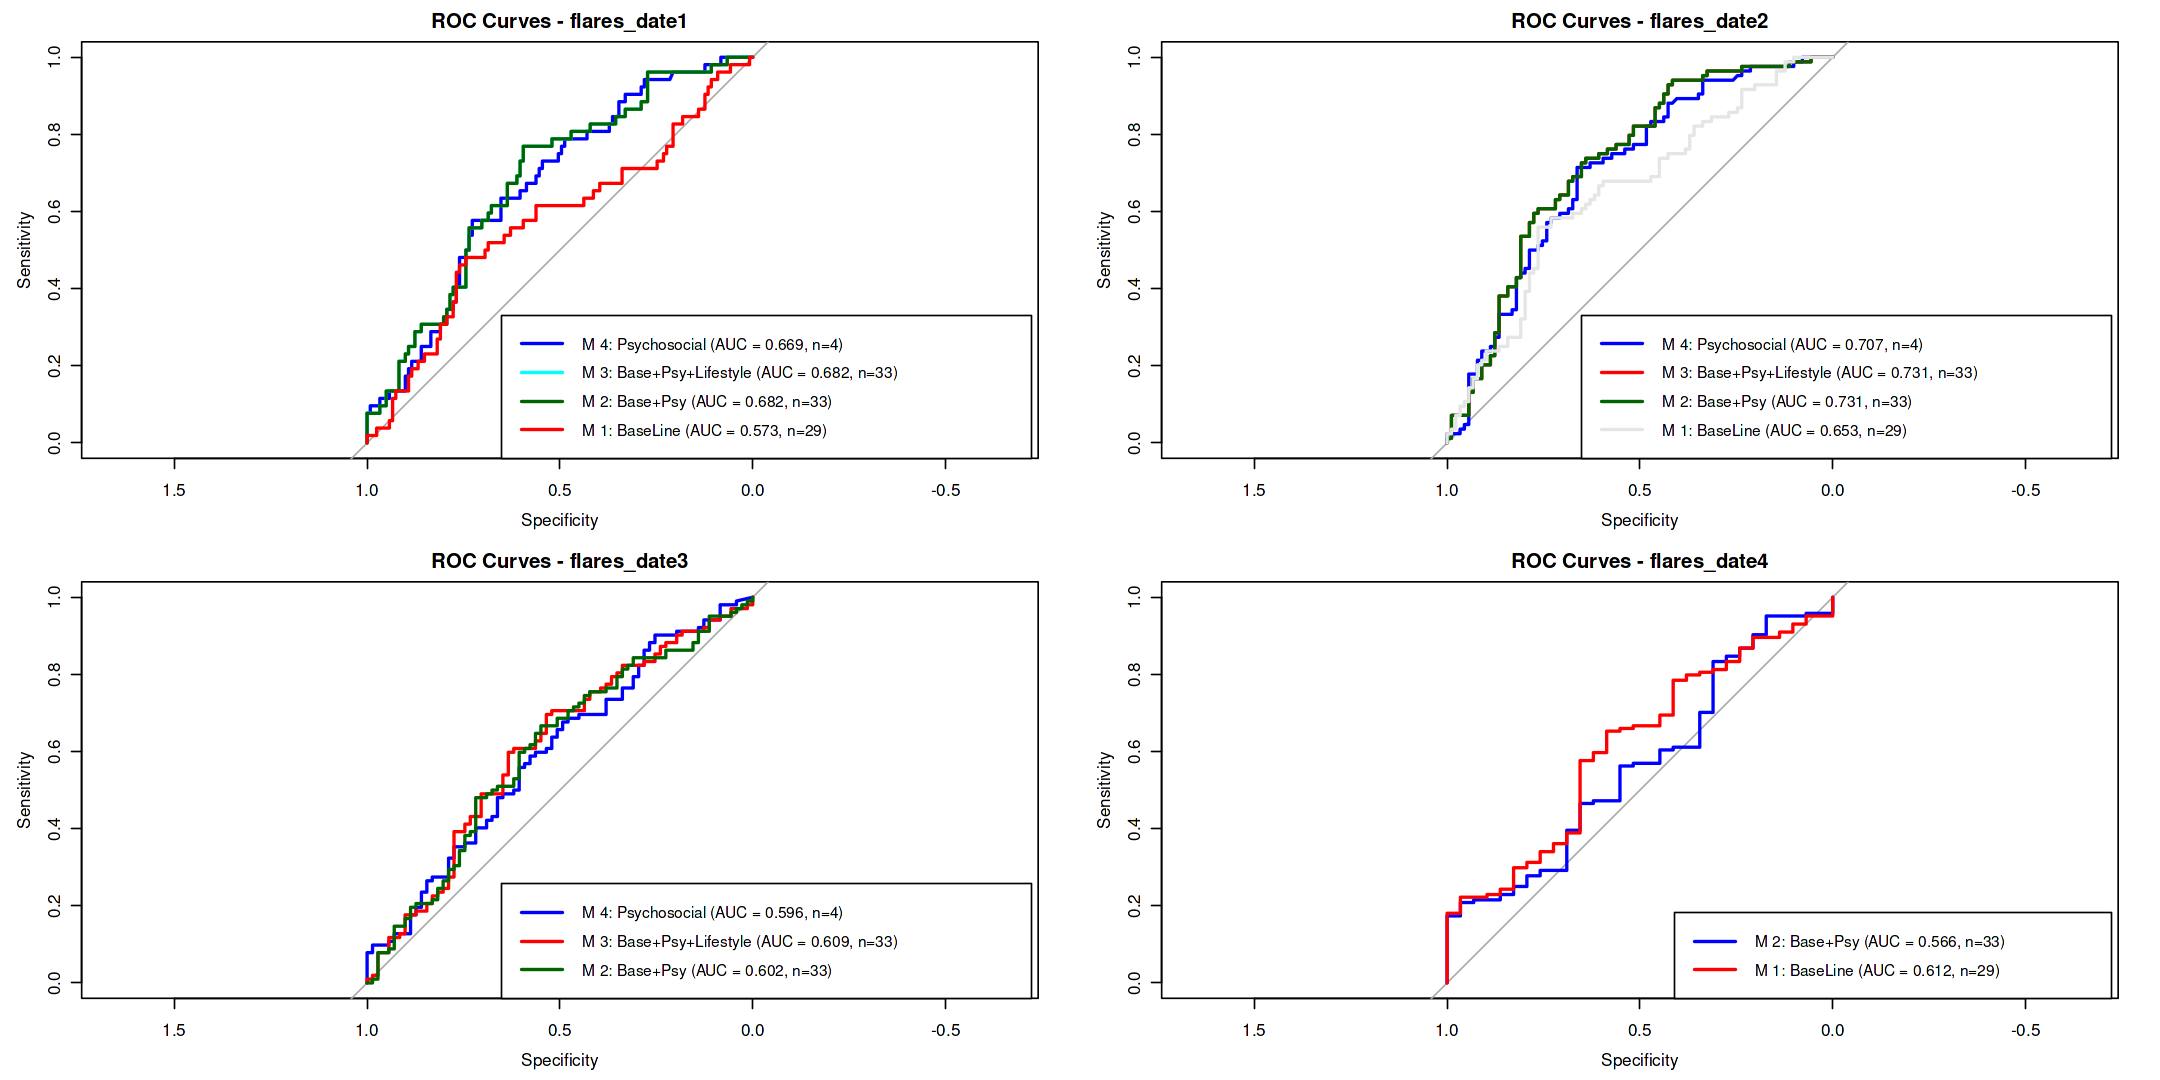

In [523]:
# Set up a 2x2 grid layout for the four ROC curves
par(mfrow = c(2, 2), mar = c(4, 4, 3, 2))
options(repr.plot.width=18, repr.plot.height=9)
# Plot 1: ROC Curves for Y1 (flares_date1)
plot(roc_model4_y1, col = "blue", main = "ROC Curves - flares_date1")
plot(roc_model3_y1, col = "cyan", add = TRUE)
plot(roc_model2_y1, col = "darkgreen", add = TRUE)
plot(roc_model1_y1, col = "red", add = TRUE)

legend_labels_y1 <- c(
    paste0("M 4: Psychosocial (AUC = ", sprintf("%.3f", auc(roc_model4_y1)), ", n=", len_model4_y1, ")"),
    paste0("M 3: Base+Psy+Lifestyle (AUC = ", sprintf("%.3f", auc(roc_model3_y1)), ", n=", len_model3_y1, ")"),
    paste0("M 2: Base+Psy (AUC = ", sprintf("%.3f", auc(roc_model2_y1)), ", n=", len_model2_y1, ")"),
    paste0("M 1: BaseLine (AUC = ", sprintf("%.3f", auc(roc_model1_y1)), ", n=", len_model1_y1, ")")
)

legend("bottomright", 
       legend = legend_labels_y1,
       col = c("blue", "cyan", "darkgreen", "red"),
       lwd = 2, cex = .9)

# Plot 2: ROC Curves for Y2 (flares_date2)
plot(roc_model4_y2, col = "blue", main = "ROC Curves - flares_date2")
plot(roc_model3_y2, col = "red", add = TRUE)
plot(roc_model2_y2, col = "darkgreen", add = TRUE)
plot(roc_model1_y2, col = "gray90", add = TRUE)

legend_labels_y2 <- c(
    paste0("M 4: Psychosocial (AUC = ", sprintf("%.3f", auc(roc_model4_y2)), ", n=", len_model4_y2, ")"),
    paste0("M 3: Base+Psy+Lifestyle (AUC = ", sprintf("%.3f", auc(roc_model3_y2)), ", n=", len_model3_y2, ")"),
    paste0("M 2: Base+Psy (AUC = ", sprintf("%.3f", auc(roc_model2_y2)), ", n=", len_model2_y2, ")"),
    paste0("M 1: BaseLine (AUC = ", sprintf("%.3f", auc(roc_model1_y2)), ", n=", len_model1_y2, ")")
)

legend("bottomright", 
       legend = legend_labels_y2,
       col = c("blue", "red", "darkgreen", "gray90"),
       lwd = 2, cex = 0.9)

# Plot 3: ROC Curves for Y3 (flares_date3)
plot(roc_model4_y3, col = "blue", main = "ROC Curves - flares_date3")
plot(roc_model3_y3, col = "red", add = TRUE)
plot(roc_model2_y3, col = "darkgreen", add = TRUE)

legend_labels_y3 <- c(
    paste0("M 4: Psychosocial (AUC = ", sprintf("%.3f", auc(roc_model4_y3)), ", n=", len_model4_y3, ")"),
    paste0("M 3: Base+Psy+Lifestyle (AUC = ", sprintf("%.3f", auc(roc_model3_y3)), ", n=", len_model3_y3, ")"),
    paste0("M 2: Base+Psy (AUC = ", sprintf("%.3f", auc(roc_model2_y3)), ", n=", len_model2_y3, ")")
)

legend("bottomright", 
       legend = legend_labels_y3,
       col = c("blue", "red", "darkgreen"),
       lwd = 2, cex = 0.9)

# Plot 4: ROC Curves for Y4 (flares_date4)
plot(roc_model2_y4, col = "blue", main = "ROC Curves - flares_date4")
plot(roc_model1_y4, col = "red", add = TRUE)

legend_labels_y4 <- c(
    paste0("M 2: Base+Psy (AUC = ", sprintf("%.3f", auc(roc_model2_y4)), ", n=", len_model2_y4, ")"),
    paste0("M 1: BaseLine (AUC = ", sprintf("%.3f", auc(roc_model1_y4)), ", n=", len_model1_y4, ")")
)

legend("bottomright", 
       legend = legend_labels_y4,
       col = c("blue", "red"),
       lwd = 2, cex = 0.9)

# Reset the plotting parameters back to default
par(mfrow = c(1, 1))

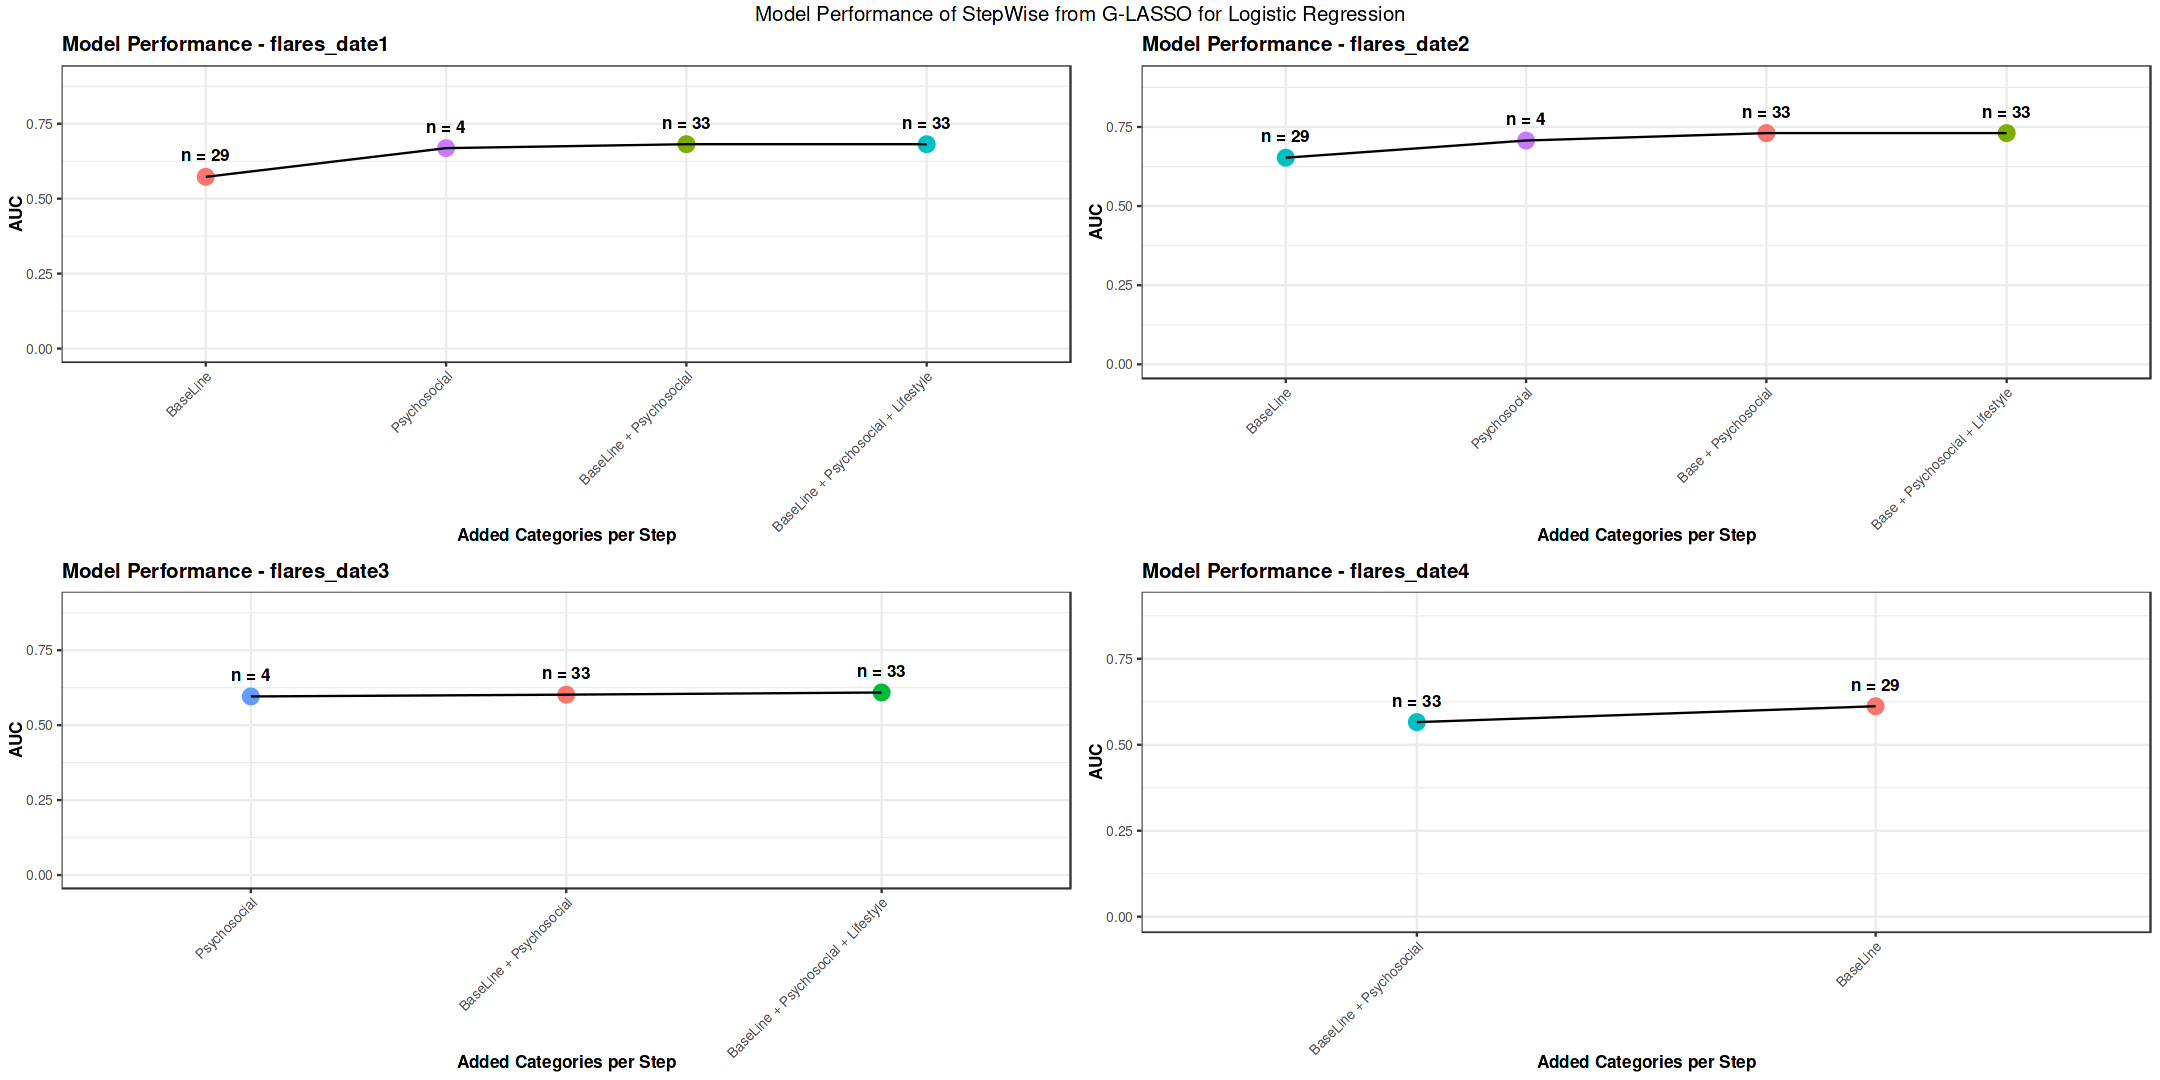

In [519]:
library(gridExtra)

# Variable importance plot for Y1
variable_importance_y1 <- data.frame(
  Variable = c("BaseLine", 
               "BaseLine + Psychosocial", "BaseLine + Psychosocial + Lifestyle", 
               "Psychosocial"),
  auc_values = c(metrics_model1_y1$auc,
                 metrics_model2_y1$auc, metrics_model3_y1$auc, metrics_model4_y1$auc),
  n_vars = c(len_model1_y1, 
             len_model2_y1, len_model3_y1, len_model4_y1)
)

p1 <- ggplot(variable_importance_y1, aes(x = reorder(Variable, auc_values), y = auc_values)) +
  geom_point(aes(color = Variable), size = 4) +
  geom_line(group = 1) +
  geom_text(aes(label = paste0("n = ", n_vars)), 
            vjust = -1.2, size = 3.5, fontface = "bold") +
  ylim(0, .9) +
  labs(title = "Model Performance - flares_date1",
       x = "Added Categories per Step",
       y = "AUC") +
  theme_bw() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 12, face = "bold"),
    axis.title.x = element_text(size = 10, face = "bold"),
    axis.title.y = element_text(size = 10, face = "bold"),
    axis.text.x = element_text(size = 8, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 8)
  )

# Variable importance plot for Y2
variable_importance_y2 <- data.frame(
  Variable = c("BaseLine", 
               "Base + Psychosocial", "Base + Psychosocial + Lifestyle", 
               "Psychosocial"),
  auc_values = c(metrics_model1_y2$auc,
                 metrics_model2_y2$auc, metrics_model3_y2$auc, metrics_model4_y2$auc),
  n_vars = c(len_model1_y2, 
             len_model2_y2, len_model3_y2, len_model4_y2)
)

p2 <- ggplot(variable_importance_y2, aes(x = reorder(Variable, auc_values), y = auc_values)) +
  geom_point(aes(color = Variable), size = 4) +
  geom_line(group = 1) +
  geom_text(aes(label = paste0("n = ", n_vars)), 
            vjust = -1.2, size = 3.5, fontface = "bold") +
  ylim(0, .9) +
  labs(title = "Model Performance - flares_date2",
       x = "Added Categories per Step",
       y = "AUC") +
  theme_bw() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 12, face = "bold"),
    axis.title.x = element_text(size = 10, face = "bold"),
    axis.title.y = element_text(size = 10, face = "bold"),
    axis.text.x = element_text(size = 8, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 8)
  )

# Variable importance plot for Y3
variable_importance_y3 <- data.frame(
  Variable = c("BaseLine + Psychosocial", "BaseLine + Psychosocial + Lifestyle", 
               "Psychosocial"),
  auc_values = c(metrics_model2_y3$auc, metrics_model3_y3$auc,
                 metrics_model4_y3$auc),
  n_vars = c(len_model2_y3, len_model3_y3, len_model4_y3)
)

p3 <- ggplot(variable_importance_y3, aes(x = reorder(Variable, auc_values), y = auc_values)) +
  geom_point(aes(color = Variable), size = 4) +
  geom_line(group = 1) +
  geom_text(aes(label = paste0("n = ", n_vars)), 
            vjust = -1.2, size = 3.5, fontface = "bold") +
  ylim(0, .9) +
  labs(title = "Model Performance - flares_date3",
       x = "Added Categories per Step",
       y = "AUC") +
  theme_bw() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 12, face = "bold"),
    axis.title.x = element_text(size = 10, face = "bold"),
    axis.title.y = element_text(size = 10, face = "bold"),
    axis.text.x = element_text(size = 8, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 8)
  )

# Variable importance plot for Y4
variable_importance_y4 <- data.frame(
  Variable = c("BaseLine", 
               "BaseLine + Psychosocial"),
  auc_values = c(metrics_model1_y4$auc,
                 metrics_model2_y4$auc),
  n_vars = c(len_model1_y4, 
             len_model2_y4)
)

p4 <- ggplot(variable_importance_y4, aes(x = reorder(Variable, auc_values), y = auc_values)) +
  geom_point(aes(color = Variable), size = 4) +
  geom_line(group = 1) +
  geom_text(aes(label = paste0("n = ", n_vars)), 
            vjust = -1.2, size = 3.5, fontface = "bold") +
  ylim(0, .9) +
  labs(title = "Model Performance - flares_date4",
       x = "Added Categories per Step",
       y = "AUC") +
  theme_bw() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 12, face = "bold"),
    axis.title.x = element_text(size = 10, face = "bold"),
    axis.title.y = element_text(size = 10, face = "bold"),
    axis.text.x = element_text(size = 8, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 8)
  )

# Arrange all four plots in a 2x2 grid
grid.arrange(p1, p2, p3, p4, ncol = 2, nrow = 2,
             top = "Model Performance of StepWise from G-LASSO for Logistic Regression")

# Alternative using cowplot if you prefer (uncomment the lines below and comment out grid.arrange)
# library(cowplot)
# plot_grid(p1, p2, p3, p4, ncol = 2, nrow = 2,
#           labels = c("A", "B", "C", "D"), label_size = 12)